In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
import global_funcs

In [7]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [8]:
X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('Y_train.csv')
X_valid = pd.read_csv('X_valid.csv')
Y_valid = pd.read_csv('Y_valid.csv')
oneHot = OneHotEncoder()
oneHot.fit(Y_train)
oneHot.fit(Y_valid)

OneHotEncoder()

In [9]:
Test = Y_valid #se guardan si onehot encoding para poder valida despues
Train = Y_train

In [10]:
#se dividen la columna Y en dos para entrenamiento
Y_train = oneHot.transform(Y_train).toarray()
Y_valid = oneHot.transform(Y_valid).toarray()

In [11]:
#devuelve la exactitud
def accuracy(predictions, labels):
    with g1.as_default() as g:
        
        acc, acc_op = tf.metrics.accuracy(labels=tf.argmax(labels, 1), 
                                      predictions=tf.argmax(predictions,1),name="accuracy")
        return acc_op

In [12]:
#definiendo grafo
n=len(X_train.columns.values.tolist())

g1 = tf.Graph()
with g1.as_default() as g:
    tensor_x = tf.placeholder(tf.float32, shape=None, name="X")
    tensor_y = tf.placeholder(tf.float32,None,"Y")
    
    with tf.name_scope("tests"):
        test_x = tf.placeholder(tf.float32, shape=None, name="XTest")
        test_y = tf.placeholder(tf.float32,None,"YTest")
    
    tf.random.set_random_seed(10)
    with tf.name_scope("weights"):
        W = tf.Variable(tf.truncated_normal([n, 2]),name="W")
    
    with tf.name_scope("regularization"):
        L1 = tf.reduce_sum(tf.abs(W),name="l1")
        L2 = tf.reduce_mean(tf.math.square(W),name="l2")
        L2t = tf.nn.l2_loss(W,name="l2t")
    
    with tf.name_scope("y_hat") as scope:
        y_hat = tf.nn.sigmoid(tf.matmul(tensor_x, W),name="Y_hat")
        y_hat_s = tf.nn.softmax(tf.matmul(tensor_x, W),name="Y_hat_s")
        
    with tf.name_scope("predictions") as scope:
        test_prediction =  tf.nn.sigmoid(tf.matmul(test_x, W),name='prediction')
        test_prediction_s =  tf.nn.softmax(tf.matmul(test_x, W),name='prediction_s')

    with tf.name_scope("accurracy") as scope:
        training_accurracy = accuracy(y_hat,tensor_y)
        training_accurracy_s = accuracy(y_hat_s,tensor_y)
        test_accurracy = accuracy(test_prediction,test_y)
        test_accurracy_s = accuracy(test_prediction_s,test_y)

In [13]:
#obtiene la sessión para poder guardar el modelo
def get_session(sess):
    session = sess
    while type(session).__name__ != 'Session':
        #pylint: disable=W0212
        session = session._sess
    return session

In [14]:
#función de entranamiento para nuestro modelo
def training(X,Y,XT,YT,epochs,lr,batch_size,reg,factor, sigmoid = True):
    conf_string="regresión logistica, lr: "+str(lr)+', batch_size: '+str(batch_size)+', regularizacion: '+str(reg)+', factor: '+str(factor)+' sigmoid: '+str(sigmoid)
    iteraciones = int(len(X) /batch_size)
    loss_plt = []
    with g1.as_default() as g:
        saver = tf.train.Saver()
        with tf.name_scope("loss") as scope:
            if(sigmoid):
                loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits( 
                        logits = y_hat, labels = tensor_y,name="loss_function")+factor*reg)
            else:
                loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( 
                            logits = y_hat_s, labels = tensor_y,name="loss_function_s")+factor*reg)
                
        with tf.name_scope("gradient") as scope:
            gradiente = tf.gradients(loss,W,name="gradients")[0]
            
        with tf.name_scope("optimizer") as scope:
            optimizer = tf.assign(W,W - gradiente * lr,name="optimizer")
            
        with tf.train.MonitoredSession() as sess:
            writer = tf.summary.FileWriter('./logs', session.graph)
            for e in range(epochs):
                for i in range(iteraciones):
                    offset = (i * batch_size) % (Y.shape[0] - batch_size)
                    batch_data = X[offset:(offset + batch_size)]
                    batch_labels = Y[offset:(offset + batch_size)]
                    feed_dict = {tensor_x : batch_data, tensor_y : batch_labels}
                    u, l, predictions = sess.run([optimizer,loss,y_hat],feed_dict=feed_dict)
                feed_dict = {tensor_x:X,tensor_y:Y}
                ls = sess.run(loss,feed_dict)
                loss_plt.append(ls)
                if(e%1000 == 0):
                    print("loss at step %d: %f" % (e, ls))
                    print("Training accuracy: %.3f%%" % sess.run((training_accurracy if sigmoid else training_accurracy_s),feed_dict))
            feed_dict = {tensor_x:X,tensor_y:Y, test_x:XT,test_y:YT}
            print("Test accuracy: %.3f%%" % sess.run((test_accurracy if sigmoid else test_accurracy_s),feed_dict))
            preds = sess.run(test_prediction,feed_dict)
            saver.save(get_session(sess), 'modelos/logistic_regression/model_lr',global_step=1001) #guardando modelo
            return {
                "test_preds":preds,
                "preds_train": sess.run(y_hat,feed_dict),
                "W": sess.run(W),
                "error": loss_plt,
                "conf_string": conf_string,
                "accuracy": sess.run(test_accurracy,feed_dict)
            }

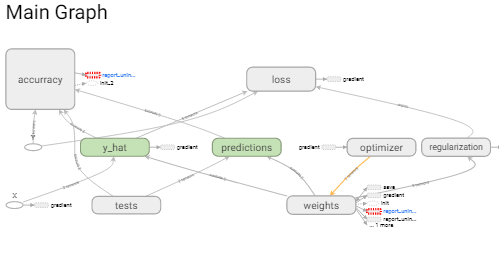

In [15]:
from IPython.display import Image
Image('main_graph.png')

In [153]:
#función que devuelve matriz de confución asi como guardar en bitacora las experimentaciones
def reporte(modelo,Y,Y_test,umbral):
    prob_test = pd.DataFrame(modelo['test_preds'][:,1])
    prob_train = pd.DataFrame(modelo['preds_train'][:,1])
    #y_pred_test = np.argmax(modelo['test_preds'],axis=1)
    #y_pred_train = np.argmax(modelo['preds_train'],axis=1)
    y_pred_test = np.where(prob_test[0] > umbral,1,0)
    y_pred_train = np.where(prob_train[0] > umbral,1,0)
    report = global_funcs.getReport(Y_test["passenger_survived"],Y["passenger_survived"],y_pred_test, y_pred_train)
    df_report = pd.DataFrame(report)
    global_funcs.writeInExcel(df_report,"bitacoar_log_reg.xlsx",modelo['conf_string'])
    return df_report

#### Experimentación
Se experimentara con las diferenes;
regularizaciones
* L1 (implementado manual)
* L2 (implementado manual)
* L2 (función con tensorflow)

Umbrales:
* Diferentes umbrales para las salidadas probabilisticas, dado que es un dataset desproporcionado, experimentaremos con diferentes valores para el umbral, y obtener las mejores metricas buscadas. Se buscar encontrar la mayor cantidad desobrevivientes posibles, y la exactitud de la predicción.

Funciones para la regresión logistica:
* Se experimentaran las funciones sigmoid y softmax para las salidas probabilisticas


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.780193
Training accuracy: 0.351%
loss at step 1000: 0.629911
Training accuracy: 0.564%
Test accuracy: 0.825%


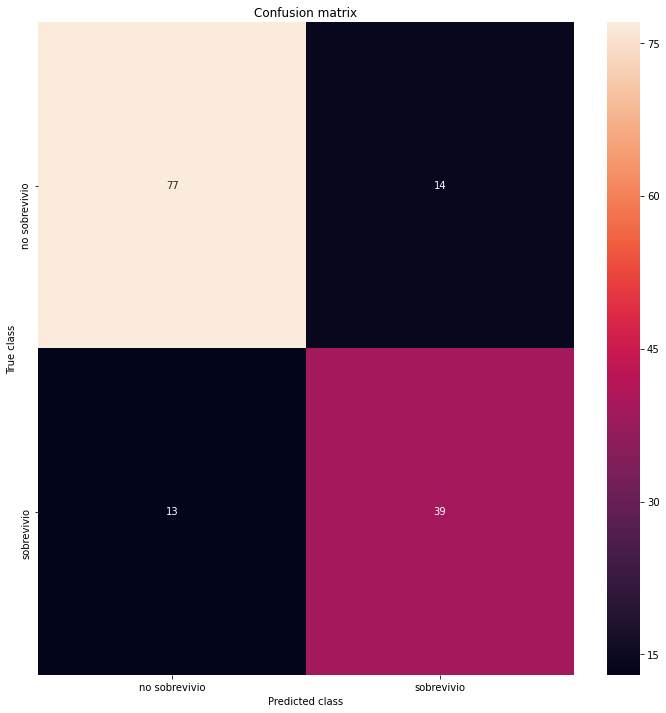

verdaderos positivos: 39
falsos positivos: 14
verdaderos negativos: 77
falsos negativos: 13
              precision    recall  f1-score   support

           0       0.86      0.85      0.85        91
           1       0.74      0.75      0.74        52

    accuracy                           0.81       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.81      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.773286      0.811189
Precision       0.719048      0.735849
Recall:         0.683258      0.750000
F1_Score:       0.700696      0.742857


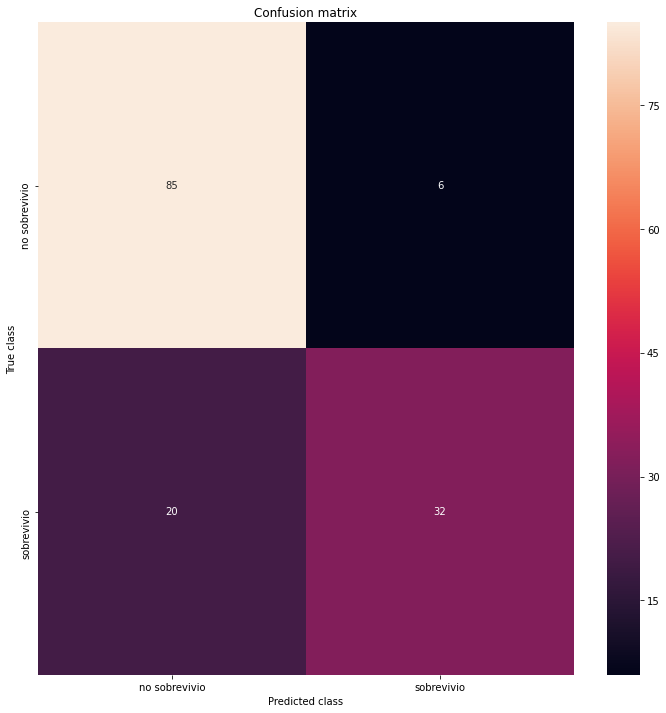

verdaderos positivos: 32
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 20
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        91
           1       0.84      0.62      0.71        52

    accuracy                           0.82       143
   macro avg       0.83      0.77      0.79       143
weighted avg       0.82      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.799649      0.818182
Precision       0.840764      0.842105
Recall:         0.597285      0.615385
F1_Score:       0.698413      0.711111


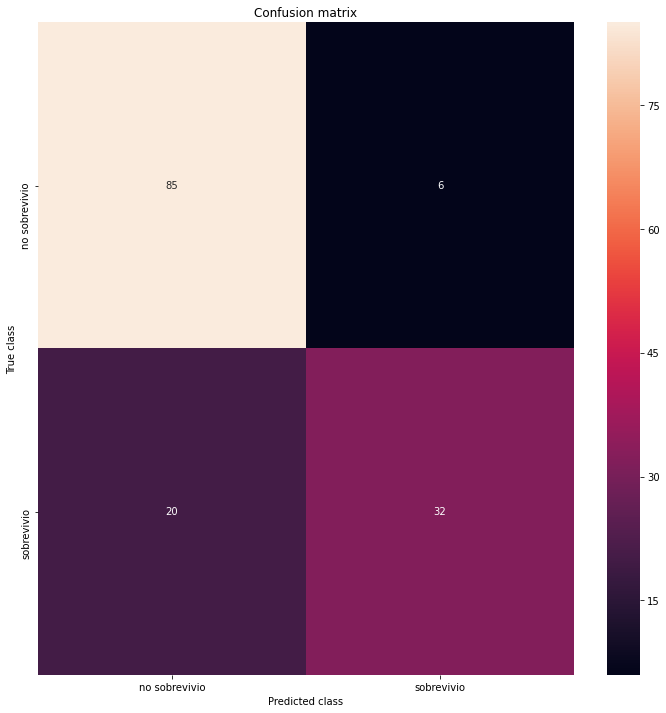

verdaderos positivos: 32
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 20
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        91
           1       0.84      0.62      0.71        52

    accuracy                           0.82       143
   macro avg       0.83      0.77      0.79       143
weighted avg       0.82      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.799649      0.818182
Precision       0.854305      0.842105
Recall:         0.583710      0.615385
F1_Score:       0.693548      0.711111


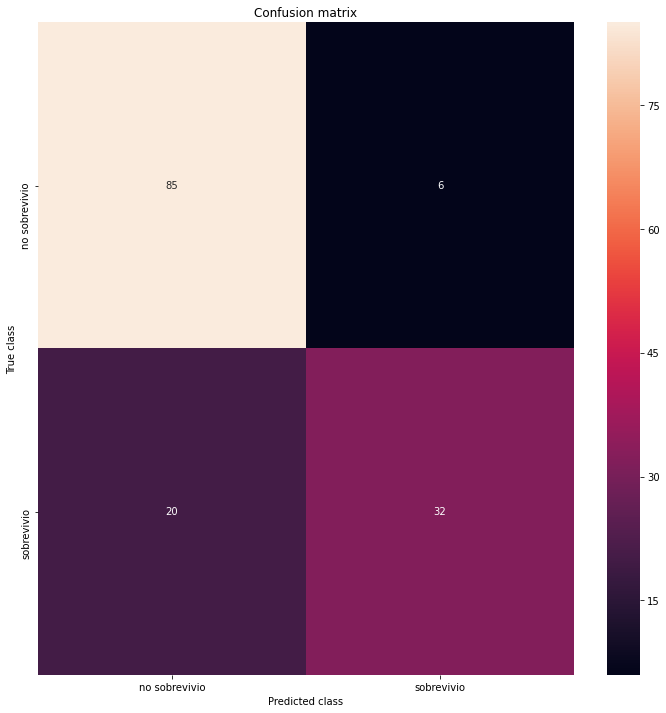

verdaderos positivos: 32
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 20
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        91
           1       0.84      0.62      0.71        52

    accuracy                           0.82       143
   macro avg       0.83      0.77      0.79       143
weighted avg       0.82      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.799649      0.818182
Precision       0.854305      0.842105
Recall:         0.583710      0.615385
F1_Score:       0.693548      0.711111


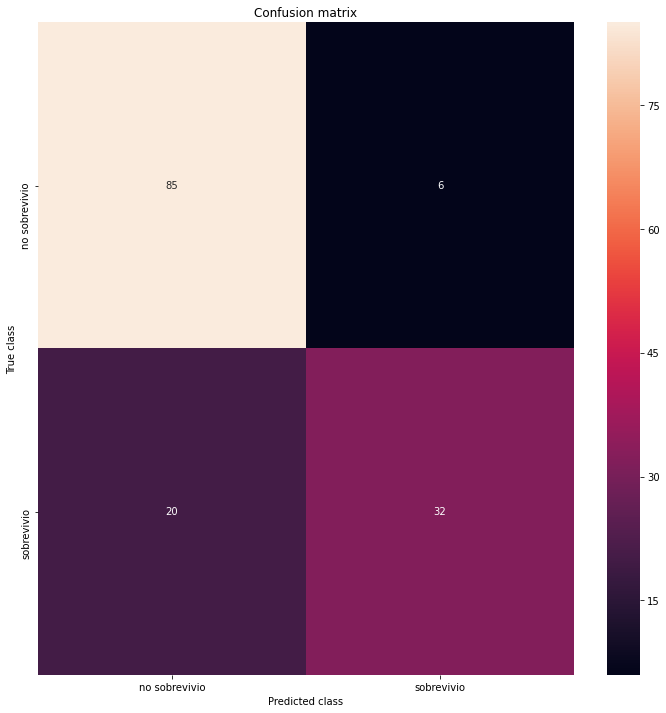

verdaderos positivos: 32
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 20
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        91
           1       0.84      0.62      0.71        52

    accuracy                           0.82       143
   macro avg       0.83      0.77      0.79       143
weighted avg       0.82      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.799649      0.818182
Precision       0.854305      0.842105
Recall:         0.583710      0.615385
F1_Score:       0.693548      0.711111


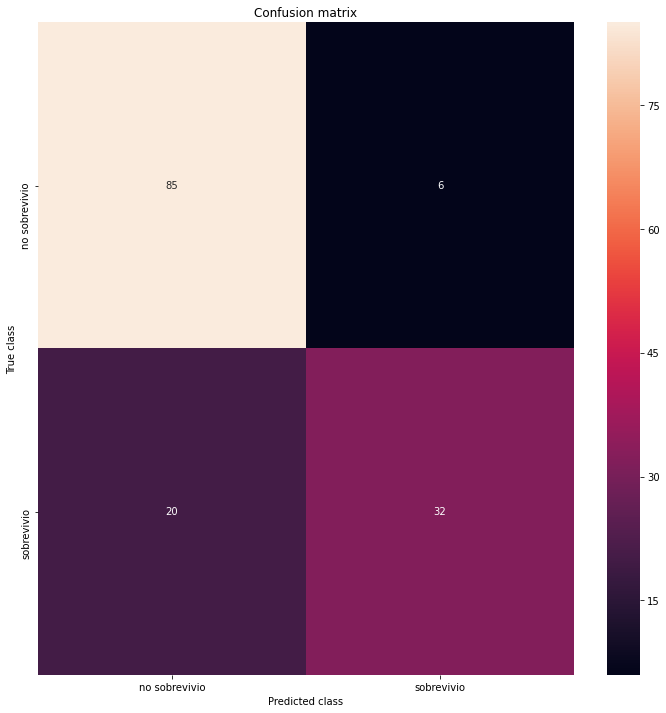

verdaderos positivos: 32
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 20
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        91
           1       0.84      0.62      0.71        52

    accuracy                           0.82       143
   macro avg       0.83      0.77      0.79       143
weighted avg       0.82      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.799649      0.818182
Precision       0.854305      0.842105
Recall:         0.583710      0.615385
F1_Score:       0.693548      0.711111


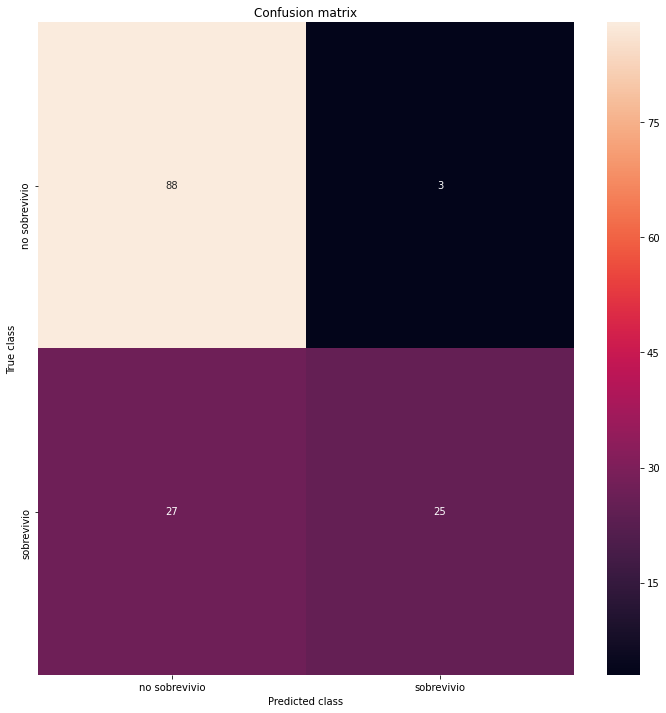

verdaderos positivos: 25
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.77      0.97      0.85        91
           1       0.89      0.48      0.62        52

    accuracy                           0.79       143
   macro avg       0.83      0.72      0.74       143
weighted avg       0.81      0.79      0.77       143

           metrics_train  metrics_test
Accuracy        0.776801      0.790210
Precision       0.951923      0.892857
Recall:         0.447964      0.480769
F1_Score:       0.609231      0.625000


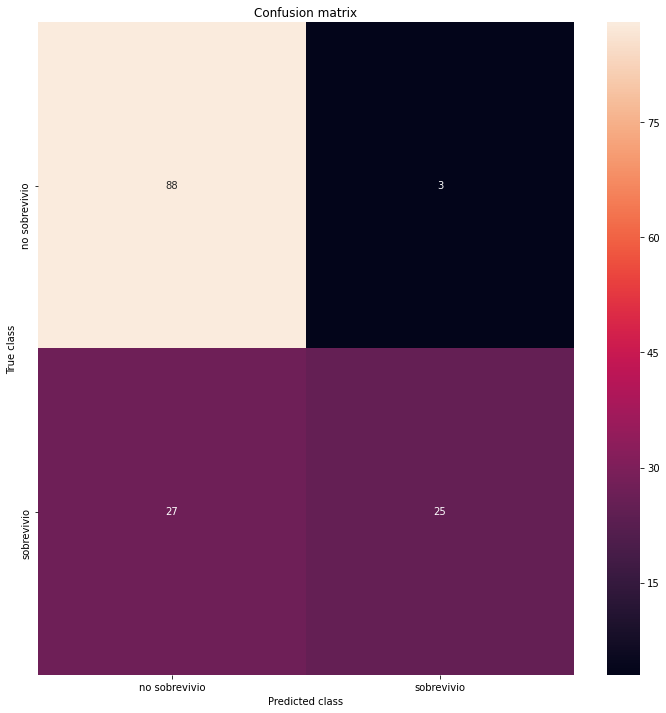

verdaderos positivos: 25
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.77      0.97      0.85        91
           1       0.89      0.48      0.62        52

    accuracy                           0.79       143
   macro avg       0.83      0.72      0.74       143
weighted avg       0.81      0.79      0.77       143

           metrics_train  metrics_test
Accuracy        0.776801      0.790210
Precision       0.951923      0.892857
Recall:         0.447964      0.480769
F1_Score:       0.609231      0.625000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.794702
Training accuracy: 0.438%
loss at step 1000: 0.524786
Training accuracy: 0.620%
Test accuracy: 0.825%


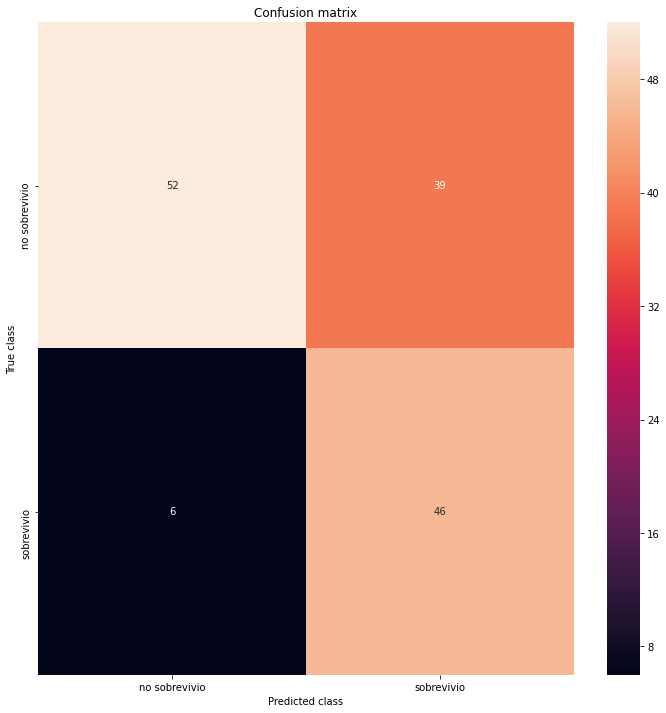

verdaderos positivos: 46
falsos positivos: 39
verdaderos negativos: 52
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.90      0.57      0.70        91
           1       0.54      0.88      0.67        52

    accuracy                           0.69       143
   macro avg       0.72      0.73      0.68       143
weighted avg       0.77      0.69      0.69       143

           metrics_train  metrics_test
Accuracy        0.660808      0.685315
Precision       0.540462      0.541176
Recall:         0.846154      0.884615
F1_Score:       0.659612      0.671533


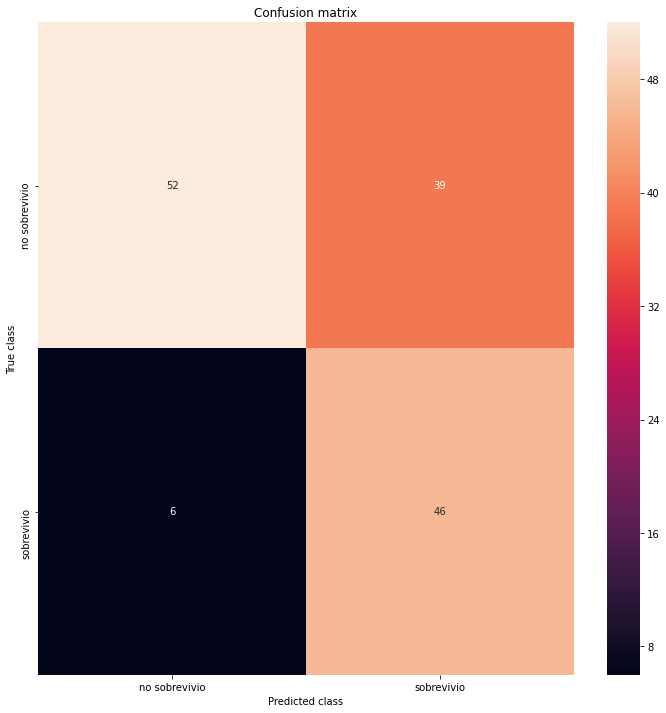

verdaderos positivos: 46
falsos positivos: 39
verdaderos negativos: 52
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.90      0.57      0.70        91
           1       0.54      0.88      0.67        52

    accuracy                           0.69       143
   macro avg       0.72      0.73      0.68       143
weighted avg       0.77      0.69      0.69       143

           metrics_train  metrics_test
Accuracy        0.660808      0.685315
Precision       0.540462      0.541176
Recall:         0.846154      0.884615
F1_Score:       0.659612      0.671533


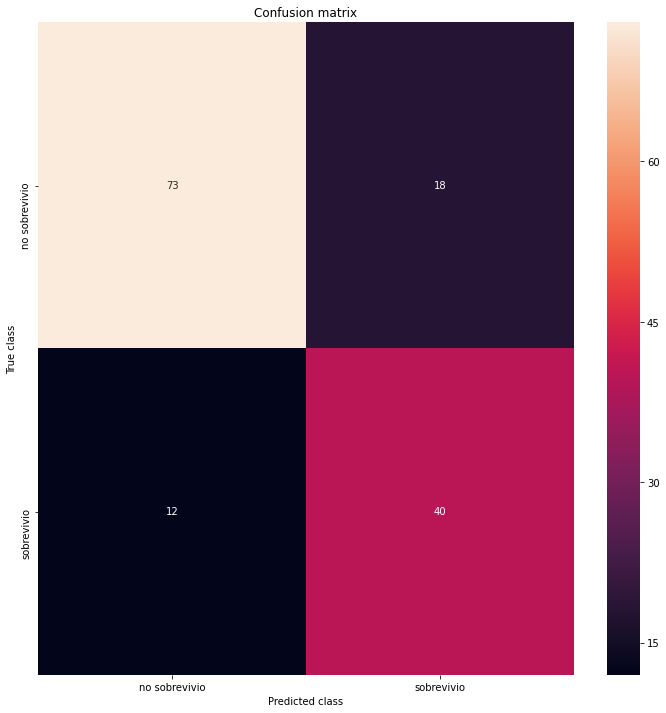

verdaderos positivos: 40
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 12
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        91
           1       0.69      0.77      0.73        52

    accuracy                           0.79       143
   macro avg       0.77      0.79      0.78       143
weighted avg       0.80      0.79      0.79       143

           metrics_train  metrics_test
Accuracy        0.753954      0.790210
Precision       0.669456      0.689655
Recall:         0.723982      0.769231
F1_Score:       0.695652      0.727273


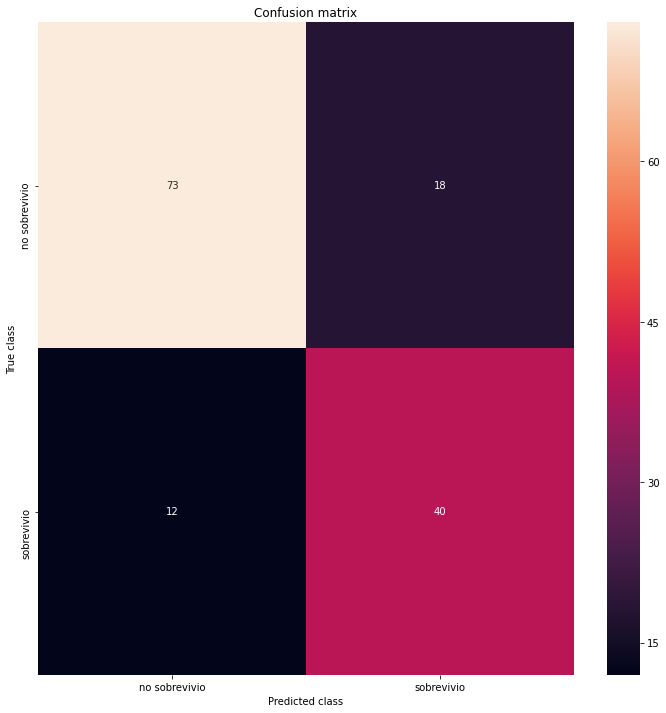

verdaderos positivos: 40
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 12
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        91
           1       0.69      0.77      0.73        52

    accuracy                           0.79       143
   macro avg       0.77      0.79      0.78       143
weighted avg       0.80      0.79      0.79       143

           metrics_train  metrics_test
Accuracy        0.757469      0.790210
Precision       0.675105      0.689655
Recall:         0.723982      0.769231
F1_Score:       0.698690      0.727273


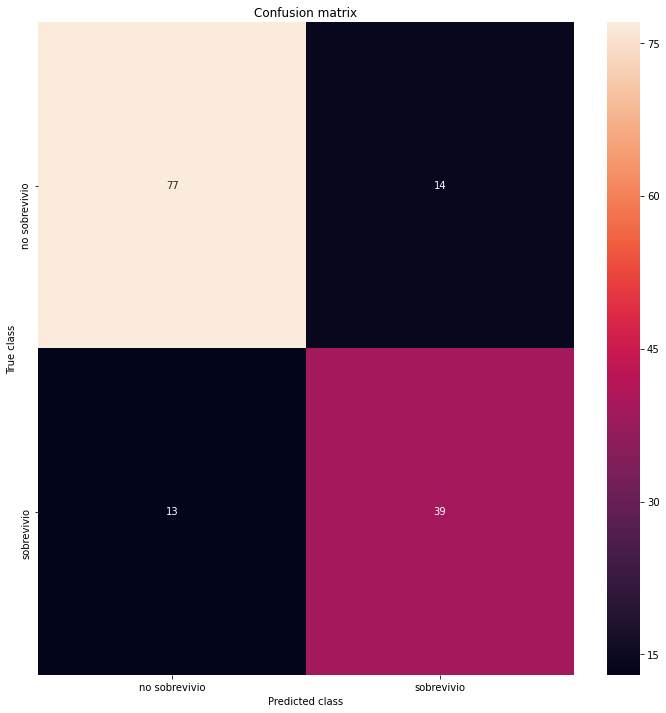

verdaderos positivos: 39
falsos positivos: 14
verdaderos negativos: 77
falsos negativos: 13
              precision    recall  f1-score   support

           0       0.86      0.85      0.85        91
           1       0.74      0.75      0.74        52

    accuracy                           0.81       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.81      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.773286      0.811189
Precision       0.719048      0.735849
Recall:         0.683258      0.750000
F1_Score:       0.700696      0.742857


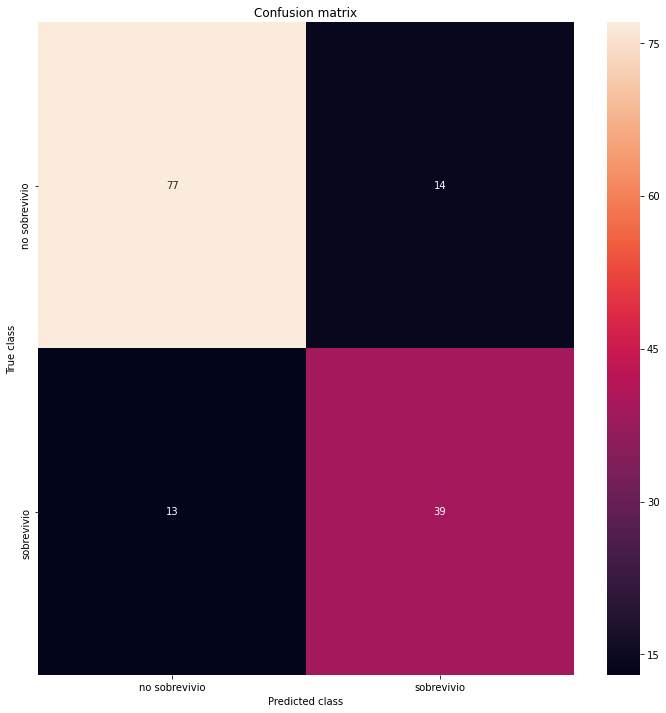

verdaderos positivos: 39
falsos positivos: 14
verdaderos negativos: 77
falsos negativos: 13
              precision    recall  f1-score   support

           0       0.86      0.85      0.85        91
           1       0.74      0.75      0.74        52

    accuracy                           0.81       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.81      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.773286      0.811189
Precision       0.719048      0.735849
Recall:         0.683258      0.750000
F1_Score:       0.700696      0.742857


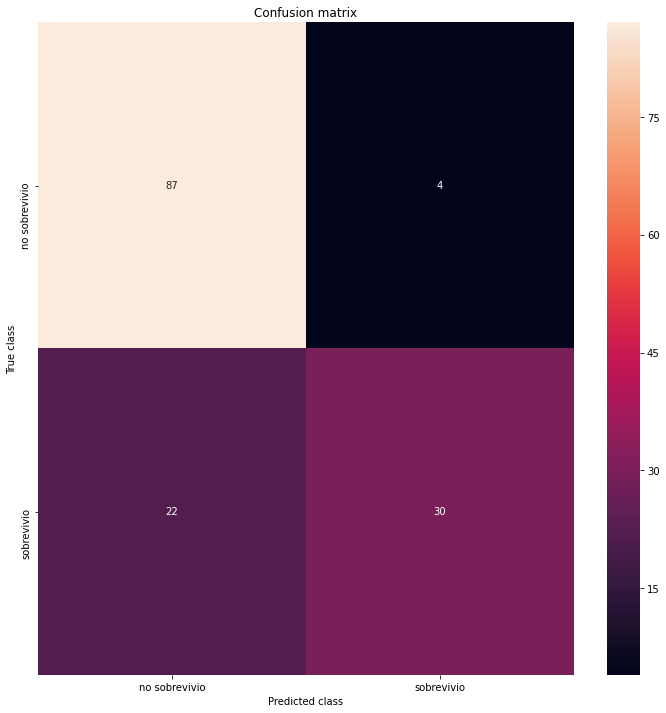

verdaderos positivos: 30
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 22
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        91
           1       0.88      0.58      0.70        52

    accuracy                           0.82       143
   macro avg       0.84      0.77      0.78       143
weighted avg       0.83      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.797891      0.818182
Precision       0.920635      0.882353
Recall:         0.524887      0.576923
F1_Score:       0.668588      0.697674


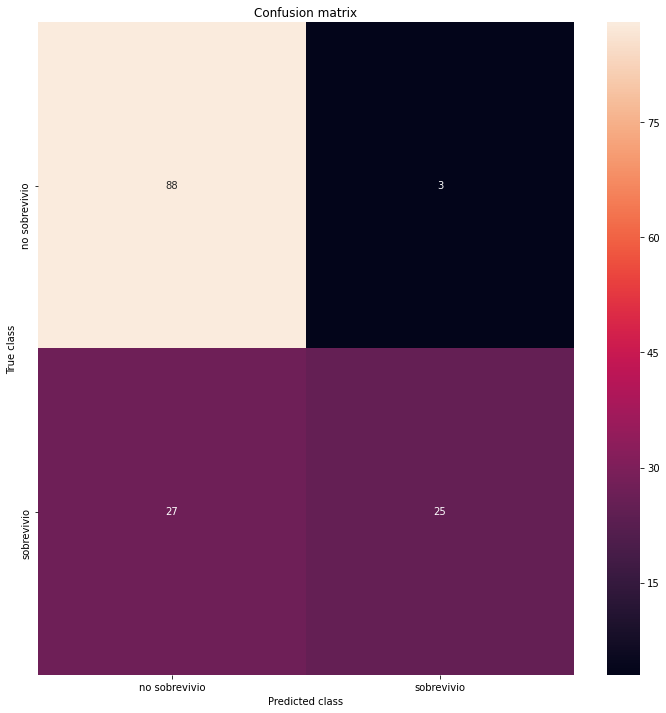

verdaderos positivos: 25
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.77      0.97      0.85        91
           1       0.89      0.48      0.62        52

    accuracy                           0.79       143
   macro avg       0.83      0.72      0.74       143
weighted avg       0.81      0.79      0.77       143

           metrics_train  metrics_test
Accuracy        0.776801      0.790210
Precision       0.951923      0.892857
Recall:         0.447964      0.480769
F1_Score:       0.609231      0.625000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.809017
Training accuracy: 0.351%
loss at step 1000: 0.679352
Training accuracy: 0.567%
Test accuracy: 0.797%


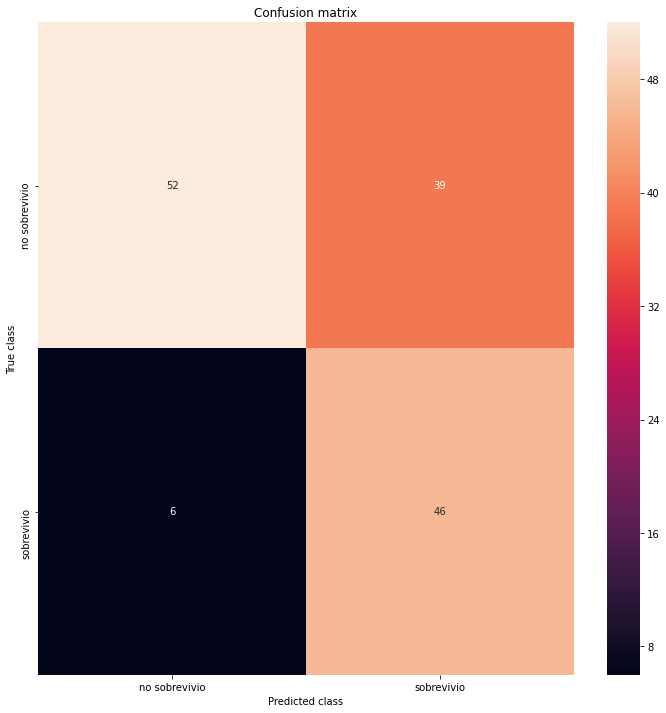

verdaderos positivos: 46
falsos positivos: 39
verdaderos negativos: 52
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.90      0.57      0.70        91
           1       0.54      0.88      0.67        52

    accuracy                           0.69       143
   macro avg       0.72      0.73      0.68       143
weighted avg       0.77      0.69      0.69       143

           metrics_train  metrics_test
Accuracy        0.660808      0.685315
Precision       0.540462      0.541176
Recall:         0.846154      0.884615
F1_Score:       0.659612      0.671533


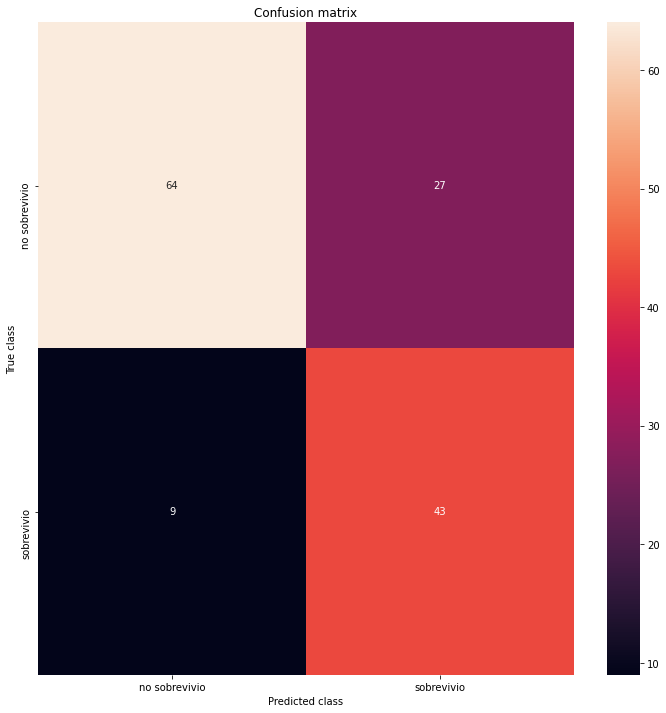

verdaderos positivos: 43
falsos positivos: 27
verdaderos negativos: 64
falsos negativos: 9
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        91
           1       0.61      0.83      0.70        52

    accuracy                           0.75       143
   macro avg       0.75      0.77      0.74       143
weighted avg       0.78      0.75      0.75       143

           metrics_train  metrics_test
Accuracy        0.746924      0.748252
Precision       0.645283      0.614286
Recall:         0.773756      0.826923
F1_Score:       0.703704      0.704918


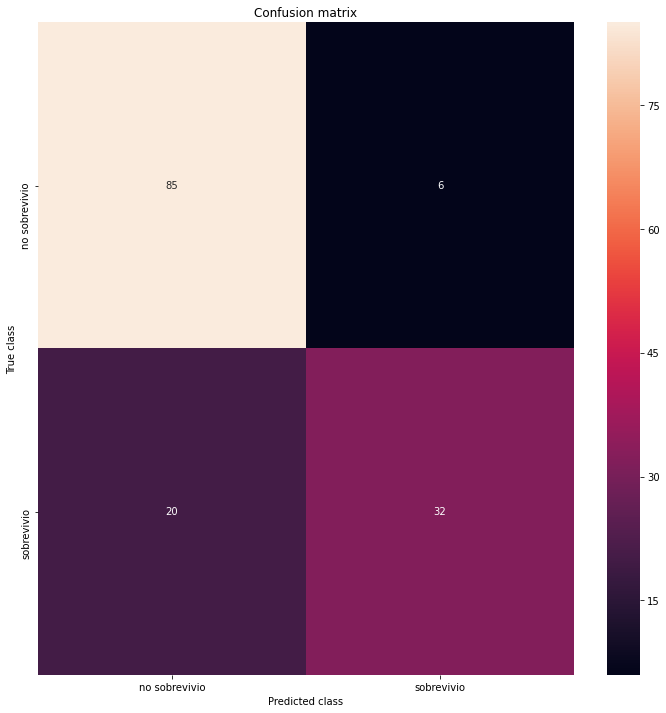

verdaderos positivos: 32
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 20
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        91
           1       0.84      0.62      0.71        52

    accuracy                           0.82       143
   macro avg       0.83      0.77      0.79       143
weighted avg       0.82      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.799649      0.818182
Precision       0.840764      0.842105
Recall:         0.597285      0.615385
F1_Score:       0.698413      0.711111


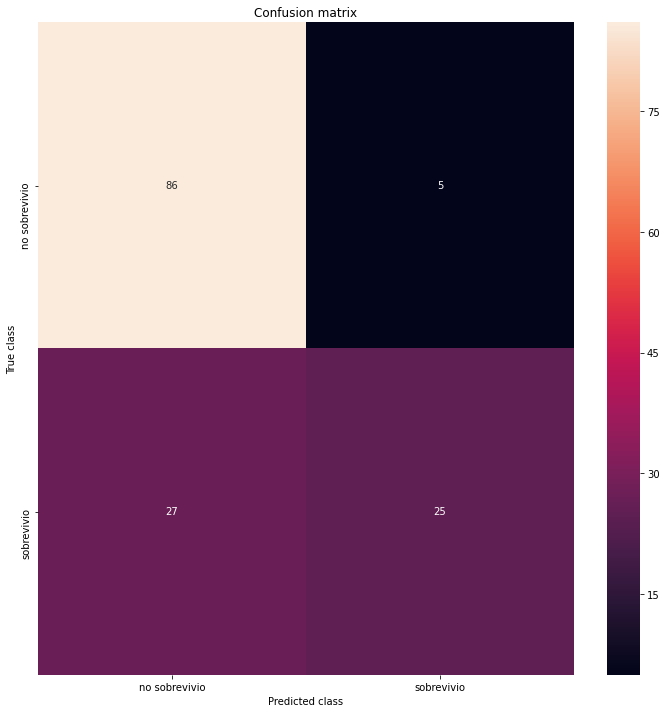

verdaderos positivos: 25
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.76      0.95      0.84        91
           1       0.83      0.48      0.61        52

    accuracy                           0.78       143
   macro avg       0.80      0.71      0.73       143
weighted avg       0.79      0.78      0.76       143

           metrics_train  metrics_test
Accuracy        0.773286      0.776224
Precision       0.889831      0.833333
Recall:         0.475113      0.480769
F1_Score:       0.619469      0.609756


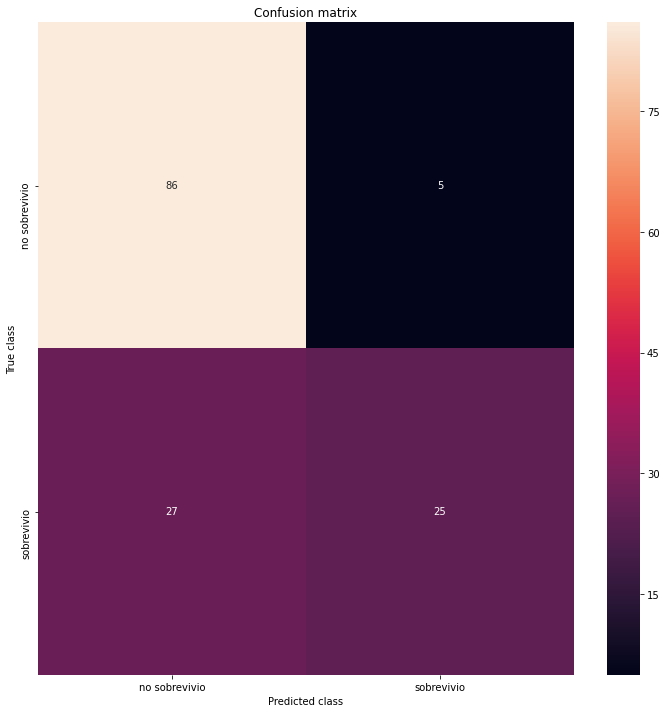

verdaderos positivos: 25
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.76      0.95      0.84        91
           1       0.83      0.48      0.61        52

    accuracy                           0.78       143
   macro avg       0.80      0.71      0.73       143
weighted avg       0.79      0.78      0.76       143

           metrics_train  metrics_test
Accuracy        0.773286      0.776224
Precision       0.889831      0.833333
Recall:         0.475113      0.480769
F1_Score:       0.619469      0.609756


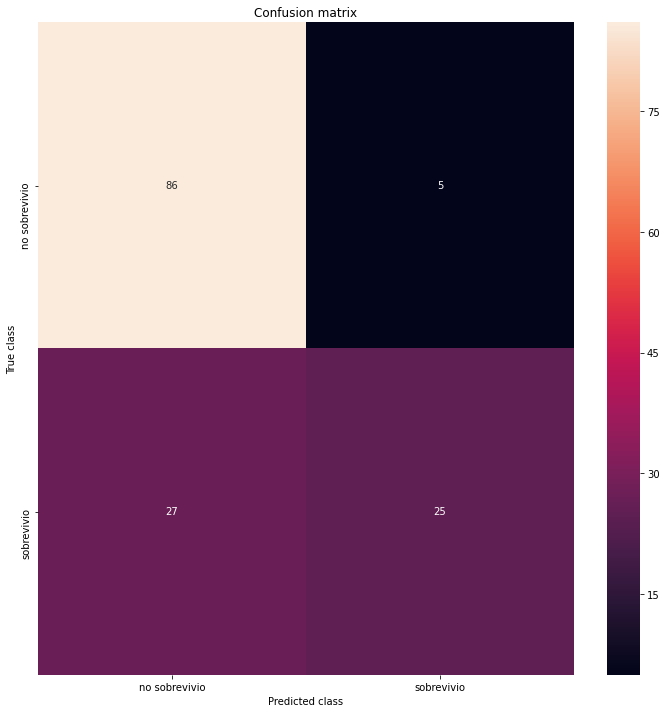

verdaderos positivos: 25
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.76      0.95      0.84        91
           1       0.83      0.48      0.61        52

    accuracy                           0.78       143
   macro avg       0.80      0.71      0.73       143
weighted avg       0.79      0.78      0.76       143

           metrics_train  metrics_test
Accuracy        0.773286      0.776224
Precision       0.889831      0.833333
Recall:         0.475113      0.480769
F1_Score:       0.619469      0.609756


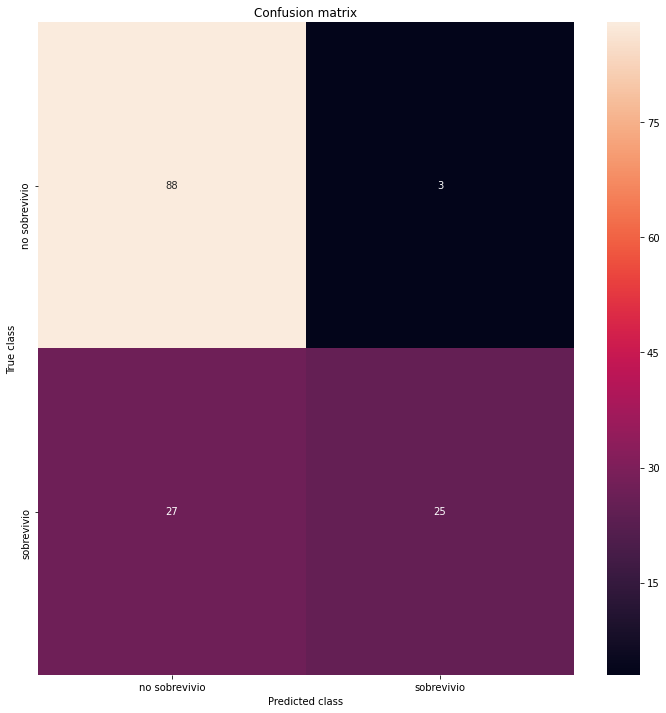

verdaderos positivos: 25
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.77      0.97      0.85        91
           1       0.89      0.48      0.62        52

    accuracy                           0.79       143
   macro avg       0.83      0.72      0.74       143
weighted avg       0.81      0.79      0.77       143

           metrics_train  metrics_test
Accuracy        0.776801      0.790210
Precision       0.951923      0.892857
Recall:         0.447964      0.480769
F1_Score:       0.609231      0.625000


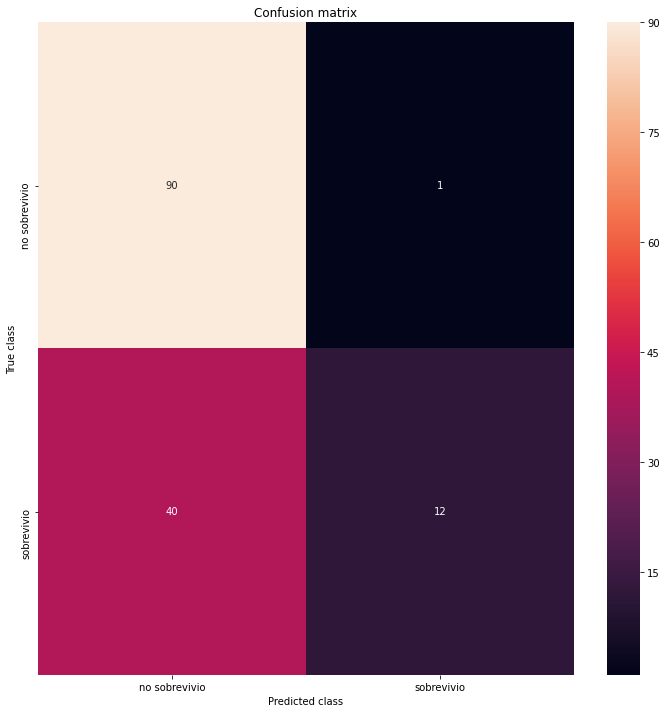

verdaderos positivos: 12
falsos positivos: 1
verdaderos negativos: 90
falsos negativos: 40
              precision    recall  f1-score   support

           0       0.69      0.99      0.81        91
           1       0.92      0.23      0.37        52

    accuracy                           0.71       143
   macro avg       0.81      0.61      0.59       143
weighted avg       0.78      0.71      0.65       143

           metrics_train  metrics_test
Accuracy        0.673111      0.713287
Precision       0.948718      0.923077
Recall:         0.167421      0.230769
F1_Score:       0.284615      0.369231
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.804136
Training accuracy: 0.482%
loss at step 1000: 0.564251
Training accuracy: 0.642%
Test accuracy: 0.832%


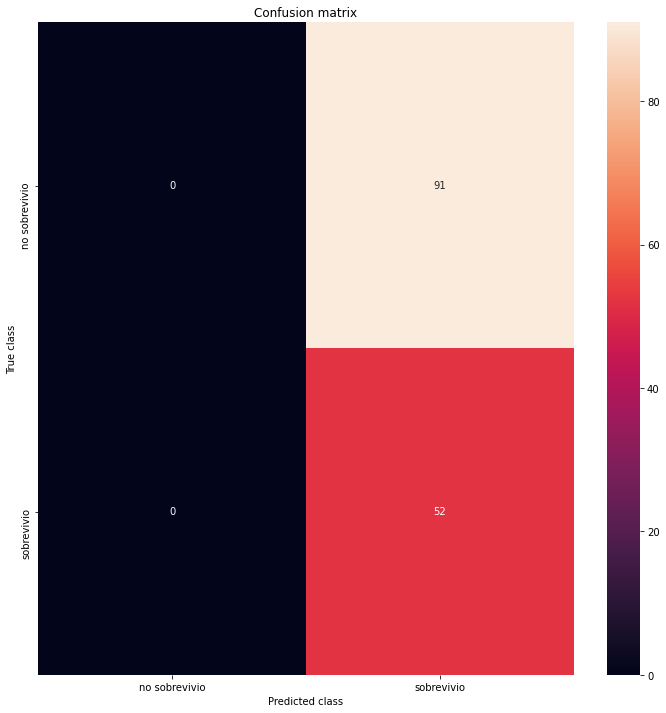

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


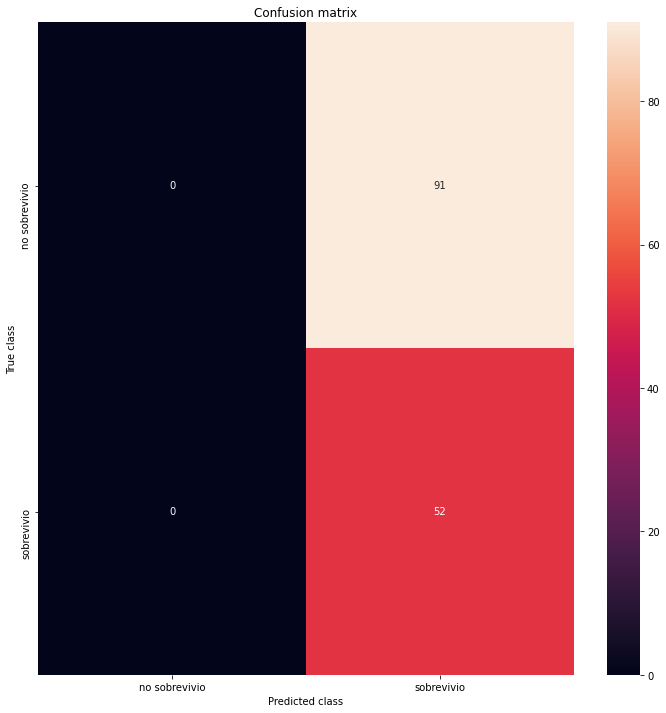

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


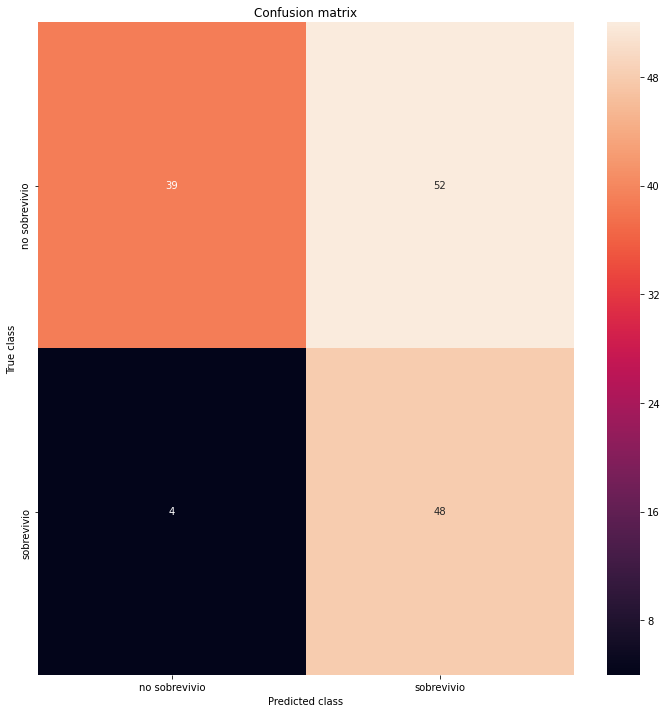

verdaderos positivos: 48
falsos positivos: 52
verdaderos negativos: 39
falsos negativos: 4
              precision    recall  f1-score   support

           0       0.91      0.43      0.58        91
           1       0.48      0.92      0.63        52

    accuracy                           0.61       143
   macro avg       0.69      0.68      0.61       143
weighted avg       0.75      0.61      0.60       143

           metrics_train  metrics_test
Accuracy        0.601054      0.608392
Precision       0.492424      0.480000
Recall:         0.882353      0.923077
F1_Score:       0.632091      0.631579


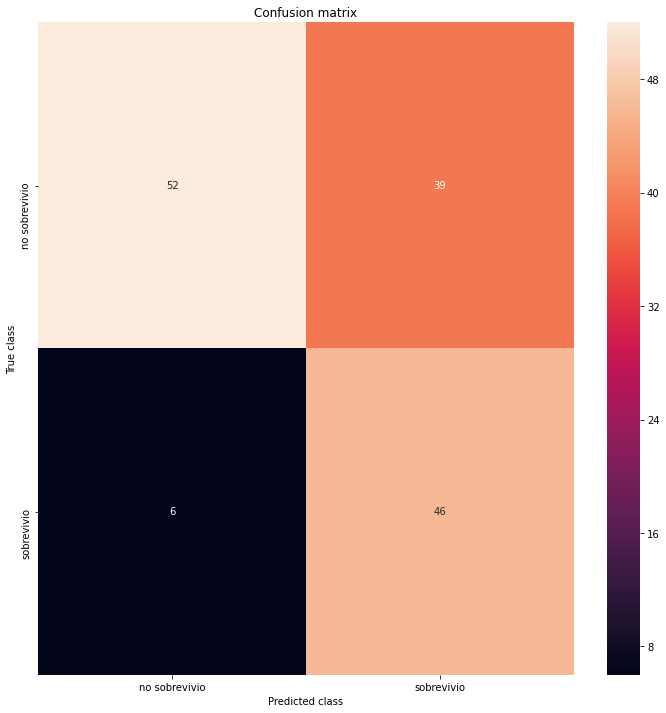

verdaderos positivos: 46
falsos positivos: 39
verdaderos negativos: 52
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.90      0.57      0.70        91
           1       0.54      0.88      0.67        52

    accuracy                           0.69       143
   macro avg       0.72      0.73      0.68       143
weighted avg       0.77      0.69      0.69       143

           metrics_train  metrics_test
Accuracy        0.660808      0.685315
Precision       0.540462      0.541176
Recall:         0.846154      0.884615
F1_Score:       0.659612      0.671533


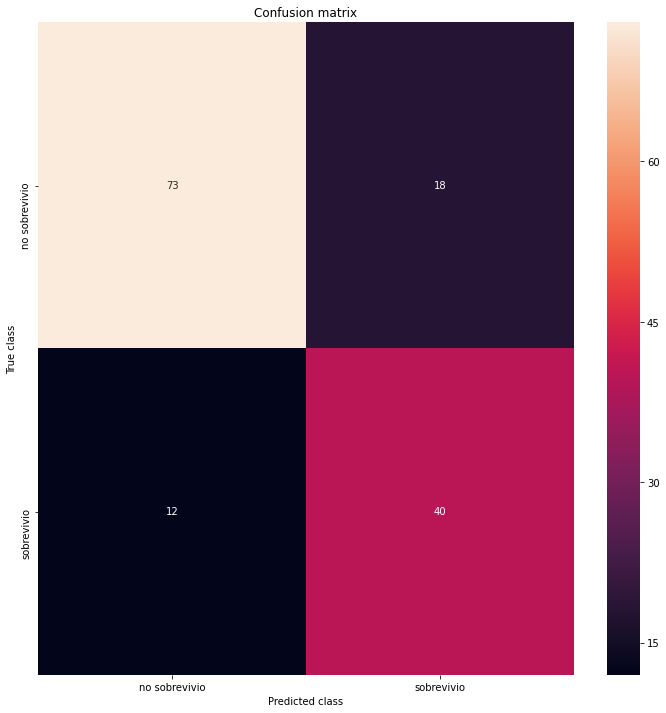

verdaderos positivos: 40
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 12
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        91
           1       0.69      0.77      0.73        52

    accuracy                           0.79       143
   macro avg       0.77      0.79      0.78       143
weighted avg       0.80      0.79      0.79       143

           metrics_train  metrics_test
Accuracy        0.757469      0.790210
Precision       0.675105      0.689655
Recall:         0.723982      0.769231
F1_Score:       0.698690      0.727273


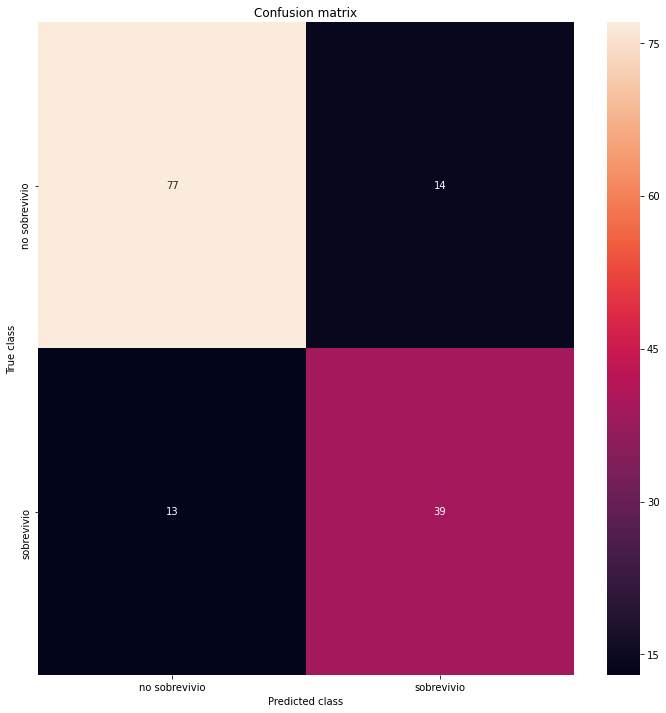

verdaderos positivos: 39
falsos positivos: 14
verdaderos negativos: 77
falsos negativos: 13
              precision    recall  f1-score   support

           0       0.86      0.85      0.85        91
           1       0.74      0.75      0.74        52

    accuracy                           0.81       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.81      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.773286      0.811189
Precision       0.719048      0.735849
Recall:         0.683258      0.750000
F1_Score:       0.700696      0.742857


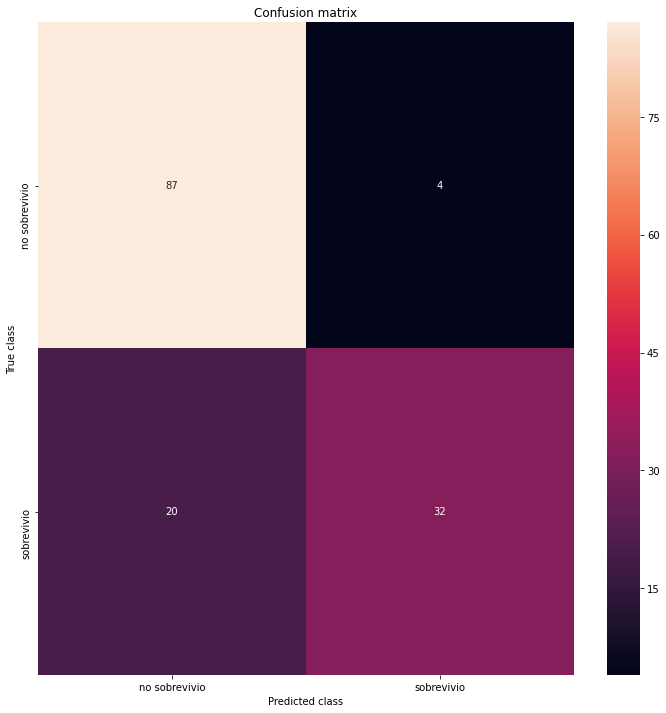

verdaderos positivos: 32
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 20
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        91
           1       0.89      0.62      0.73        52

    accuracy                           0.83       143
   macro avg       0.85      0.79      0.80       143
weighted avg       0.84      0.83      0.82       143

           metrics_train  metrics_test
Accuracy        0.803163      0.832168
Precision       0.881119      0.888889
Recall:         0.570136      0.615385
F1_Score:       0.692308      0.727273


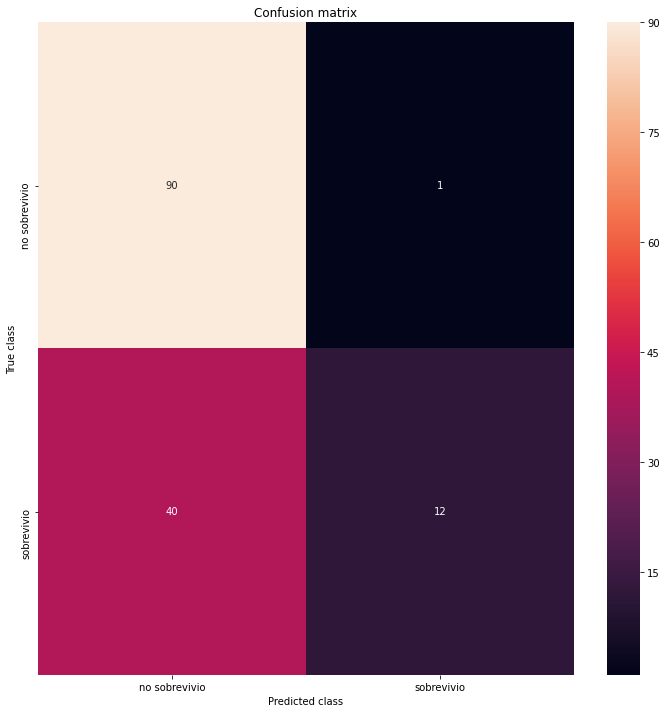

verdaderos positivos: 12
falsos positivos: 1
verdaderos negativos: 90
falsos negativos: 40
              precision    recall  f1-score   support

           0       0.69      0.99      0.81        91
           1       0.92      0.23      0.37        52

    accuracy                           0.71       143
   macro avg       0.81      0.61      0.59       143
weighted avg       0.78      0.71      0.65       143

           metrics_train  metrics_test
Accuracy        0.673111      0.713287
Precision       0.948718      0.923077
Recall:         0.167421      0.230769
F1_Score:       0.284615      0.369231
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.834473
Training accuracy: 0.351%
loss at step 1000: 0.700331
Training accuracy: 0.496%
Test accuracy: 0.664%


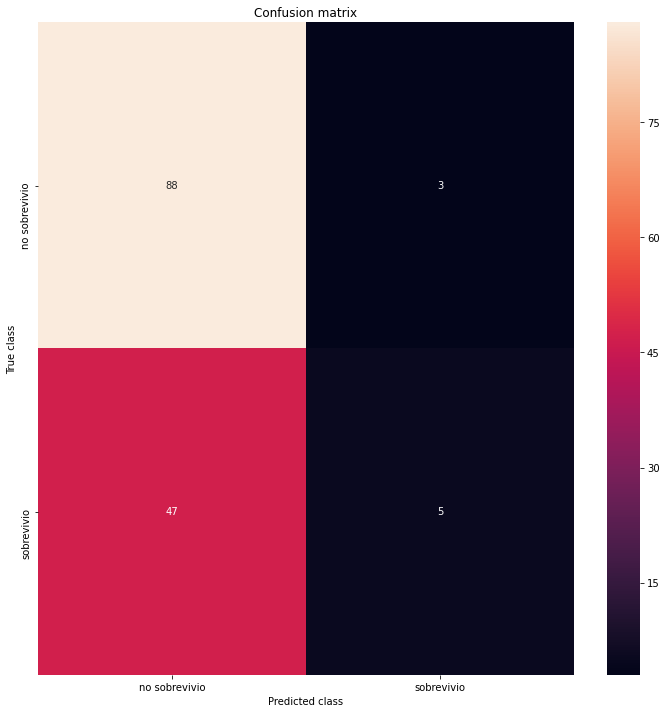

verdaderos positivos: 5
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 47
              precision    recall  f1-score   support

           0       0.65      0.97      0.78        91
           1       0.62      0.10      0.17        52

    accuracy                           0.65       143
   macro avg       0.64      0.53      0.47       143
weighted avg       0.64      0.65      0.56       143

           metrics_train  metrics_test
Accuracy        0.636204      0.650350
Precision       0.718750      0.625000
Recall:         0.104072      0.096154
F1_Score:       0.181818      0.166667


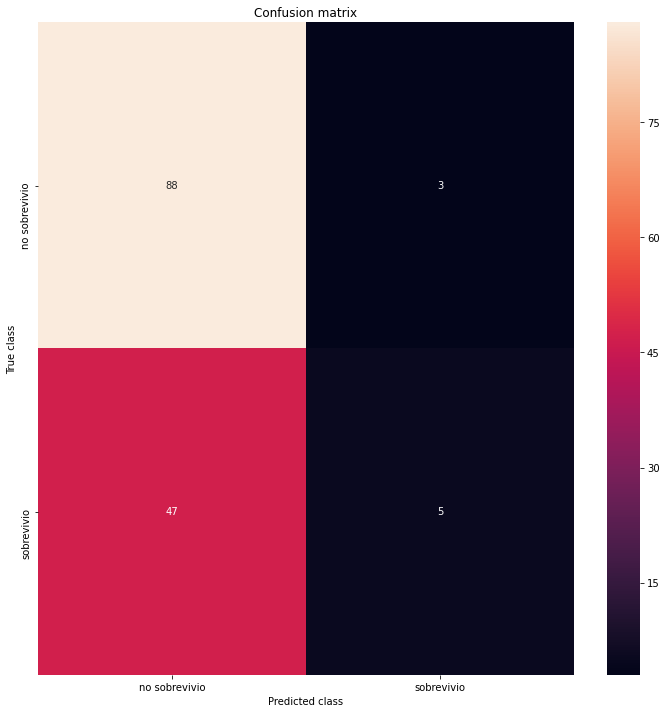

verdaderos positivos: 5
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 47
              precision    recall  f1-score   support

           0       0.65      0.97      0.78        91
           1       0.62      0.10      0.17        52

    accuracy                           0.65       143
   macro avg       0.64      0.53      0.47       143
weighted avg       0.64      0.65      0.56       143

           metrics_train  metrics_test
Accuracy        0.636204      0.650350
Precision       0.718750      0.625000
Recall:         0.104072      0.096154
F1_Score:       0.181818      0.166667


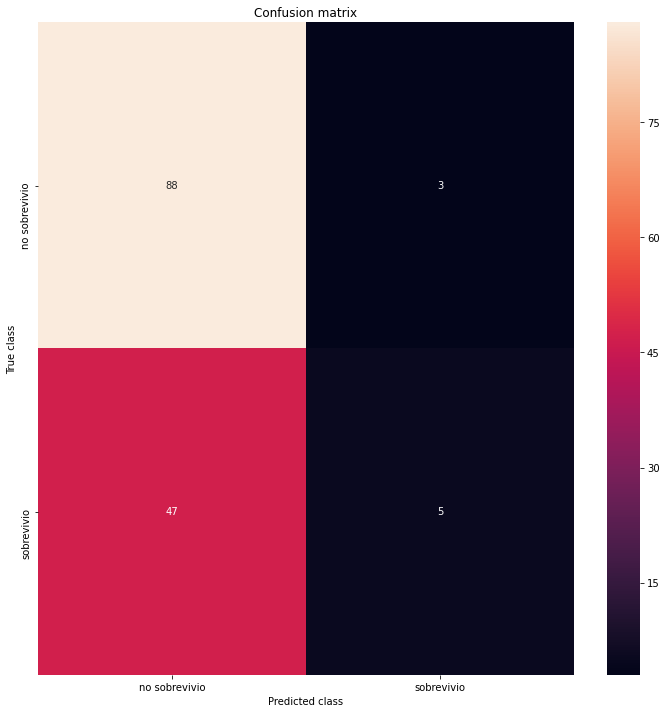

verdaderos positivos: 5
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 47
              precision    recall  f1-score   support

           0       0.65      0.97      0.78        91
           1       0.62      0.10      0.17        52

    accuracy                           0.65       143
   macro avg       0.64      0.53      0.47       143
weighted avg       0.64      0.65      0.56       143

           metrics_train  metrics_test
Accuracy        0.636204      0.650350
Precision       0.718750      0.625000
Recall:         0.104072      0.096154
F1_Score:       0.181818      0.166667


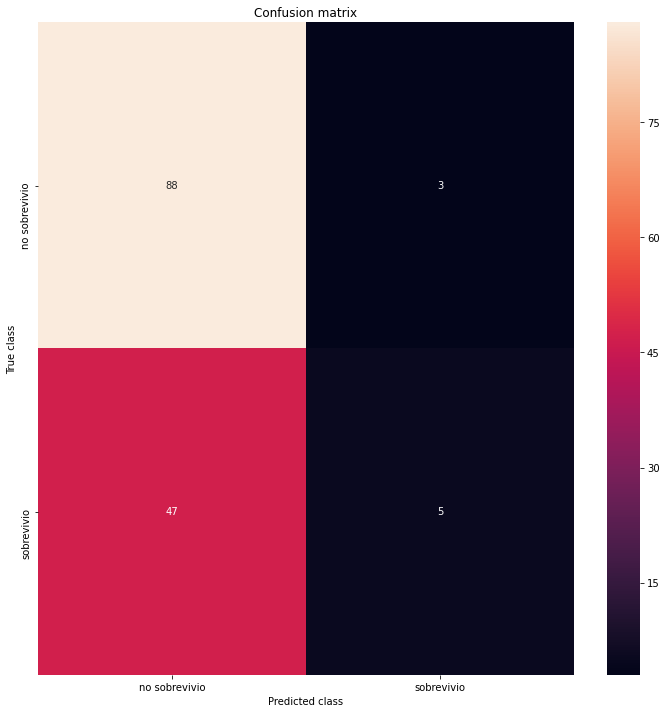

verdaderos positivos: 5
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 47
              precision    recall  f1-score   support

           0       0.65      0.97      0.78        91
           1       0.62      0.10      0.17        52

    accuracy                           0.65       143
   macro avg       0.64      0.53      0.47       143
weighted avg       0.64      0.65      0.56       143

           metrics_train  metrics_test
Accuracy        0.636204      0.650350
Precision       0.718750      0.625000
Recall:         0.104072      0.096154
F1_Score:       0.181818      0.166667


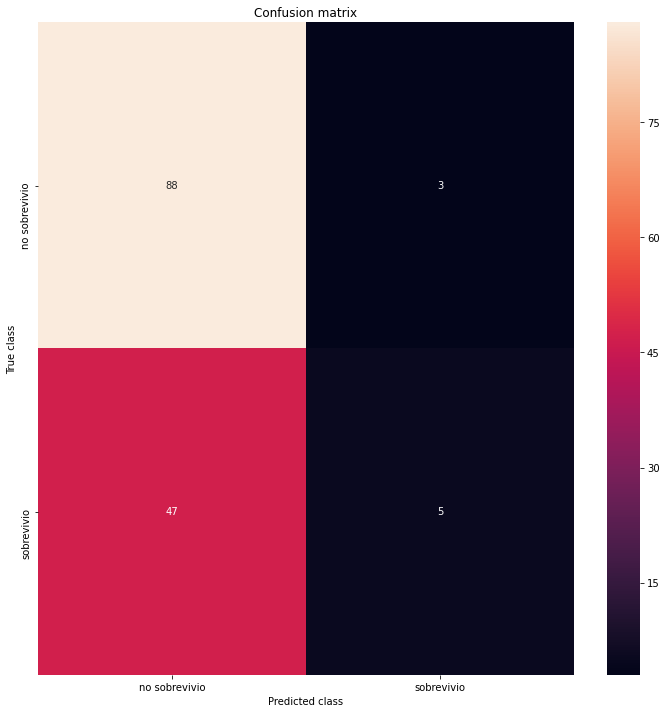

verdaderos positivos: 5
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 47
              precision    recall  f1-score   support

           0       0.65      0.97      0.78        91
           1       0.62      0.10      0.17        52

    accuracy                           0.65       143
   macro avg       0.64      0.53      0.47       143
weighted avg       0.64      0.65      0.56       143

           metrics_train  metrics_test
Accuracy        0.636204      0.650350
Precision       0.718750      0.625000
Recall:         0.104072      0.096154
F1_Score:       0.181818      0.166667


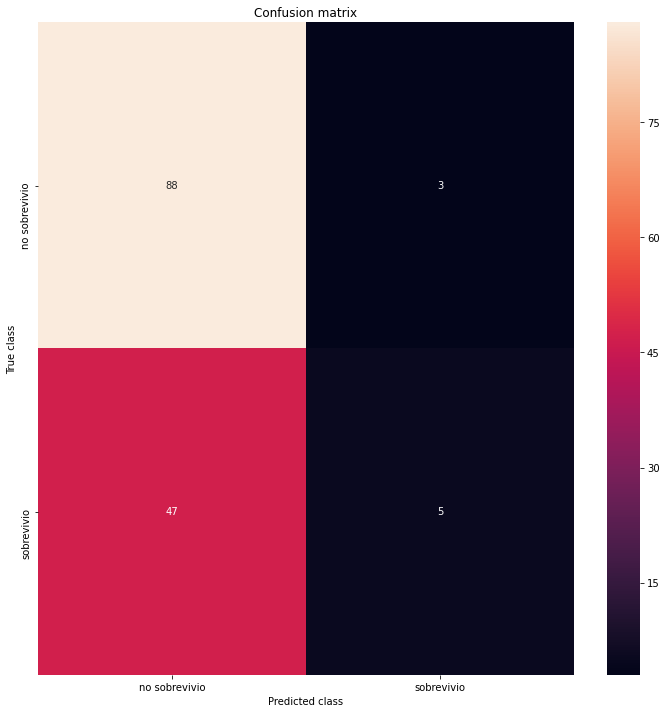

verdaderos positivos: 5
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 47
              precision    recall  f1-score   support

           0       0.65      0.97      0.78        91
           1       0.62      0.10      0.17        52

    accuracy                           0.65       143
   macro avg       0.64      0.53      0.47       143
weighted avg       0.64      0.65      0.56       143

           metrics_train  metrics_test
Accuracy        0.636204      0.650350
Precision       0.718750      0.625000
Recall:         0.104072      0.096154
F1_Score:       0.181818      0.166667


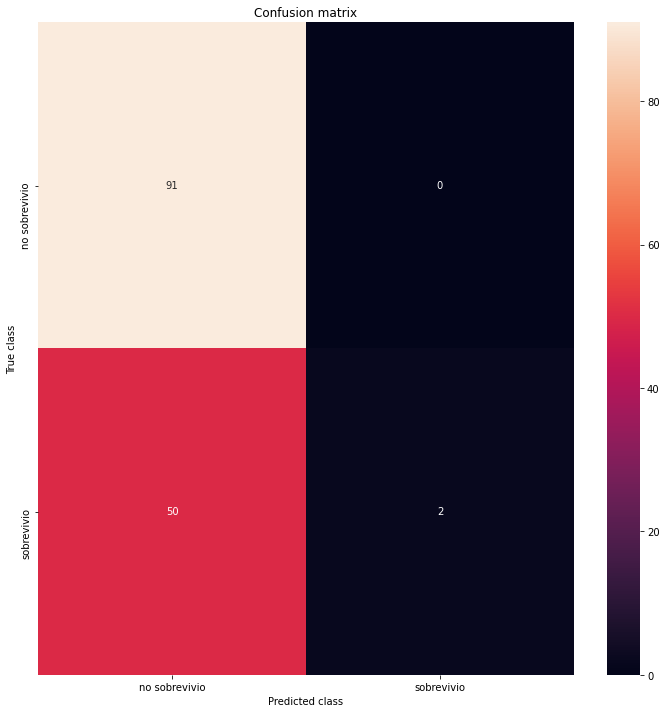

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


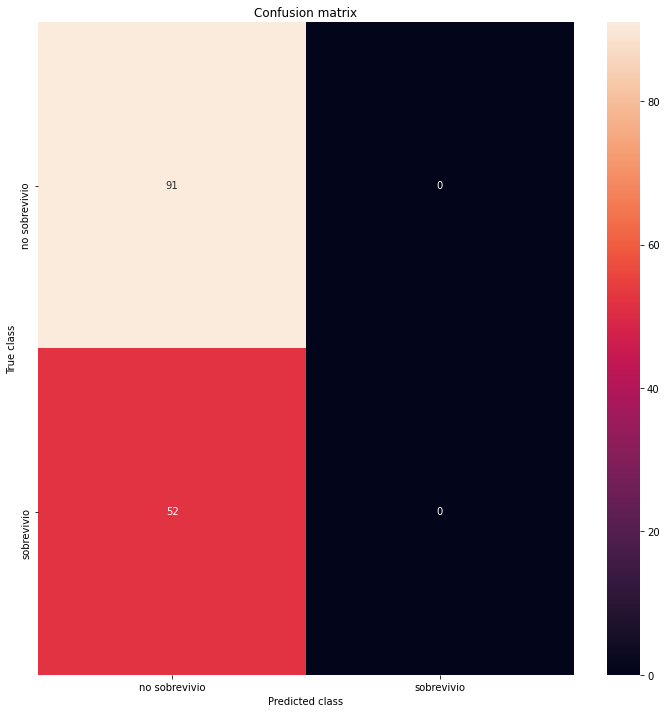

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.811548
Training accuracy: 0.485%
loss at step 1000: 0.590892
Training accuracy: 0.644%
Test accuracy: 0.832%


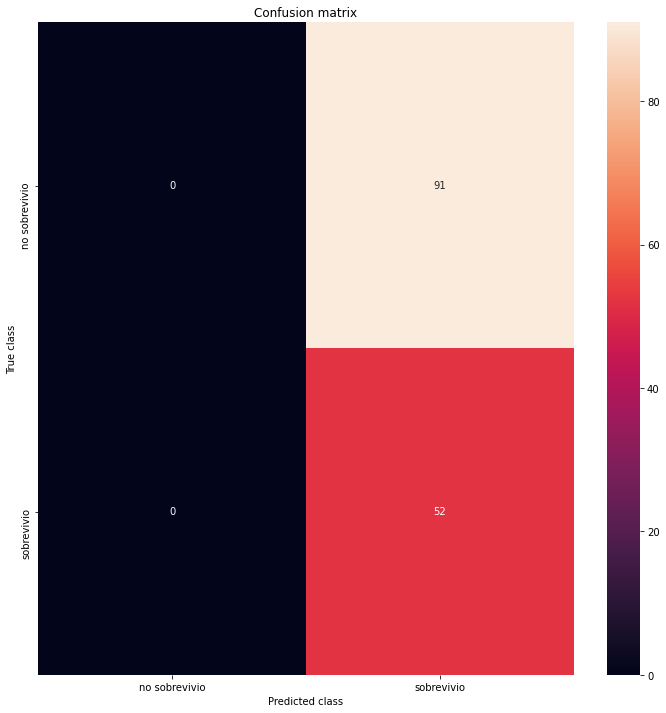

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


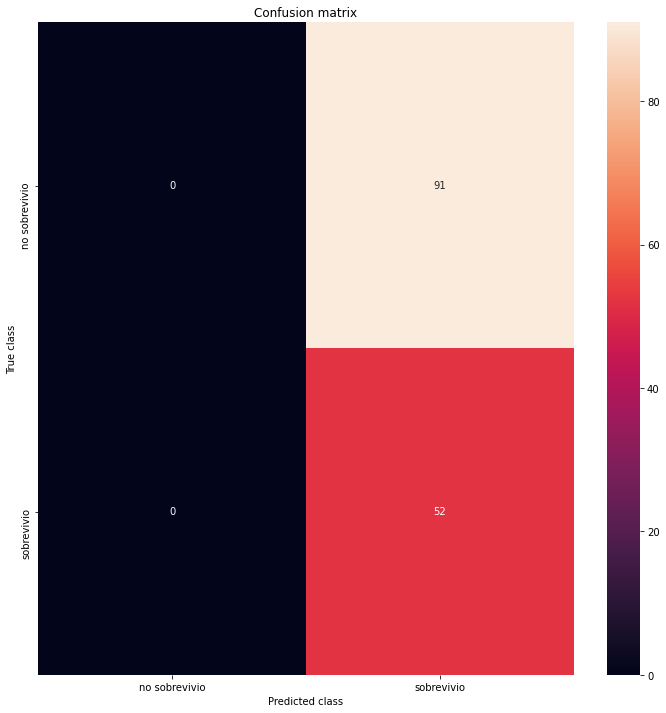

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


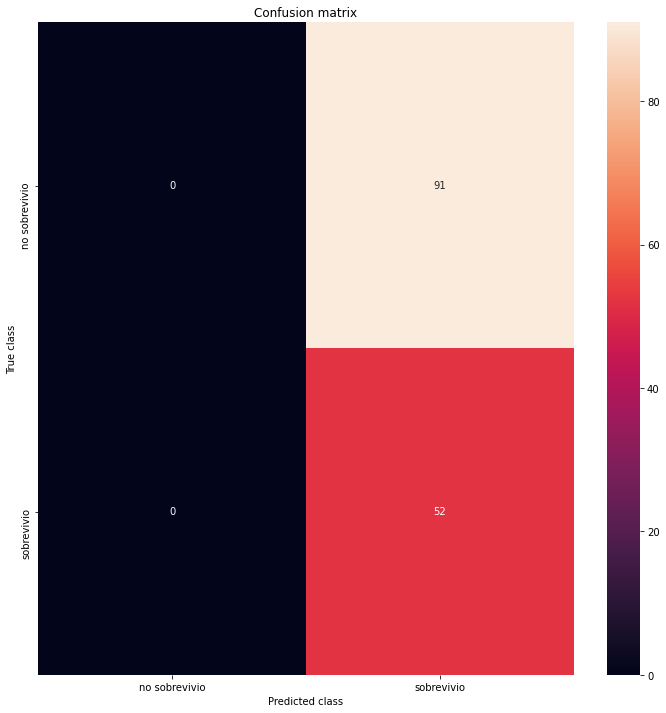

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


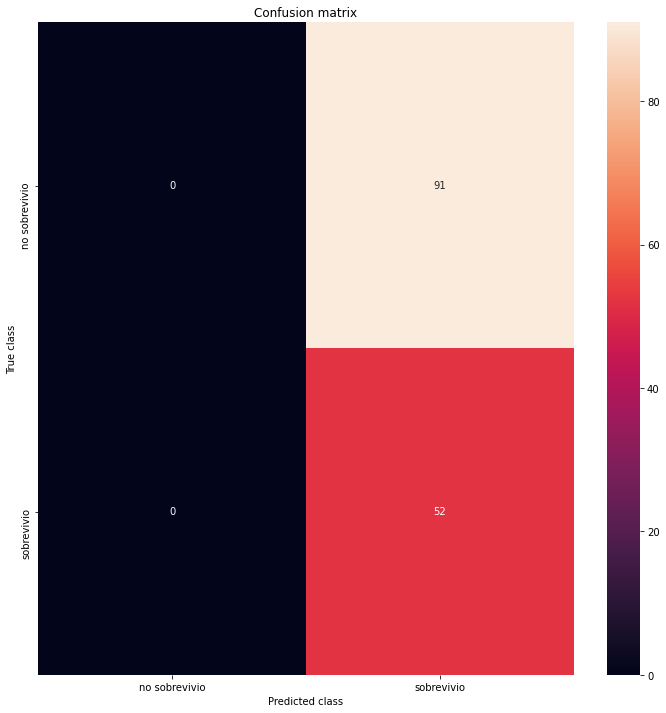

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


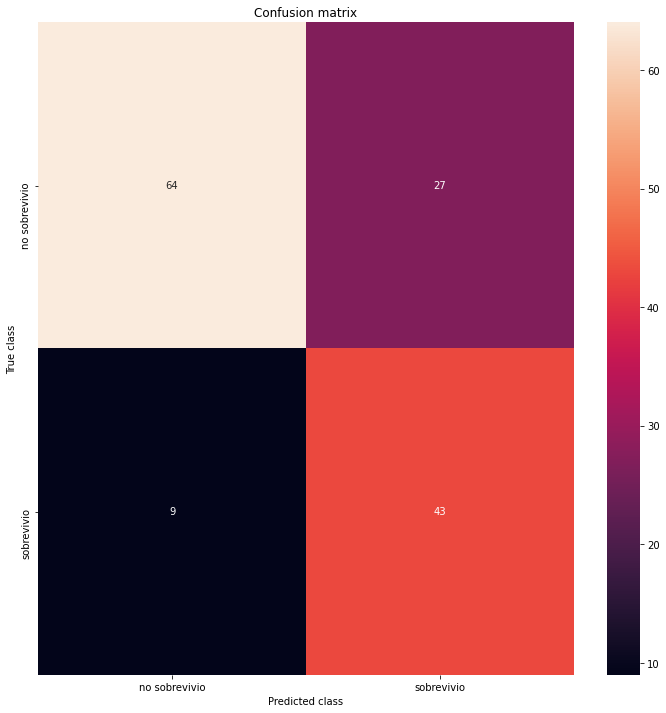

verdaderos positivos: 43
falsos positivos: 27
verdaderos negativos: 64
falsos negativos: 9
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        91
           1       0.61      0.83      0.70        52

    accuracy                           0.75       143
   macro avg       0.75      0.77      0.74       143
weighted avg       0.78      0.75      0.75       143

           metrics_train  metrics_test
Accuracy        0.743409      0.748252
Precision       0.640449      0.614286
Recall:         0.773756      0.826923
F1_Score:       0.700820      0.704918


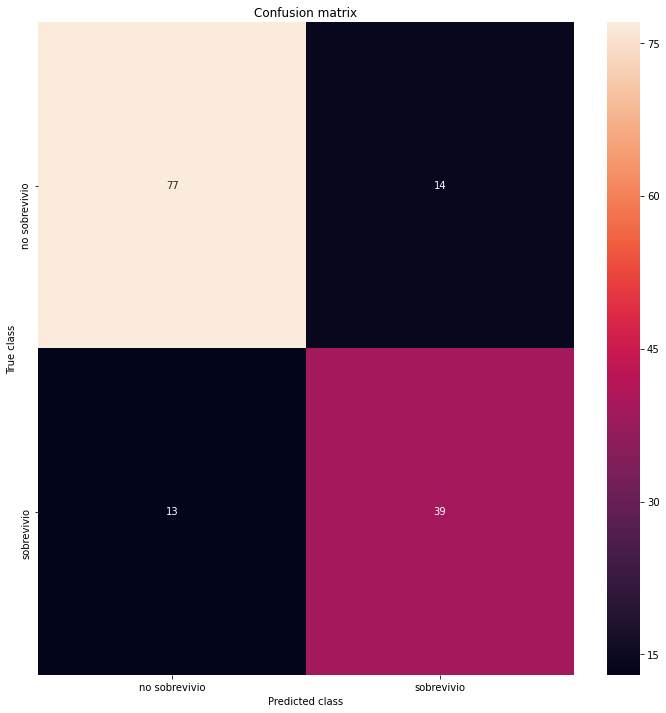

verdaderos positivos: 39
falsos positivos: 14
verdaderos negativos: 77
falsos negativos: 13
              precision    recall  f1-score   support

           0       0.86      0.85      0.85        91
           1       0.74      0.75      0.74        52

    accuracy                           0.81       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.81      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.773286      0.811189
Precision       0.719048      0.735849
Recall:         0.683258      0.750000
F1_Score:       0.700696      0.742857


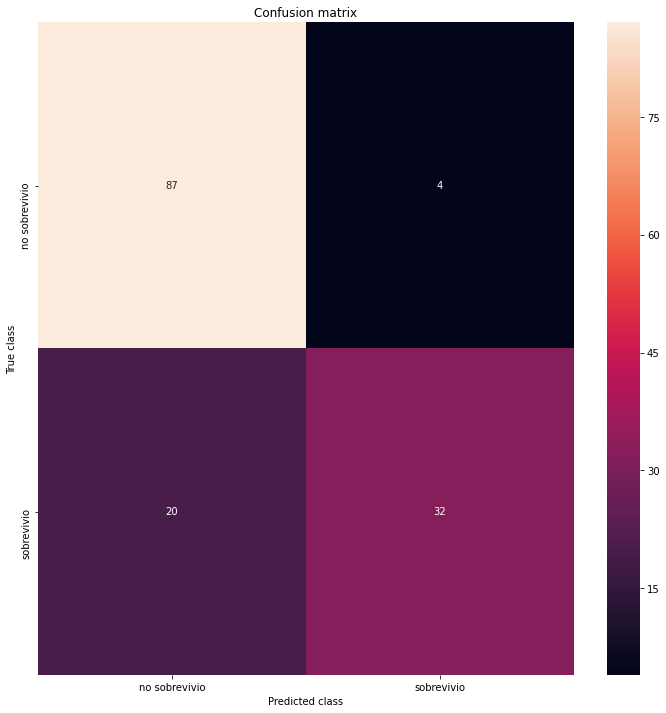

verdaderos positivos: 32
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 20
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        91
           1       0.89      0.62      0.73        52

    accuracy                           0.83       143
   macro avg       0.85      0.79      0.80       143
weighted avg       0.84      0.83      0.82       143

           metrics_train  metrics_test
Accuracy        0.803163      0.832168
Precision       0.881119      0.888889
Recall:         0.570136      0.615385
F1_Score:       0.692308      0.727273


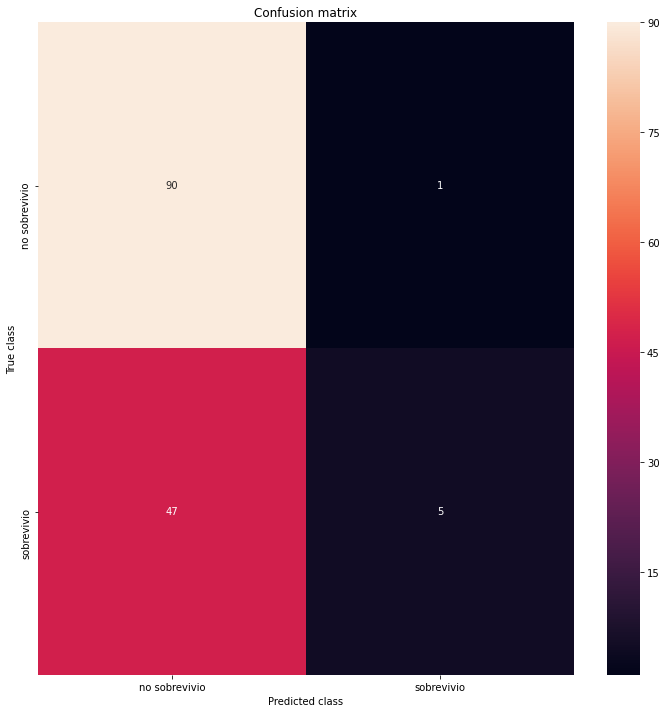

verdaderos positivos: 5
falsos positivos: 1
verdaderos negativos: 90
falsos negativos: 47
              precision    recall  f1-score   support

           0       0.66      0.99      0.79        91
           1       0.83      0.10      0.17        52

    accuracy                           0.66       143
   macro avg       0.75      0.54      0.48       143
weighted avg       0.72      0.66      0.57       143

           metrics_train  metrics_test
Accuracy        0.639719      0.664336
Precision       0.944444      0.833333
Recall:         0.076923      0.096154
F1_Score:       0.142259      0.172414
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.840346
Training accuracy: 0.351%
loss at step 1000: 0.703578
Training accuracy: 0.496%
Test accuracy: 0.664%


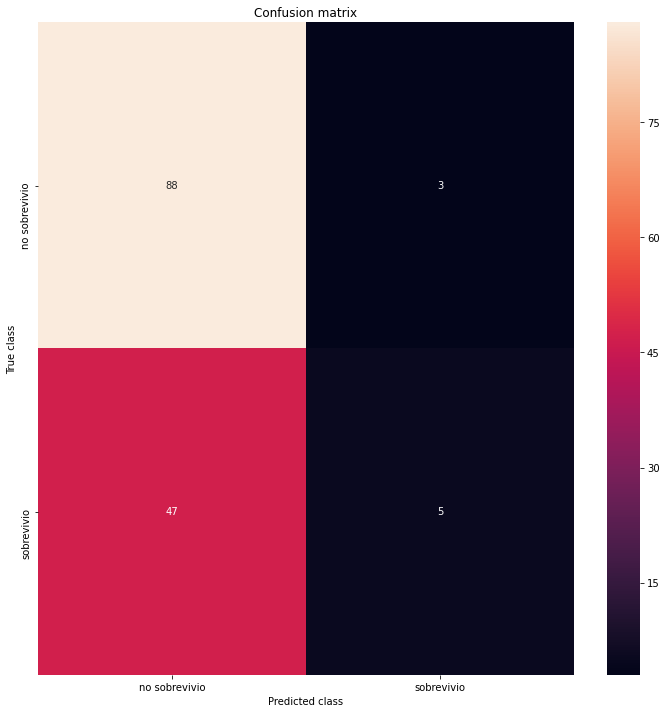

verdaderos positivos: 5
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 47
              precision    recall  f1-score   support

           0       0.65      0.97      0.78        91
           1       0.62      0.10      0.17        52

    accuracy                           0.65       143
   macro avg       0.64      0.53      0.47       143
weighted avg       0.64      0.65      0.56       143

           metrics_train  metrics_test
Accuracy        0.636204      0.650350
Precision       0.718750      0.625000
Recall:         0.104072      0.096154
F1_Score:       0.181818      0.166667


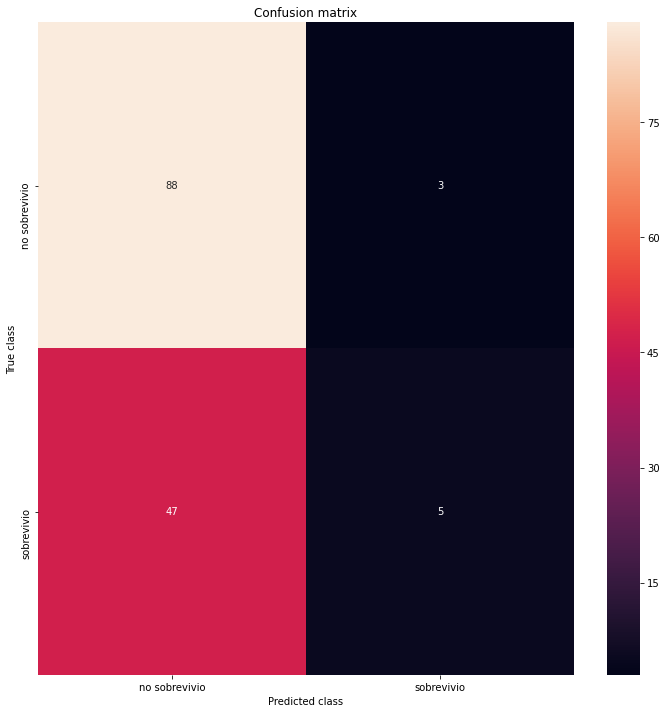

verdaderos positivos: 5
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 47
              precision    recall  f1-score   support

           0       0.65      0.97      0.78        91
           1       0.62      0.10      0.17        52

    accuracy                           0.65       143
   macro avg       0.64      0.53      0.47       143
weighted avg       0.64      0.65      0.56       143

           metrics_train  metrics_test
Accuracy        0.636204      0.650350
Precision       0.718750      0.625000
Recall:         0.104072      0.096154
F1_Score:       0.181818      0.166667


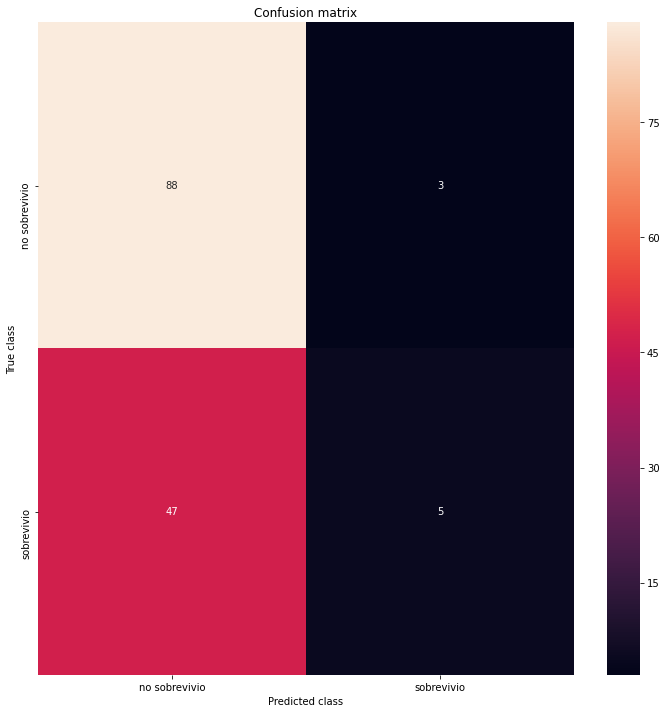

verdaderos positivos: 5
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 47
              precision    recall  f1-score   support

           0       0.65      0.97      0.78        91
           1       0.62      0.10      0.17        52

    accuracy                           0.65       143
   macro avg       0.64      0.53      0.47       143
weighted avg       0.64      0.65      0.56       143

           metrics_train  metrics_test
Accuracy        0.636204      0.650350
Precision       0.718750      0.625000
Recall:         0.104072      0.096154
F1_Score:       0.181818      0.166667


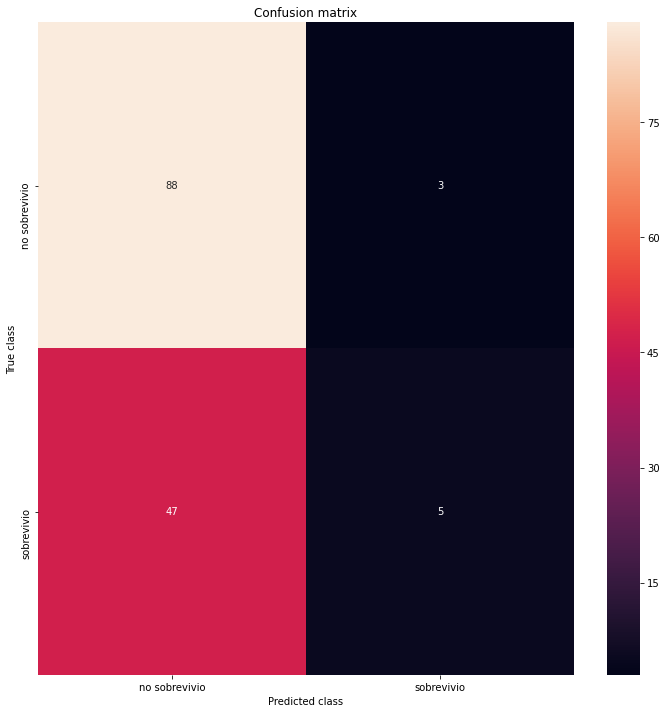

verdaderos positivos: 5
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 47
              precision    recall  f1-score   support

           0       0.65      0.97      0.78        91
           1       0.62      0.10      0.17        52

    accuracy                           0.65       143
   macro avg       0.64      0.53      0.47       143
weighted avg       0.64      0.65      0.56       143

           metrics_train  metrics_test
Accuracy        0.636204      0.650350
Precision       0.718750      0.625000
Recall:         0.104072      0.096154
F1_Score:       0.181818      0.166667


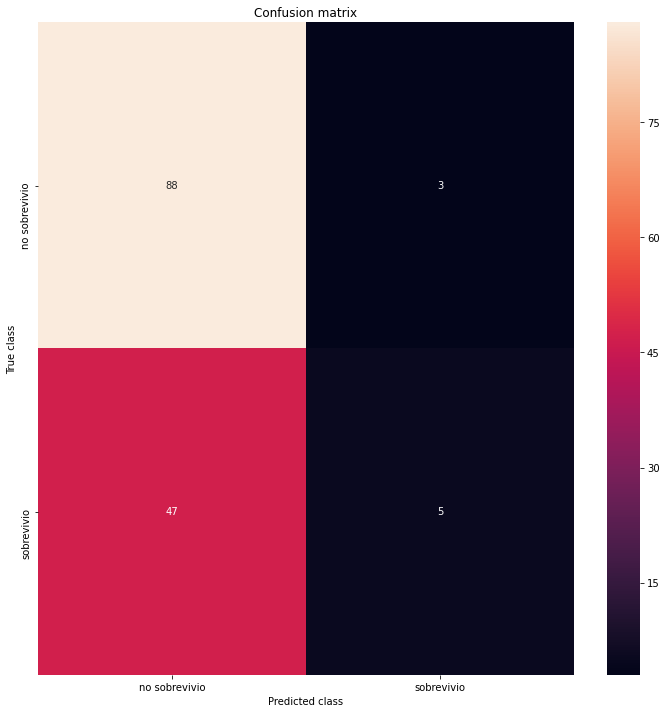

verdaderos positivos: 5
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 47
              precision    recall  f1-score   support

           0       0.65      0.97      0.78        91
           1       0.62      0.10      0.17        52

    accuracy                           0.65       143
   macro avg       0.64      0.53      0.47       143
weighted avg       0.64      0.65      0.56       143

           metrics_train  metrics_test
Accuracy        0.636204      0.650350
Precision       0.718750      0.625000
Recall:         0.104072      0.096154
F1_Score:       0.181818      0.166667


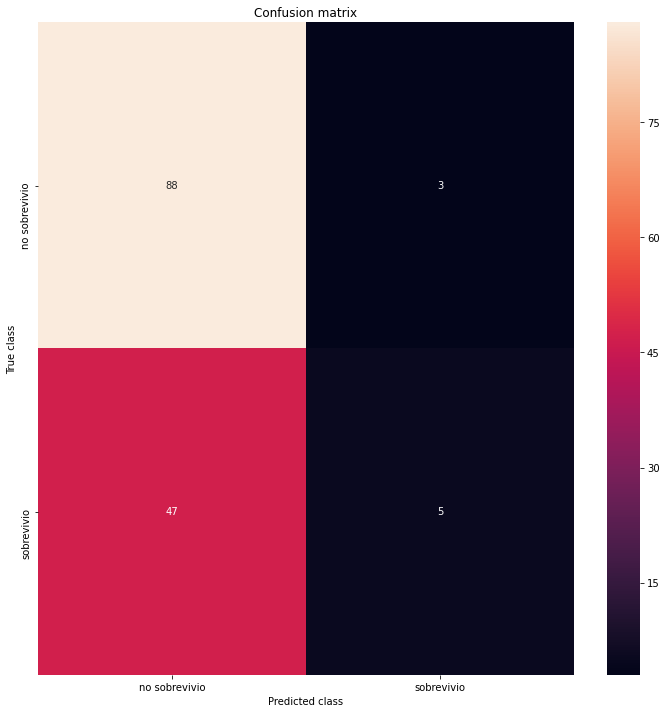

verdaderos positivos: 5
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 47
              precision    recall  f1-score   support

           0       0.65      0.97      0.78        91
           1       0.62      0.10      0.17        52

    accuracy                           0.65       143
   macro avg       0.64      0.53      0.47       143
weighted avg       0.64      0.65      0.56       143

           metrics_train  metrics_test
Accuracy        0.636204      0.650350
Precision       0.718750      0.625000
Recall:         0.104072      0.096154
F1_Score:       0.181818      0.166667


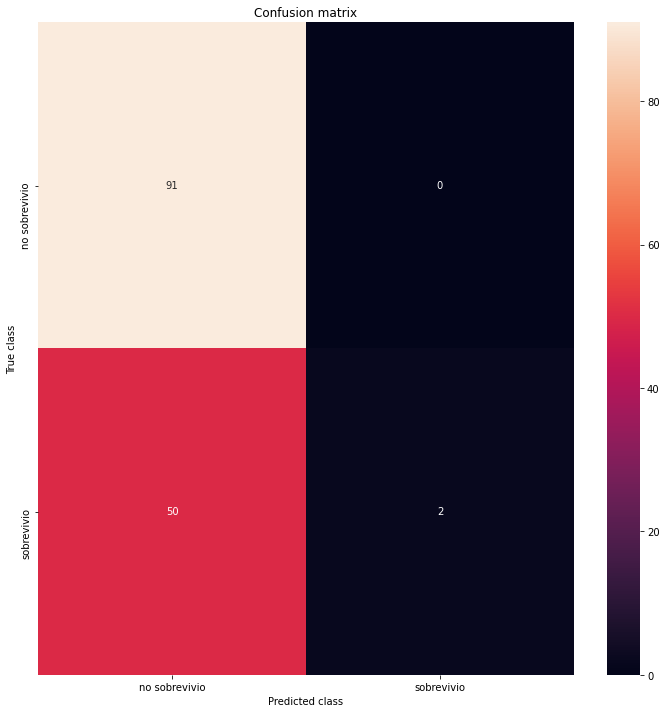

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


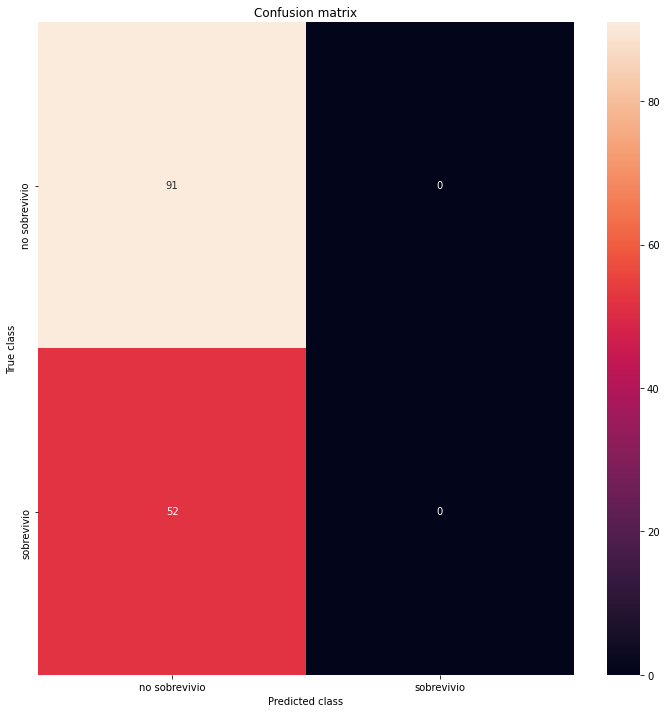

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.812895
Training accuracy: 0.485%
loss at step 1000: 0.596653
Training accuracy: 0.644%
Test accuracy: 0.832%


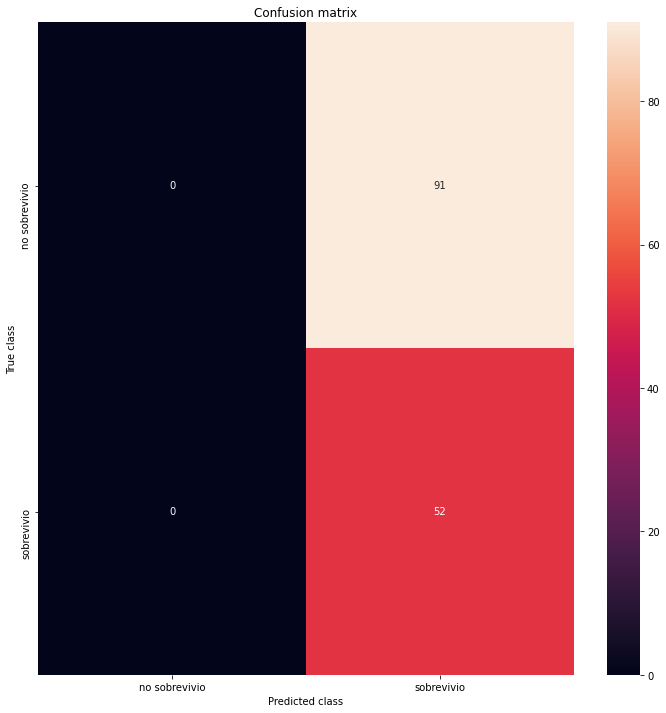

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


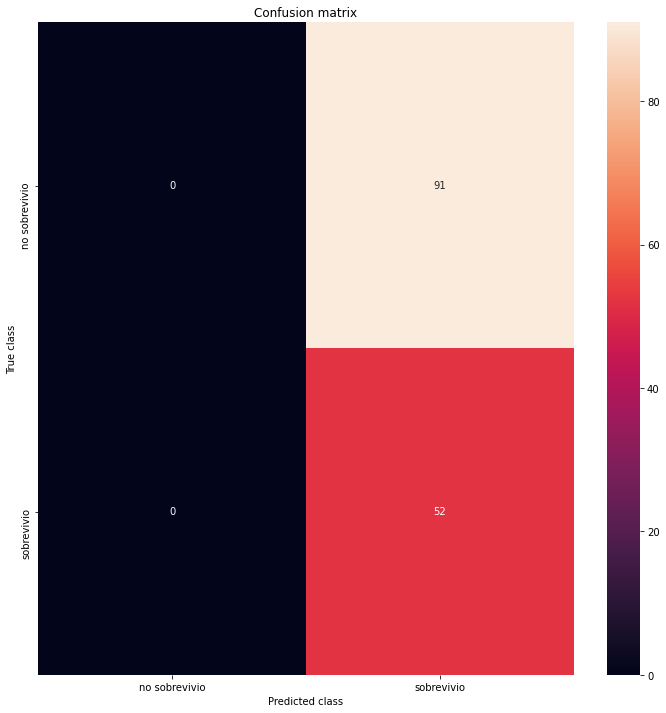

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


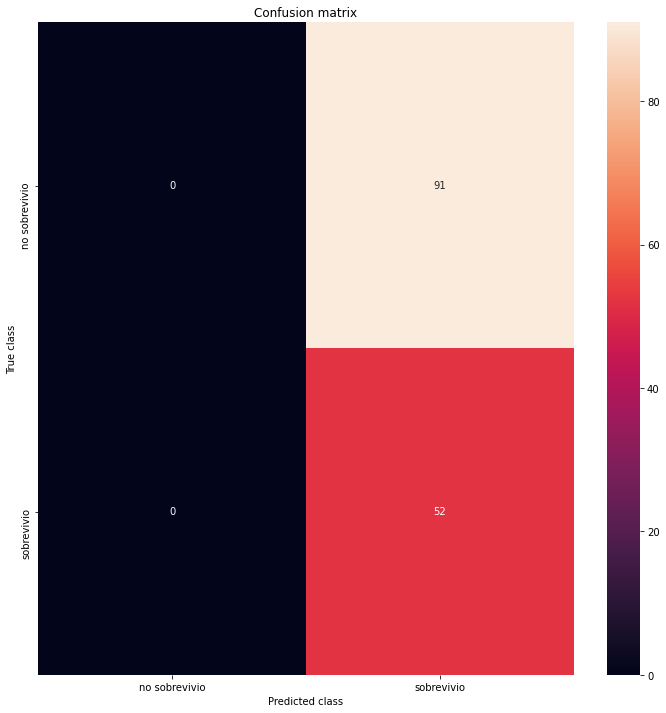

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


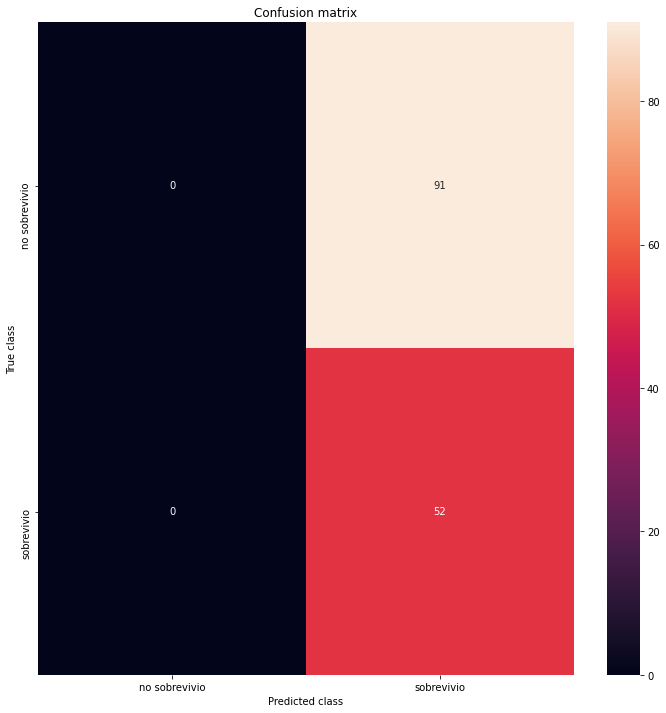

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


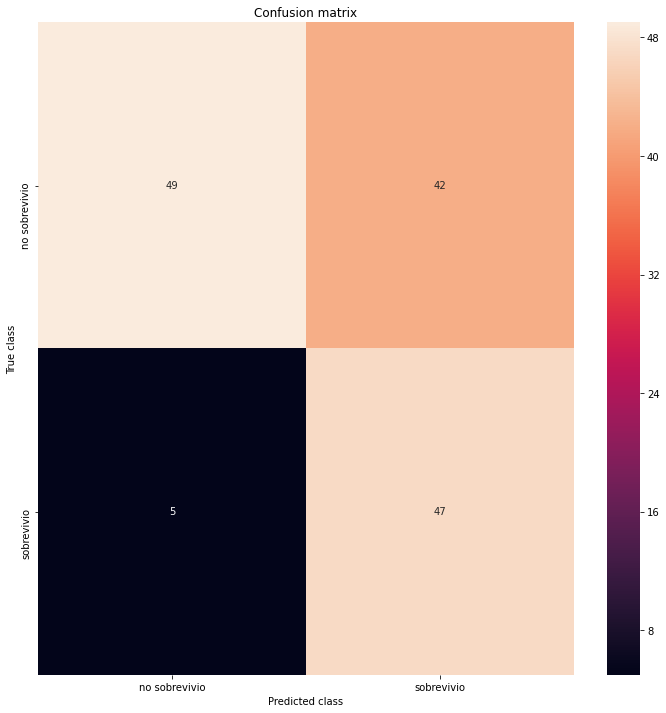

verdaderos positivos: 47
falsos positivos: 42
verdaderos negativos: 49
falsos negativos: 5
              precision    recall  f1-score   support

           0       0.91      0.54      0.68        91
           1       0.53      0.90      0.67        52

    accuracy                           0.67       143
   macro avg       0.72      0.72      0.67       143
weighted avg       0.77      0.67      0.67       143

           metrics_train  metrics_test
Accuracy        0.653779      0.671329
Precision       0.533708      0.528090
Recall:         0.859729      0.903846
F1_Score:       0.658579      0.666667


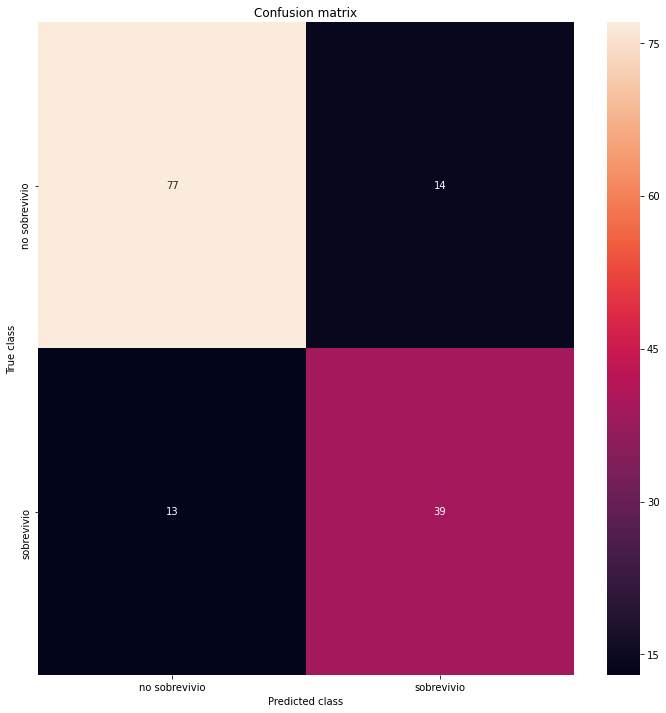

verdaderos positivos: 39
falsos positivos: 14
verdaderos negativos: 77
falsos negativos: 13
              precision    recall  f1-score   support

           0       0.86      0.85      0.85        91
           1       0.74      0.75      0.74        52

    accuracy                           0.81       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.81      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.773286      0.811189
Precision       0.719048      0.735849
Recall:         0.683258      0.750000
F1_Score:       0.700696      0.742857


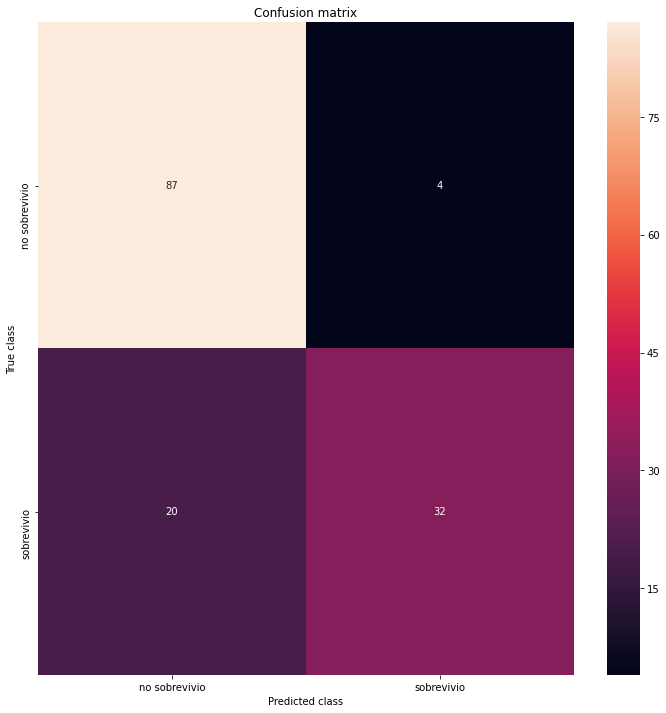

verdaderos positivos: 32
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 20
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        91
           1       0.89      0.62      0.73        52

    accuracy                           0.83       143
   macro avg       0.85      0.79      0.80       143
weighted avg       0.84      0.83      0.82       143

           metrics_train  metrics_test
Accuracy        0.803163      0.832168
Precision       0.881119      0.888889
Recall:         0.570136      0.615385
F1_Score:       0.692308      0.727273


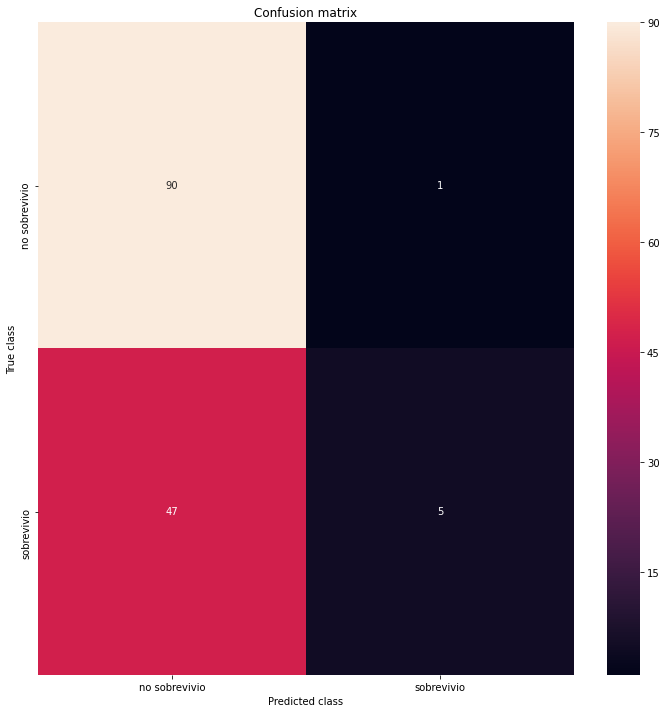

verdaderos positivos: 5
falsos positivos: 1
verdaderos negativos: 90
falsos negativos: 47
              precision    recall  f1-score   support

           0       0.66      0.99      0.79        91
           1       0.83      0.10      0.17        52

    accuracy                           0.66       143
   macro avg       0.75      0.54      0.48       143
weighted avg       0.72      0.66      0.57       143

           metrics_train  metrics_test
Accuracy        0.639719      0.664336
Precision       0.944444      0.833333
Recall:         0.076923      0.096154
F1_Score:       0.142259      0.172414
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.961781
Training accuracy: 0.409%
loss at step 1000: 0.730902
Training accuracy: 0.511%
Test accuracy: 0.636%


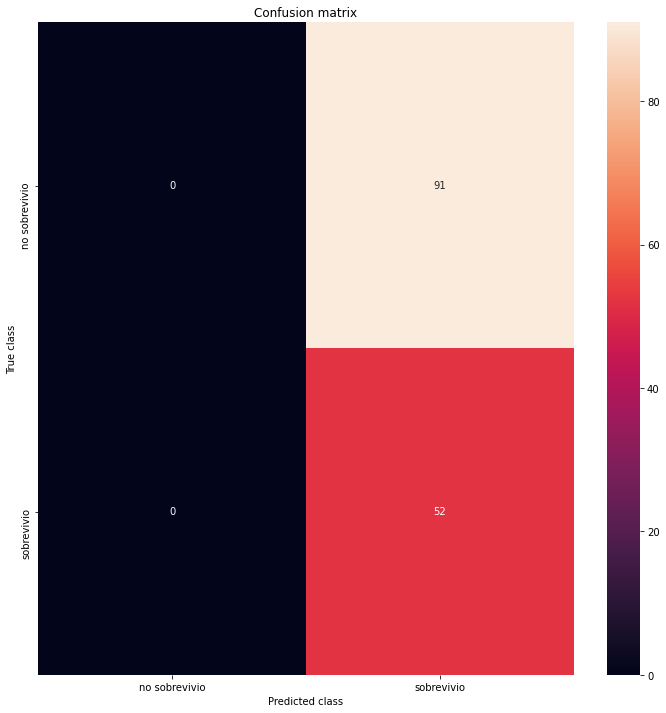

C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143

           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


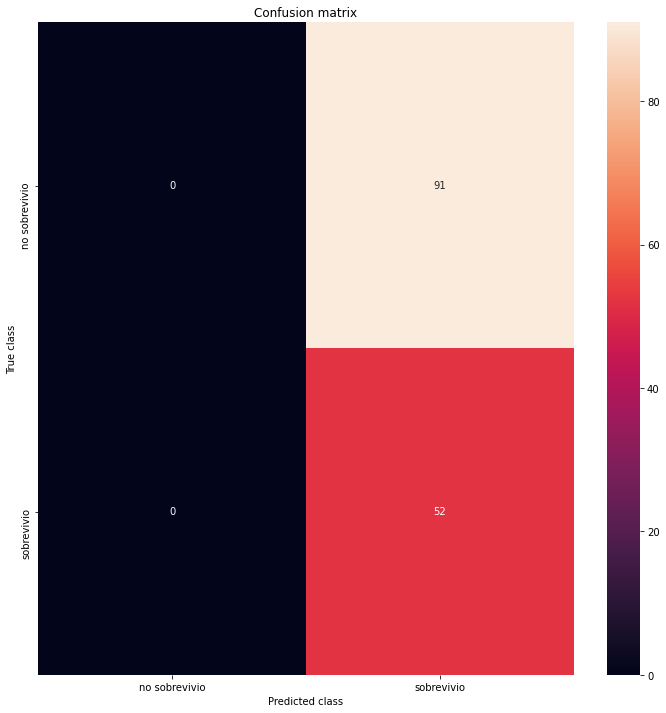

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


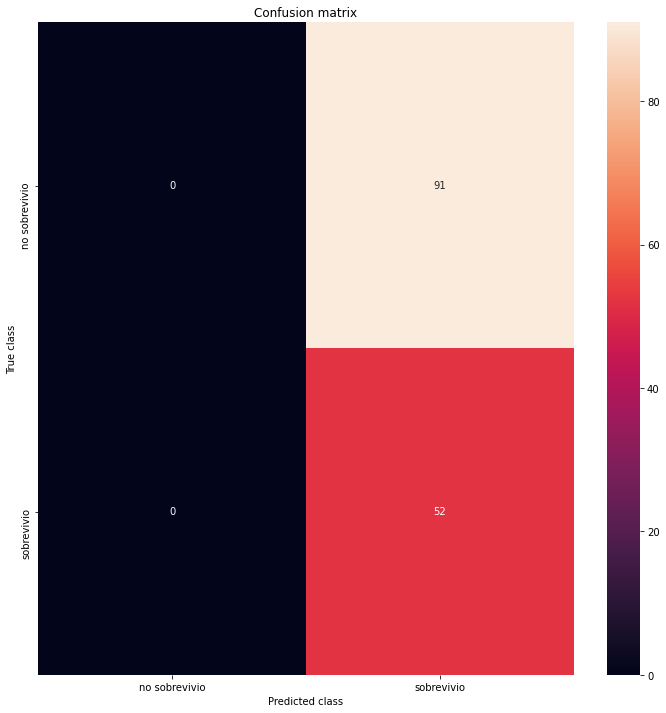

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


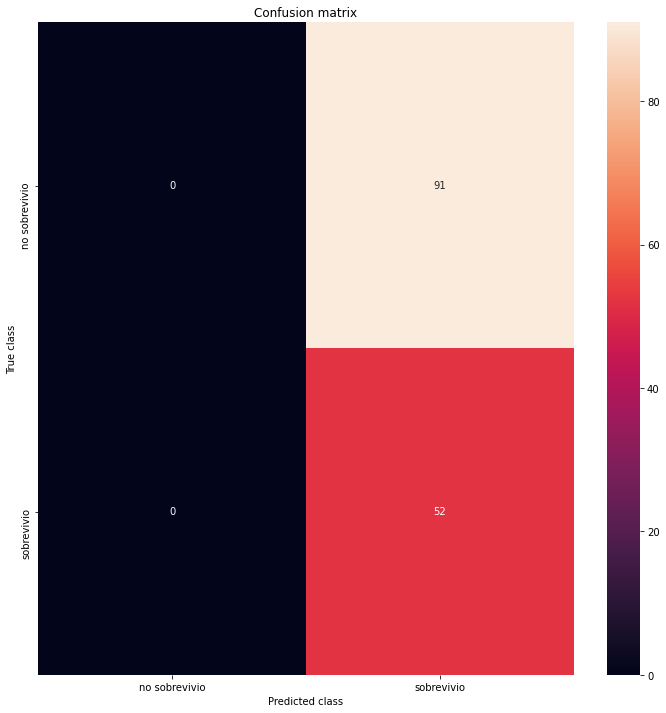

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


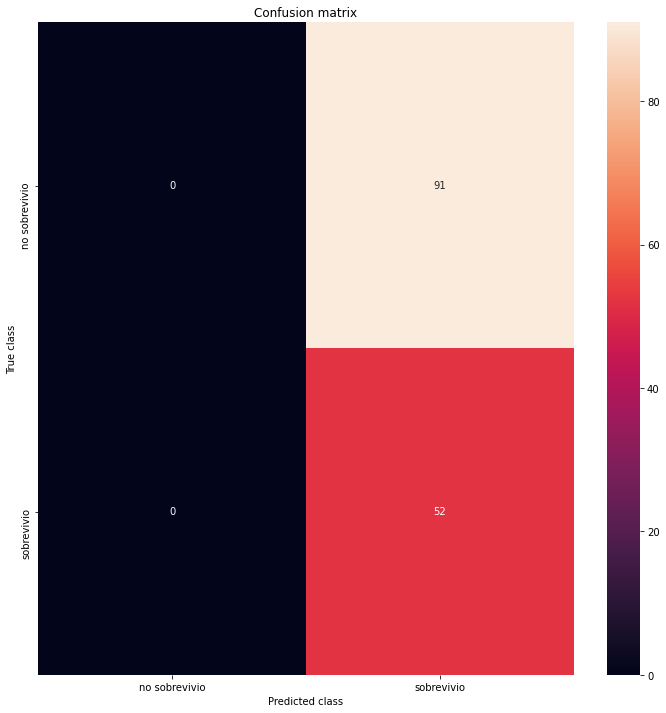

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


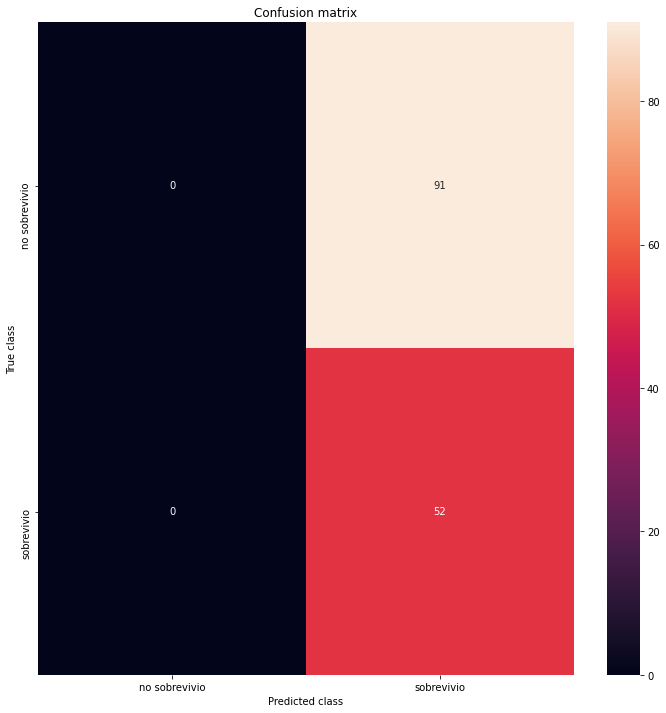

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


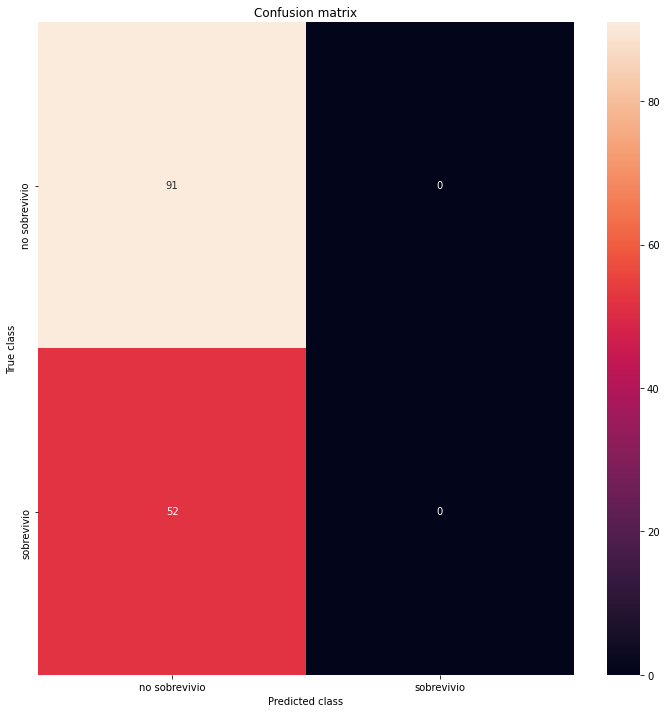

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


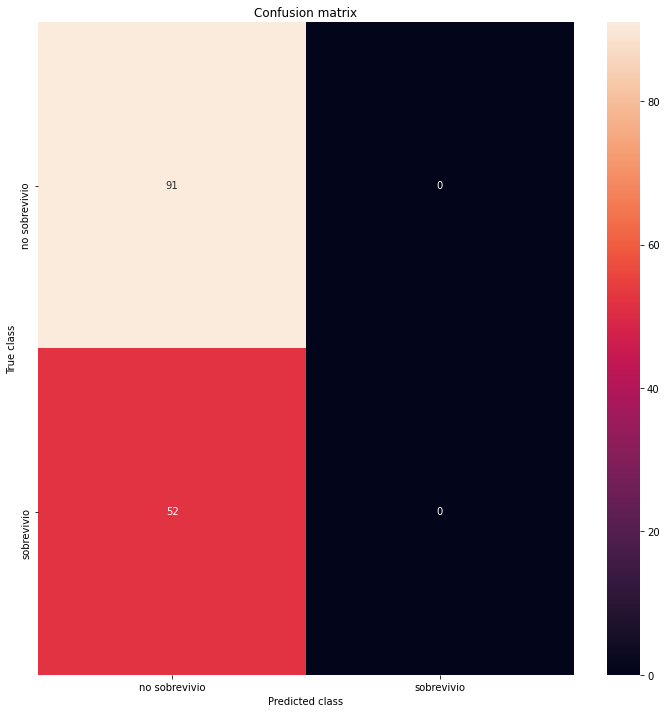

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.884548
Training accuracy: 0.634%
loss at step 1000: 0.697426
Training accuracy: 0.625%
Test accuracy: 0.650%


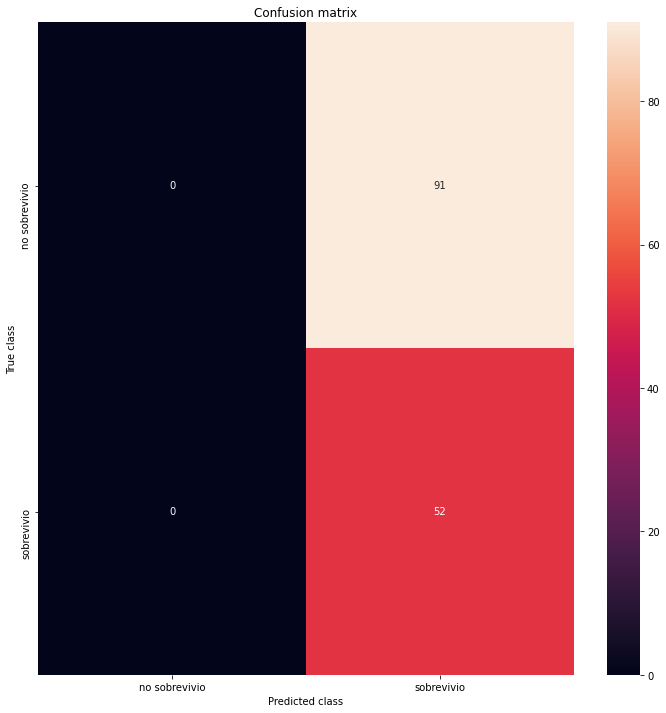

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


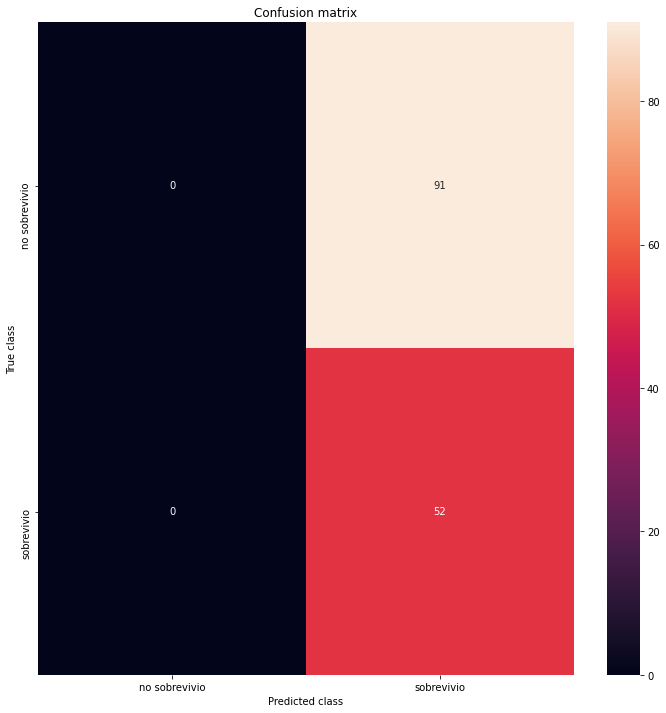

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


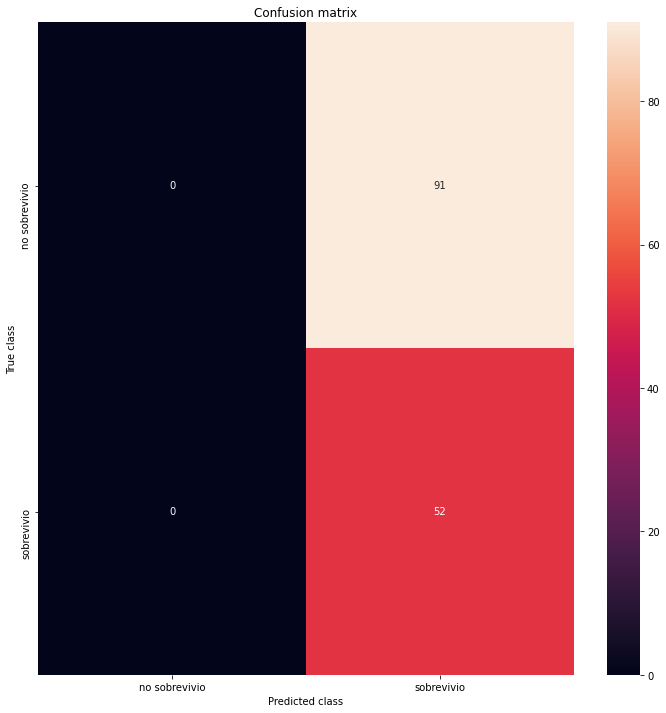

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


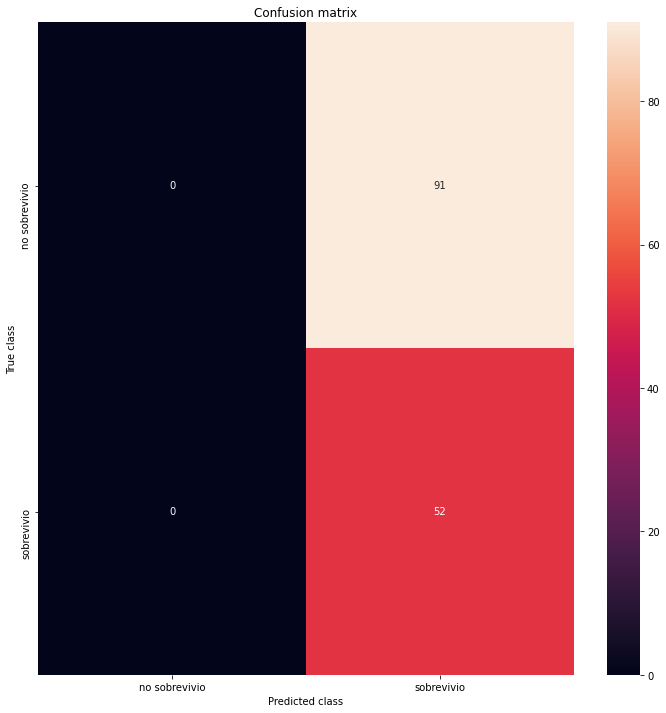

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


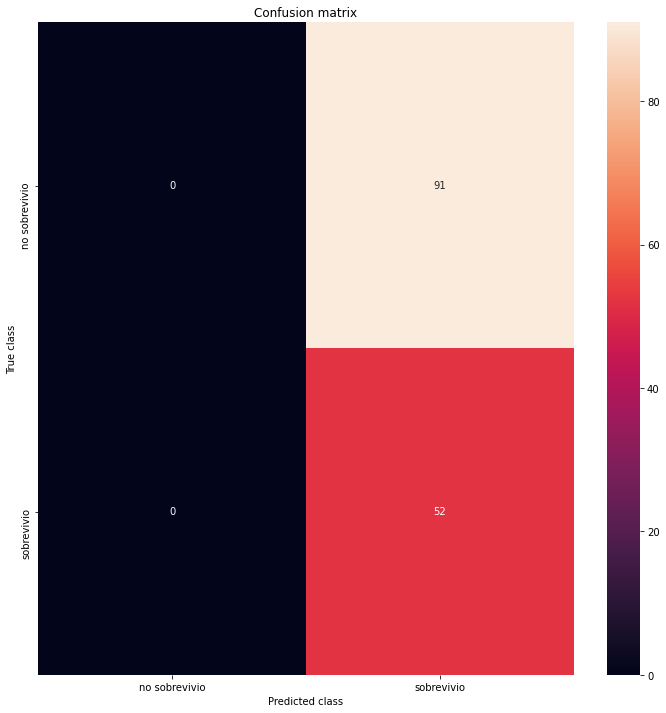

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


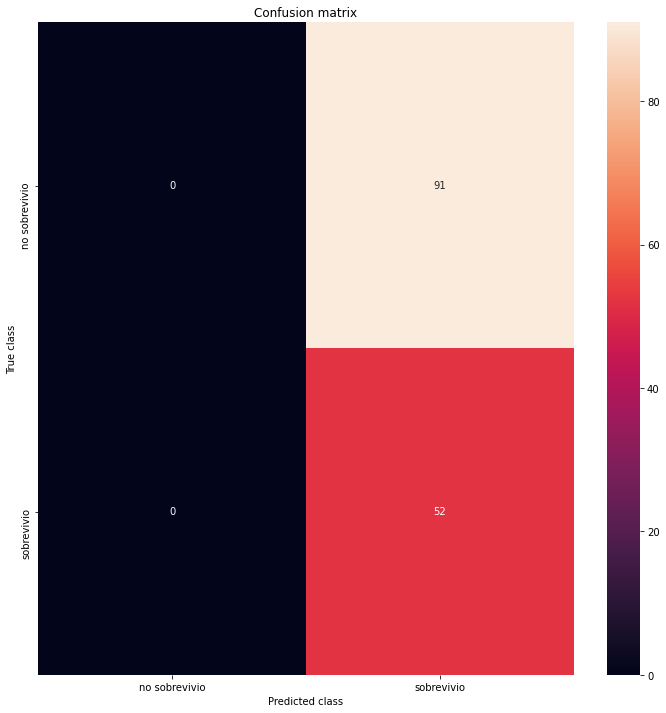

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


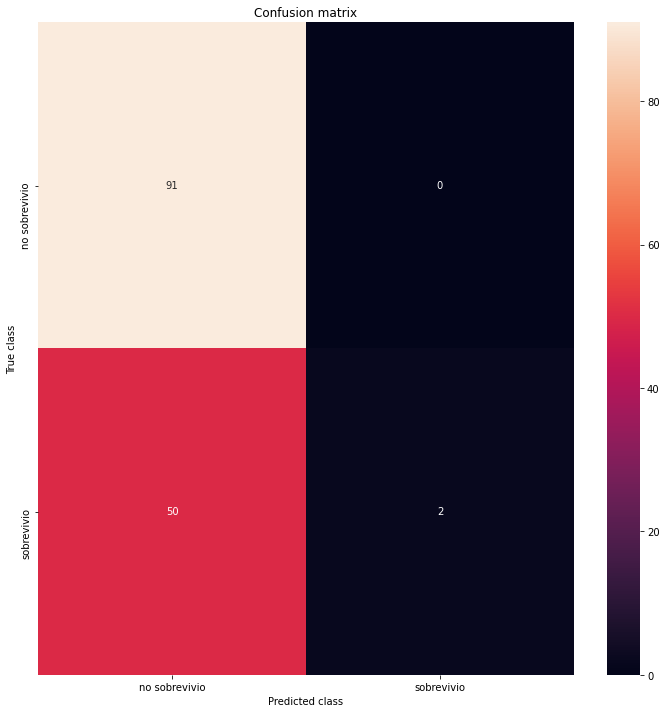

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


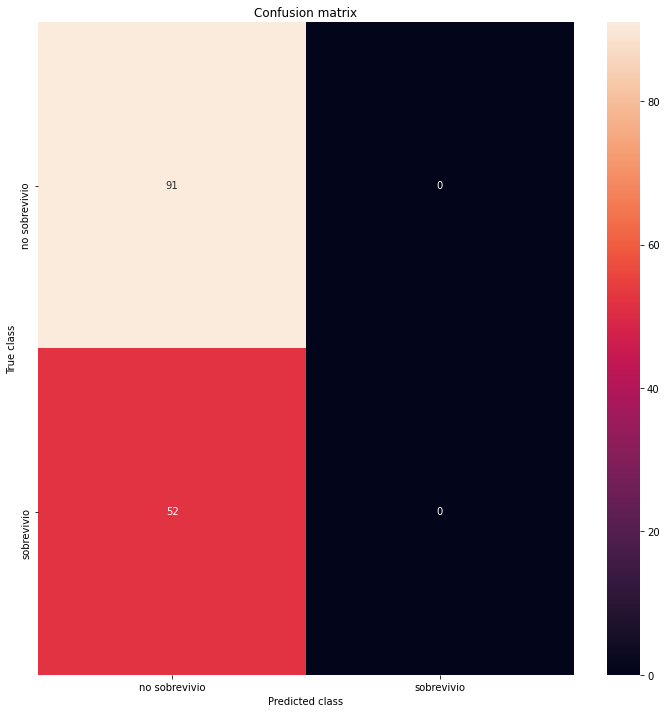

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.968786
Training accuracy: 0.418%
loss at step 1000: 0.748159
Training accuracy: 0.396%
Test accuracy: 0.399%


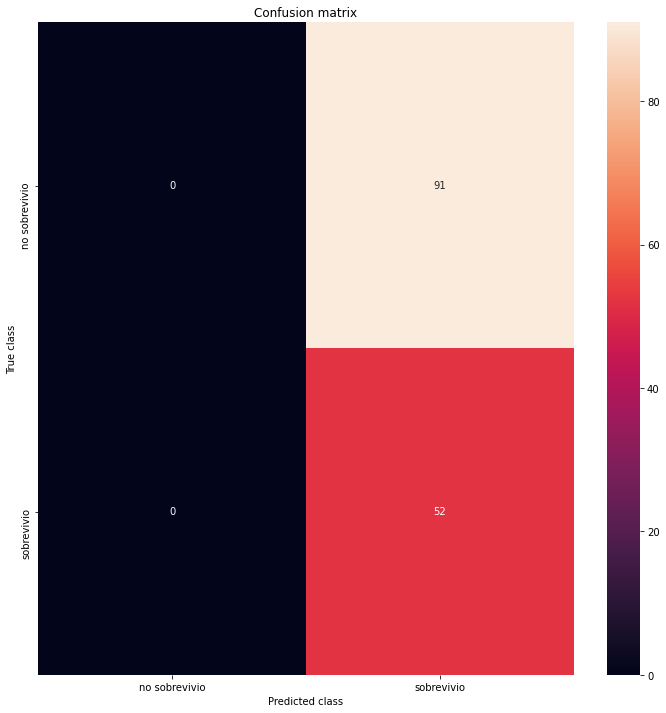

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


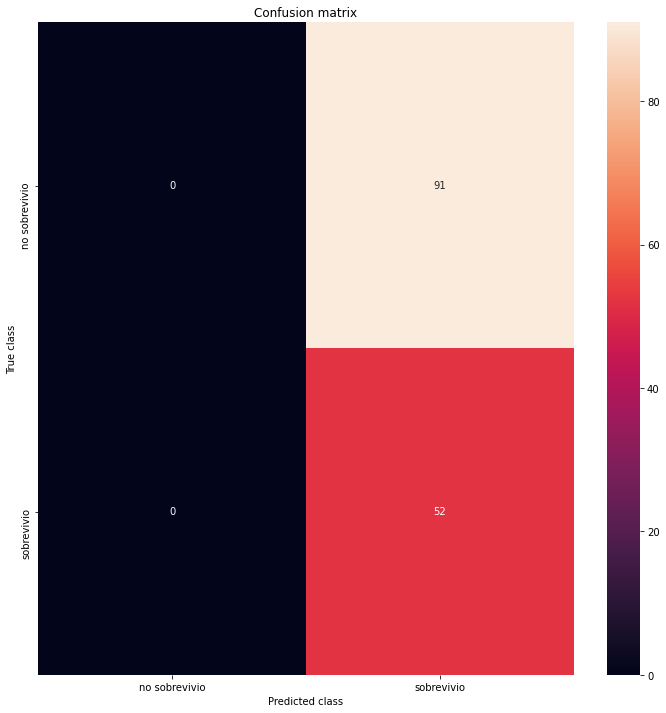

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


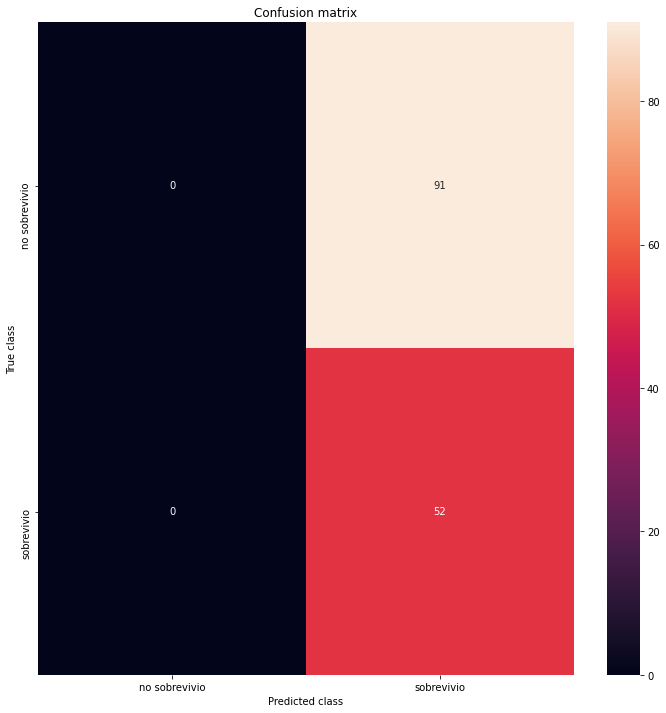

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


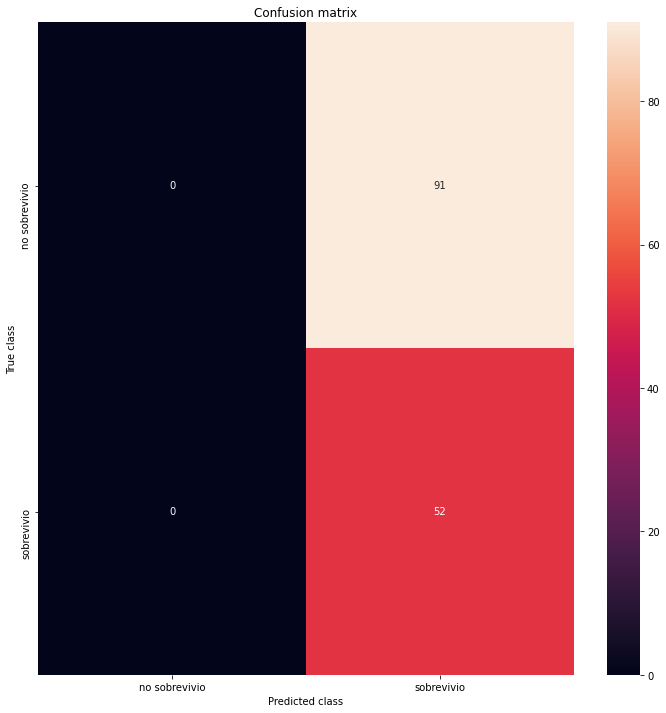

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


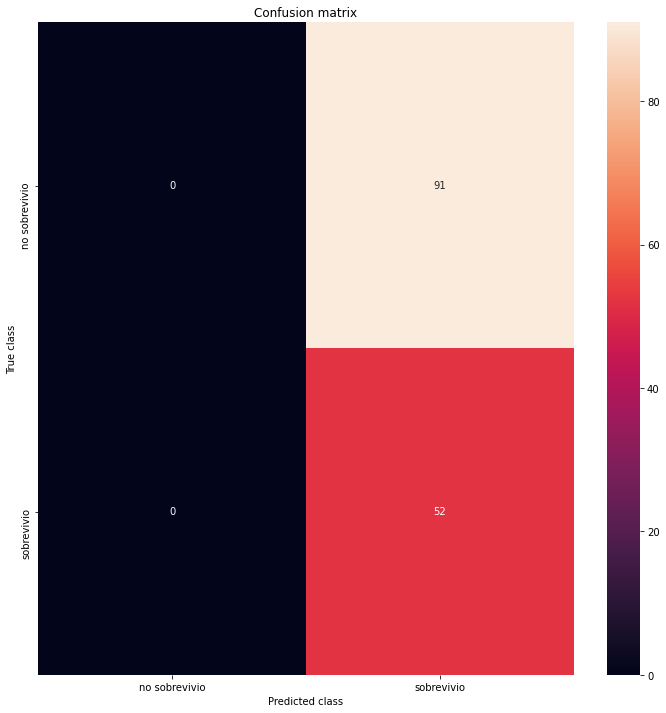

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


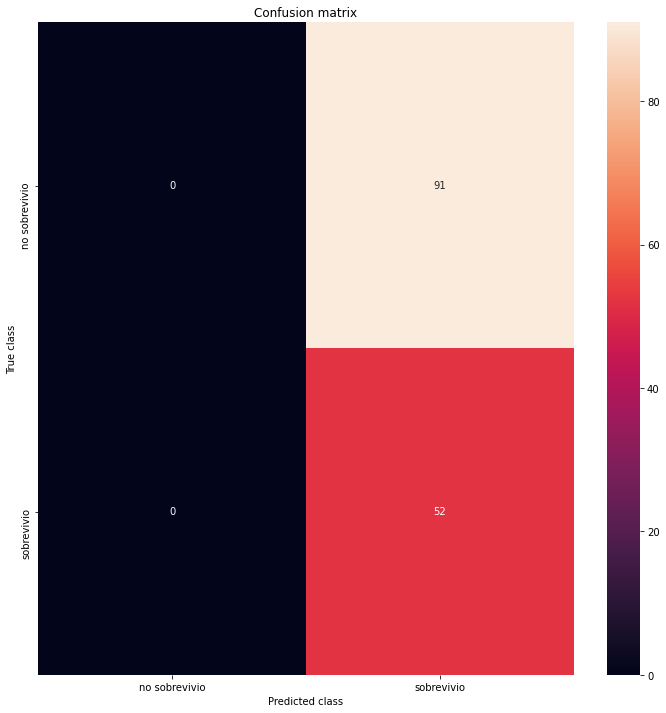

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


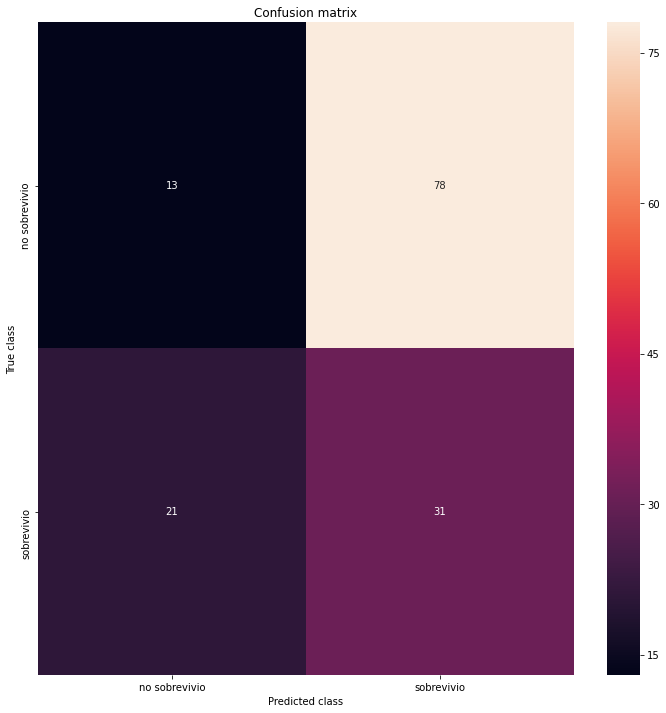

verdaderos positivos: 31
falsos positivos: 78
verdaderos negativos: 13
falsos negativos: 21
              precision    recall  f1-score   support

           0       0.38      0.14      0.21        91
           1       0.28      0.60      0.39        52

    accuracy                           0.31       143
   macro avg       0.33      0.37      0.30       143
weighted avg       0.35      0.31      0.27       143

           metrics_train  metrics_test
Accuracy        0.270650      0.307692
Precision       0.282511      0.284404
Recall:         0.570136      0.596154
F1_Score:       0.377811      0.385093


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


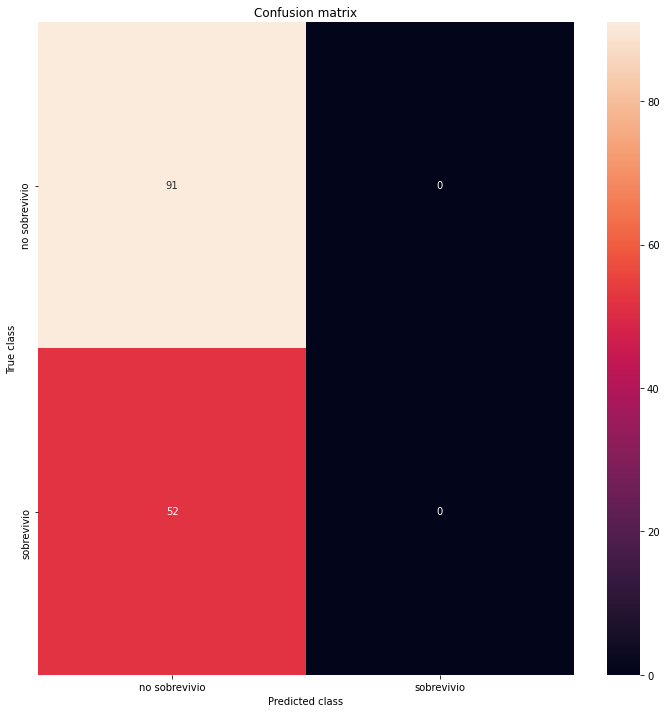

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.906213
Training accuracy: 0.634%
loss at step 1000: 0.719277
Training accuracy: 0.627%
Test accuracy: 0.643%


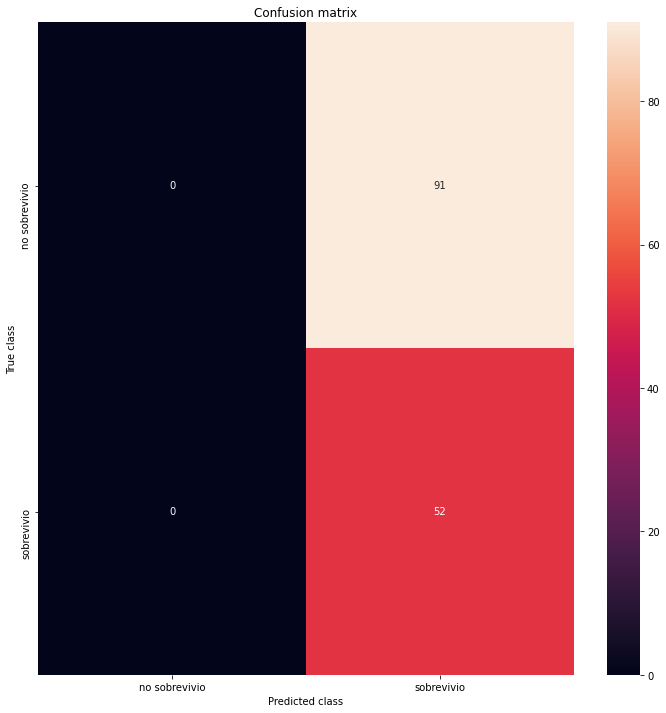

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


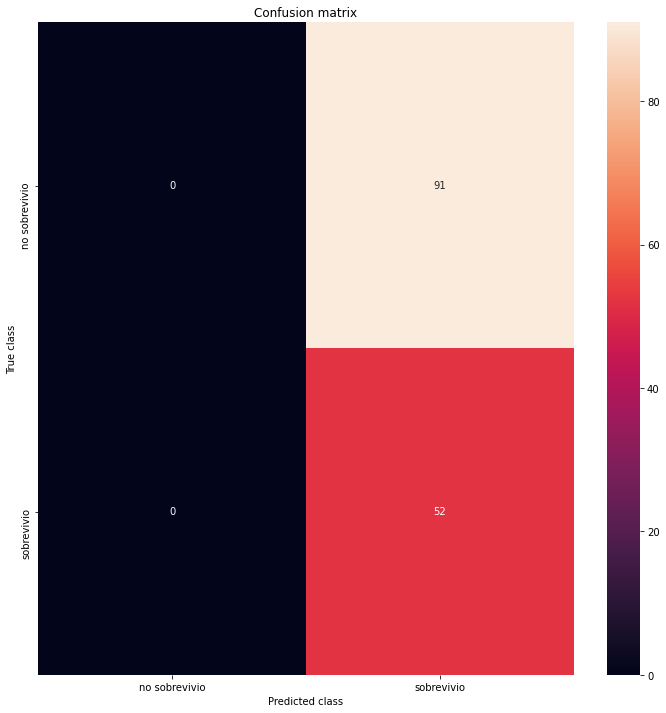

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


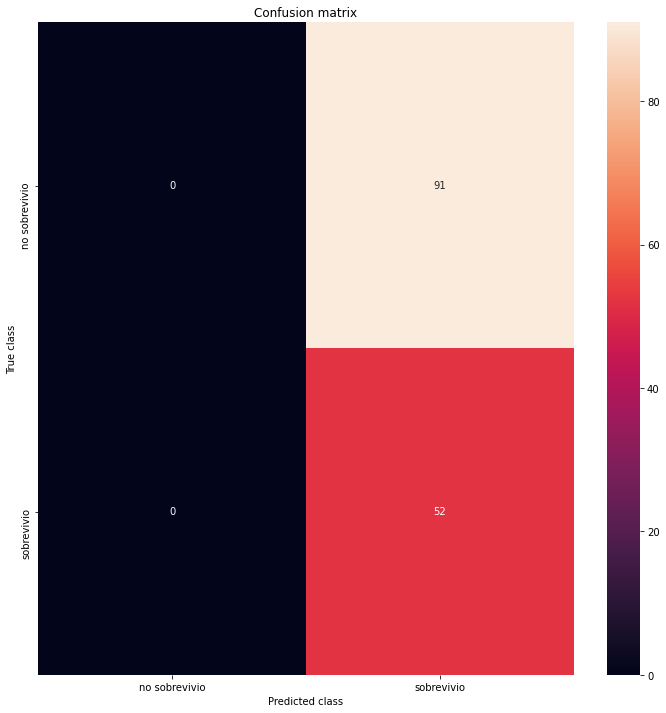

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


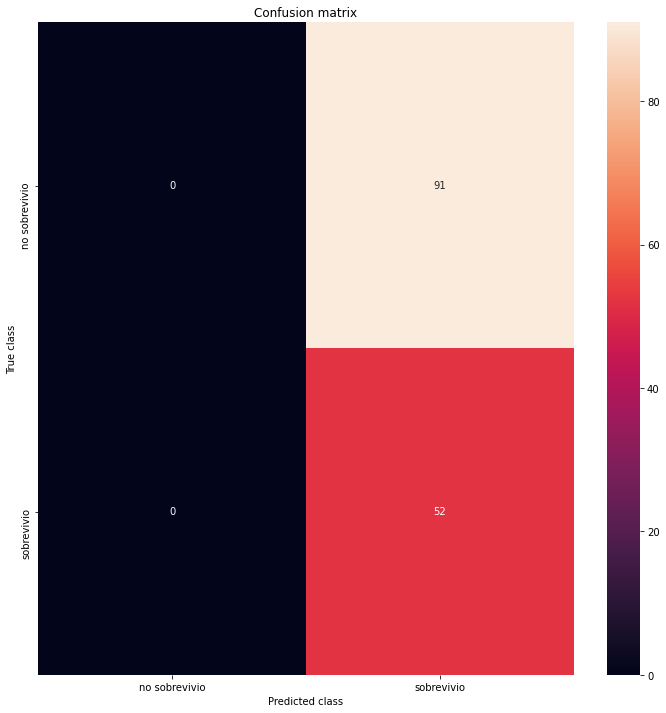

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


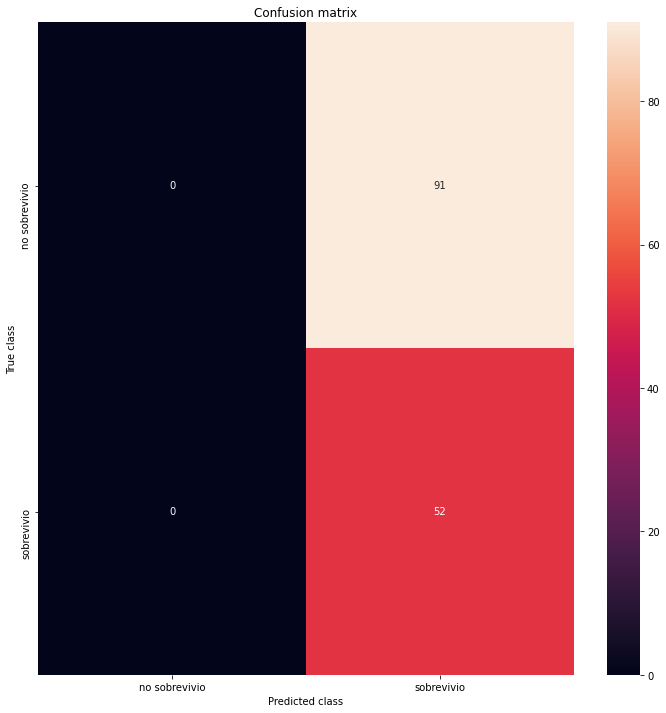

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


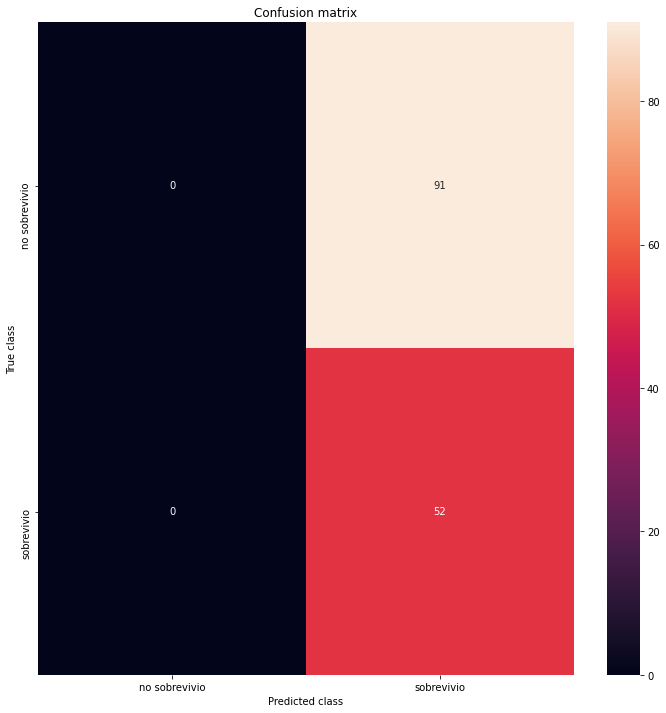

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


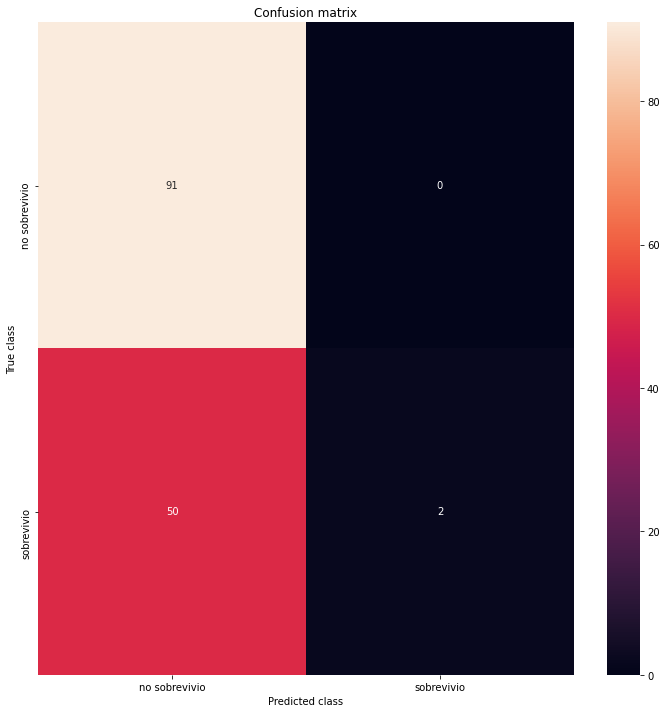

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


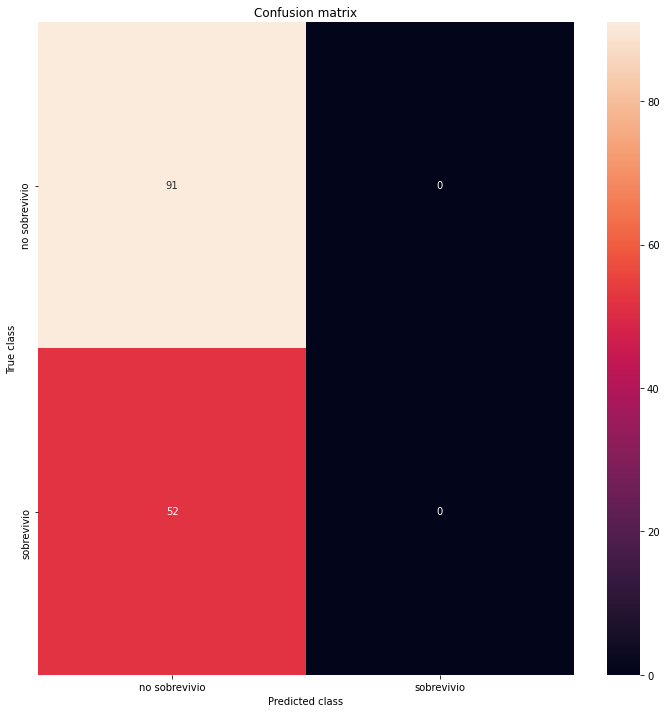

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.956361
Training accuracy: 0.422%
loss at step 1000: 0.753571
Training accuracy: 0.540%
Test accuracy: 0.692%


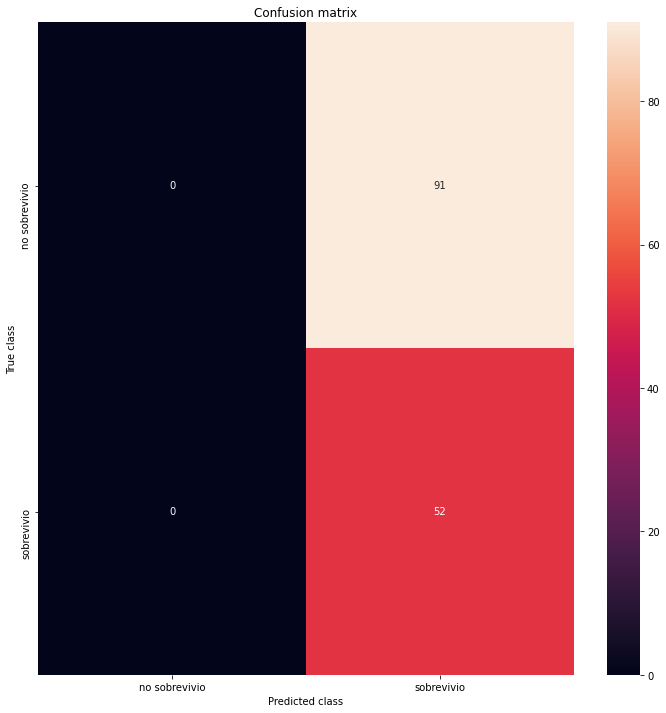

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


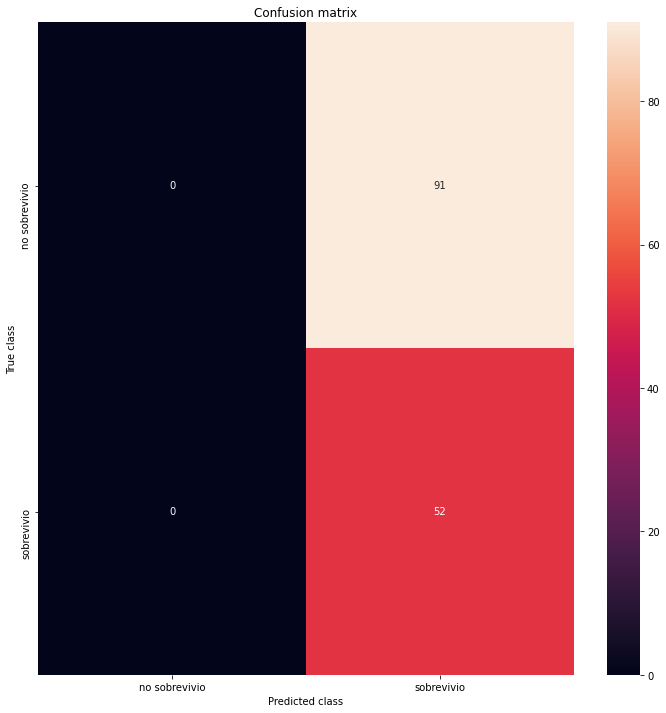

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


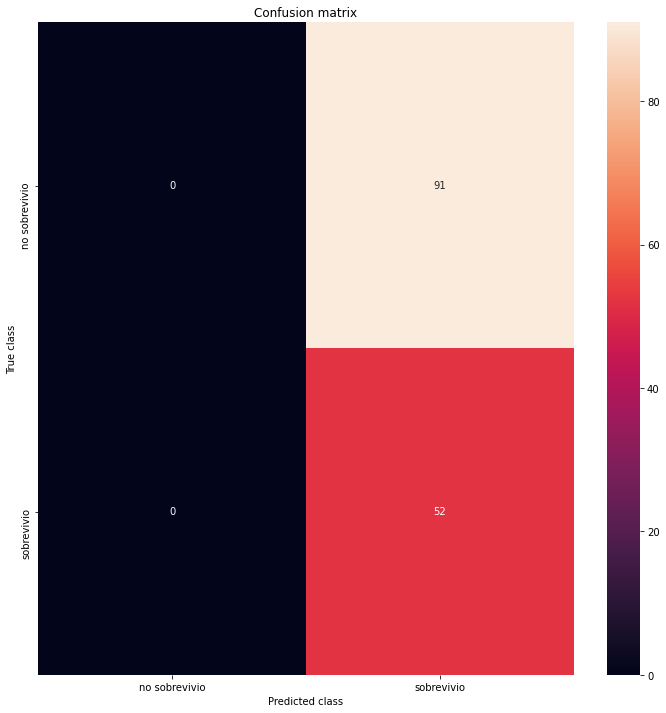

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


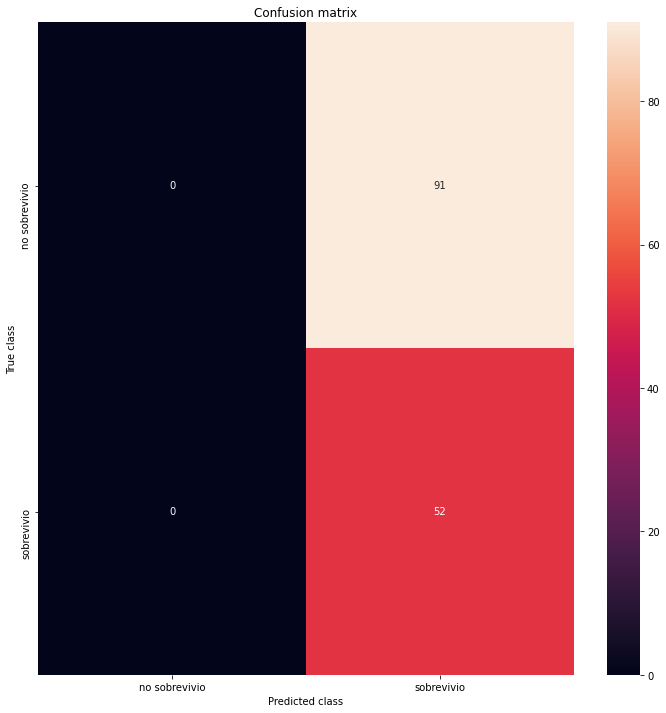

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


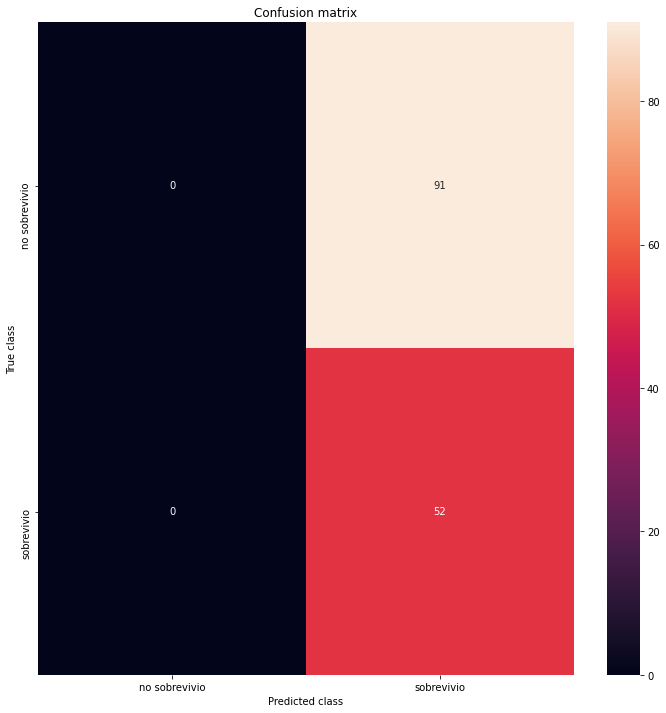

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


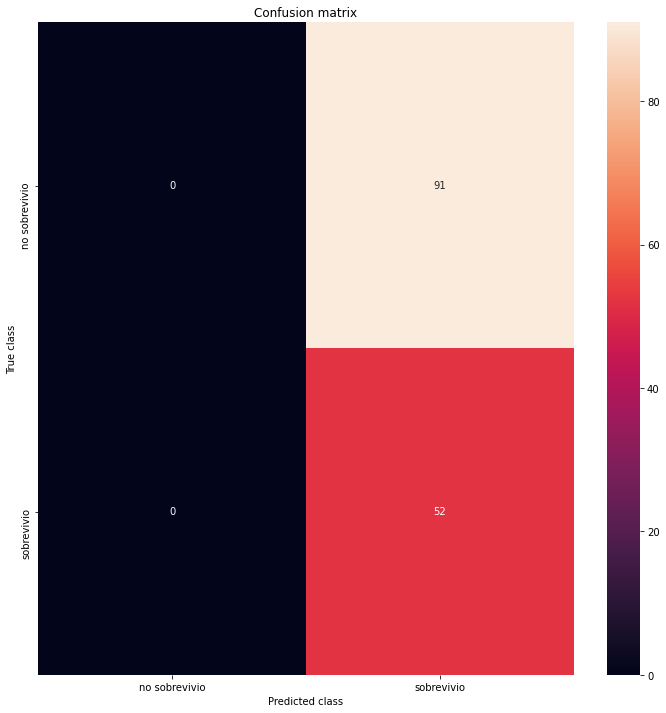

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


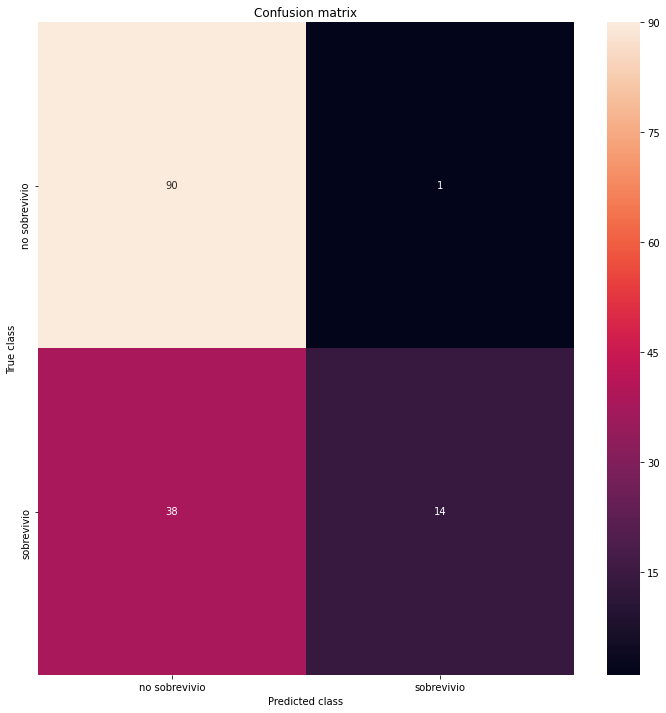

verdaderos positivos: 14
falsos positivos: 1
verdaderos negativos: 90
falsos negativos: 38
              precision    recall  f1-score   support

           0       0.70      0.99      0.82        91
           1       0.93      0.27      0.42        52

    accuracy                           0.73       143
   macro avg       0.82      0.63      0.62       143
weighted avg       0.79      0.73      0.68       143

           metrics_train  metrics_test
Accuracy        0.671353      0.727273
Precision       0.803571      0.933333
Recall:         0.203620      0.269231
F1_Score:       0.324910      0.417910


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


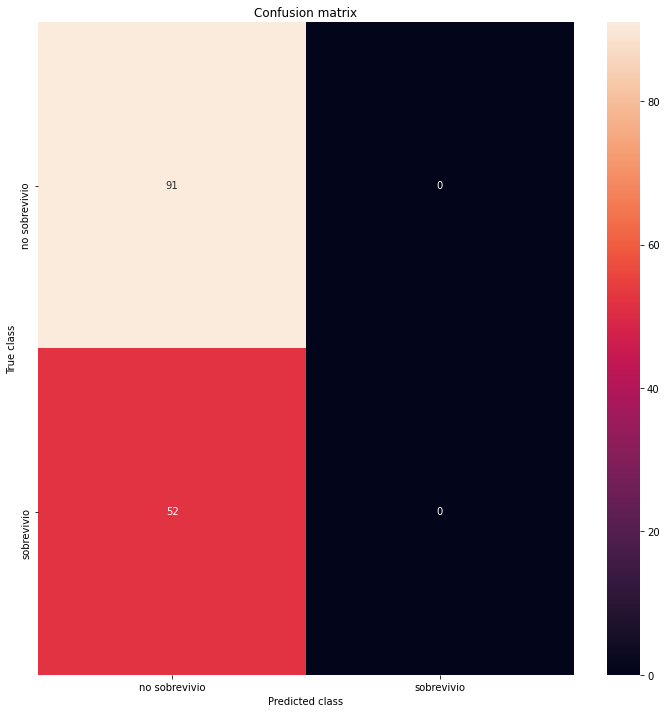

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.895527
Training accuracy: 0.634%
loss at step 1000: 0.717336
Training accuracy: 0.631%
Test accuracy: 0.650%


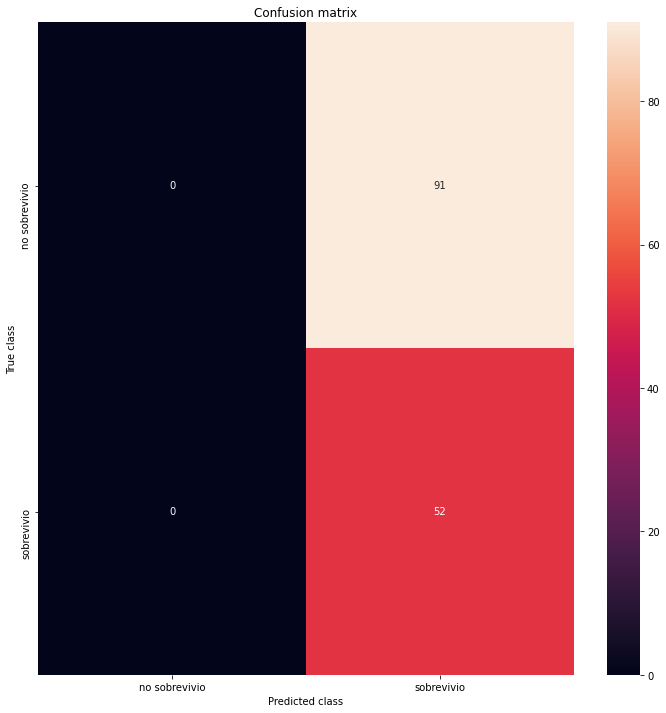

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


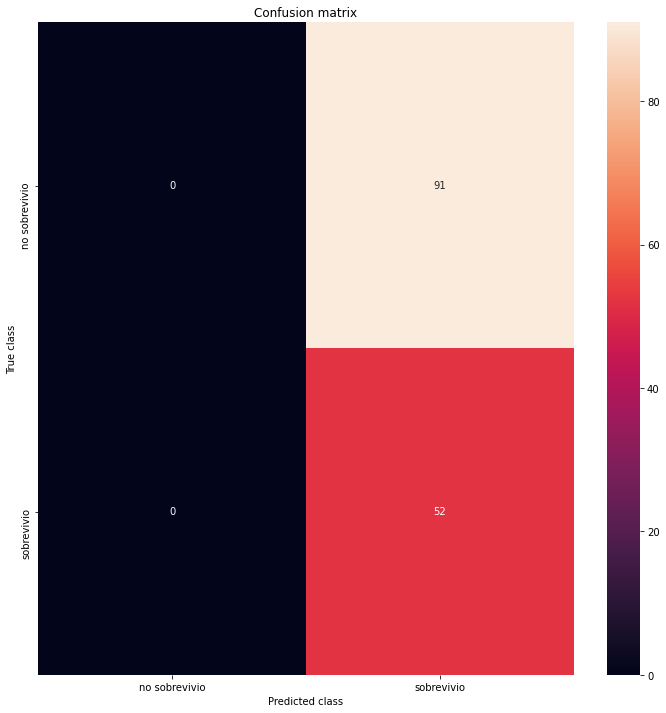

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


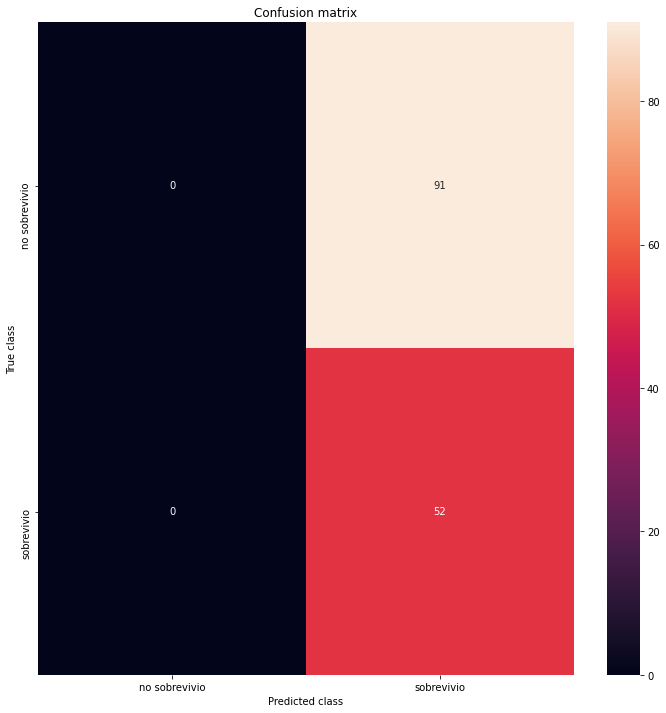

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


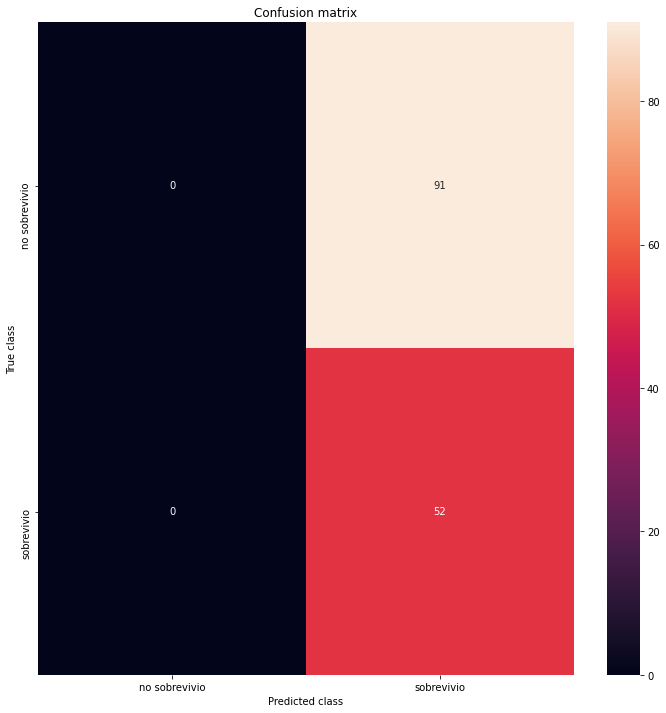

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


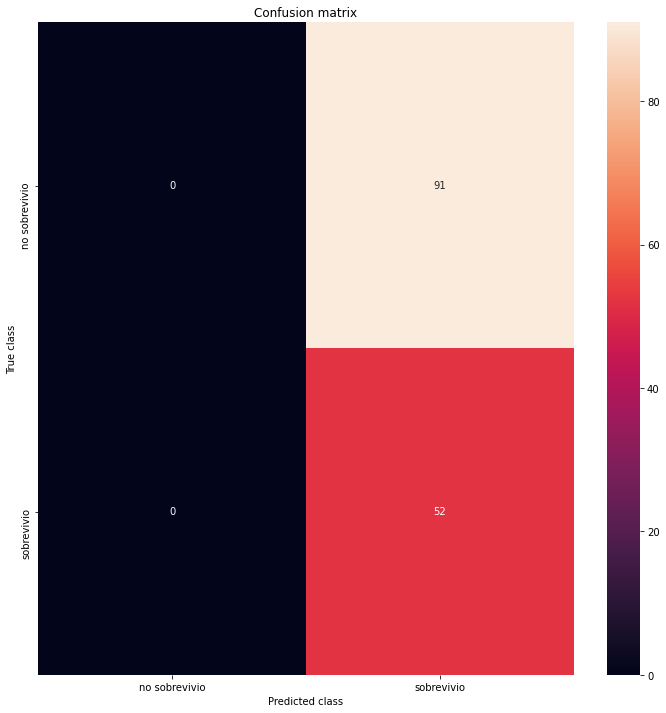

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


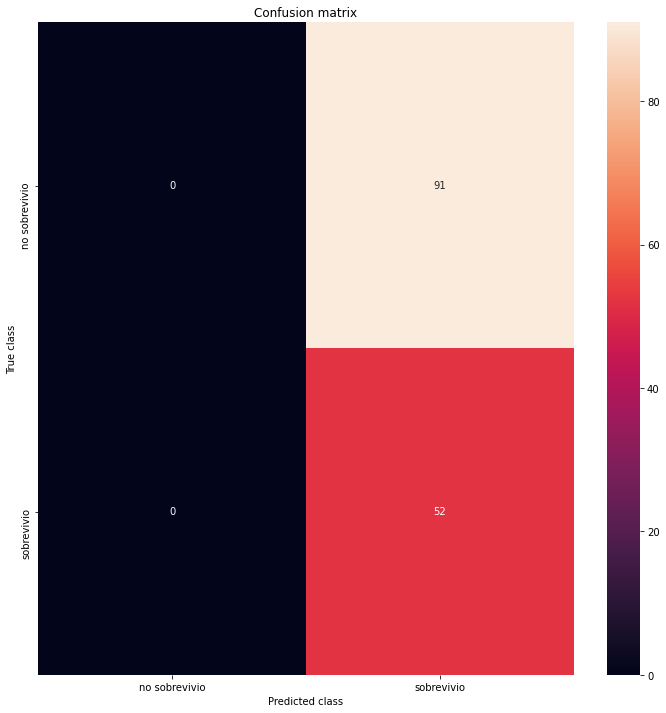

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


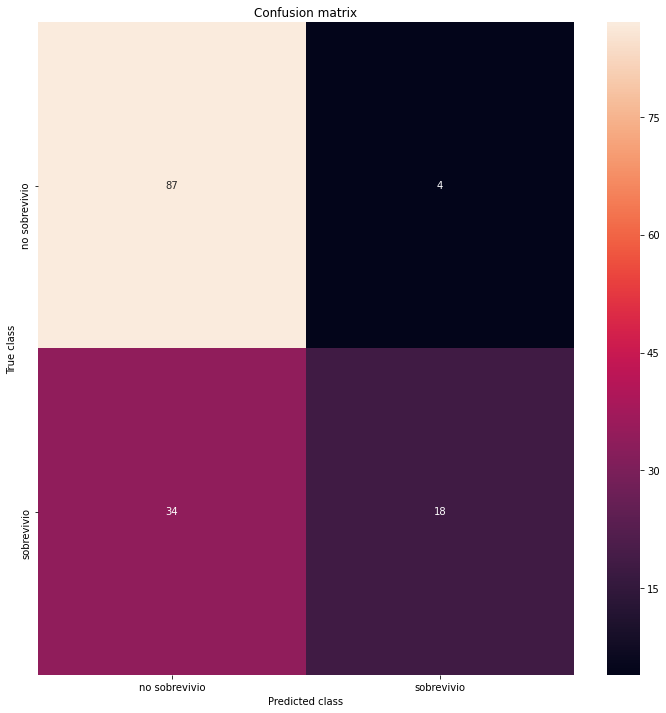

verdaderos positivos: 18
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 34
              precision    recall  f1-score   support

           0       0.72      0.96      0.82        91
           1       0.82      0.35      0.49        52

    accuracy                           0.73       143
   macro avg       0.77      0.65      0.65       143
weighted avg       0.76      0.73      0.70       143

           metrics_train  metrics_test
Accuracy        0.720562      0.734266
Precision       0.887500      0.818182
Recall:         0.321267      0.346154
F1_Score:       0.471761      0.486486


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


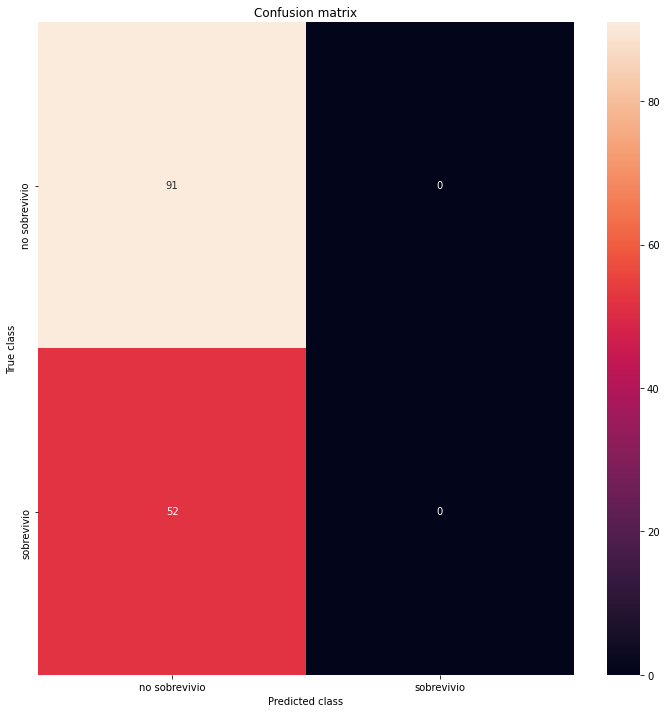

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 1.621377
Training accuracy: 0.610%
loss at step 1000: 1.484888
Training accuracy: 0.505%
Test accuracy: 0.399%


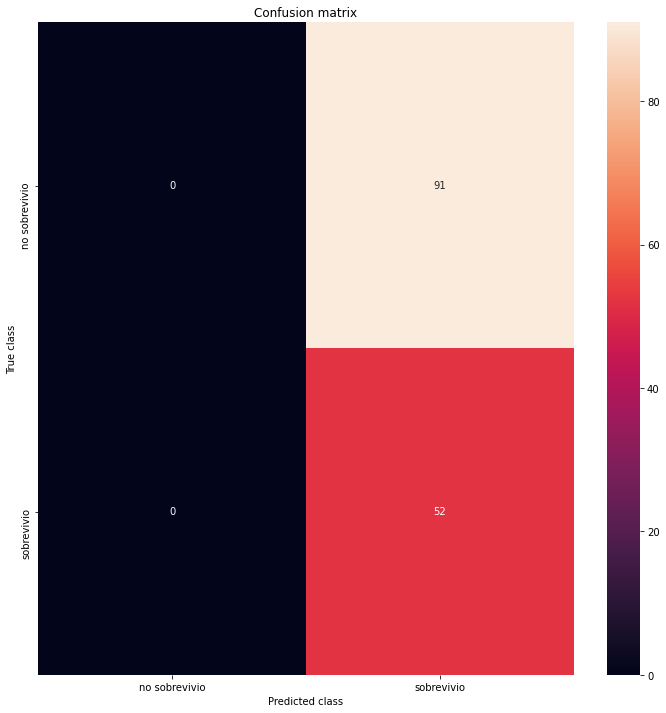

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


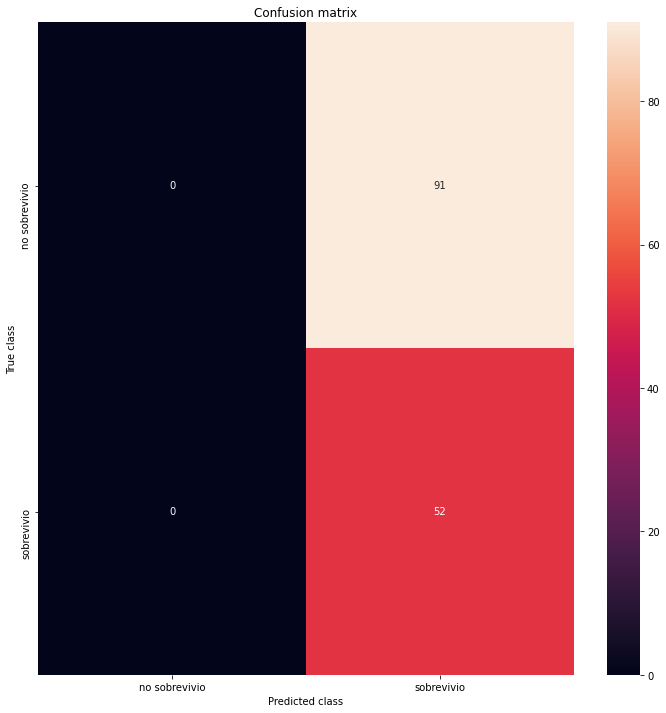

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


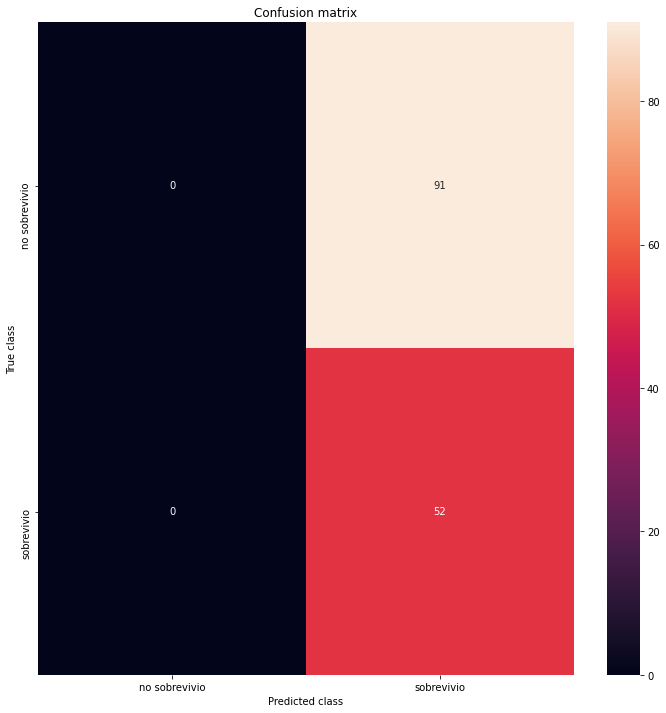

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


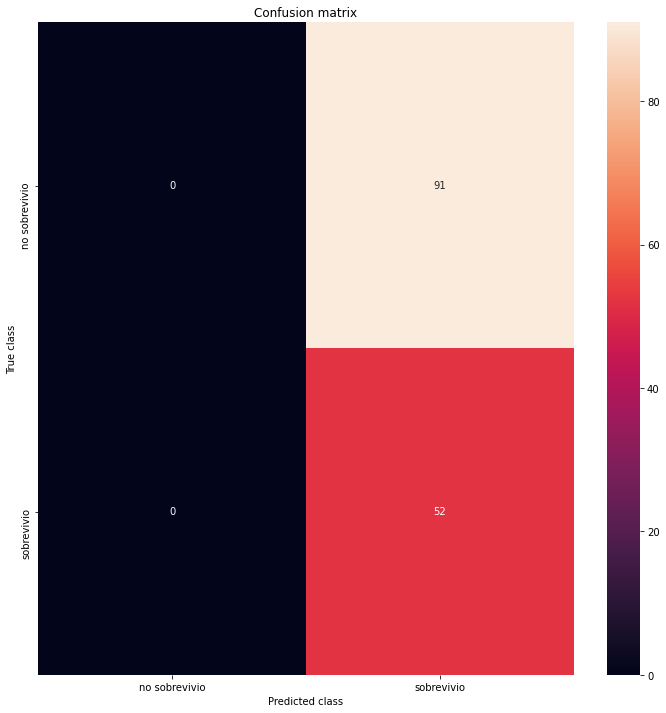

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


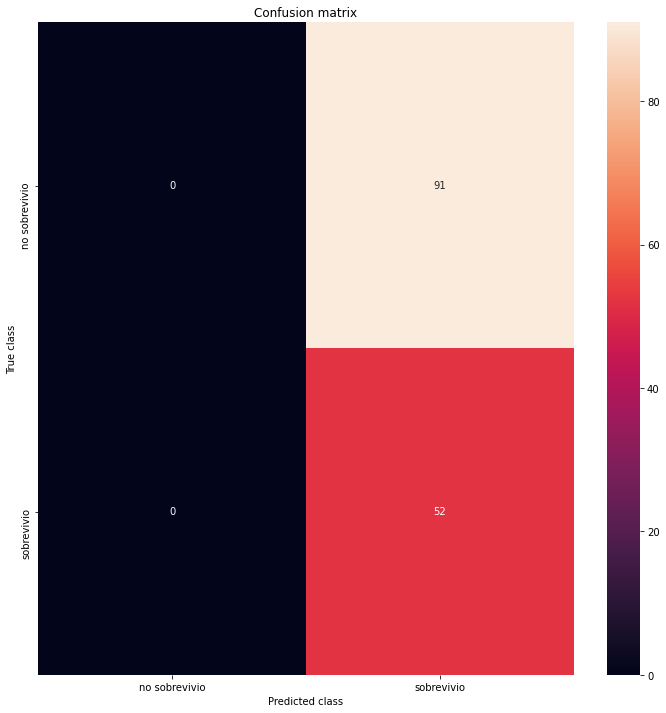

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


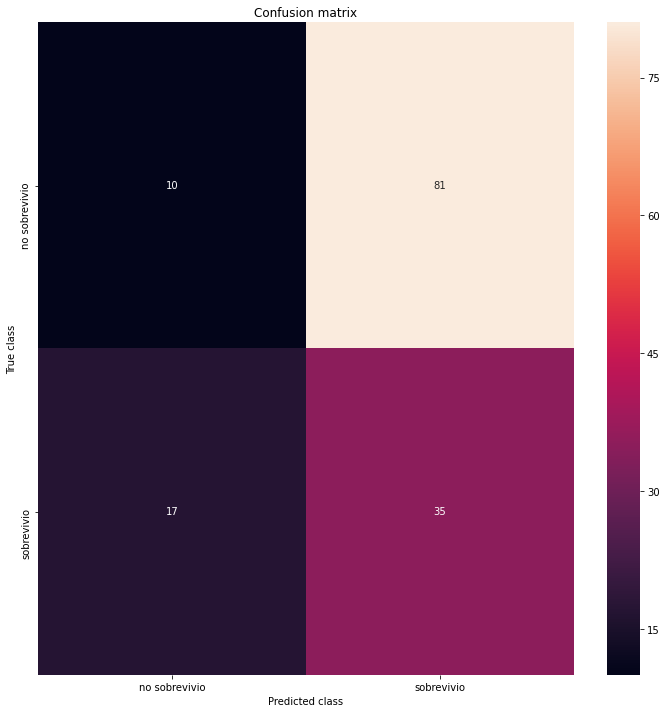

verdaderos positivos: 35
falsos positivos: 81
verdaderos negativos: 10
falsos negativos: 17
              precision    recall  f1-score   support

           0       0.37      0.11      0.17        91
           1       0.30      0.67      0.42        52

    accuracy                           0.31       143
   macro avg       0.34      0.39      0.29       143
weighted avg       0.35      0.31      0.26       143

           metrics_train  metrics_test
Accuracy        0.335677      0.314685
Precision       0.330454      0.301724
Recall:         0.692308      0.673077
F1_Score:       0.447368      0.416667


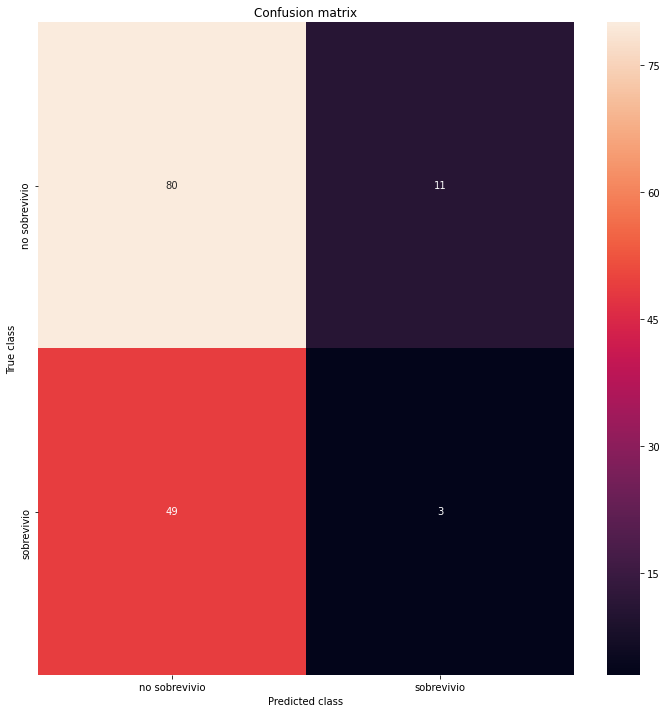

verdaderos positivos: 3
falsos positivos: 11
verdaderos negativos: 80
falsos negativos: 49
              precision    recall  f1-score   support

           0       0.62      0.88      0.73        91
           1       0.21      0.06      0.09        52

    accuracy                           0.58       143
   macro avg       0.42      0.47      0.41       143
weighted avg       0.47      0.58      0.50       143

           metrics_train  metrics_test
Accuracy        0.567663      0.580420
Precision       0.234043      0.214286
Recall:         0.049774      0.057692
F1_Score:       0.082090      0.090909


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


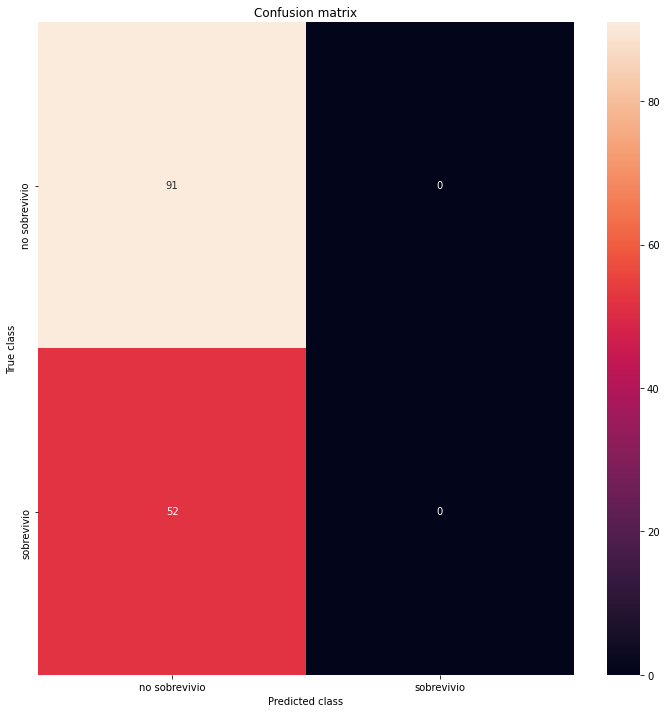

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 1.298453
Training accuracy: 0.671%
loss at step 1000: 1.720443
Training accuracy: 0.526%
Test accuracy: 0.357%


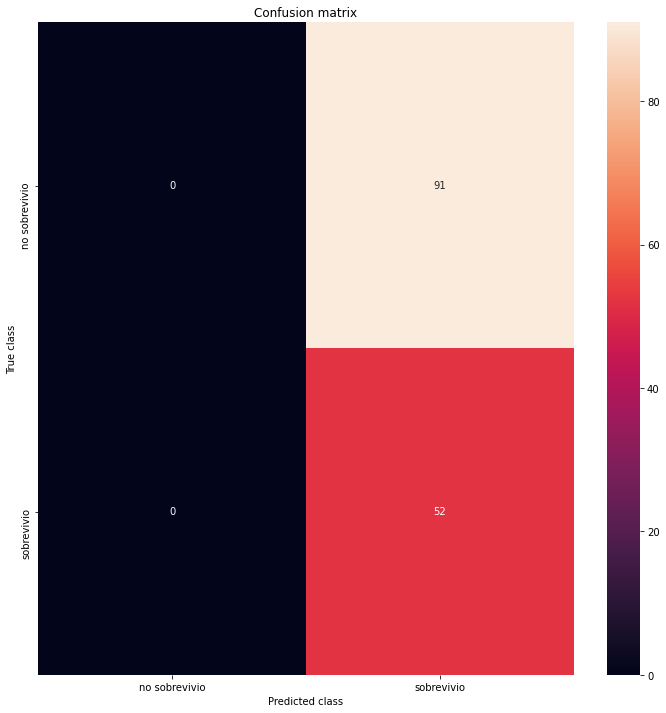

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


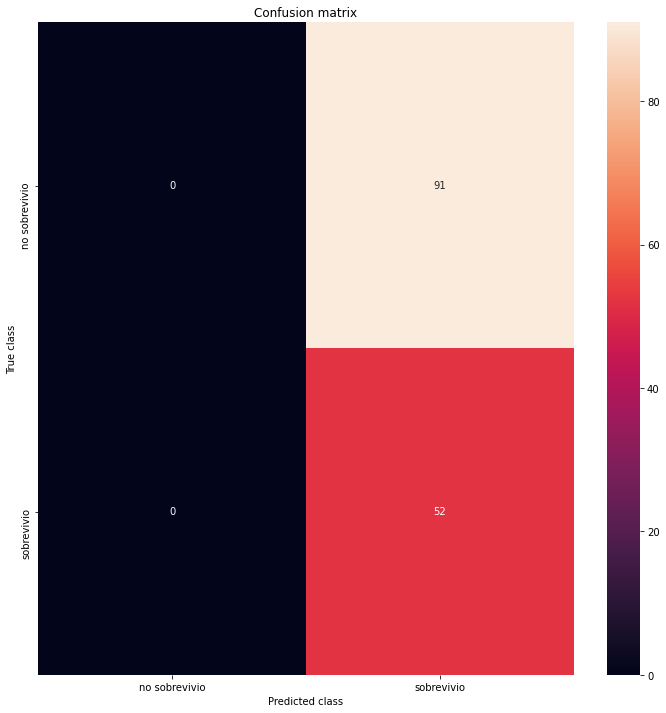

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


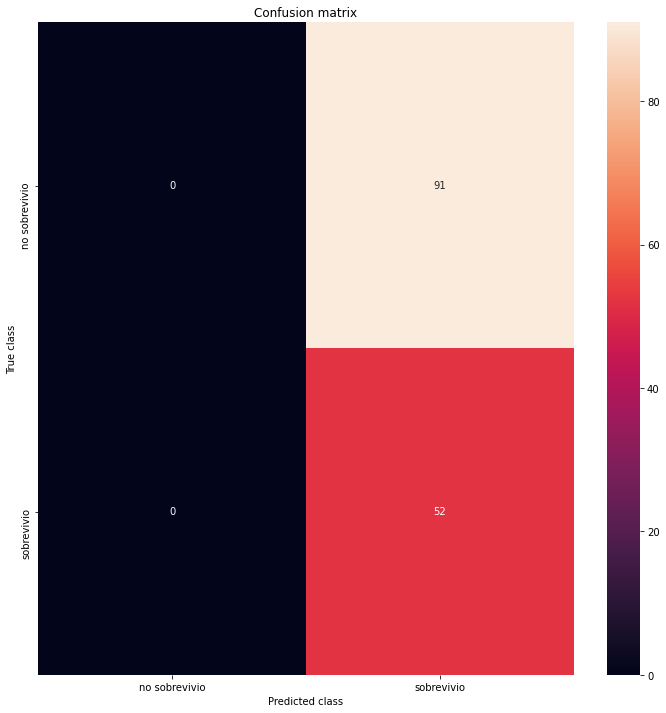

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


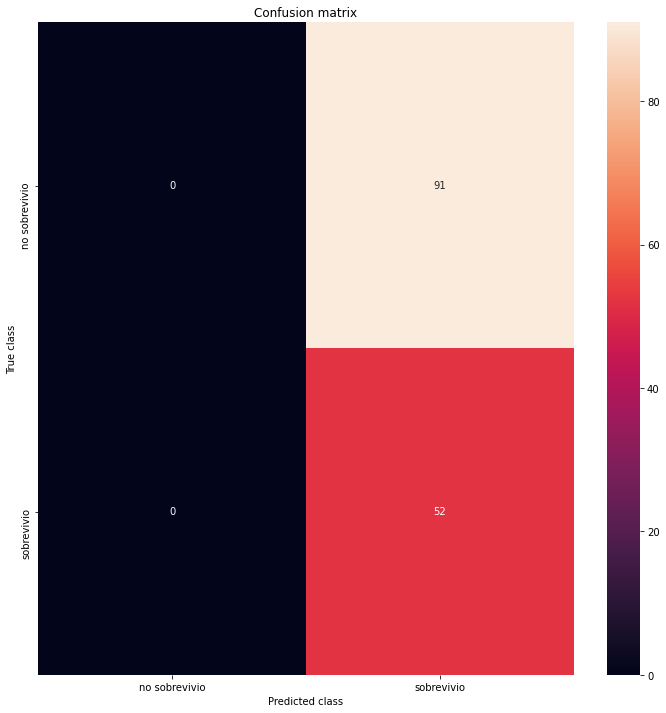

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


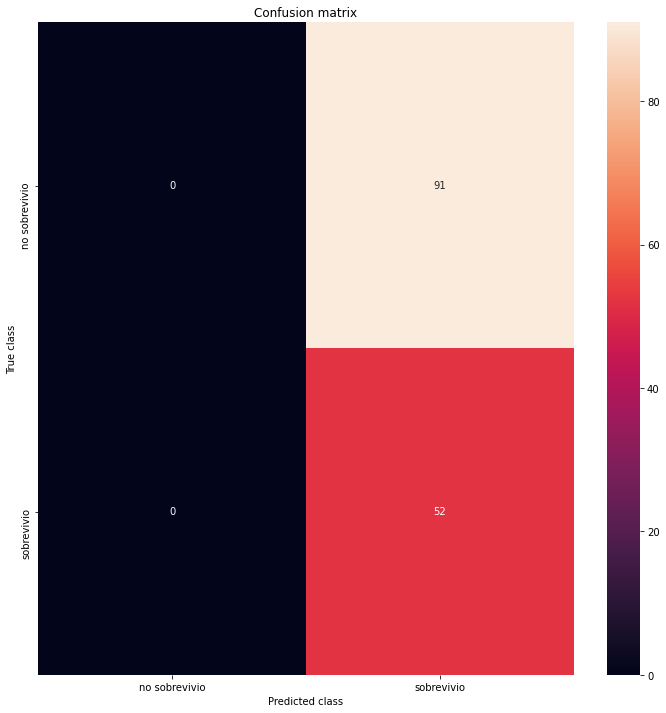

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


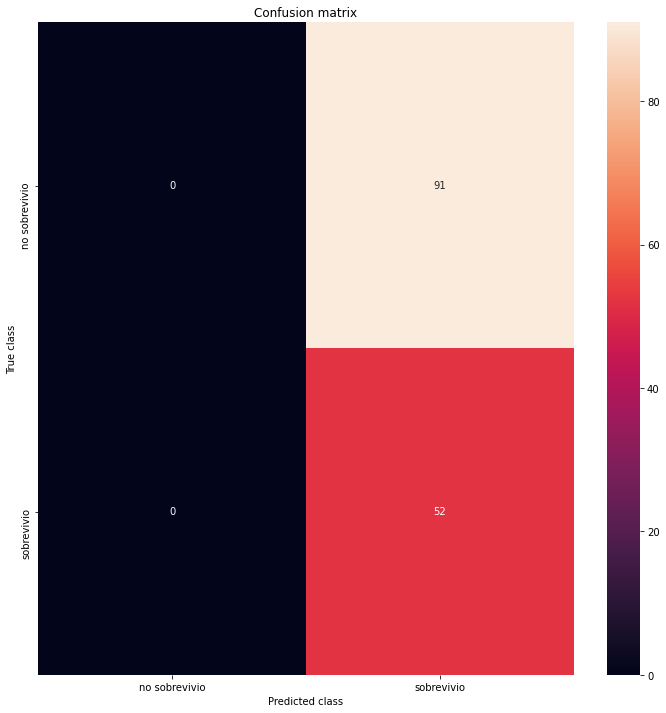

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


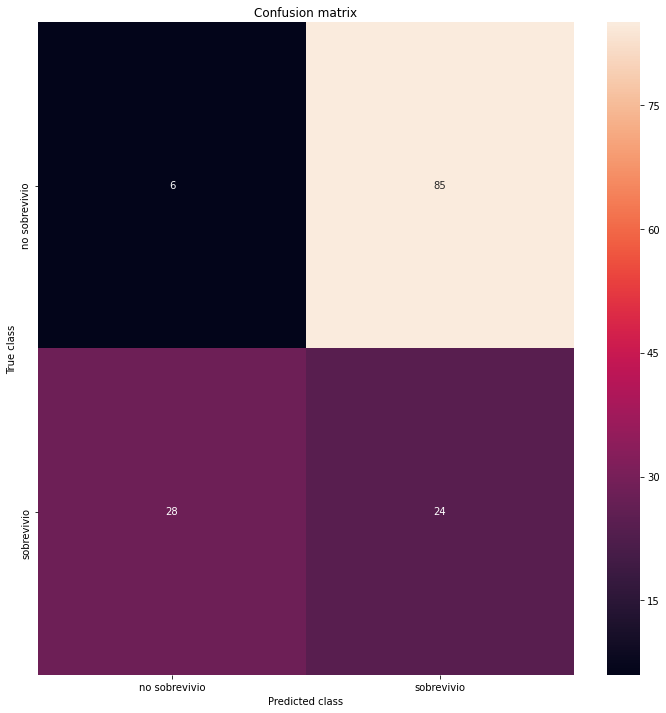

verdaderos positivos: 24
falsos positivos: 85
verdaderos negativos: 6
falsos negativos: 28
              precision    recall  f1-score   support

           0       0.18      0.07      0.10        91
           1       0.22      0.46      0.30        52

    accuracy                           0.21       143
   macro avg       0.20      0.26      0.20       143
weighted avg       0.19      0.21      0.17       143

           metrics_train  metrics_test
Accuracy        0.231986      0.209790
Precision       0.247664      0.220183
Recall:         0.479638      0.461538
F1_Score:       0.326656      0.298137


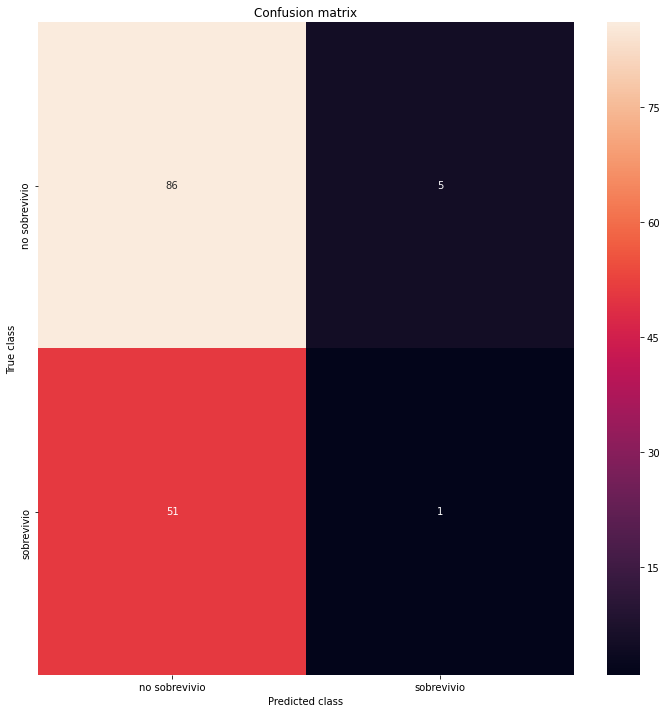

verdaderos positivos: 1
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 51
              precision    recall  f1-score   support

           0       0.63      0.95      0.75        91
           1       0.17      0.02      0.03        52

    accuracy                           0.61       143
   macro avg       0.40      0.48      0.39       143
weighted avg       0.46      0.61      0.49       143

           metrics_train  metrics_test
Accuracy        0.602812      0.608392
Precision       0.352941      0.166667
Recall:         0.027149      0.019231
F1_Score:       0.050420      0.034483
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.773171
Training accuracy: 0.367%
loss at step 1000: 0.613368
Training accuracy: 0.574%
Test accuracy: 0.839%


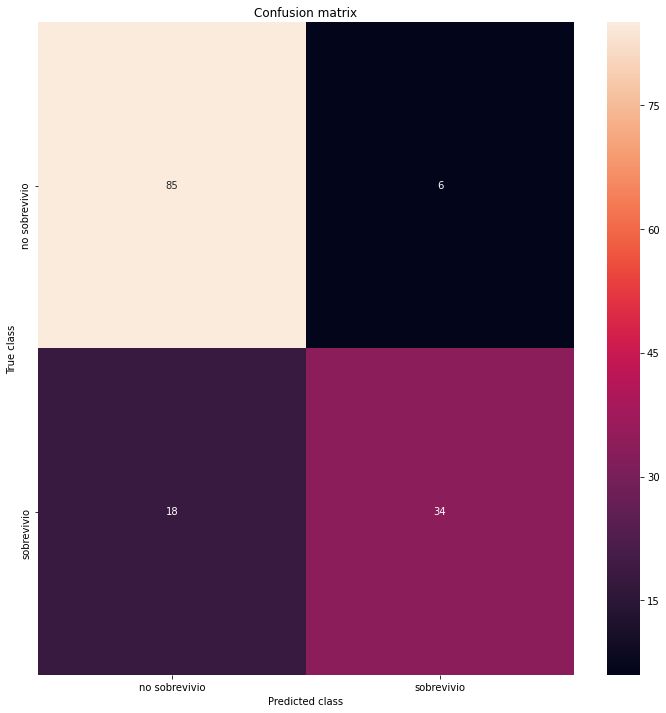

verdaderos positivos: 34
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 18
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        91
           1       0.85      0.65      0.74        52

    accuracy                           0.83       143
   macro avg       0.84      0.79      0.81       143
weighted avg       0.83      0.83      0.83       143

           metrics_train  metrics_test
Accuracy        0.792619      0.832168
Precision       0.801170      0.850000
Recall:         0.619910      0.653846
F1_Score:       0.698980      0.739130


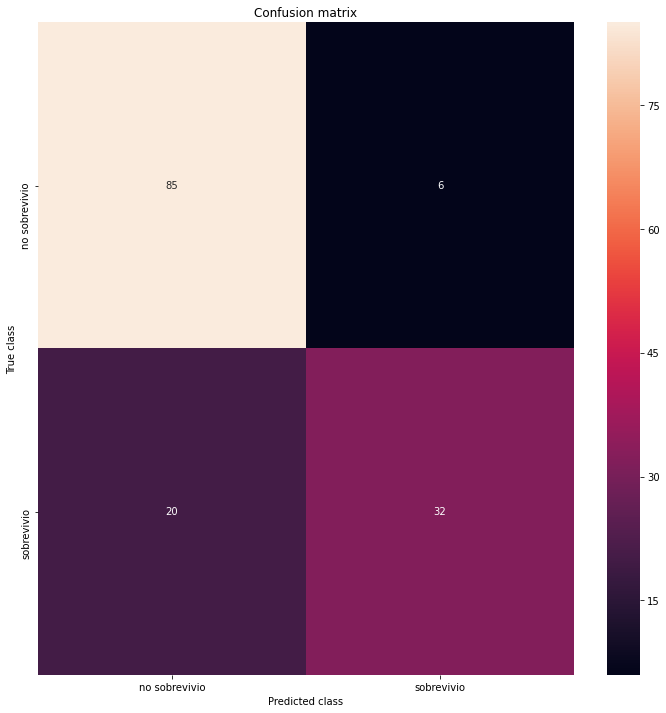

verdaderos positivos: 32
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 20
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        91
           1       0.84      0.62      0.71        52

    accuracy                           0.82       143
   macro avg       0.83      0.77      0.79       143
weighted avg       0.82      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.804921      0.818182
Precision       0.857143      0.842105
Recall:         0.597285      0.615385
F1_Score:       0.704000      0.711111


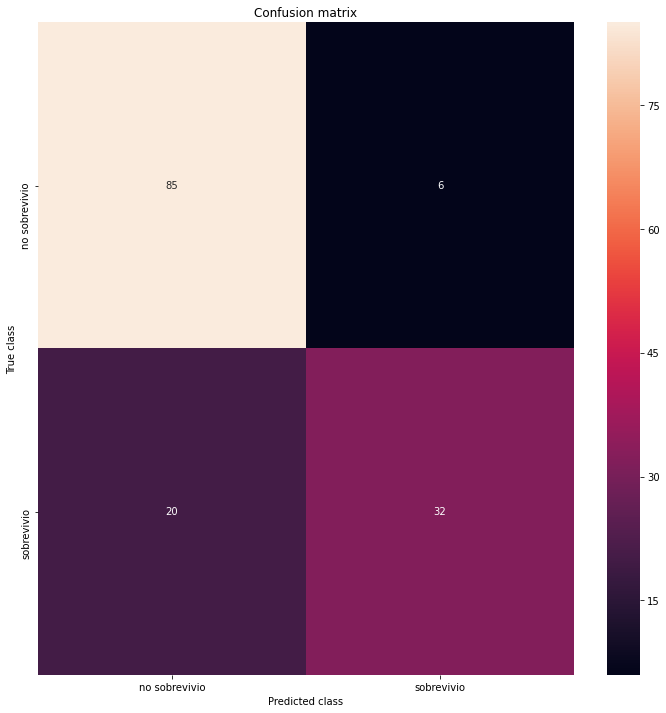

verdaderos positivos: 32
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 20
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        91
           1       0.84      0.62      0.71        52

    accuracy                           0.82       143
   macro avg       0.83      0.77      0.79       143
weighted avg       0.82      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.799649      0.818182
Precision       0.854305      0.842105
Recall:         0.583710      0.615385
F1_Score:       0.693548      0.711111


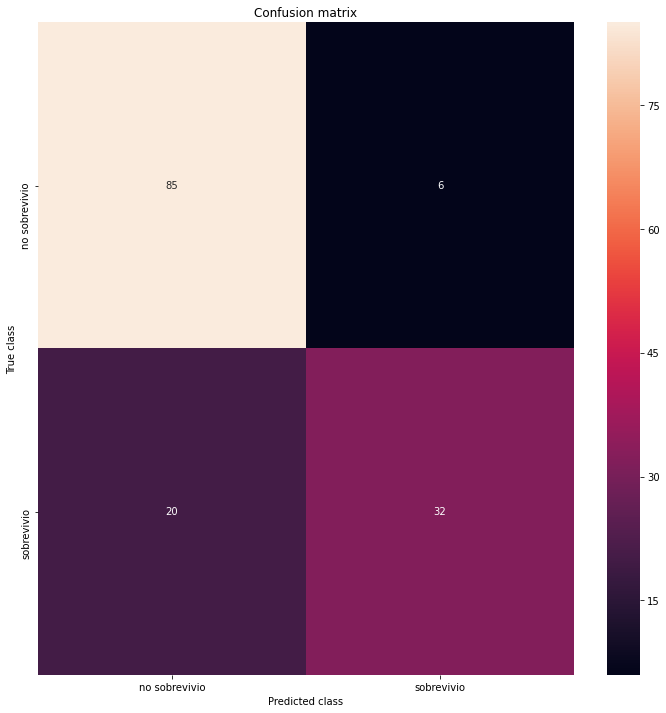

verdaderos positivos: 32
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 20
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        91
           1       0.84      0.62      0.71        52

    accuracy                           0.82       143
   macro avg       0.83      0.77      0.79       143
weighted avg       0.82      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.799649      0.818182
Precision       0.854305      0.842105
Recall:         0.583710      0.615385
F1_Score:       0.693548      0.711111


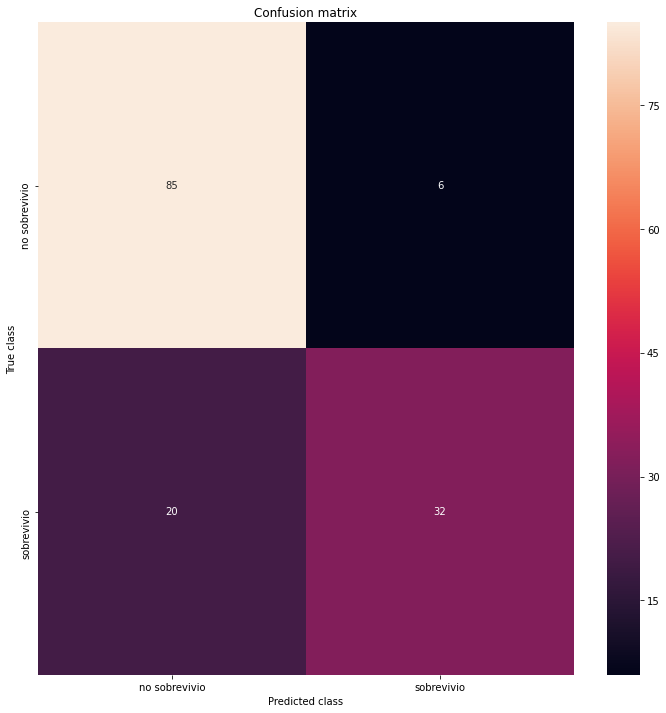

verdaderos positivos: 32
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 20
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        91
           1       0.84      0.62      0.71        52

    accuracy                           0.82       143
   macro avg       0.83      0.77      0.79       143
weighted avg       0.82      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.799649      0.818182
Precision       0.854305      0.842105
Recall:         0.583710      0.615385
F1_Score:       0.693548      0.711111


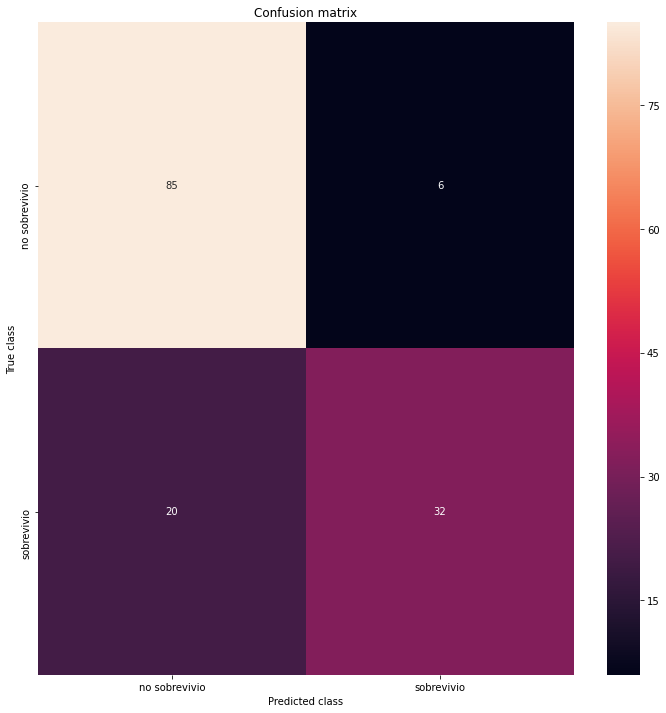

verdaderos positivos: 32
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 20
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        91
           1       0.84      0.62      0.71        52

    accuracy                           0.82       143
   macro avg       0.83      0.77      0.79       143
weighted avg       0.82      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.799649      0.818182
Precision       0.854305      0.842105
Recall:         0.583710      0.615385
F1_Score:       0.693548      0.711111


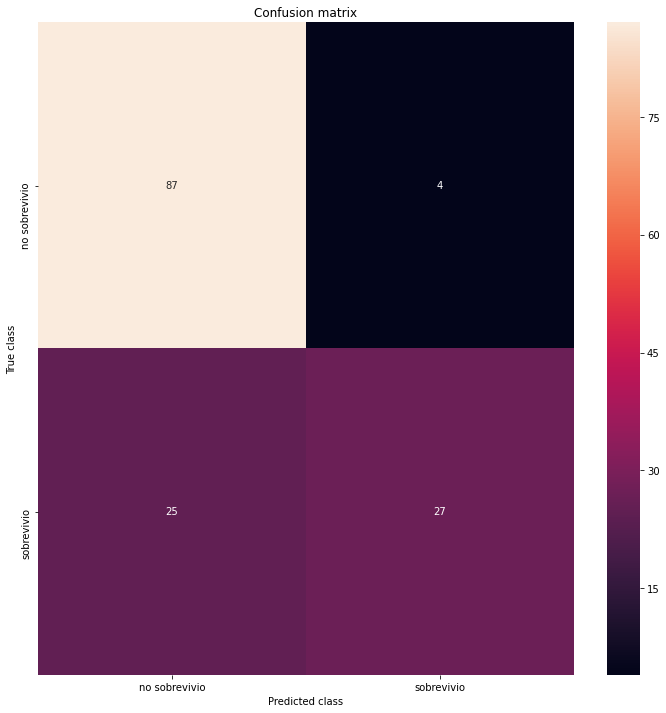

verdaderos positivos: 27
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.78      0.96      0.86        91
           1       0.87      0.52      0.65        52

    accuracy                           0.80       143
   macro avg       0.82      0.74      0.75       143
weighted avg       0.81      0.80      0.78       143

           metrics_train  metrics_test
Accuracy        0.787346      0.797203
Precision       0.931034      0.870968
Recall:         0.488688      0.519231
F1_Score:       0.640950      0.650602


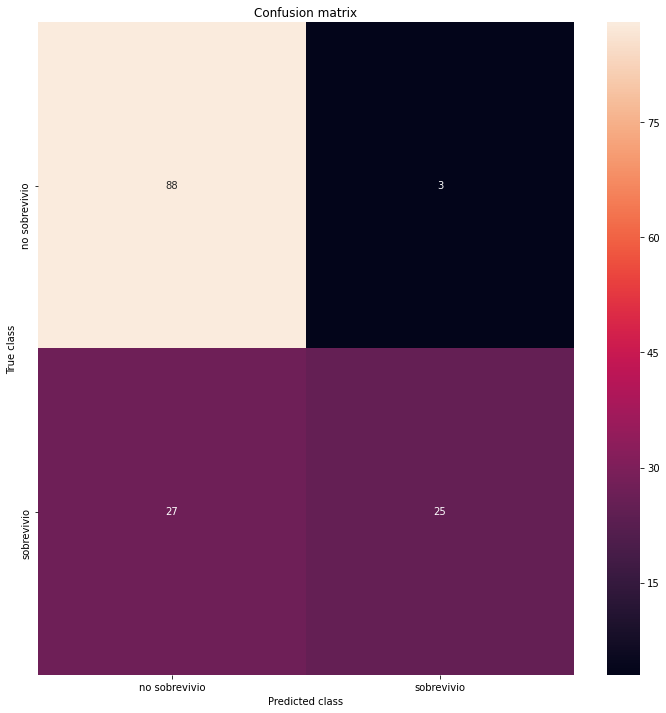

verdaderos positivos: 25
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.77      0.97      0.85        91
           1       0.89      0.48      0.62        52

    accuracy                           0.79       143
   macro avg       0.83      0.72      0.74       143
weighted avg       0.81      0.79      0.77       143

           metrics_train  metrics_test
Accuracy        0.776801      0.790210
Precision       0.951923      0.892857
Recall:         0.447964      0.480769
F1_Score:       0.609231      0.625000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.792326
Training accuracy: 0.438%
loss at step 1000: 0.510981
Training accuracy: 0.621%
Test accuracy: 0.825%


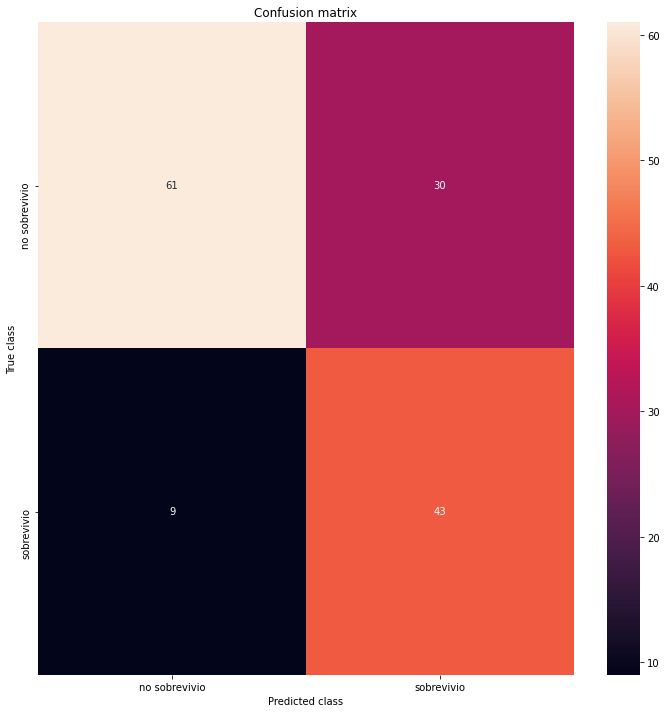

verdaderos positivos: 43
falsos positivos: 30
verdaderos negativos: 61
falsos negativos: 9
              precision    recall  f1-score   support

           0       0.87      0.67      0.76        91
           1       0.59      0.83      0.69        52

    accuracy                           0.73       143
   macro avg       0.73      0.75      0.72       143
weighted avg       0.77      0.73      0.73       143

           metrics_train  metrics_test
Accuracy        0.671353      0.727273
Precision       0.553459      0.589041
Recall:         0.796380      0.826923
F1_Score:       0.653061      0.688000


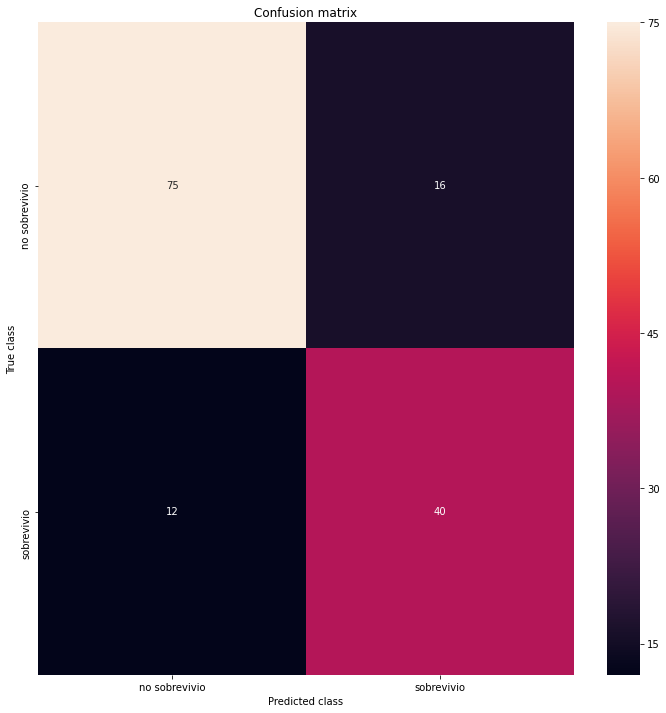

verdaderos positivos: 40
falsos positivos: 16
verdaderos negativos: 75
falsos negativos: 12
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        91
           1       0.71      0.77      0.74        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.759227      0.804196
Precision       0.684211      0.714286
Recall:         0.705882      0.769231
F1_Score:       0.694878      0.740741


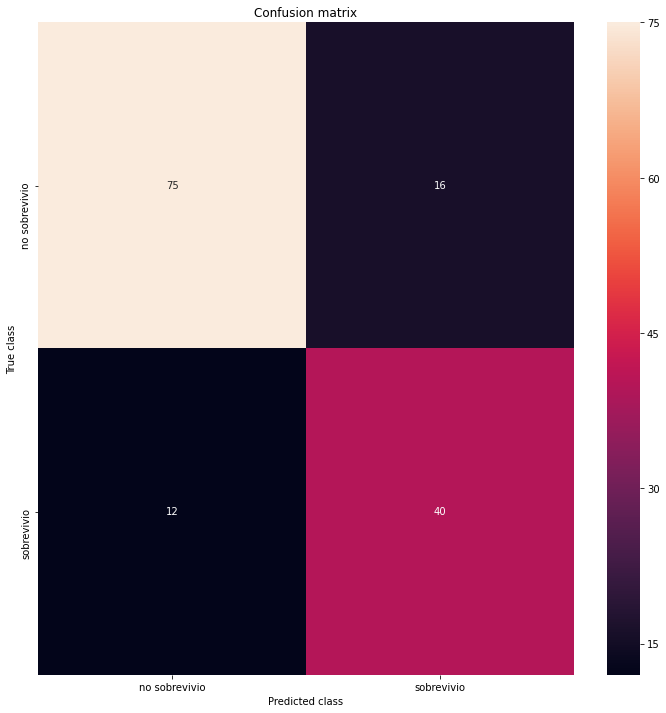

verdaderos positivos: 40
falsos positivos: 16
verdaderos negativos: 75
falsos negativos: 12
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        91
           1       0.71      0.77      0.74        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.760984      0.804196
Precision       0.688889      0.714286
Recall:         0.701357      0.769231
F1_Score:       0.695067      0.740741


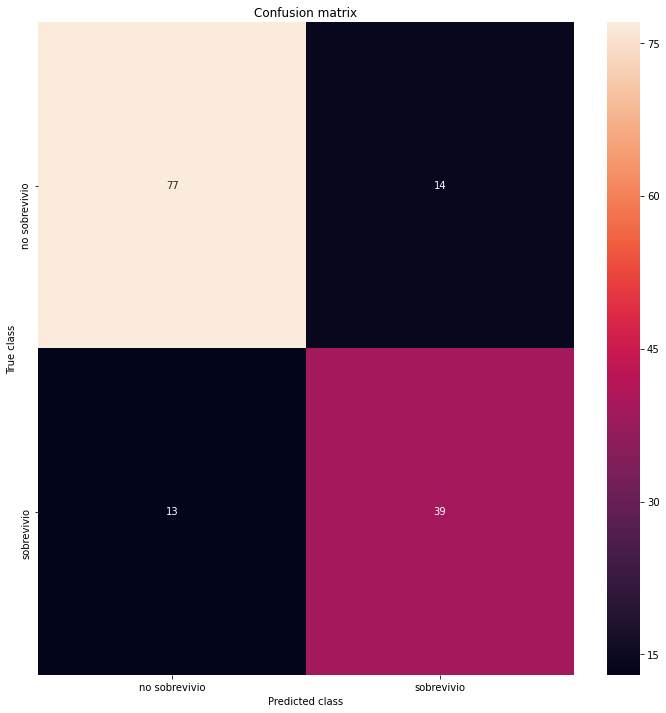

verdaderos positivos: 39
falsos positivos: 14
verdaderos negativos: 77
falsos negativos: 13
              precision    recall  f1-score   support

           0       0.86      0.85      0.85        91
           1       0.74      0.75      0.74        52

    accuracy                           0.81       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.81      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.773286      0.811189
Precision       0.719048      0.735849
Recall:         0.683258      0.750000
F1_Score:       0.700696      0.742857


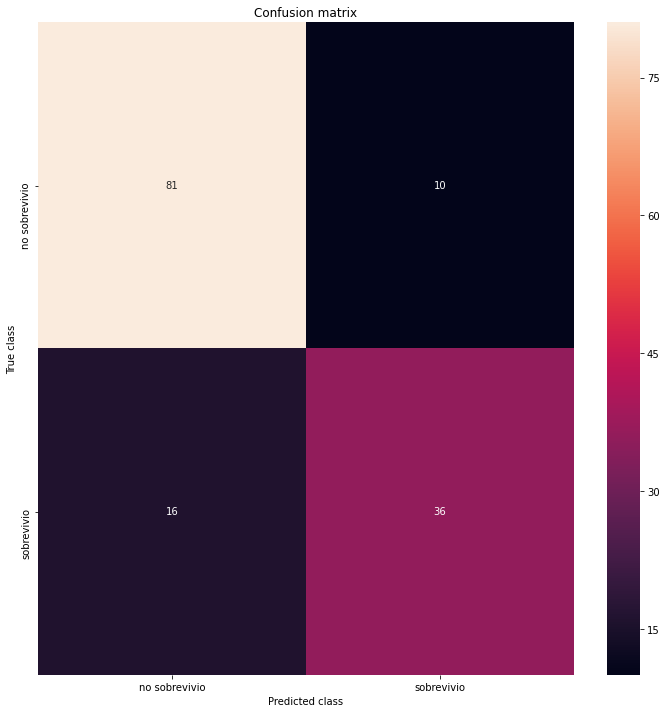

verdaderos positivos: 36
falsos positivos: 10
verdaderos negativos: 81
falsos negativos: 16
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        91
           1       0.78      0.69      0.73        52

    accuracy                           0.82       143
   macro avg       0.81      0.79      0.80       143
weighted avg       0.82      0.82      0.82       143

           metrics_train  metrics_test
Accuracy        0.794376      0.818182
Precision       0.785714      0.782609
Recall:         0.647059      0.692308
F1_Score:       0.709677      0.734694


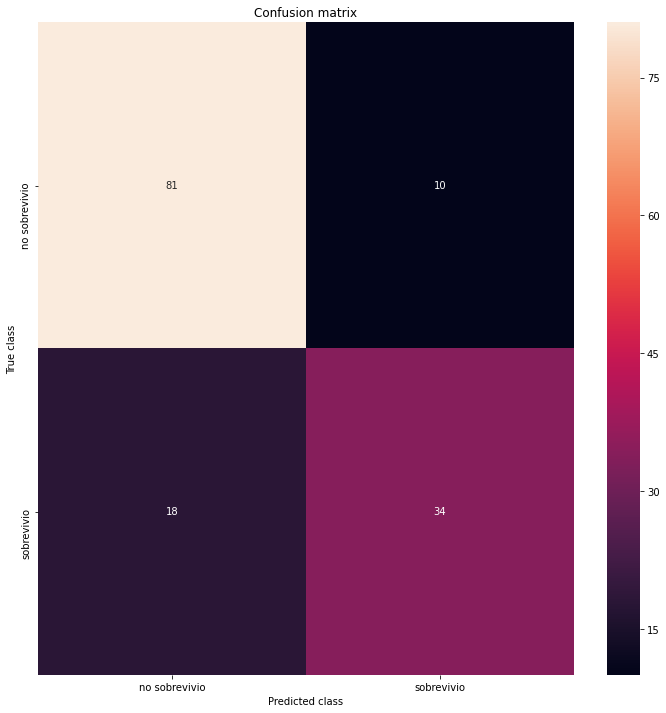

verdaderos positivos: 34
falsos positivos: 10
verdaderos negativos: 81
falsos negativos: 18
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        91
           1       0.77      0.65      0.71        52

    accuracy                           0.80       143
   macro avg       0.80      0.77      0.78       143
weighted avg       0.80      0.80      0.80       143

           metrics_train  metrics_test
Accuracy        0.801406      0.804196
Precision       0.821429      0.772727
Recall:         0.624434      0.653846
F1_Score:       0.709512      0.708333


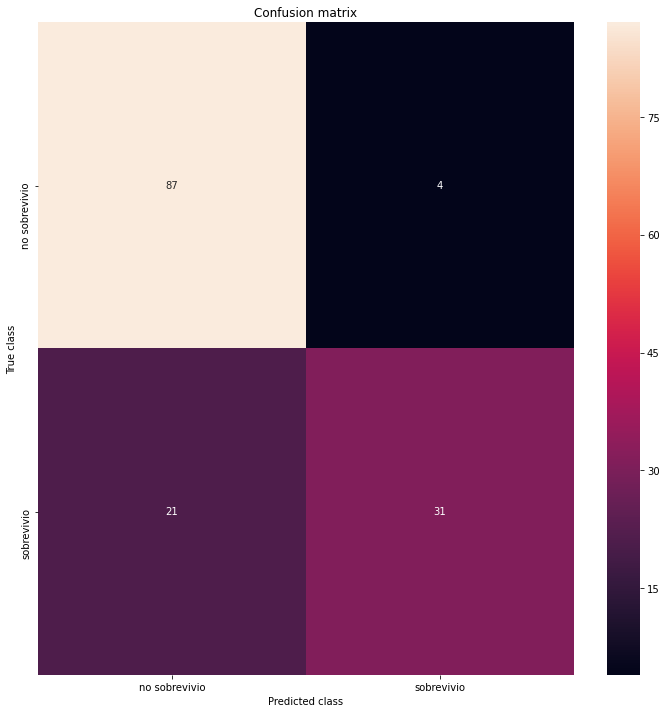

verdaderos positivos: 31
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 21
              precision    recall  f1-score   support

           0       0.81      0.96      0.87        91
           1       0.89      0.60      0.71        52

    accuracy                           0.83       143
   macro avg       0.85      0.78      0.79       143
weighted avg       0.83      0.83      0.82       143

           metrics_train  metrics_test
Accuracy        0.804921      0.825175
Precision       0.910448      0.885714
Recall:         0.552036      0.596154
F1_Score:       0.687324      0.712644


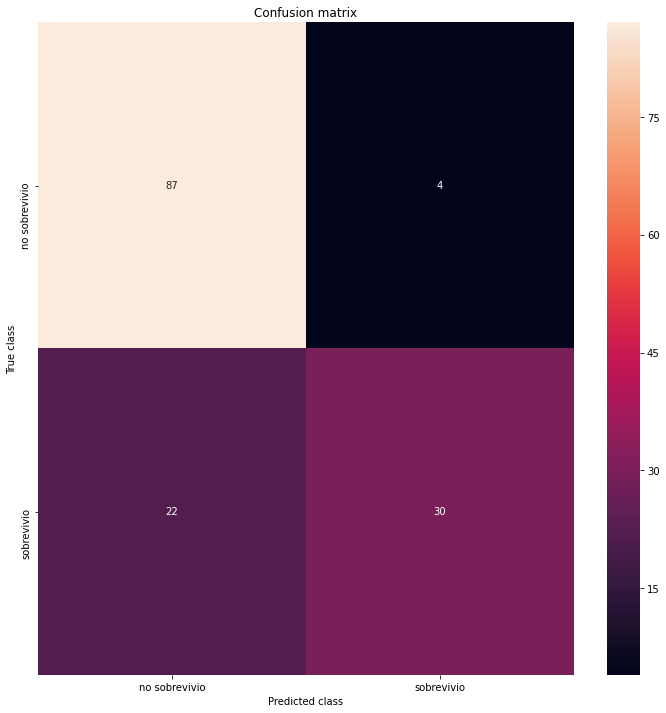

verdaderos positivos: 30
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 22
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        91
           1       0.88      0.58      0.70        52

    accuracy                           0.82       143
   macro avg       0.84      0.77      0.78       143
weighted avg       0.83      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.797891      0.818182
Precision       0.920635      0.882353
Recall:         0.524887      0.576923
F1_Score:       0.668588      0.697674
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.776011
Training accuracy: 0.367%
loss at step 1000: 0.631774
Training accuracy: 0.572%
Test accuracy: 0.839%


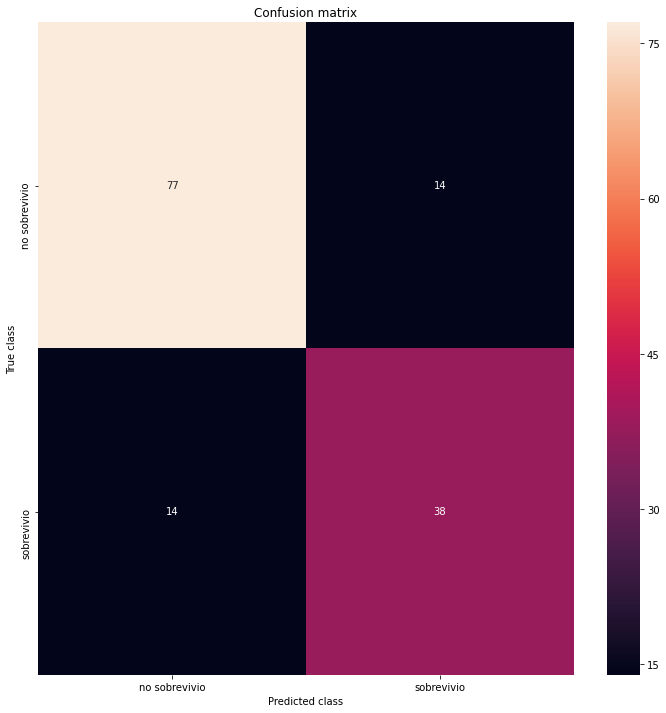

verdaderos positivos: 38
falsos positivos: 14
verdaderos negativos: 77
falsos negativos: 14
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        91
           1       0.73      0.73      0.73        52

    accuracy                           0.80       143
   macro avg       0.79      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143

           metrics_train  metrics_test
Accuracy        0.755712      0.804196
Precision       0.684685      0.730769
Recall:         0.687783      0.730769
F1_Score:       0.686230      0.730769


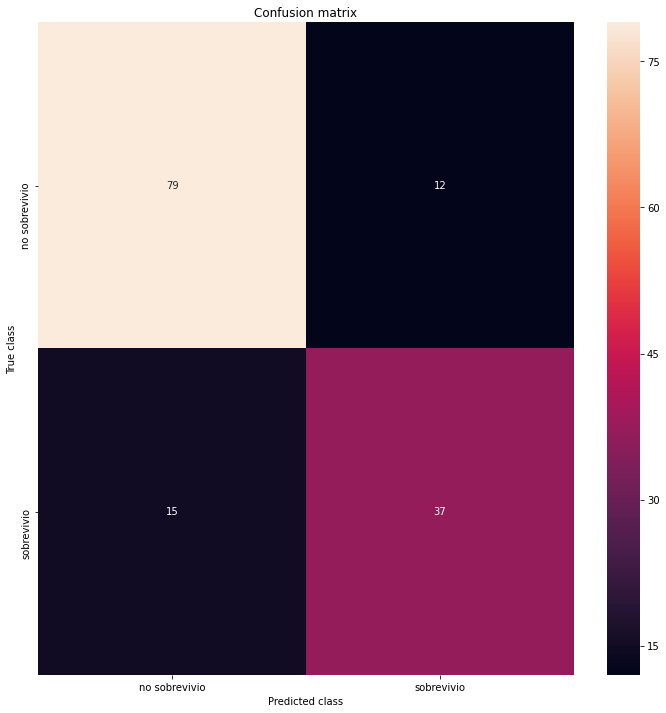

verdaderos positivos: 37
falsos positivos: 12
verdaderos negativos: 79
falsos negativos: 15
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        91
           1       0.76      0.71      0.73        52

    accuracy                           0.81       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.81      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.768014      0.811189
Precision       0.717073      0.755102
Recall:         0.665158      0.711538
F1_Score:       0.690141      0.732673


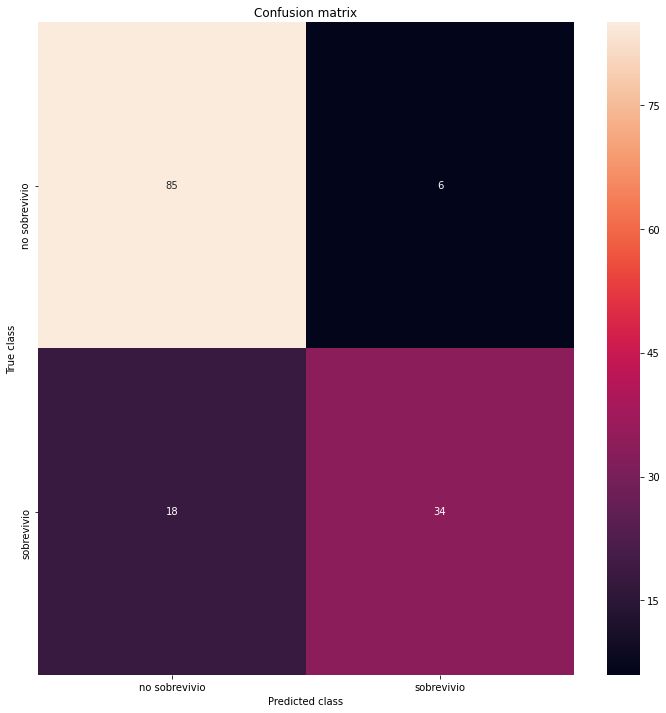

verdaderos positivos: 34
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 18
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        91
           1       0.85      0.65      0.74        52

    accuracy                           0.83       143
   macro avg       0.84      0.79      0.81       143
weighted avg       0.83      0.83      0.83       143

           metrics_train  metrics_test
Accuracy        0.792619      0.832168
Precision       0.804734      0.850000
Recall:         0.615385      0.653846
F1_Score:       0.697436      0.739130


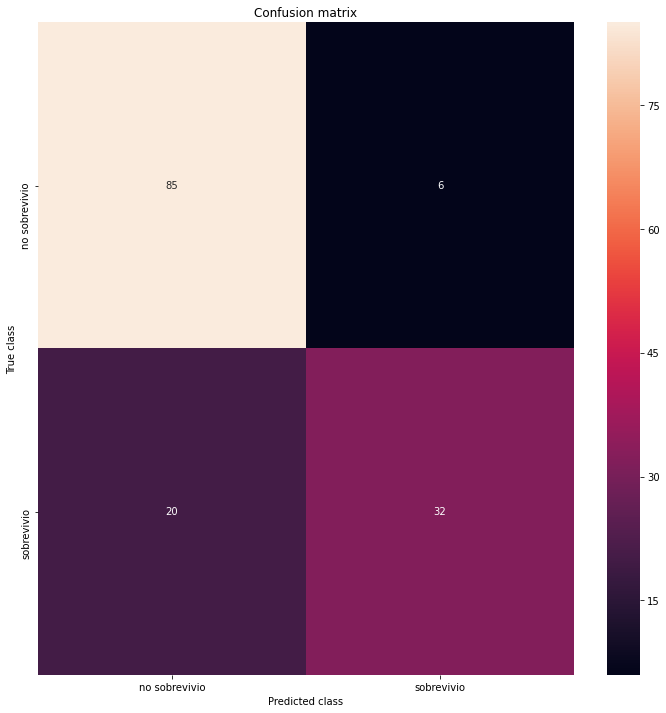

verdaderos positivos: 32
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 20
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        91
           1       0.84      0.62      0.71        52

    accuracy                           0.82       143
   macro avg       0.83      0.77      0.79       143
weighted avg       0.82      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.804921      0.818182
Precision       0.857143      0.842105
Recall:         0.597285      0.615385
F1_Score:       0.704000      0.711111


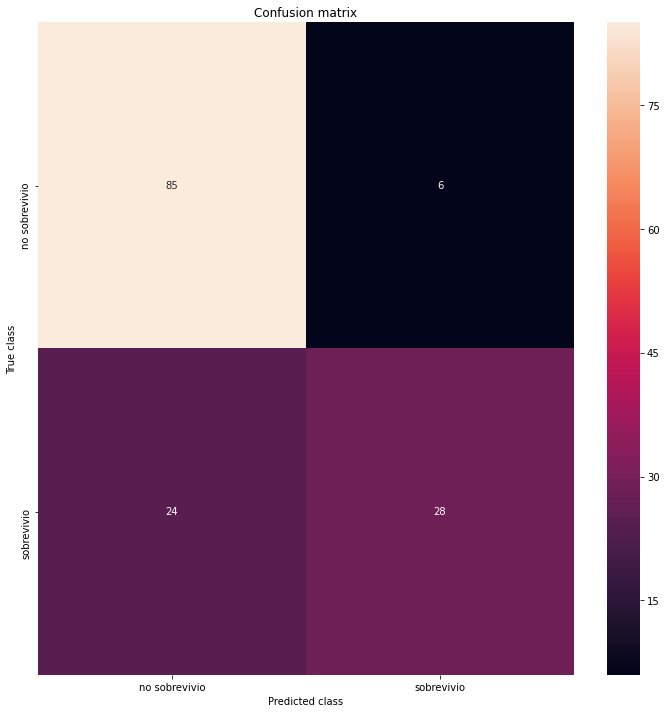

verdaderos positivos: 28
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 24
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        91
           1       0.82      0.54      0.65        52

    accuracy                           0.79       143
   macro avg       0.80      0.74      0.75       143
weighted avg       0.80      0.79      0.78       143

           metrics_train  metrics_test
Accuracy        0.783831      0.790210
Precision       0.865672      0.823529
Recall:         0.524887      0.538462
F1_Score:       0.653521      0.651163


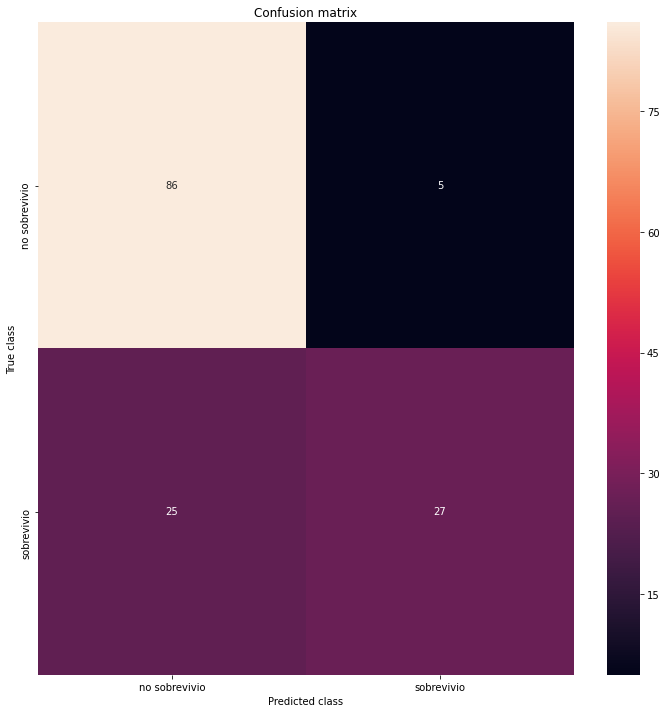

verdaderos positivos: 27
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.77      0.95      0.85        91
           1       0.84      0.52      0.64        52

    accuracy                           0.79       143
   macro avg       0.81      0.73      0.75       143
weighted avg       0.80      0.79      0.78       143

           metrics_train  metrics_test
Accuracy        0.778559      0.790210
Precision       0.868217      0.843750
Recall:         0.506787      0.519231
F1_Score:       0.640000      0.642857


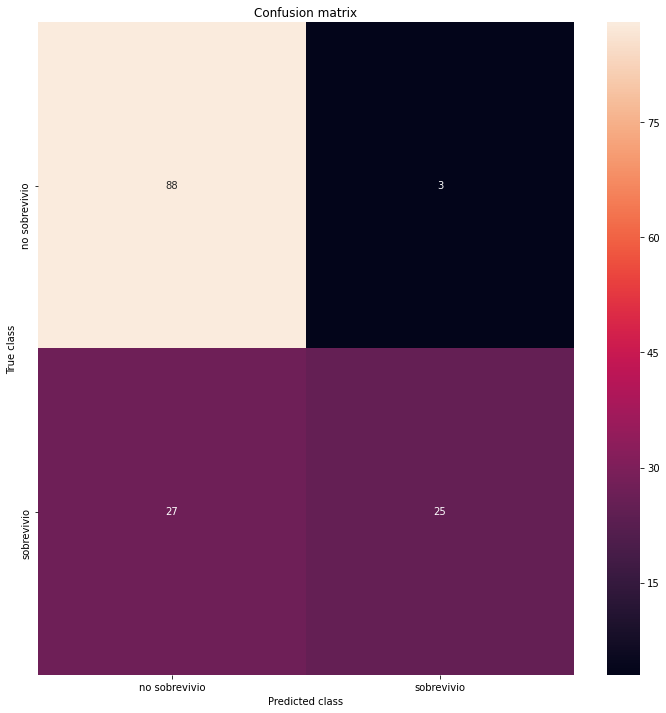

verdaderos positivos: 25
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.77      0.97      0.85        91
           1       0.89      0.48      0.62        52

    accuracy                           0.79       143
   macro avg       0.83      0.72      0.74       143
weighted avg       0.81      0.79      0.77       143

           metrics_train  metrics_test
Accuracy        0.776801      0.790210
Precision       0.951923      0.892857
Recall:         0.447964      0.480769
F1_Score:       0.609231      0.625000


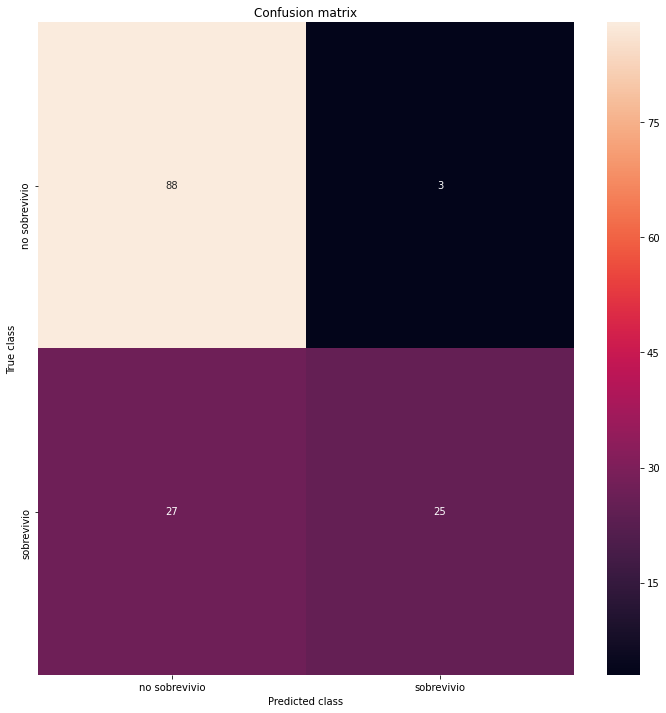

verdaderos positivos: 25
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.77      0.97      0.85        91
           1       0.89      0.48      0.62        52

    accuracy                           0.79       143
   macro avg       0.83      0.72      0.74       143
weighted avg       0.81      0.79      0.77       143

           metrics_train  metrics_test
Accuracy        0.776801      0.790210
Precision       0.951923      0.892857
Recall:         0.447964      0.480769
F1_Score:       0.609231      0.625000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.793242
Training accuracy: 0.438%
loss at step 1000: 0.521571
Training accuracy: 0.617%
Test accuracy: 0.839%


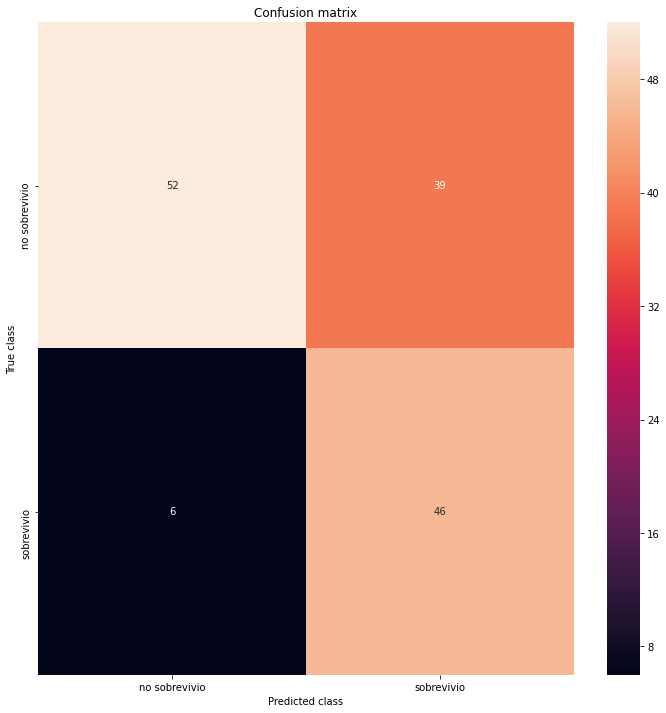

verdaderos positivos: 46
falsos positivos: 39
verdaderos negativos: 52
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.90      0.57      0.70        91
           1       0.54      0.88      0.67        52

    accuracy                           0.69       143
   macro avg       0.72      0.73      0.68       143
weighted avg       0.77      0.69      0.69       143

           metrics_train  metrics_test
Accuracy        0.659051      0.685315
Precision       0.538905      0.541176
Recall:         0.846154      0.884615
F1_Score:       0.658451      0.671533


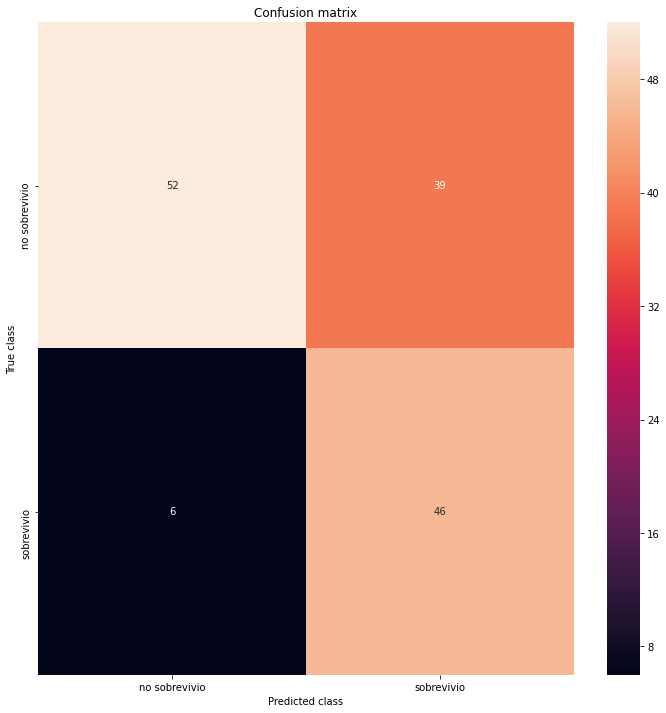

verdaderos positivos: 46
falsos positivos: 39
verdaderos negativos: 52
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.90      0.57      0.70        91
           1       0.54      0.88      0.67        52

    accuracy                           0.69       143
   macro avg       0.72      0.73      0.68       143
weighted avg       0.77      0.69      0.69       143

           metrics_train  metrics_test
Accuracy        0.660808      0.685315
Precision       0.540462      0.541176
Recall:         0.846154      0.884615
F1_Score:       0.659612      0.671533


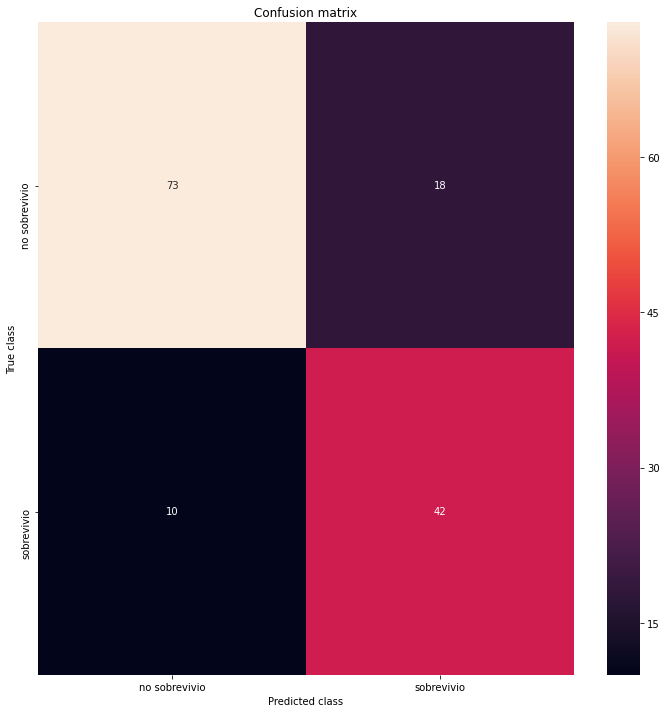

verdaderos positivos: 42
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        91
           1       0.70      0.81      0.75        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.764499      0.804196
Precision       0.677551      0.700000
Recall:         0.751131      0.807692
F1_Score:       0.712446      0.750000


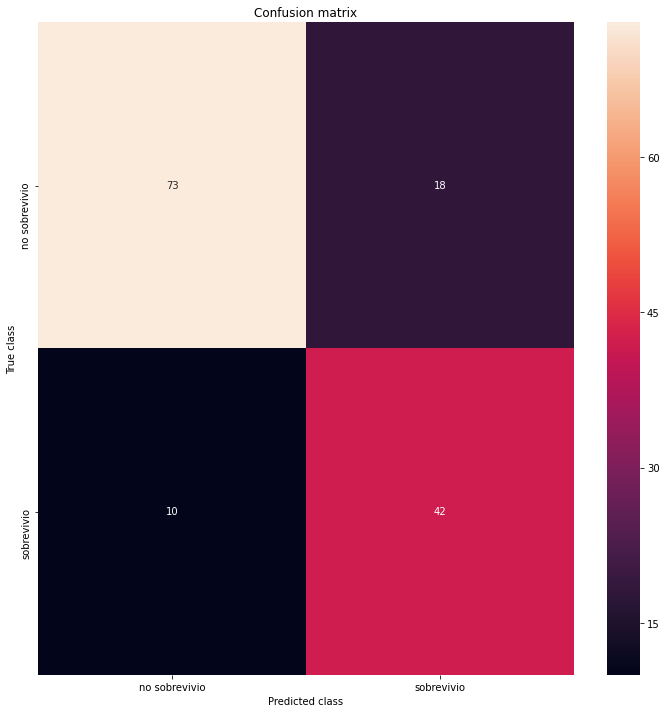

verdaderos positivos: 42
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        91
           1       0.70      0.81      0.75        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.764499      0.804196
Precision       0.677551      0.700000
Recall:         0.751131      0.807692
F1_Score:       0.712446      0.750000


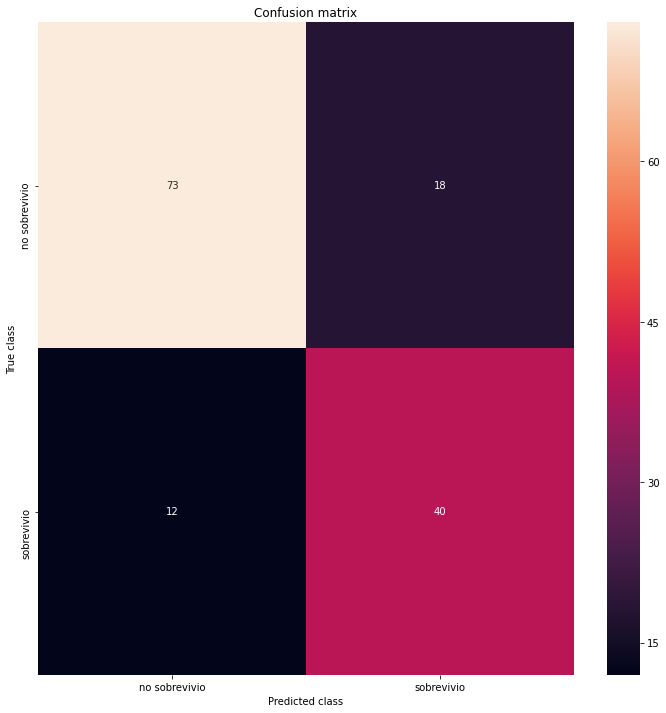

verdaderos positivos: 40
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 12
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        91
           1       0.69      0.77      0.73        52

    accuracy                           0.79       143
   macro avg       0.77      0.79      0.78       143
weighted avg       0.80      0.79      0.79       143

           metrics_train  metrics_test
Accuracy        0.757469      0.790210
Precision       0.676596      0.689655
Recall:         0.719457      0.769231
F1_Score:       0.697368      0.727273


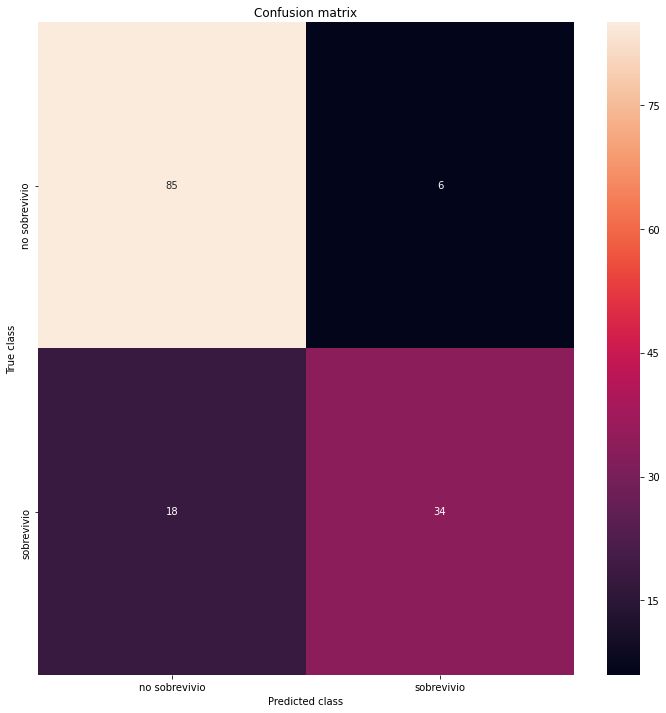

verdaderos positivos: 34
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 18
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        91
           1       0.85      0.65      0.74        52

    accuracy                           0.83       143
   macro avg       0.84      0.79      0.81       143
weighted avg       0.83      0.83      0.83       143

           metrics_train  metrics_test
Accuracy        0.796134      0.832168
Precision       0.814371      0.850000
Recall:         0.615385      0.653846
F1_Score:       0.701031      0.739130


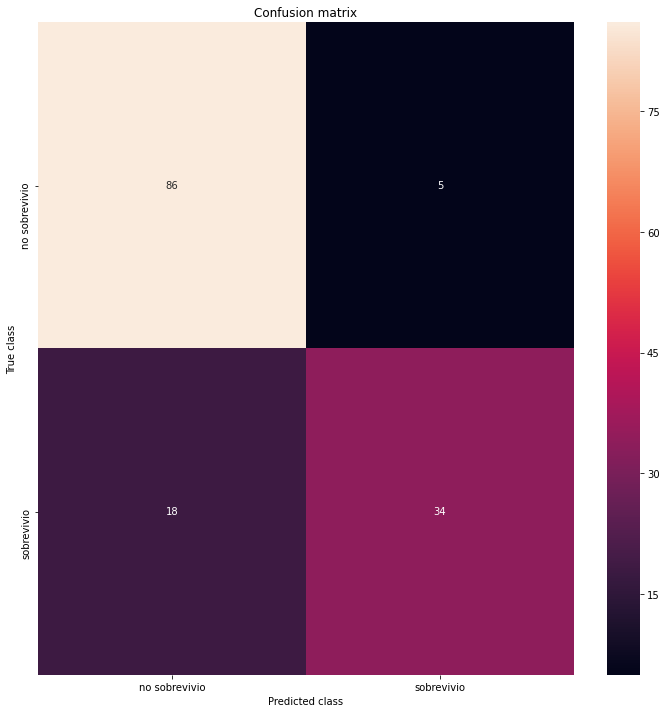

verdaderos positivos: 34
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 18
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        91
           1       0.87      0.65      0.75        52

    accuracy                           0.84       143
   macro avg       0.85      0.80      0.81       143
weighted avg       0.84      0.84      0.83       143

           metrics_train  metrics_test
Accuracy        0.796134      0.839161
Precision       0.830189      0.871795
Recall:         0.597285      0.653846
F1_Score:       0.694737      0.747253


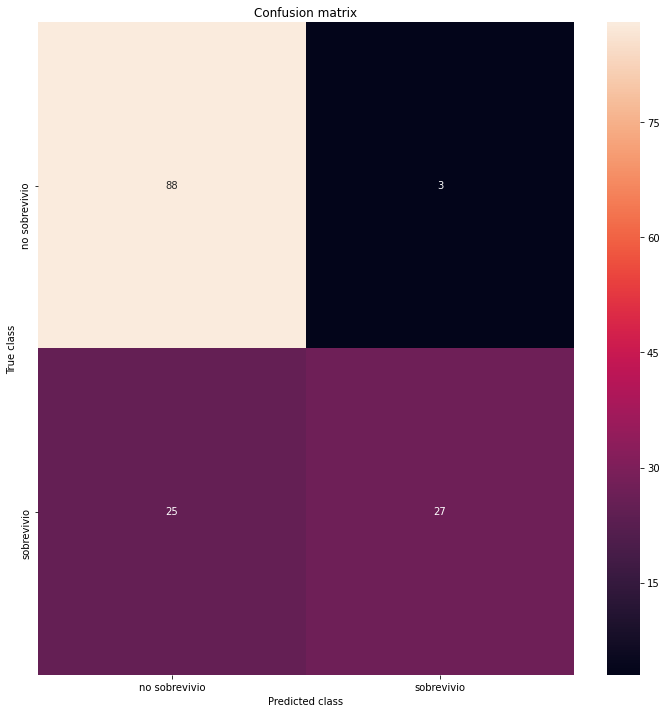

verdaderos positivos: 27
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.78      0.97      0.86        91
           1       0.90      0.52      0.66        52

    accuracy                           0.80       143
   macro avg       0.84      0.74      0.76       143
weighted avg       0.82      0.80      0.79       143

           metrics_train  metrics_test
Accuracy        0.787346      0.804196
Precision       0.938596      0.900000
Recall:         0.484163      0.519231
F1_Score:       0.638806      0.658537
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.778780
Training accuracy: 0.367%
loss at step 1000: 0.641249
Training accuracy: 0.580%
Test accuracy: 0.846%


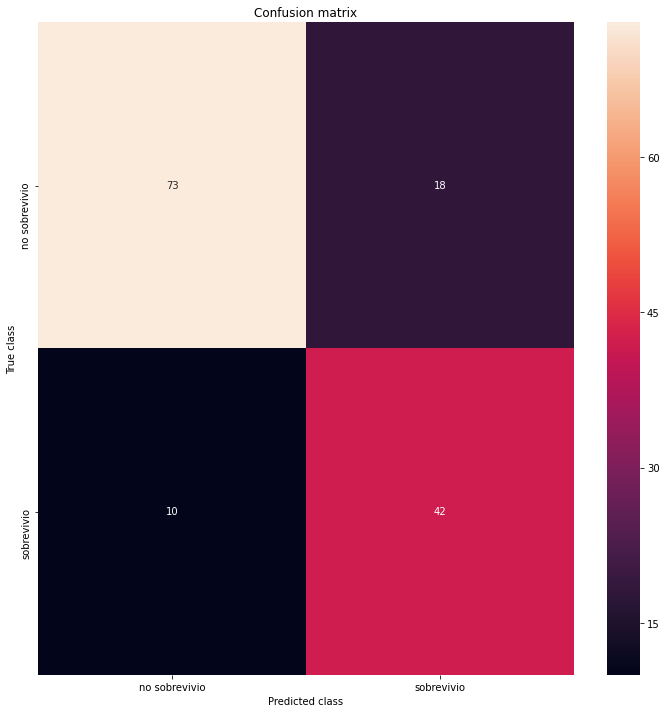

verdaderos positivos: 42
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        91
           1       0.70      0.81      0.75        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.768014      0.804196
Precision       0.683128      0.700000
Recall:         0.751131      0.807692
F1_Score:       0.715517      0.750000


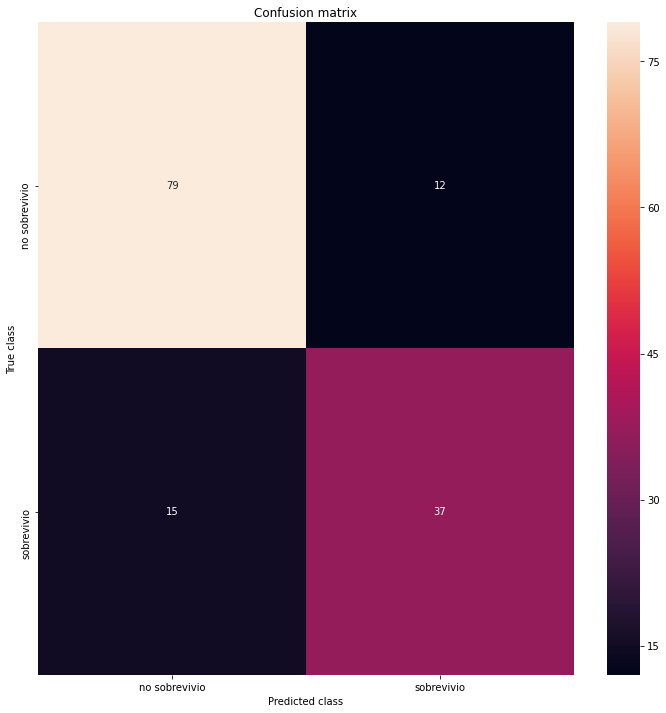

verdaderos positivos: 37
falsos positivos: 12
verdaderos negativos: 79
falsos negativos: 15
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        91
           1       0.76      0.71      0.73        52

    accuracy                           0.81       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.81      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.766257      0.811189
Precision       0.713592      0.755102
Recall:         0.665158      0.711538
F1_Score:       0.688525      0.732673


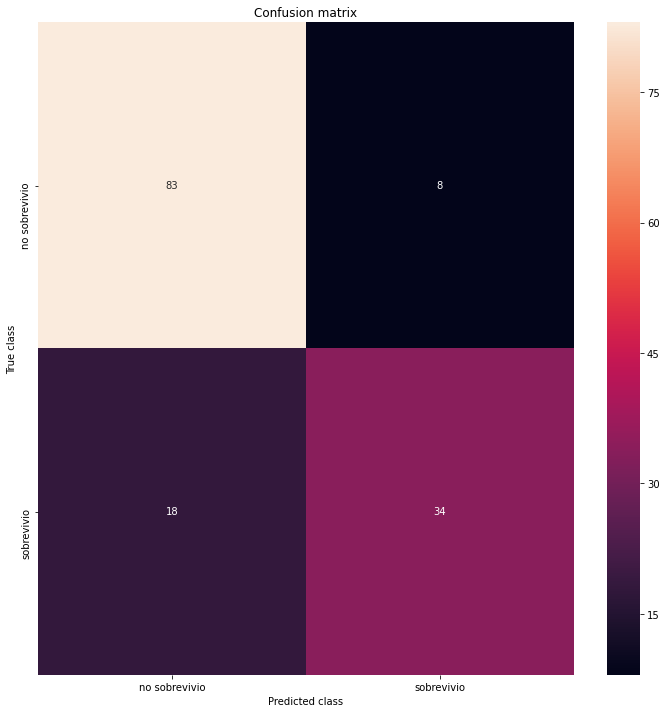

verdaderos positivos: 34
falsos positivos: 8
verdaderos negativos: 83
falsos negativos: 18
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        91
           1       0.81      0.65      0.72        52

    accuracy                           0.82       143
   macro avg       0.82      0.78      0.79       143
weighted avg       0.82      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.787346      0.818182
Precision       0.777778      0.809524
Recall:         0.633484      0.653846
F1_Score:       0.698254      0.723404


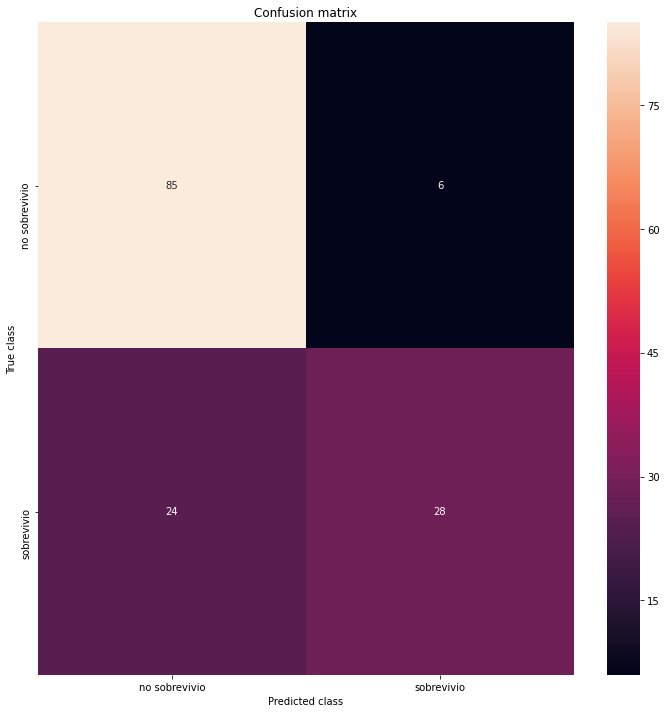

verdaderos positivos: 28
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 24
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        91
           1       0.82      0.54      0.65        52

    accuracy                           0.79       143
   macro avg       0.80      0.74      0.75       143
weighted avg       0.80      0.79      0.78       143

           metrics_train  metrics_test
Accuracy        0.787346      0.790210
Precision       0.857143      0.823529
Recall:         0.542986      0.538462
F1_Score:       0.664820      0.651163


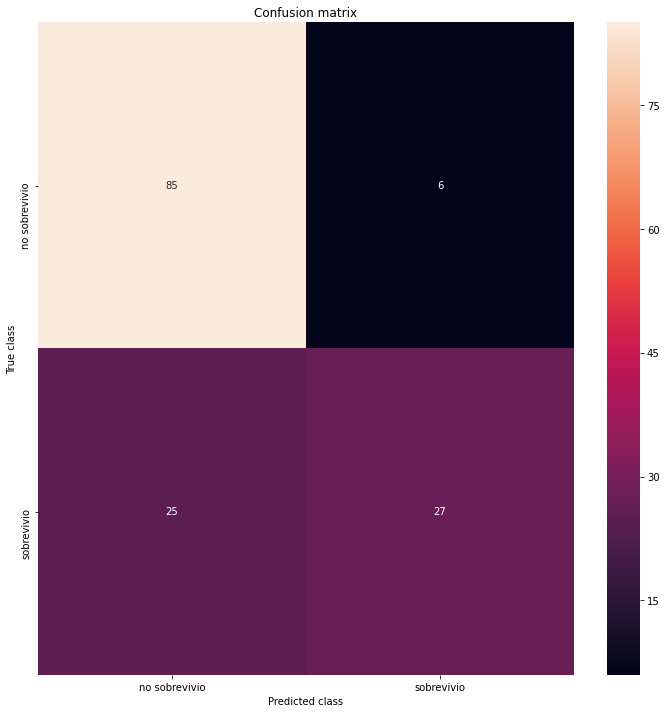

verdaderos positivos: 27
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.77      0.93      0.85        91
           1       0.82      0.52      0.64        52

    accuracy                           0.78       143
   macro avg       0.80      0.73      0.74       143
weighted avg       0.79      0.78      0.77       143

           metrics_train  metrics_test
Accuracy        0.782074      0.783217
Precision       0.864662      0.818182
Recall:         0.520362      0.519231
F1_Score:       0.649718      0.635294


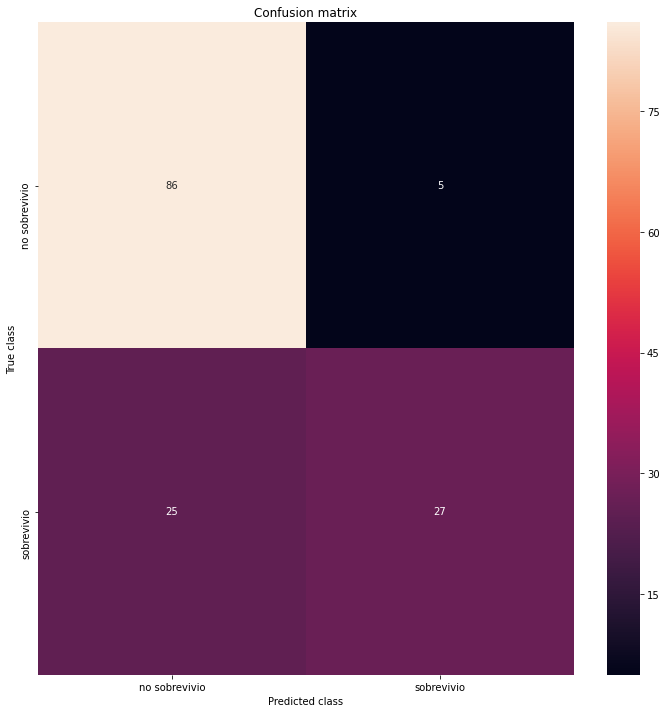

verdaderos positivos: 27
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.77      0.95      0.85        91
           1       0.84      0.52      0.64        52

    accuracy                           0.79       143
   macro avg       0.81      0.73      0.75       143
weighted avg       0.80      0.79      0.78       143

           metrics_train  metrics_test
Accuracy        0.778559      0.790210
Precision       0.868217      0.843750
Recall:         0.506787      0.519231
F1_Score:       0.640000      0.642857


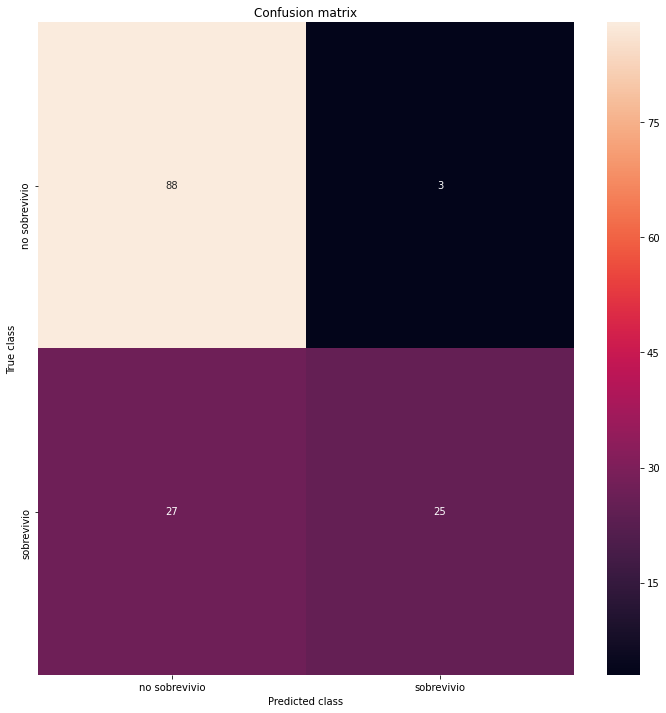

verdaderos positivos: 25
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.77      0.97      0.85        91
           1       0.89      0.48      0.62        52

    accuracy                           0.79       143
   macro avg       0.83      0.72      0.74       143
weighted avg       0.81      0.79      0.77       143

           metrics_train  metrics_test
Accuracy        0.776801      0.790210
Precision       0.951923      0.892857
Recall:         0.447964      0.480769
F1_Score:       0.609231      0.625000


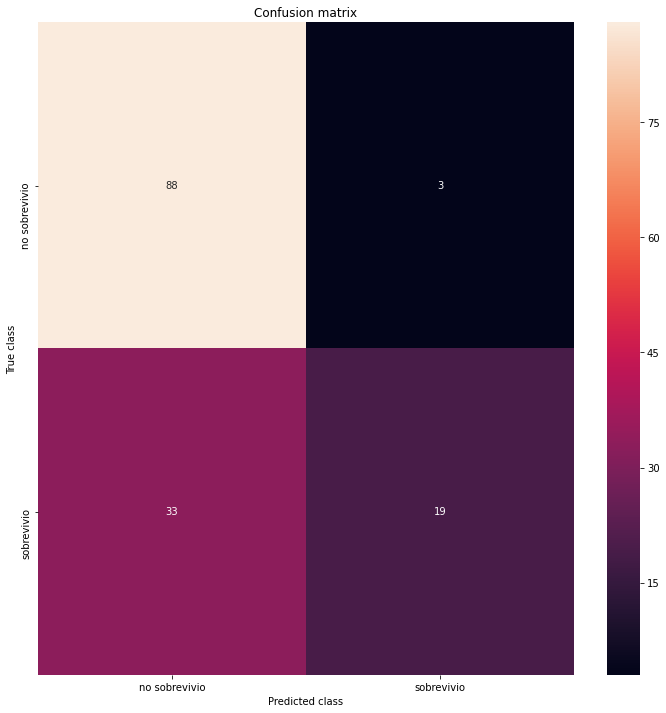

verdaderos positivos: 19
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 33
              precision    recall  f1-score   support

           0       0.73      0.97      0.83        91
           1       0.86      0.37      0.51        52

    accuracy                           0.75       143
   macro avg       0.80      0.67      0.67       143
weighted avg       0.78      0.75      0.72       143

           metrics_train  metrics_test
Accuracy        0.745167      0.748252
Precision       0.975000      0.863636
Recall:         0.352941      0.365385
F1_Score:       0.518272      0.513514
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.794078
Training accuracy: 0.438%
loss at step 1000: 0.528251
Training accuracy: 0.617%
Test accuracy: 0.846%


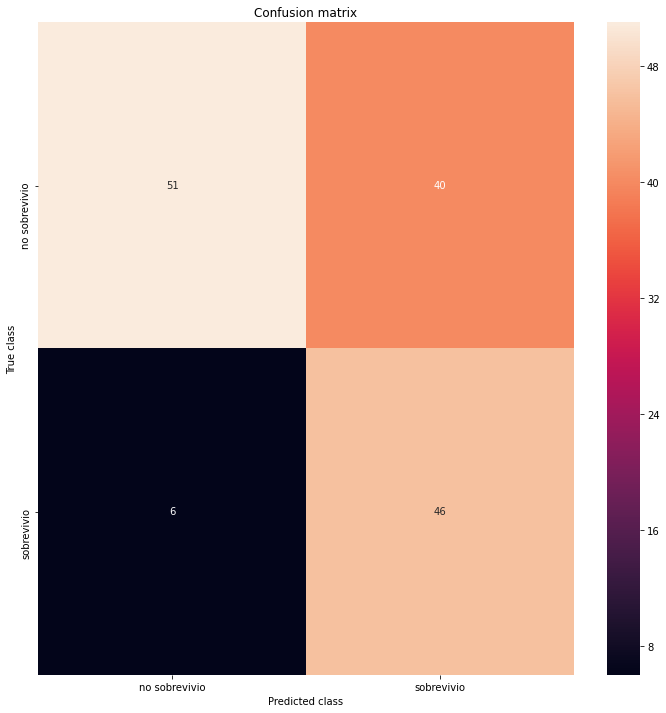

verdaderos positivos: 46
falsos positivos: 40
verdaderos negativos: 51
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.89      0.56      0.69        91
           1       0.53      0.88      0.67        52

    accuracy                           0.68       143
   macro avg       0.71      0.72      0.68       143
weighted avg       0.76      0.68      0.68       143

           metrics_train  metrics_test
Accuracy        0.657293      0.678322
Precision       0.537143      0.534884
Recall:         0.850679      0.884615
F1_Score:       0.658494      0.666667


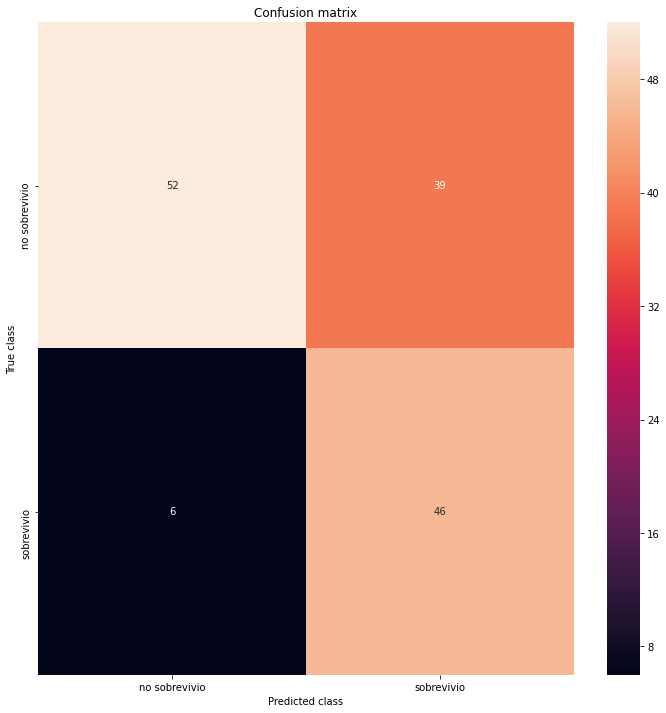

verdaderos positivos: 46
falsos positivos: 39
verdaderos negativos: 52
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.90      0.57      0.70        91
           1       0.54      0.88      0.67        52

    accuracy                           0.69       143
   macro avg       0.72      0.73      0.68       143
weighted avg       0.77      0.69      0.69       143

           metrics_train  metrics_test
Accuracy        0.660808      0.685315
Precision       0.540462      0.541176
Recall:         0.846154      0.884615
F1_Score:       0.659612      0.671533


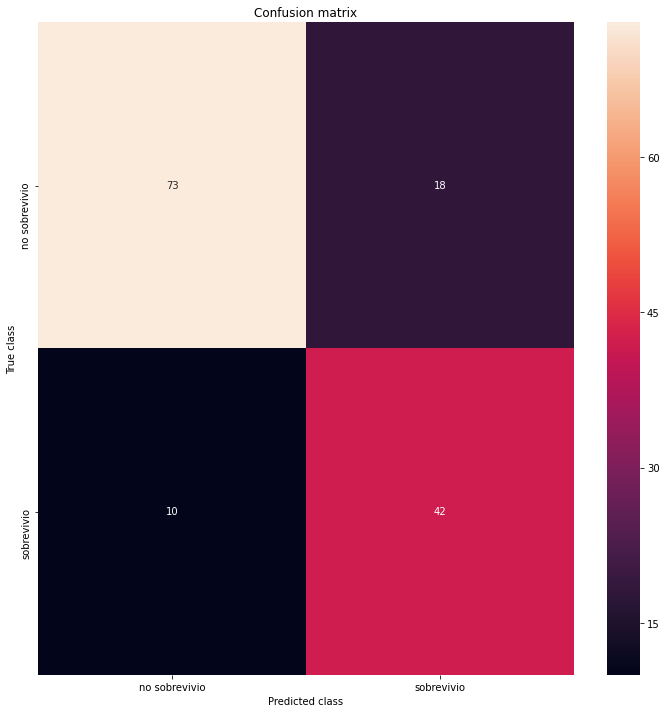

verdaderos positivos: 42
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        91
           1       0.70      0.81      0.75        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.764499      0.804196
Precision       0.677551      0.700000
Recall:         0.751131      0.807692
F1_Score:       0.712446      0.750000


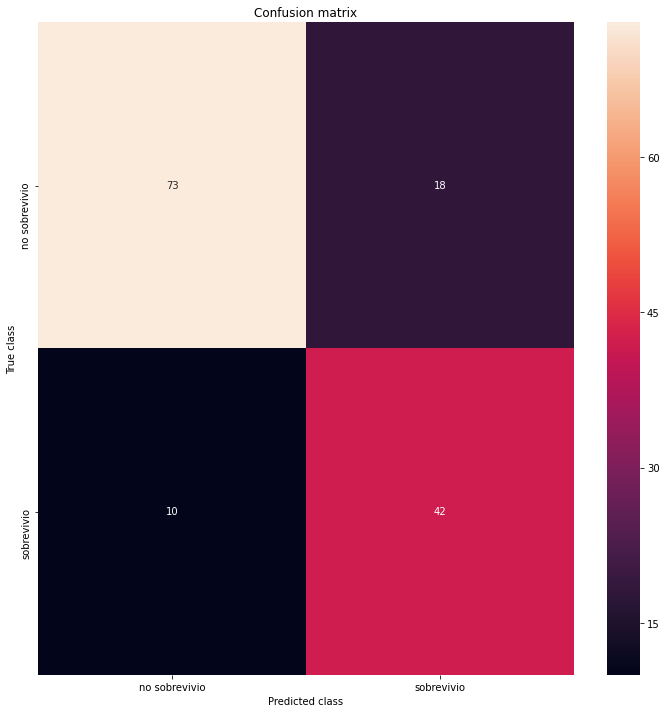

verdaderos positivos: 42
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        91
           1       0.70      0.81      0.75        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.764499      0.804196
Precision       0.677551      0.700000
Recall:         0.751131      0.807692
F1_Score:       0.712446      0.750000


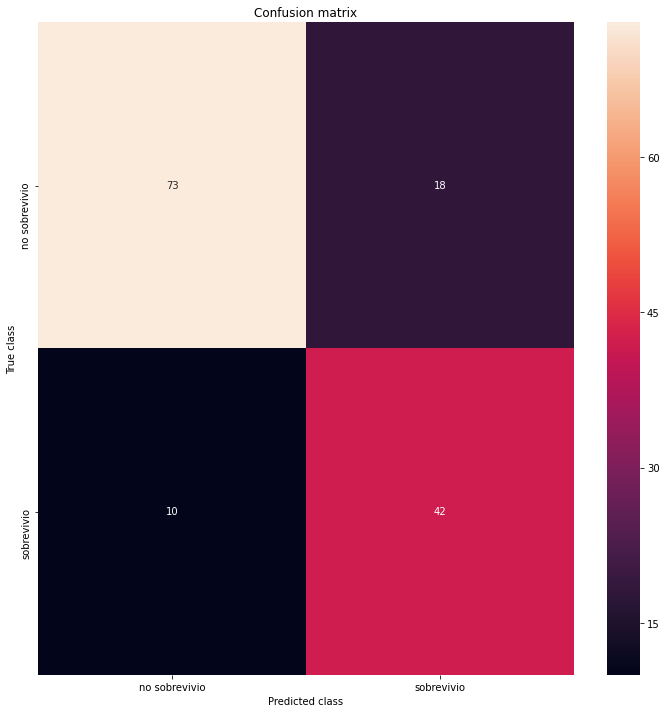

verdaderos positivos: 42
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        91
           1       0.70      0.81      0.75        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.768014      0.804196
Precision       0.684647      0.700000
Recall:         0.746606      0.807692
F1_Score:       0.714286      0.750000


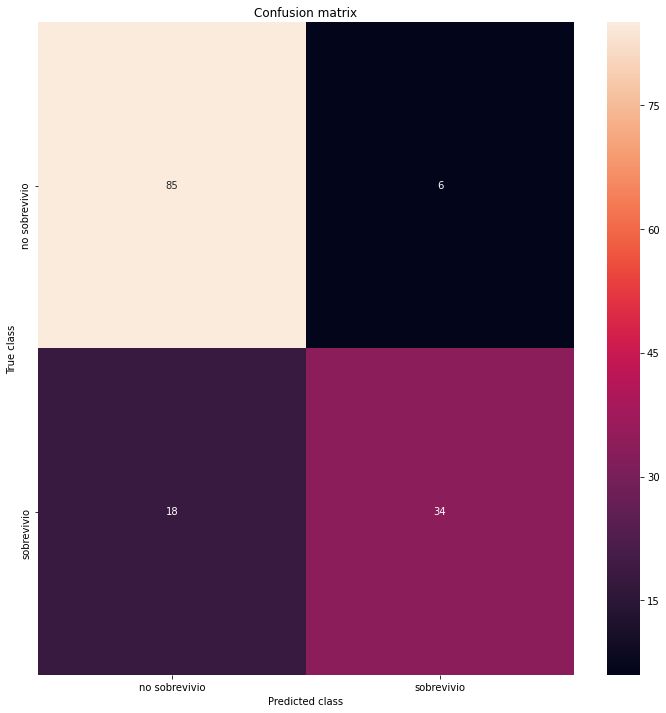

verdaderos positivos: 34
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 18
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        91
           1       0.85      0.65      0.74        52

    accuracy                           0.83       143
   macro avg       0.84      0.79      0.81       143
weighted avg       0.83      0.83      0.83       143

           metrics_train  metrics_test
Accuracy        0.796134      0.832168
Precision       0.814371      0.850000
Recall:         0.615385      0.653846
F1_Score:       0.701031      0.739130


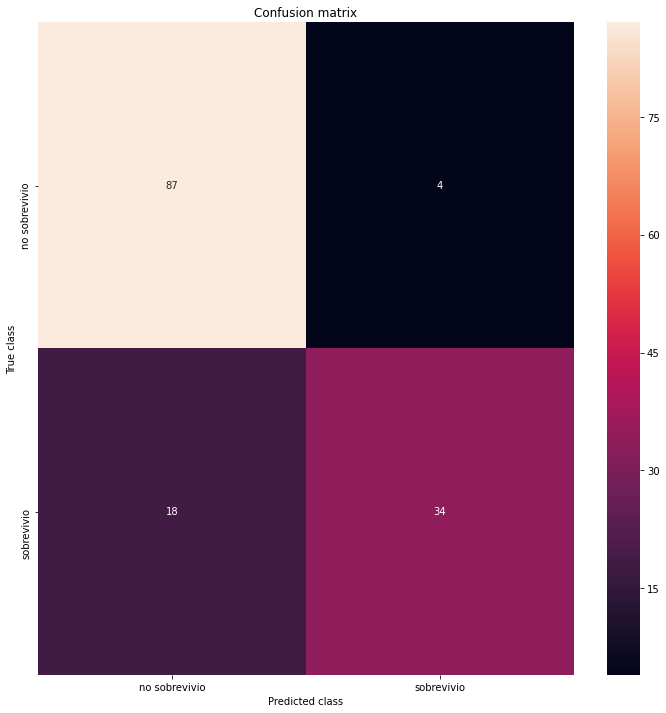

verdaderos positivos: 34
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 18
              precision    recall  f1-score   support

           0       0.83      0.96      0.89        91
           1       0.89      0.65      0.76        52

    accuracy                           0.85       143
   macro avg       0.86      0.80      0.82       143
weighted avg       0.85      0.85      0.84       143

           metrics_train  metrics_test
Accuracy        0.796134      0.846154
Precision       0.834395      0.894737
Recall:         0.592760      0.653846
F1_Score:       0.693122      0.755556


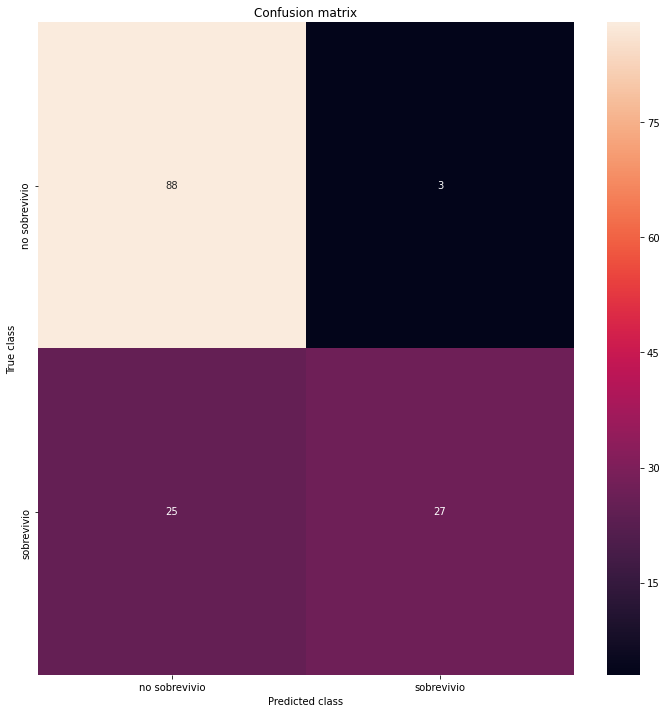

verdaderos positivos: 27
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.78      0.97      0.86        91
           1       0.90      0.52      0.66        52

    accuracy                           0.80       143
   macro avg       0.84      0.74      0.76       143
weighted avg       0.82      0.80      0.79       143

           metrics_train  metrics_test
Accuracy        0.787346      0.804196
Precision       0.938596      0.900000
Recall:         0.484163      0.519231
F1_Score:       0.638806      0.658537
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.779461
Training accuracy: 0.367%
loss at step 1000: 0.643096
Training accuracy: 0.572%
Test accuracy: 0.818%


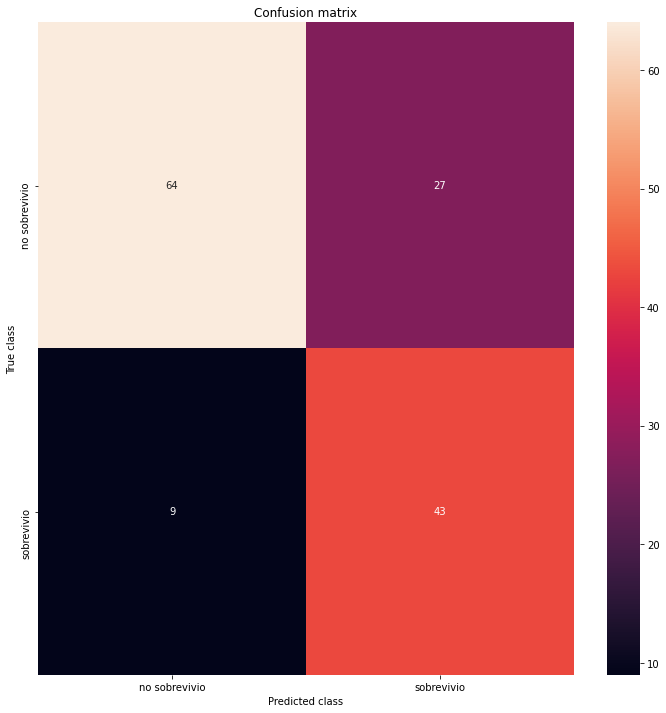

verdaderos positivos: 43
falsos positivos: 27
verdaderos negativos: 64
falsos negativos: 9
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        91
           1       0.61      0.83      0.70        52

    accuracy                           0.75       143
   macro avg       0.75      0.77      0.74       143
weighted avg       0.78      0.75      0.75       143

           metrics_train  metrics_test
Accuracy        0.746924      0.748252
Precision       0.645283      0.614286
Recall:         0.773756      0.826923
F1_Score:       0.703704      0.704918


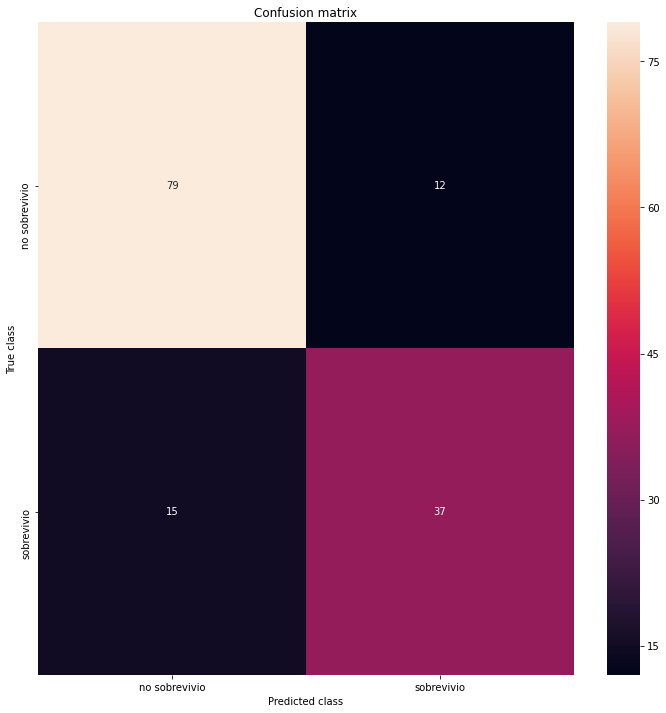

verdaderos positivos: 37
falsos positivos: 12
verdaderos negativos: 79
falsos negativos: 15
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        91
           1       0.76      0.71      0.73        52

    accuracy                           0.81       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.81      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.766257      0.811189
Precision       0.713592      0.755102
Recall:         0.665158      0.711538
F1_Score:       0.688525      0.732673


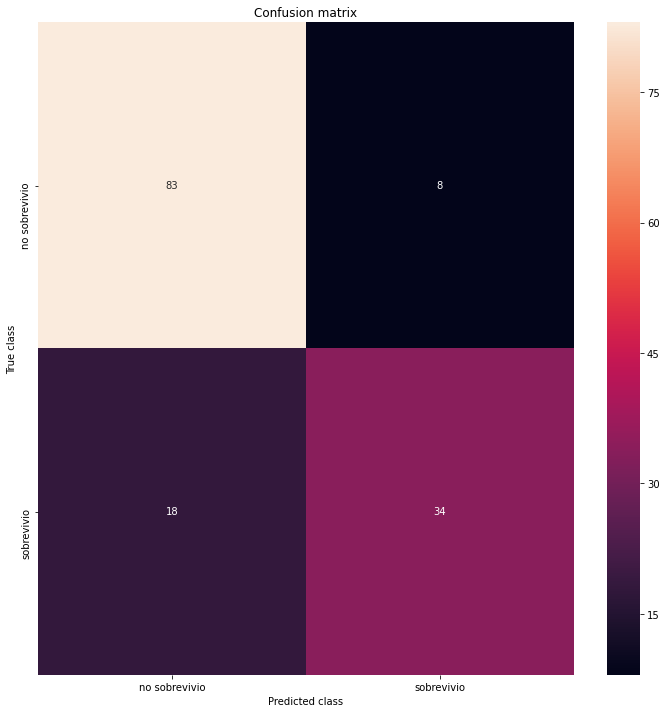

verdaderos positivos: 34
falsos positivos: 8
verdaderos negativos: 83
falsos negativos: 18
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        91
           1       0.81      0.65      0.72        52

    accuracy                           0.82       143
   macro avg       0.82      0.78      0.79       143
weighted avg       0.82      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.787346      0.818182
Precision       0.777778      0.809524
Recall:         0.633484      0.653846
F1_Score:       0.698254      0.723404


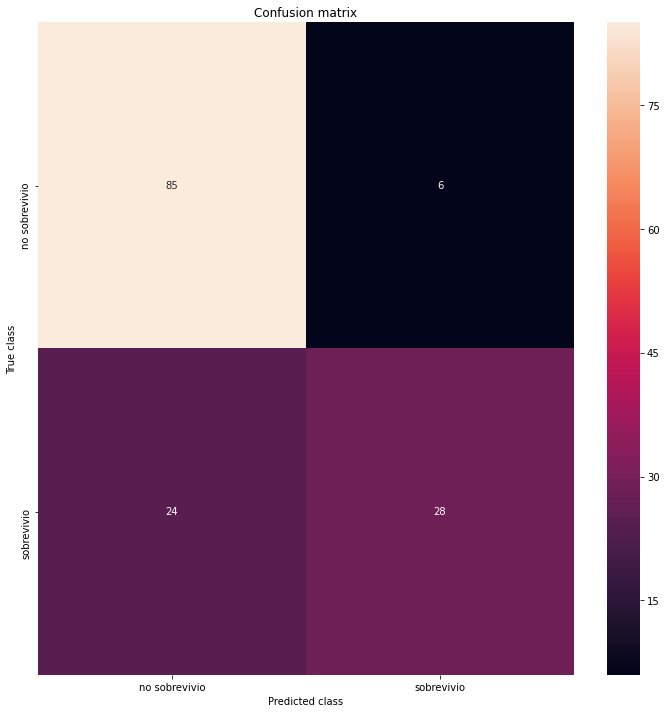

verdaderos positivos: 28
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 24
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        91
           1       0.82      0.54      0.65        52

    accuracy                           0.79       143
   macro avg       0.80      0.74      0.75       143
weighted avg       0.80      0.79      0.78       143

           metrics_train  metrics_test
Accuracy        0.787346      0.790210
Precision       0.857143      0.823529
Recall:         0.542986      0.538462
F1_Score:       0.664820      0.651163


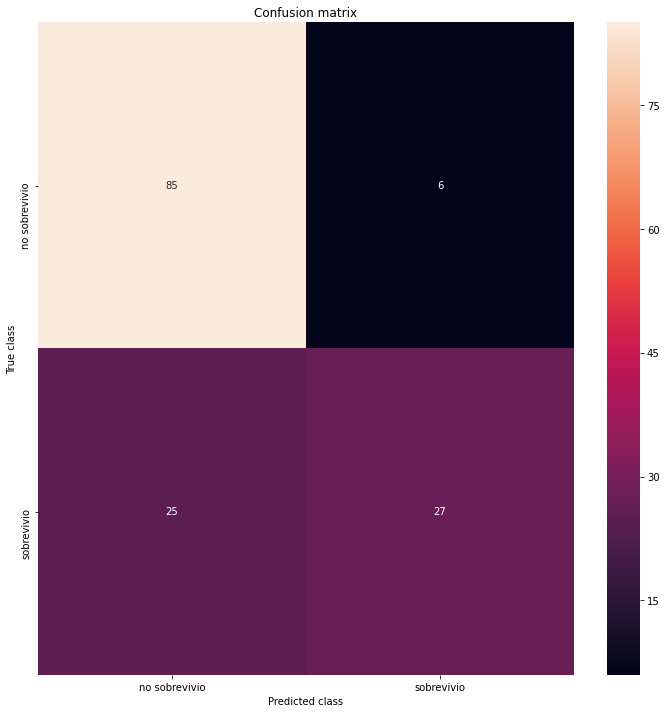

verdaderos positivos: 27
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.77      0.93      0.85        91
           1       0.82      0.52      0.64        52

    accuracy                           0.78       143
   macro avg       0.80      0.73      0.74       143
weighted avg       0.79      0.78      0.77       143

           metrics_train  metrics_test
Accuracy        0.782074      0.783217
Precision       0.864662      0.818182
Recall:         0.520362      0.519231
F1_Score:       0.649718      0.635294


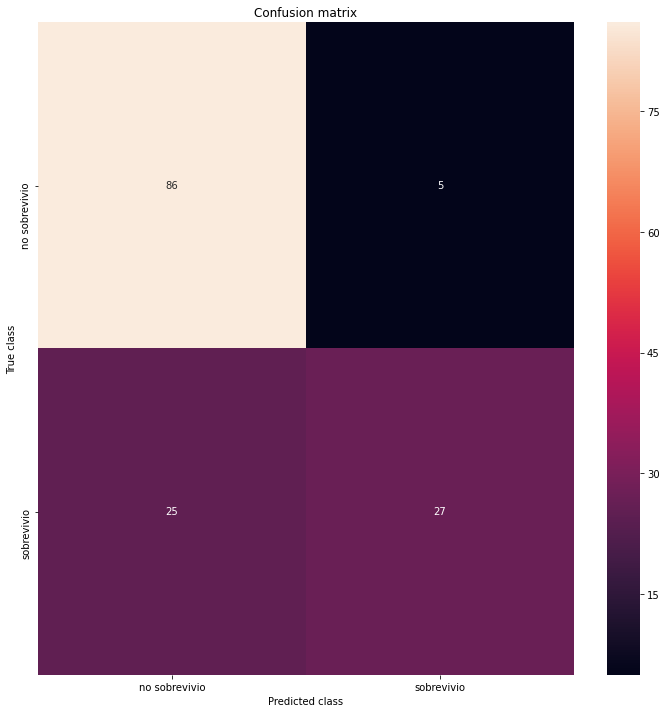

verdaderos positivos: 27
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.77      0.95      0.85        91
           1       0.84      0.52      0.64        52

    accuracy                           0.79       143
   macro avg       0.81      0.73      0.75       143
weighted avg       0.80      0.79      0.78       143

           metrics_train  metrics_test
Accuracy        0.778559      0.790210
Precision       0.868217      0.843750
Recall:         0.506787      0.519231
F1_Score:       0.640000      0.642857


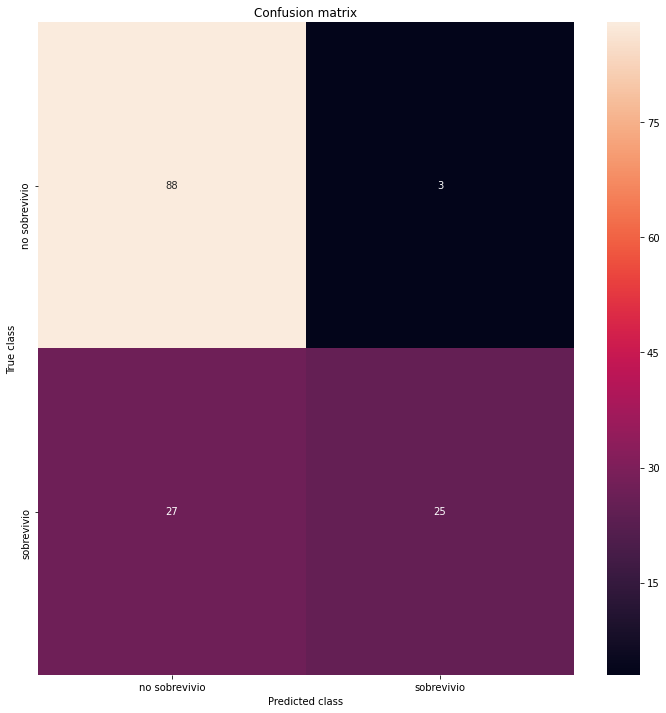

verdaderos positivos: 25
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.77      0.97      0.85        91
           1       0.89      0.48      0.62        52

    accuracy                           0.79       143
   macro avg       0.83      0.72      0.74       143
weighted avg       0.81      0.79      0.77       143

           metrics_train  metrics_test
Accuracy        0.776801      0.790210
Precision       0.951923      0.892857
Recall:         0.447964      0.480769
F1_Score:       0.609231      0.625000


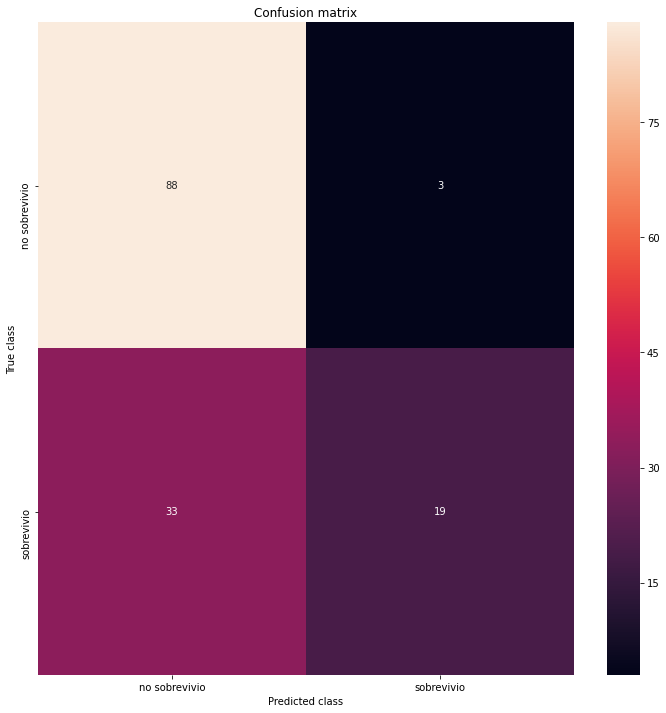

verdaderos positivos: 19
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 33
              precision    recall  f1-score   support

           0       0.73      0.97      0.83        91
           1       0.86      0.37      0.51        52

    accuracy                           0.75       143
   macro avg       0.80      0.67      0.67       143
weighted avg       0.78      0.75      0.72       143

           metrics_train  metrics_test
Accuracy        0.743409      0.748252
Precision       0.974684      0.863636
Recall:         0.348416      0.365385
F1_Score:       0.513333      0.513514
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.794275
Training accuracy: 0.438%
loss at step 1000: 0.529656
Training accuracy: 0.617%
Test accuracy: 0.846%


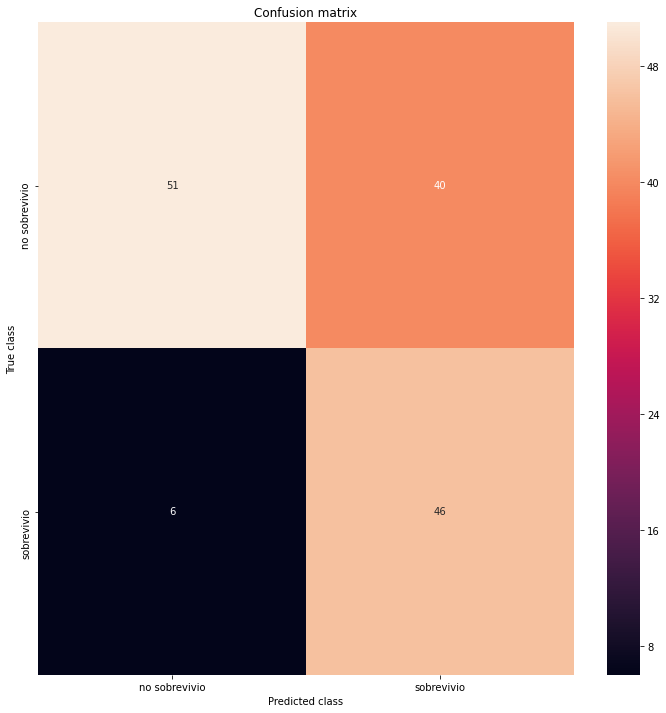

verdaderos positivos: 46
falsos positivos: 40
verdaderos negativos: 51
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.89      0.56      0.69        91
           1       0.53      0.88      0.67        52

    accuracy                           0.68       143
   macro avg       0.71      0.72      0.68       143
weighted avg       0.76      0.68      0.68       143

           metrics_train  metrics_test
Accuracy        0.657293      0.678322
Precision       0.537143      0.534884
Recall:         0.850679      0.884615
F1_Score:       0.658494      0.666667


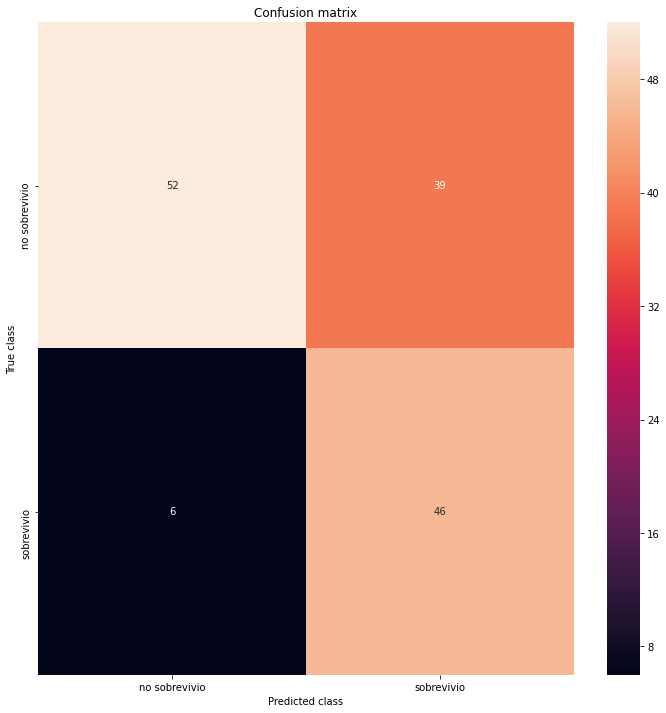

verdaderos positivos: 46
falsos positivos: 39
verdaderos negativos: 52
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.90      0.57      0.70        91
           1       0.54      0.88      0.67        52

    accuracy                           0.69       143
   macro avg       0.72      0.73      0.68       143
weighted avg       0.77      0.69      0.69       143

           metrics_train  metrics_test
Accuracy        0.660808      0.685315
Precision       0.540462      0.541176
Recall:         0.846154      0.884615
F1_Score:       0.659612      0.671533


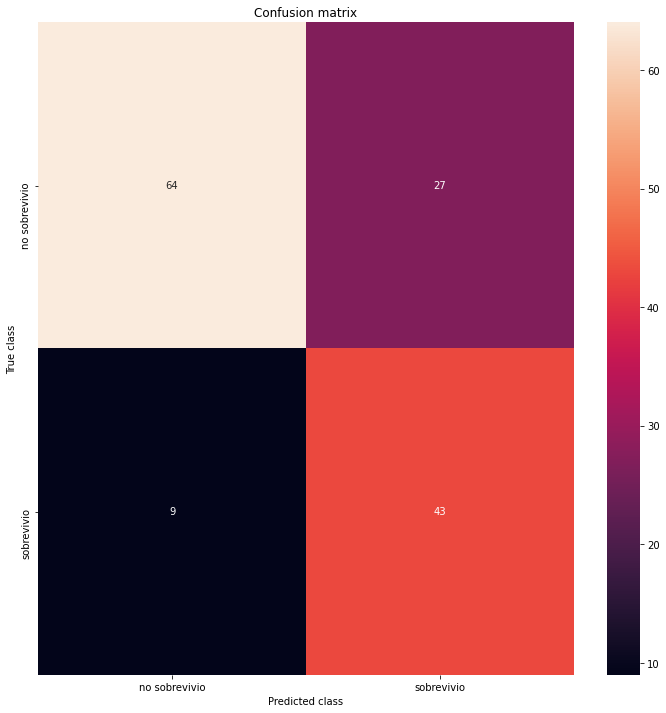

verdaderos positivos: 43
falsos positivos: 27
verdaderos negativos: 64
falsos negativos: 9
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        91
           1       0.61      0.83      0.70        52

    accuracy                           0.75       143
   macro avg       0.75      0.77      0.74       143
weighted avg       0.78      0.75      0.75       143

           metrics_train  metrics_test
Accuracy        0.743409      0.748252
Precision       0.640449      0.614286
Recall:         0.773756      0.826923
F1_Score:       0.700820      0.704918


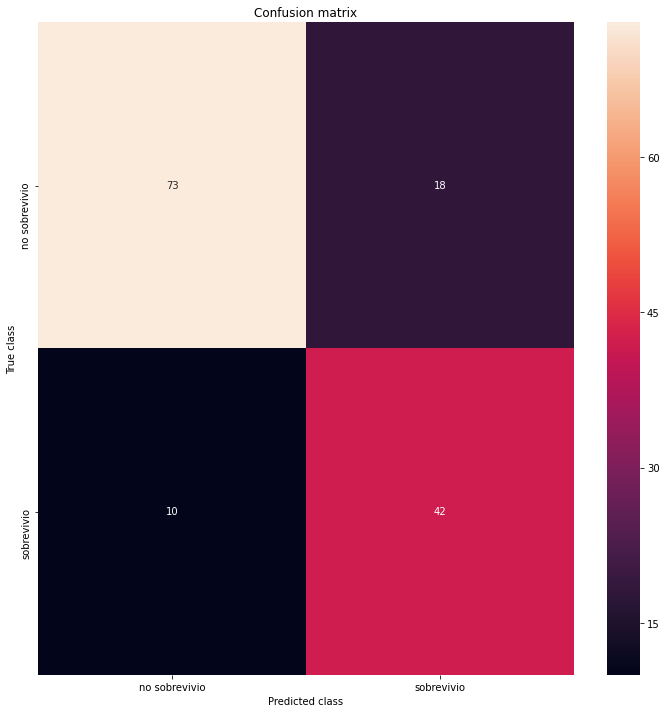

verdaderos positivos: 42
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        91
           1       0.70      0.81      0.75        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.764499      0.804196
Precision       0.677551      0.700000
Recall:         0.751131      0.807692
F1_Score:       0.712446      0.750000


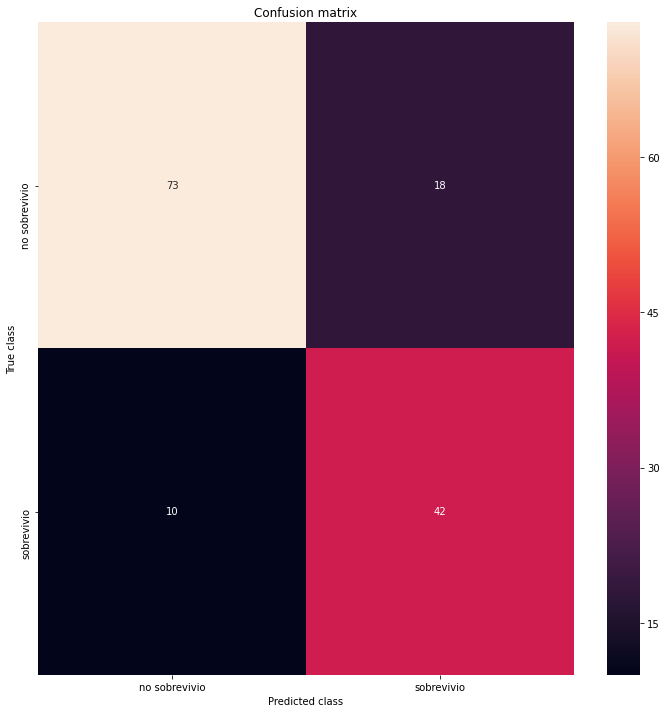

verdaderos positivos: 42
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        91
           1       0.70      0.81      0.75        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.768014      0.804196
Precision       0.684647      0.700000
Recall:         0.746606      0.807692
F1_Score:       0.714286      0.750000


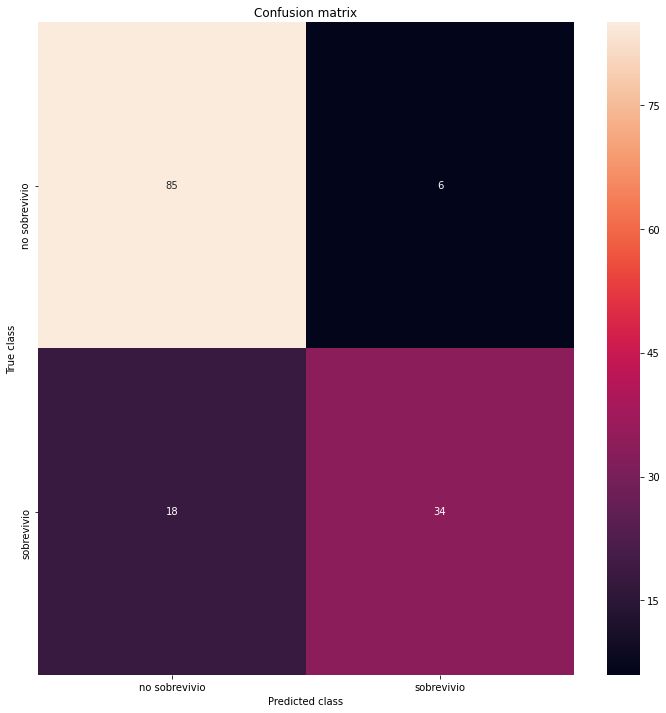

verdaderos positivos: 34
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 18
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        91
           1       0.85      0.65      0.74        52

    accuracy                           0.83       143
   macro avg       0.84      0.79      0.81       143
weighted avg       0.83      0.83      0.83       143

           metrics_train  metrics_test
Accuracy        0.796134      0.832168
Precision       0.814371      0.850000
Recall:         0.615385      0.653846
F1_Score:       0.701031      0.739130


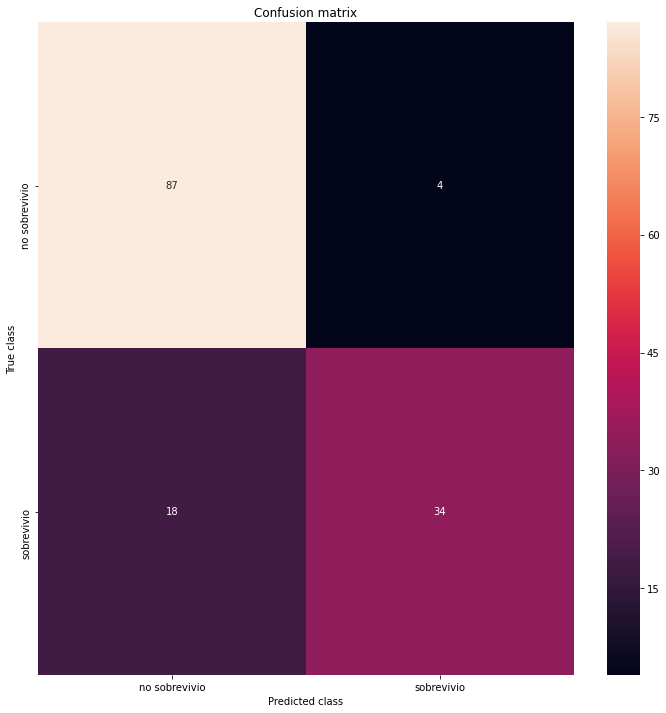

verdaderos positivos: 34
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 18
              precision    recall  f1-score   support

           0       0.83      0.96      0.89        91
           1       0.89      0.65      0.76        52

    accuracy                           0.85       143
   macro avg       0.86      0.80      0.82       143
weighted avg       0.85      0.85      0.84       143

           metrics_train  metrics_test
Accuracy        0.796134      0.846154
Precision       0.834395      0.894737
Recall:         0.592760      0.653846
F1_Score:       0.693122      0.755556


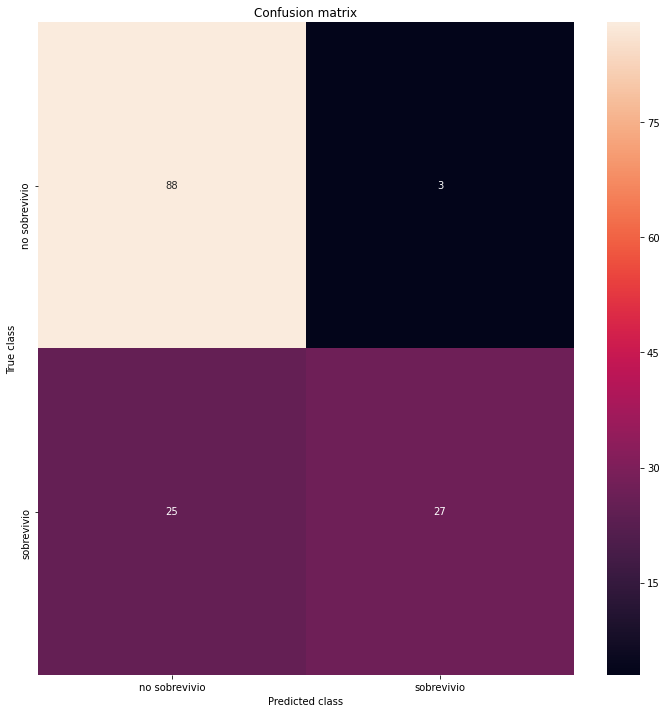

verdaderos positivos: 27
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.78      0.97      0.86        91
           1       0.90      0.52      0.66        52

    accuracy                           0.80       143
   macro avg       0.84      0.74      0.76       143
weighted avg       0.82      0.80      0.79       143

           metrics_train  metrics_test
Accuracy        0.787346      0.804196
Precision       0.938596      0.900000
Recall:         0.484163      0.519231
F1_Score:       0.638806      0.658537
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.803299
Training accuracy: 0.351%
loss at step 1000: 0.673940
Training accuracy: 0.551%
Test accuracy: 0.755%


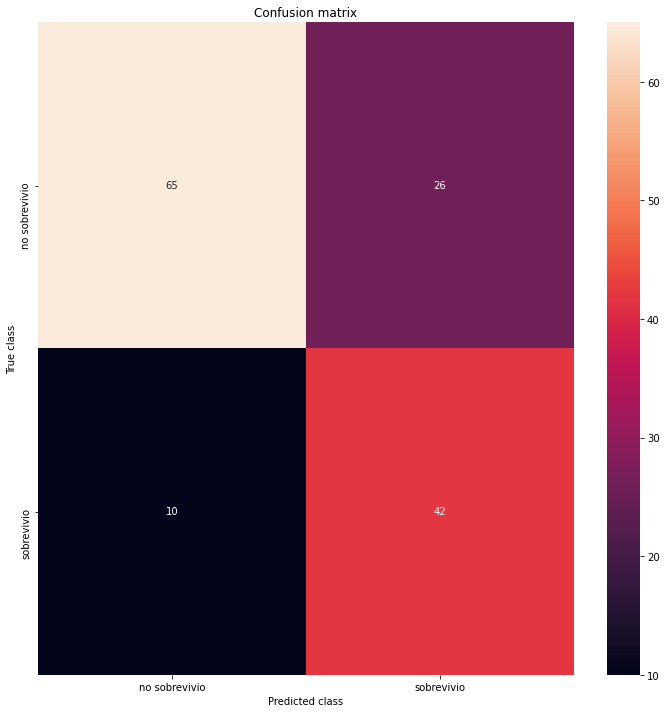

verdaderos positivos: 42
falsos positivos: 26
verdaderos negativos: 65
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.87      0.71      0.78        91
           1       0.62      0.81      0.70        52

    accuracy                           0.75       143
   macro avg       0.74      0.76      0.74       143
weighted avg       0.78      0.75      0.75       143

           metrics_train  metrics_test
Accuracy        0.732865      0.748252
Precision       0.632184      0.617647
Recall:         0.746606      0.807692
F1_Score:       0.684647      0.700000


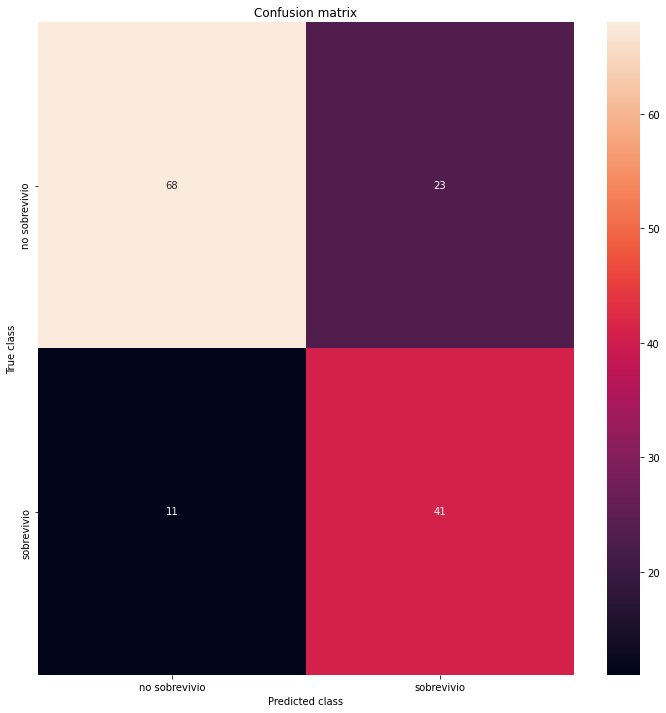

verdaderos positivos: 41
falsos positivos: 23
verdaderos negativos: 68
falsos negativos: 11
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        91
           1       0.64      0.79      0.71        52

    accuracy                           0.76       143
   macro avg       0.75      0.77      0.75       143
weighted avg       0.78      0.76      0.77       143

           metrics_train  metrics_test
Accuracy        0.743409      0.762238
Precision       0.650602      0.640625
Recall:         0.733032      0.788462
F1_Score:       0.689362      0.706897


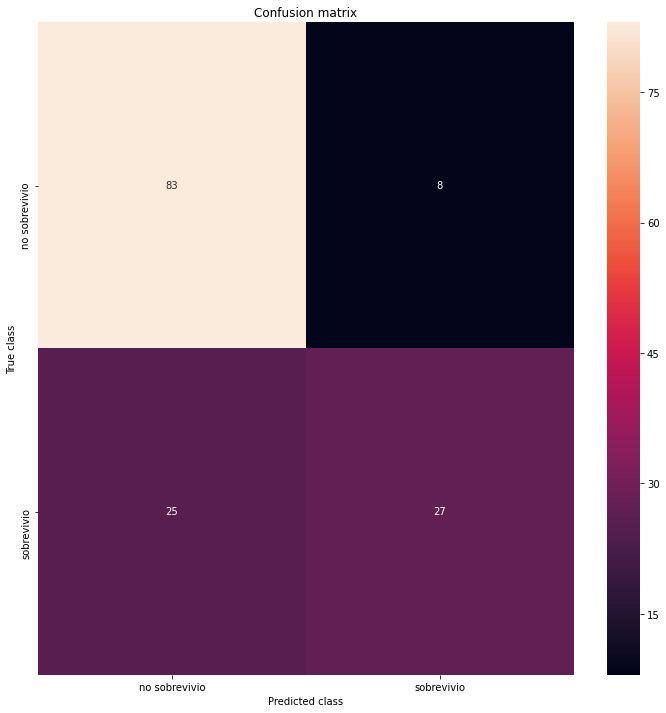

verdaderos positivos: 27
falsos positivos: 8
verdaderos negativos: 83
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        91
           1       0.77      0.52      0.62        52

    accuracy                           0.77       143
   macro avg       0.77      0.72      0.73       143
weighted avg       0.77      0.77      0.76       143

           metrics_train  metrics_test
Accuracy        0.776801      0.769231
Precision       0.817568      0.771429
Recall:         0.547511      0.519231
F1_Score:       0.655827      0.620690


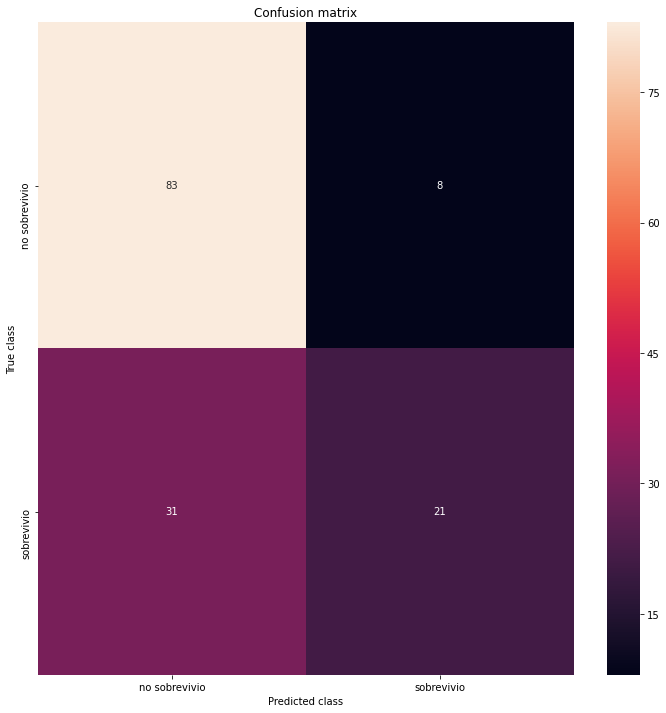

verdaderos positivos: 21
falsos positivos: 8
verdaderos negativos: 83
falsos negativos: 31
              precision    recall  f1-score   support

           0       0.73      0.91      0.81        91
           1       0.72      0.40      0.52        52

    accuracy                           0.73       143
   macro avg       0.73      0.66      0.66       143
weighted avg       0.73      0.73      0.70       143

           metrics_train  metrics_test
Accuracy        0.743409      0.727273
Precision       0.804878      0.724138
Recall:         0.447964      0.403846
F1_Score:       0.575581      0.518519


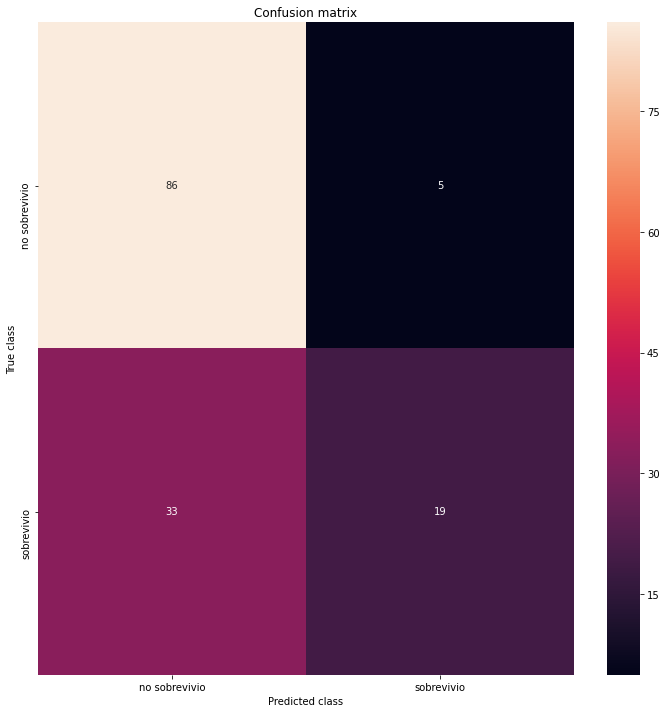

verdaderos positivos: 19
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 33
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        91
           1       0.79      0.37      0.50        52

    accuracy                           0.73       143
   macro avg       0.76      0.66      0.66       143
weighted avg       0.75      0.73      0.70       143

           metrics_train  metrics_test
Accuracy        0.741652      0.734266
Precision       0.902174      0.791667
Recall:         0.375566      0.365385
F1_Score:       0.530351      0.500000


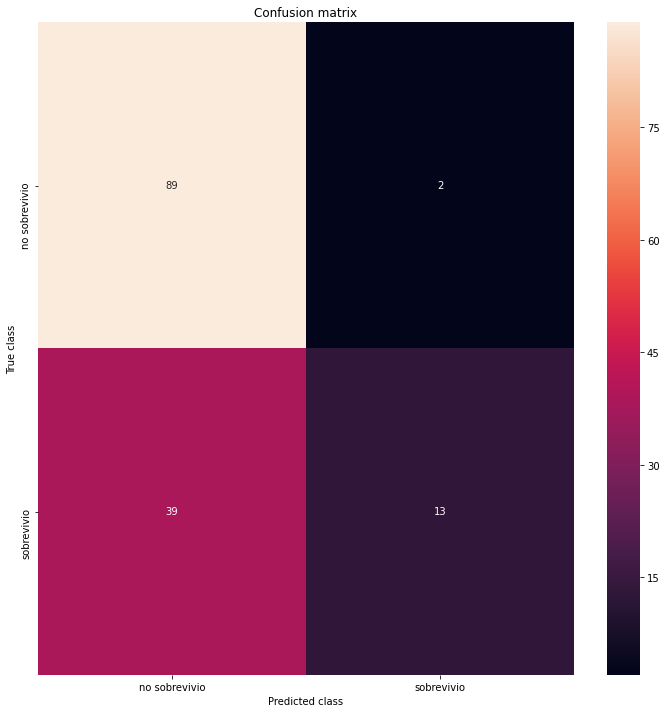

verdaderos positivos: 13
falsos positivos: 2
verdaderos negativos: 89
falsos negativos: 39
              precision    recall  f1-score   support

           0       0.70      0.98      0.81        91
           1       0.87      0.25      0.39        52

    accuracy                           0.71       143
   macro avg       0.78      0.61      0.60       143
weighted avg       0.76      0.71      0.66       143

           metrics_train  metrics_test
Accuracy        0.660808      0.713287
Precision       0.868421      0.866667
Recall:         0.149321      0.250000
F1_Score:       0.254826      0.388060


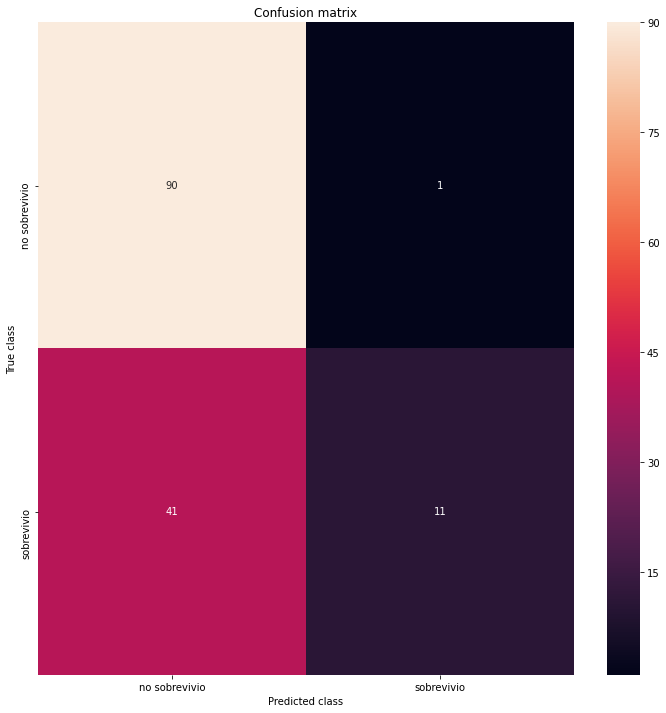

verdaderos positivos: 11
falsos positivos: 1
verdaderos negativos: 90
falsos negativos: 41
              precision    recall  f1-score   support

           0       0.69      0.99      0.81        91
           1       0.92      0.21      0.34        52

    accuracy                           0.71       143
   macro avg       0.80      0.60      0.58       143
weighted avg       0.77      0.71      0.64       143

           metrics_train  metrics_test
Accuracy        0.653779      0.706294
Precision       0.961538      0.916667
Recall:         0.113122      0.211538
F1_Score:       0.202429      0.343750


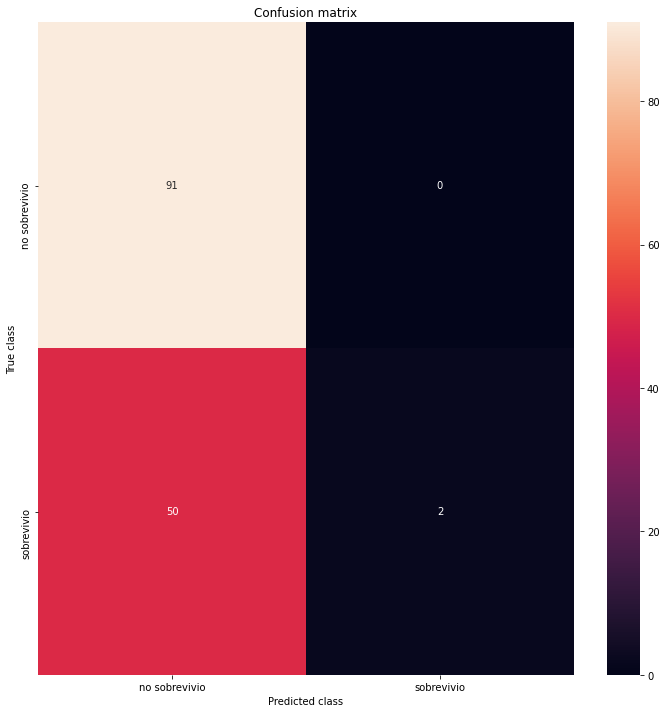

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.798584
Training accuracy: 0.436%
loss at step 1000: 0.560544
Training accuracy: 0.606%
Test accuracy: 0.818%


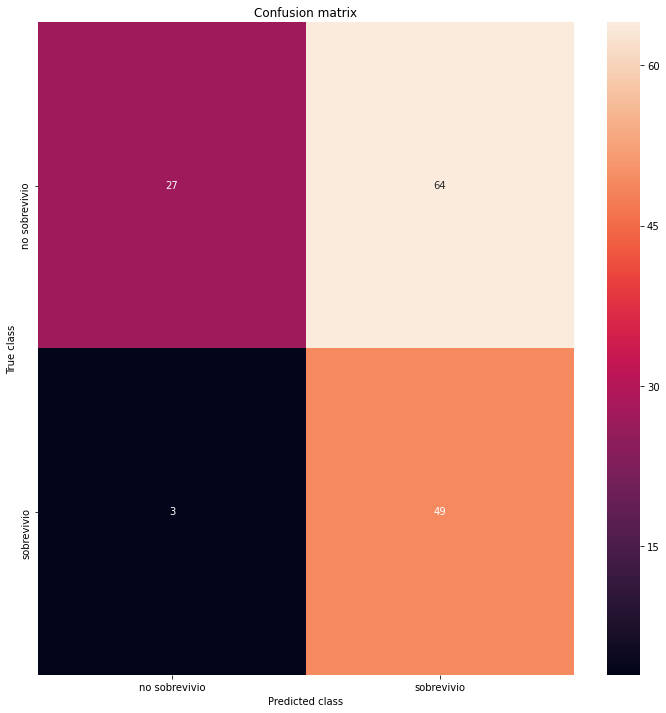

verdaderos positivos: 49
falsos positivos: 64
verdaderos negativos: 27
falsos negativos: 3
              precision    recall  f1-score   support

           0       0.90      0.30      0.45        91
           1       0.43      0.94      0.59        52

    accuracy                           0.53       143
   macro avg       0.67      0.62      0.52       143
weighted avg       0.73      0.53      0.50       143

           metrics_train  metrics_test
Accuracy        0.546573      0.531469
Precision       0.458050      0.433628
Recall:         0.914027      0.942308
F1_Score:       0.610272      0.593939


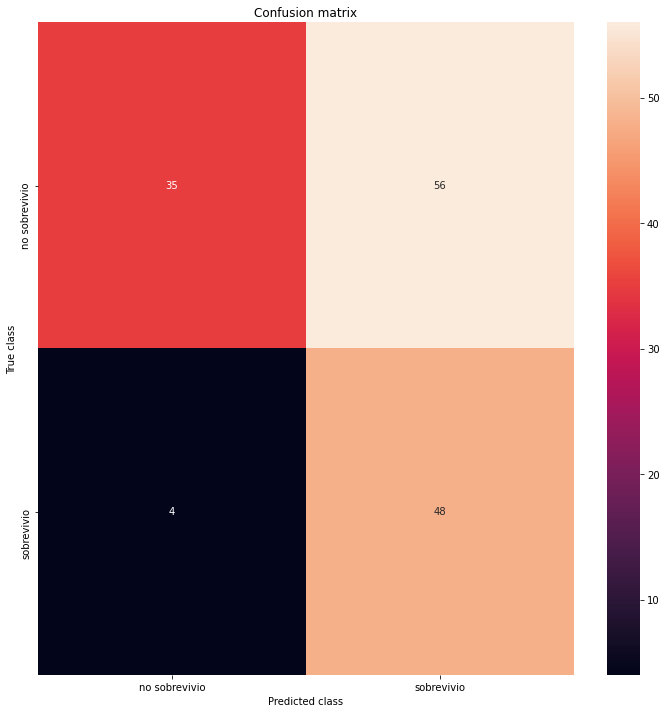

verdaderos positivos: 48
falsos positivos: 56
verdaderos negativos: 35
falsos negativos: 4
              precision    recall  f1-score   support

           0       0.90      0.38      0.54        91
           1       0.46      0.92      0.62        52

    accuracy                           0.58       143
   macro avg       0.68      0.65      0.58       143
weighted avg       0.74      0.58      0.57       143

           metrics_train  metrics_test
Accuracy        0.595782      0.580420
Precision       0.489051      0.461538
Recall:         0.909502      0.923077
F1_Score:       0.636076      0.615385


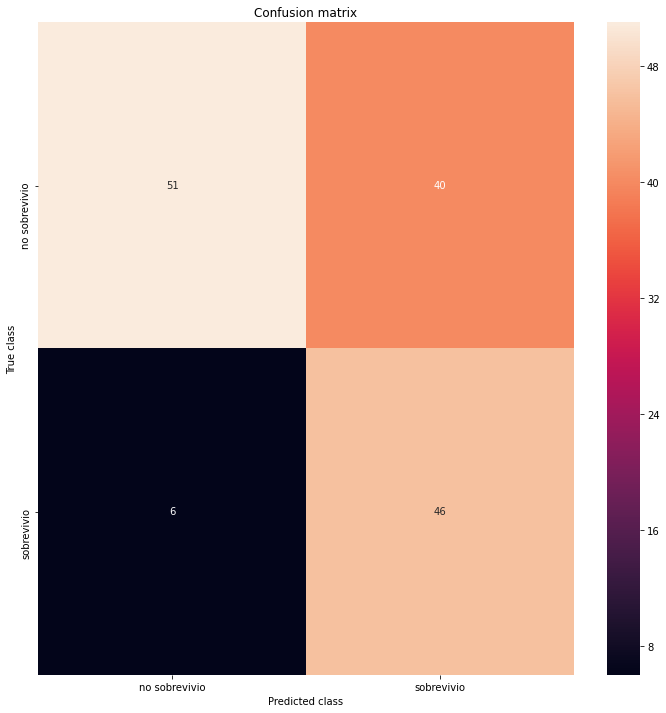

verdaderos positivos: 46
falsos positivos: 40
verdaderos negativos: 51
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.89      0.56      0.69        91
           1       0.53      0.88      0.67        52

    accuracy                           0.68       143
   macro avg       0.71      0.72      0.68       143
weighted avg       0.76      0.68      0.68       143

           metrics_train  metrics_test
Accuracy        0.659051      0.678322
Precision       0.538682      0.534884
Recall:         0.850679      0.884615
F1_Score:       0.659649      0.666667


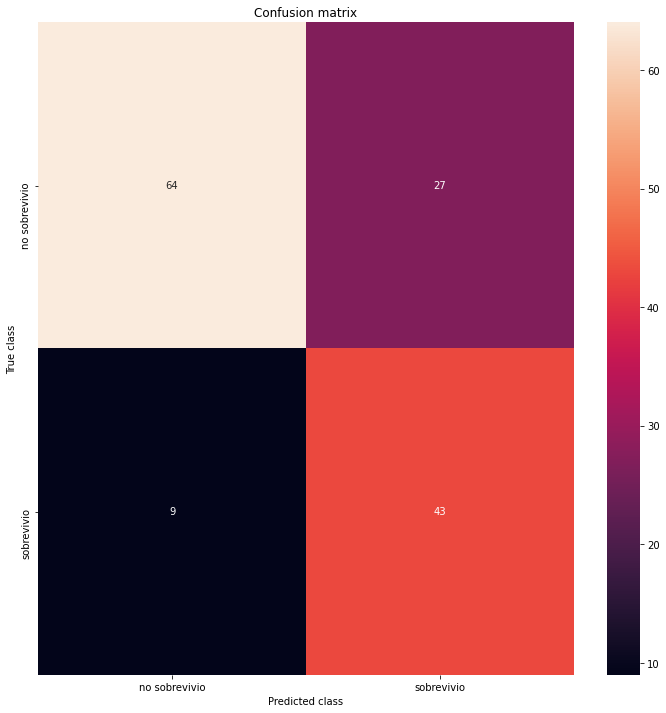

verdaderos positivos: 43
falsos positivos: 27
verdaderos negativos: 64
falsos negativos: 9
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        91
           1       0.61      0.83      0.70        52

    accuracy                           0.75       143
   macro avg       0.75      0.77      0.74       143
weighted avg       0.78      0.75      0.75       143

           metrics_train  metrics_test
Accuracy        0.743409      0.748252
Precision       0.640449      0.614286
Recall:         0.773756      0.826923
F1_Score:       0.700820      0.704918


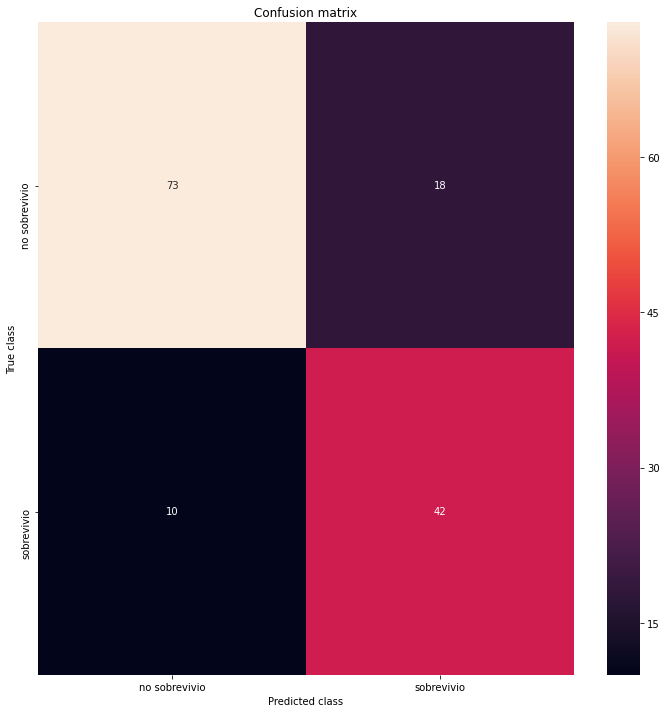

verdaderos positivos: 42
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        91
           1       0.70      0.81      0.75        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.764499      0.804196
Precision       0.677551      0.700000
Recall:         0.751131      0.807692
F1_Score:       0.712446      0.750000


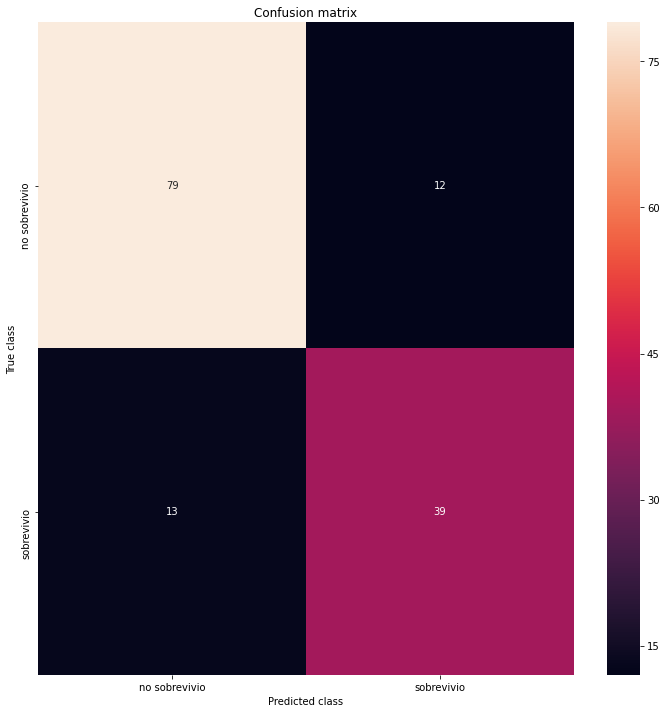

verdaderos positivos: 39
falsos positivos: 12
verdaderos negativos: 79
falsos negativos: 13
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        91
           1       0.76      0.75      0.76        52

    accuracy                           0.83       143
   macro avg       0.81      0.81      0.81       143
weighted avg       0.82      0.83      0.82       143

           metrics_train  metrics_test
Accuracy        0.780316      0.825175
Precision       0.726415      0.764706
Recall:         0.696833      0.750000
F1_Score:       0.711316      0.757282


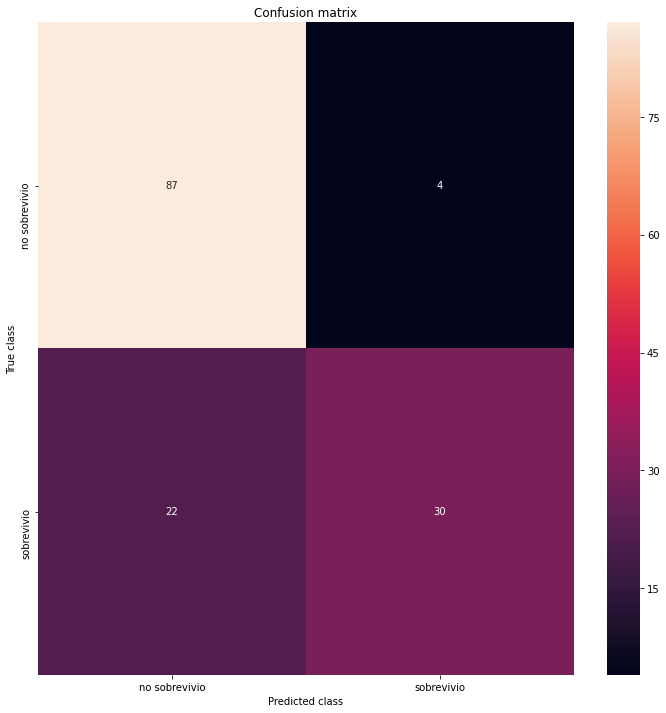

verdaderos positivos: 30
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 22
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        91
           1       0.88      0.58      0.70        52

    accuracy                           0.82       143
   macro avg       0.84      0.77      0.78       143
weighted avg       0.83      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.776801      0.818182
Precision       0.840580      0.882353
Recall:         0.524887      0.576923
F1_Score:       0.646240      0.697674


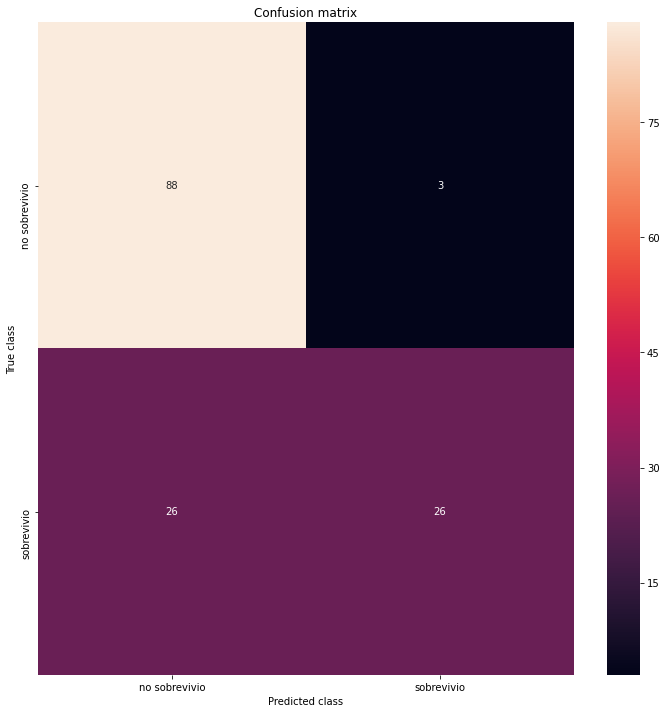

verdaderos positivos: 26
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 26
              precision    recall  f1-score   support

           0       0.77      0.97      0.86        91
           1       0.90      0.50      0.64        52

    accuracy                           0.80       143
   macro avg       0.83      0.73      0.75       143
weighted avg       0.82      0.80      0.78       143

           metrics_train  metrics_test
Accuracy        0.782074      0.797203
Precision       0.936937      0.896552
Recall:         0.470588      0.500000
F1_Score:       0.626506      0.641975
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.821199
Training accuracy: 0.351%
loss at step 1000: 0.684658
Training accuracy: 0.538%
Test accuracy: 0.741%


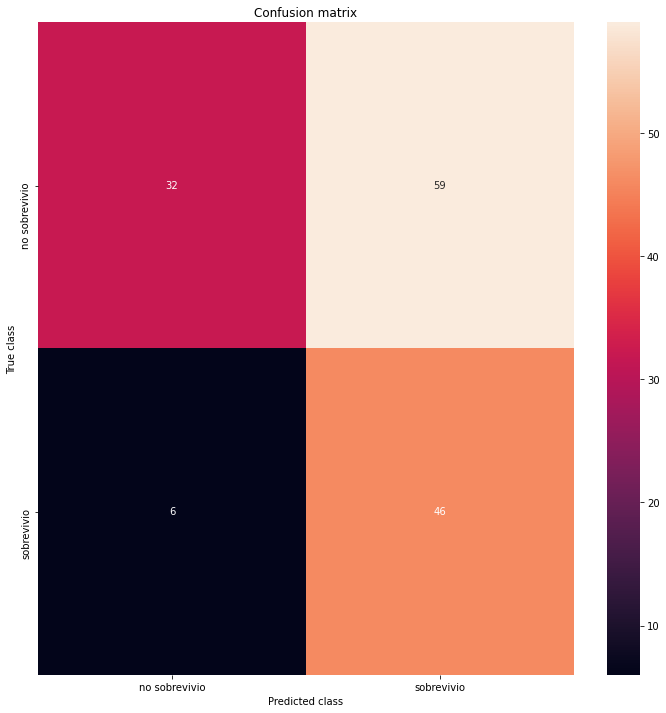

verdaderos positivos: 46
falsos positivos: 59
verdaderos negativos: 32
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.84      0.35      0.50        91
           1       0.44      0.88      0.59        52

    accuracy                           0.55       143
   macro avg       0.64      0.62      0.54       143
weighted avg       0.70      0.55      0.53       143

           metrics_train  metrics_test
Accuracy        0.546573      0.545455
Precision       0.456265      0.438095
Recall:         0.873303      0.884615
F1_Score:       0.599379      0.585987


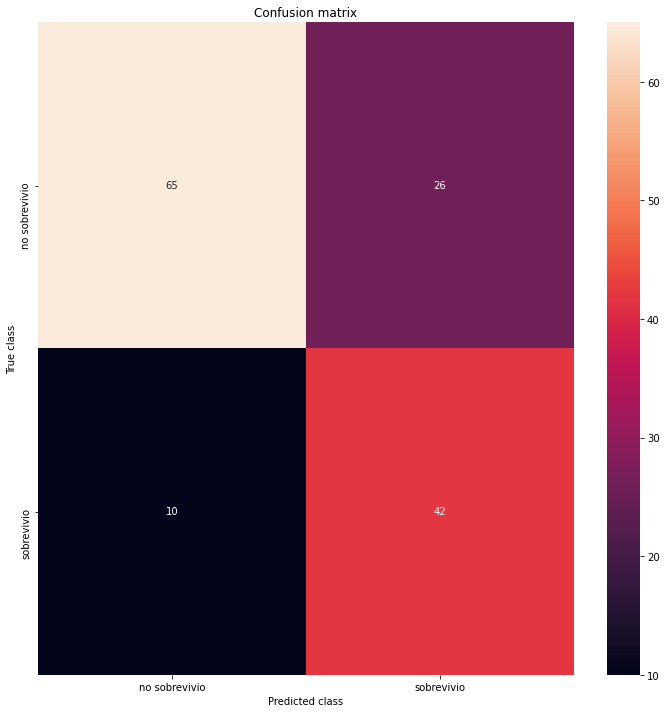

verdaderos positivos: 42
falsos positivos: 26
verdaderos negativos: 65
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.87      0.71      0.78        91
           1       0.62      0.81      0.70        52

    accuracy                           0.75       143
   macro avg       0.74      0.76      0.74       143
weighted avg       0.78      0.75      0.75       143

           metrics_train  metrics_test
Accuracy        0.736380      0.748252
Precision       0.637066      0.617647
Recall:         0.746606      0.807692
F1_Score:       0.687500      0.700000


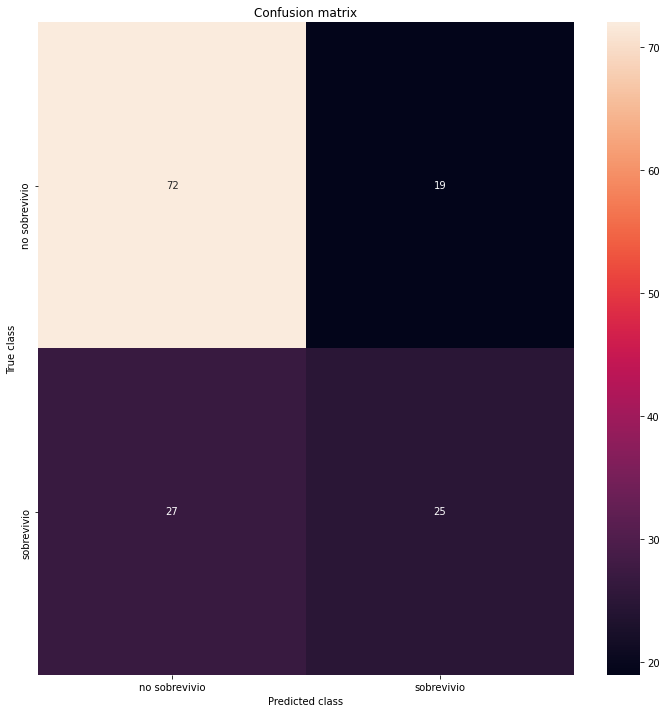

verdaderos positivos: 25
falsos positivos: 19
verdaderos negativos: 72
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        91
           1       0.57      0.48      0.52        52

    accuracy                           0.68       143
   macro avg       0.65      0.64      0.64       143
weighted avg       0.67      0.68      0.67       143

           metrics_train  metrics_test
Accuracy        0.718805      0.678322
Precision       0.682635      0.568182
Recall:         0.515837      0.480769
F1_Score:       0.587629      0.520833


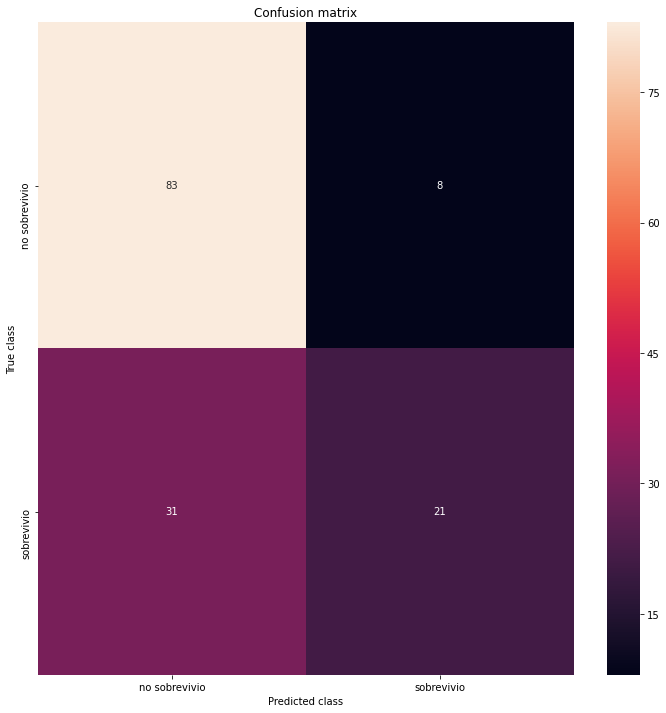

verdaderos positivos: 21
falsos positivos: 8
verdaderos negativos: 83
falsos negativos: 31
              precision    recall  f1-score   support

           0       0.73      0.91      0.81        91
           1       0.72      0.40      0.52        52

    accuracy                           0.73       143
   macro avg       0.73      0.66      0.66       143
weighted avg       0.73      0.73      0.70       143

           metrics_train  metrics_test
Accuracy        0.743409      0.727273
Precision       0.804878      0.724138
Recall:         0.447964      0.403846
F1_Score:       0.575581      0.518519


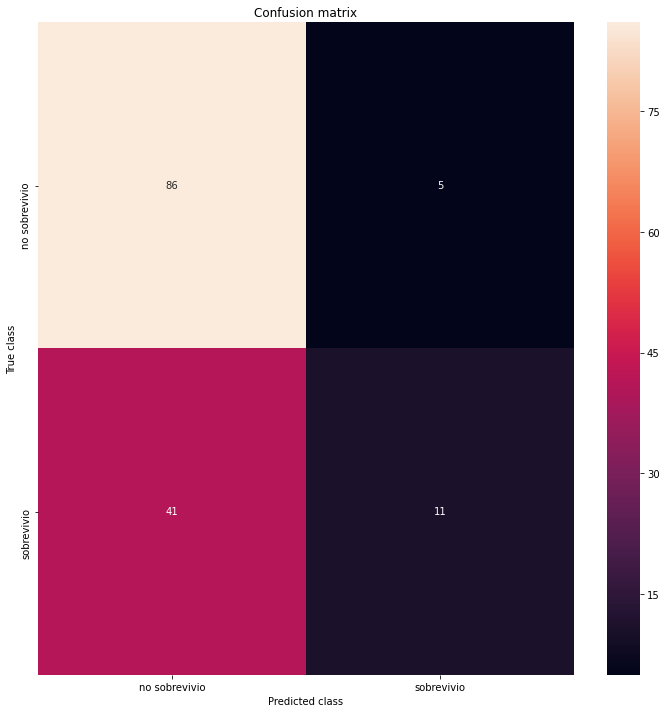

verdaderos positivos: 11
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 41
              precision    recall  f1-score   support

           0       0.68      0.95      0.79        91
           1       0.69      0.21      0.32        52

    accuracy                           0.68       143
   macro avg       0.68      0.58      0.56       143
weighted avg       0.68      0.68      0.62       143

           metrics_train  metrics_test
Accuracy        0.652021      0.678322
Precision       0.716981      0.687500
Recall:         0.171946      0.211538
F1_Score:       0.277372      0.323529


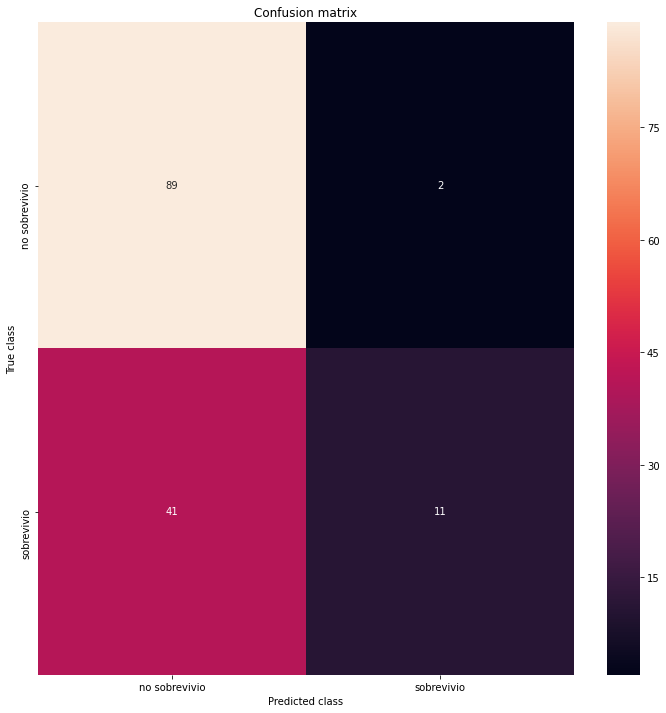

verdaderos positivos: 11
falsos positivos: 2
verdaderos negativos: 89
falsos negativos: 41
              precision    recall  f1-score   support

           0       0.68      0.98      0.81        91
           1       0.85      0.21      0.34        52

    accuracy                           0.70       143
   macro avg       0.77      0.59      0.57       143
weighted avg       0.74      0.70      0.64       143

           metrics_train  metrics_test
Accuracy        0.650264      0.699301
Precision       0.843750      0.846154
Recall:         0.122172      0.211538
F1_Score:       0.213439      0.338462


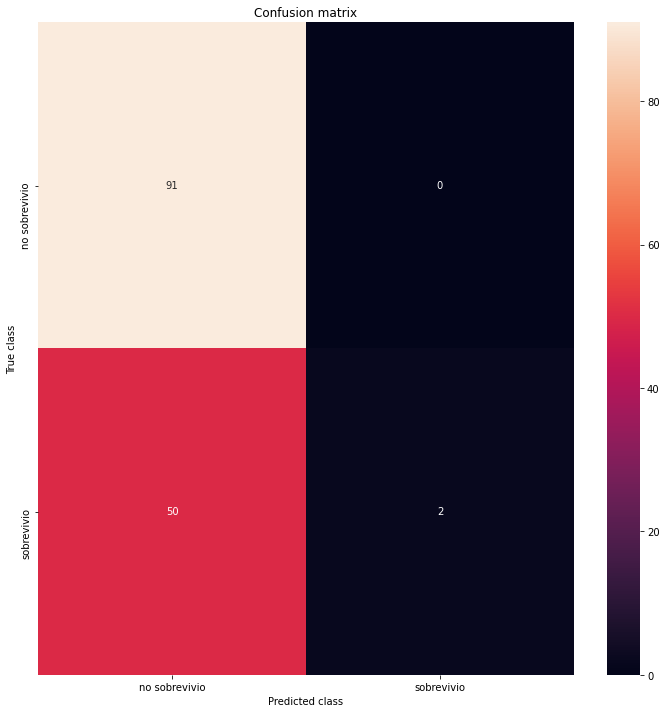

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074


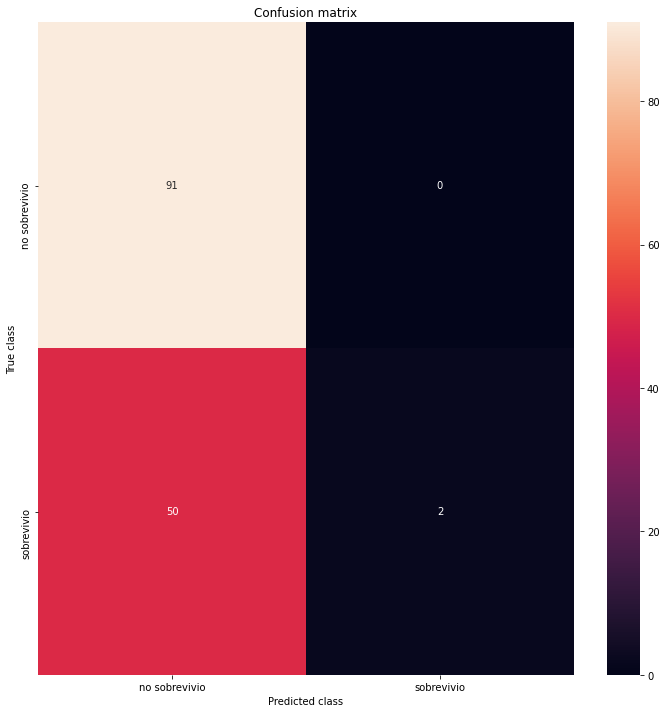

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.797511
Training accuracy: 0.487%
loss at step 1000: 0.576709
Training accuracy: 0.632%
Test accuracy: 0.818%


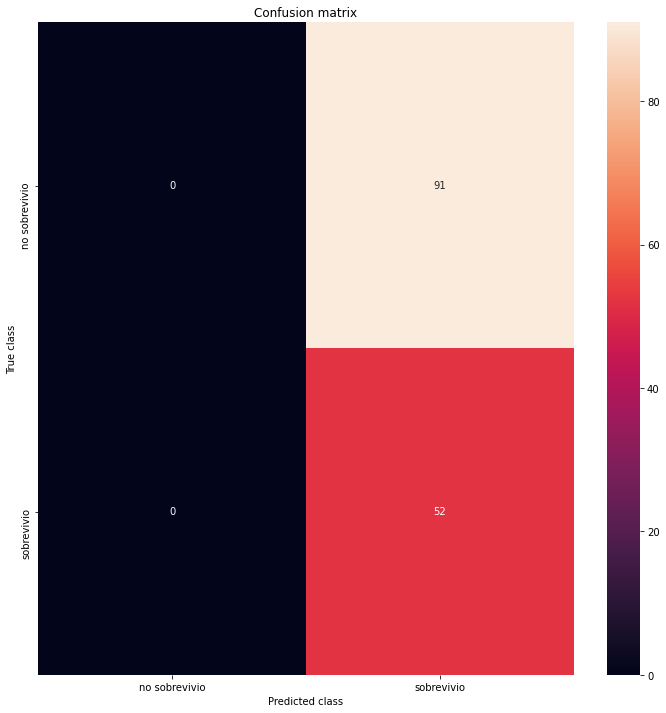

C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143

           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


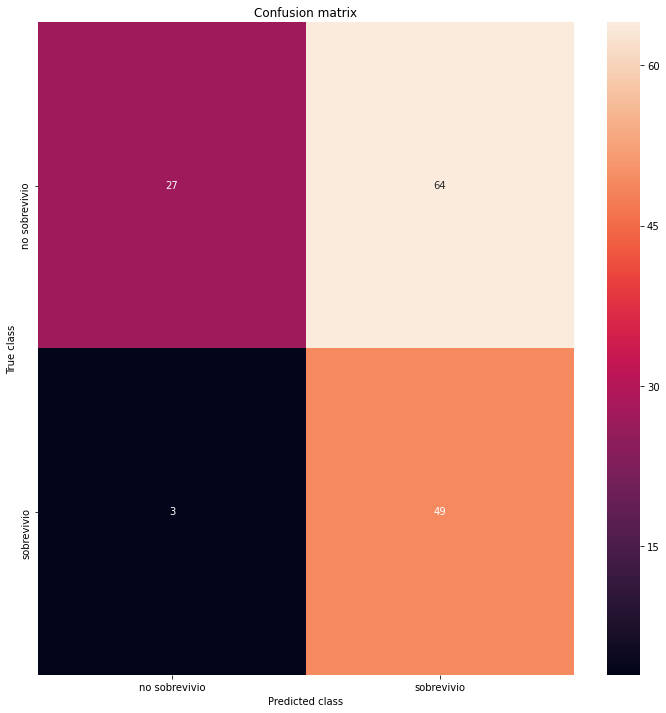

verdaderos positivos: 49
falsos positivos: 64
verdaderos negativos: 27
falsos negativos: 3
              precision    recall  f1-score   support

           0       0.90      0.30      0.45        91
           1       0.43      0.94      0.59        52

    accuracy                           0.53       143
   macro avg       0.67      0.62      0.52       143
weighted avg       0.73      0.53      0.50       143

           metrics_train  metrics_test
Accuracy        0.546573      0.531469
Precision       0.458050      0.433628
Recall:         0.914027      0.942308
F1_Score:       0.610272      0.593939


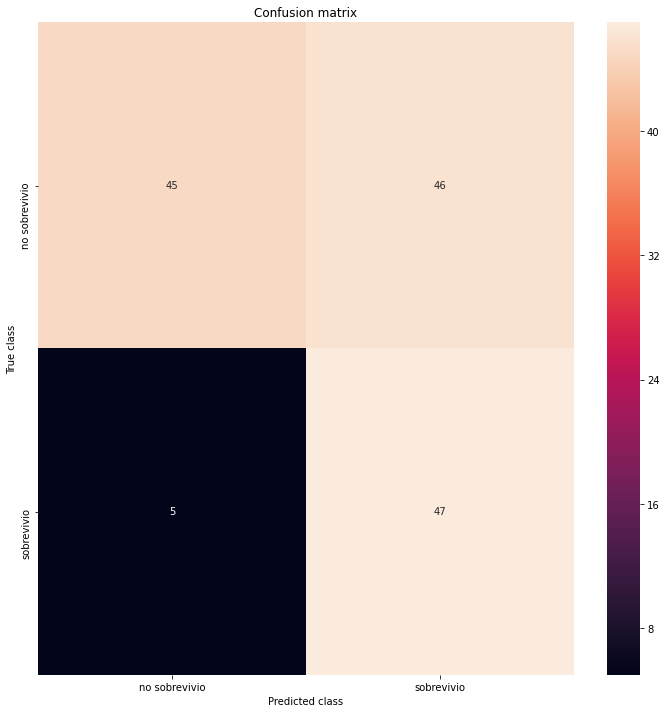

verdaderos positivos: 47
falsos positivos: 46
verdaderos negativos: 45
falsos negativos: 5
              precision    recall  f1-score   support

           0       0.90      0.49      0.64        91
           1       0.51      0.90      0.65        52

    accuracy                           0.64       143
   macro avg       0.70      0.70      0.64       143
weighted avg       0.76      0.64      0.64       143

           metrics_train  metrics_test
Accuracy        0.646749      0.643357
Precision       0.526882      0.505376
Recall:         0.886878      0.903846
F1_Score:       0.661046      0.648276


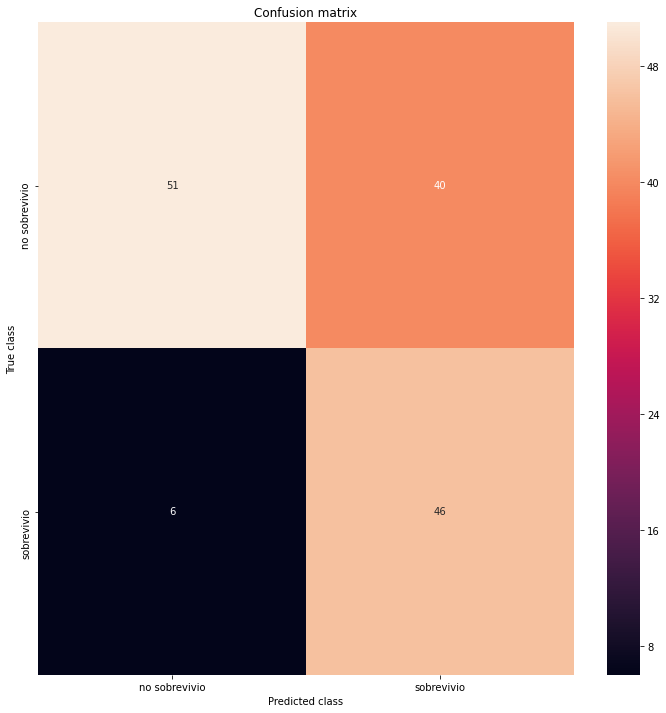

verdaderos positivos: 46
falsos positivos: 40
verdaderos negativos: 51
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.89      0.56      0.69        91
           1       0.53      0.88      0.67        52

    accuracy                           0.68       143
   macro avg       0.71      0.72      0.68       143
weighted avg       0.76      0.68      0.68       143

           metrics_train  metrics_test
Accuracy        0.659051      0.678322
Precision       0.538682      0.534884
Recall:         0.850679      0.884615
F1_Score:       0.659649      0.666667


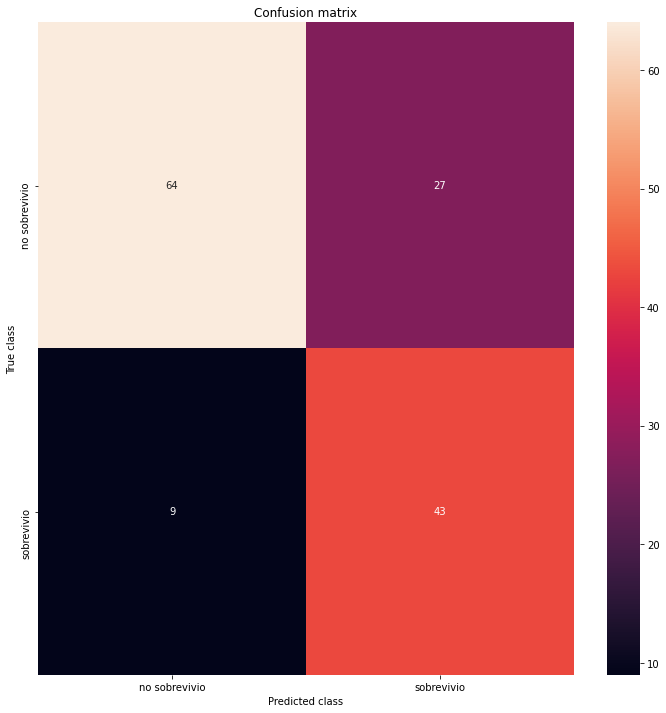

verdaderos positivos: 43
falsos positivos: 27
verdaderos negativos: 64
falsos negativos: 9
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        91
           1       0.61      0.83      0.70        52

    accuracy                           0.75       143
   macro avg       0.75      0.77      0.74       143
weighted avg       0.78      0.75      0.75       143

           metrics_train  metrics_test
Accuracy        0.743409      0.748252
Precision       0.640449      0.614286
Recall:         0.773756      0.826923
F1_Score:       0.700820      0.704918


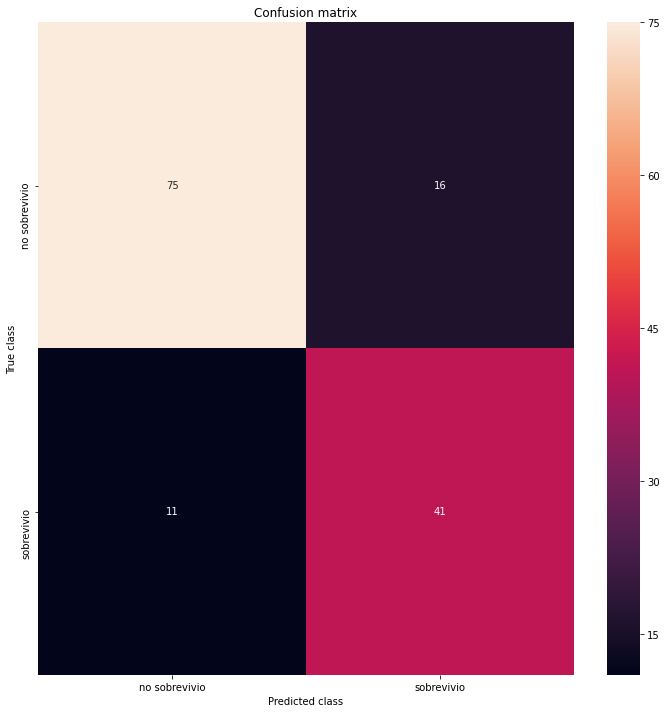

verdaderos positivos: 41
falsos positivos: 16
verdaderos negativos: 75
falsos negativos: 11
              precision    recall  f1-score   support

           0       0.87      0.82      0.85        91
           1       0.72      0.79      0.75        52

    accuracy                           0.81       143
   macro avg       0.80      0.81      0.80       143
weighted avg       0.82      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.782074      0.811189
Precision       0.713656      0.719298
Recall:         0.733032      0.788462
F1_Score:       0.723214      0.752294


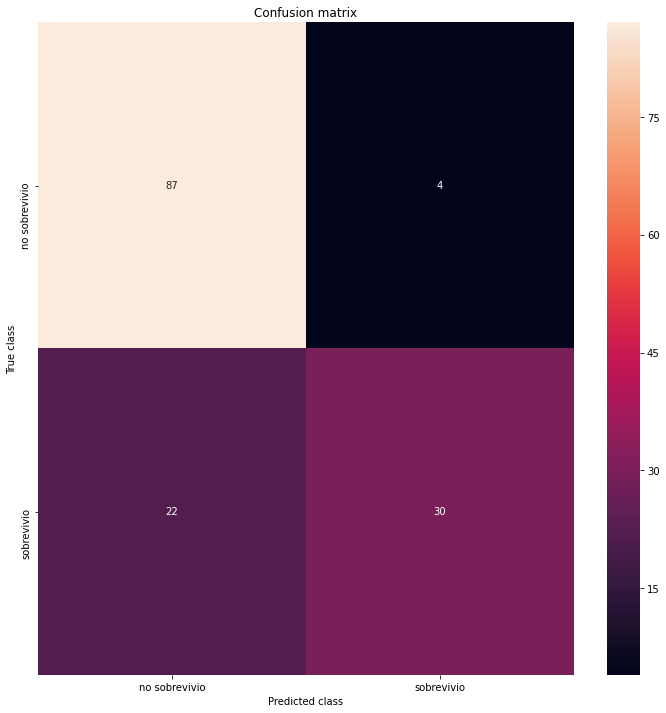

verdaderos positivos: 30
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 22
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        91
           1       0.88      0.58      0.70        52

    accuracy                           0.82       143
   macro avg       0.84      0.77      0.78       143
weighted avg       0.83      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.776801      0.818182
Precision       0.840580      0.882353
Recall:         0.524887      0.576923
F1_Score:       0.646240      0.697674


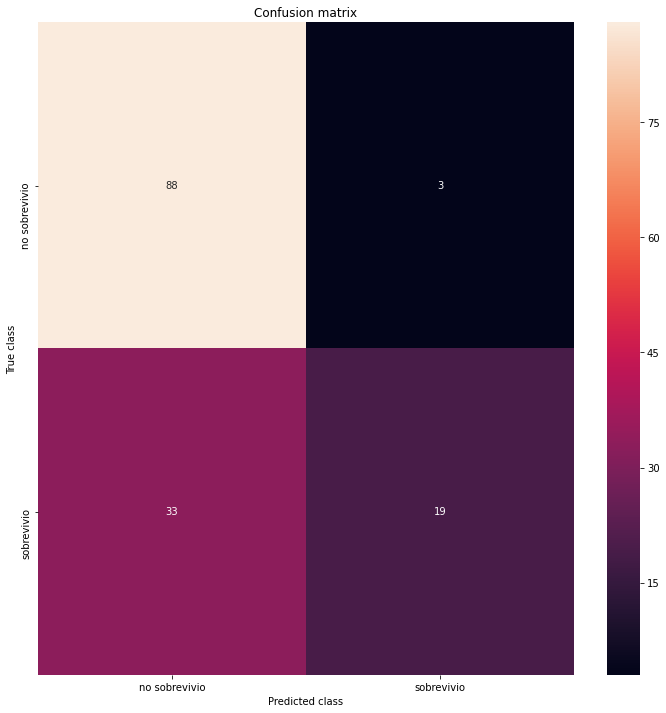

verdaderos positivos: 19
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 33
              precision    recall  f1-score   support

           0       0.73      0.97      0.83        91
           1       0.86      0.37      0.51        52

    accuracy                           0.75       143
   macro avg       0.80      0.67      0.67       143
weighted avg       0.78      0.75      0.72       143

           metrics_train  metrics_test
Accuracy        0.745167      0.748252
Precision       0.975000      0.863636
Recall:         0.352941      0.365385
F1_Score:       0.518272      0.513514
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.824859
Training accuracy: 0.351%
loss at step 1000: 0.686486
Training accuracy: 0.506%
Test accuracy: 0.720%


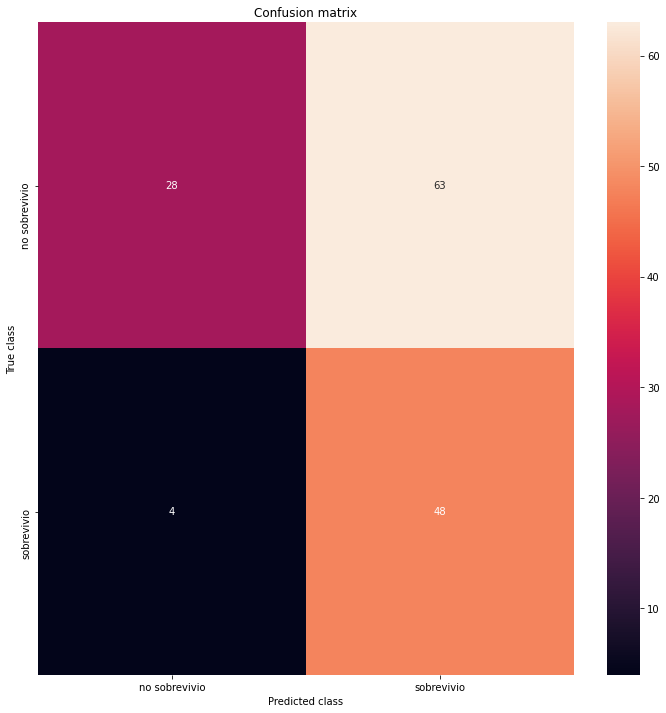

verdaderos positivos: 48
falsos positivos: 63
verdaderos negativos: 28
falsos negativos: 4
              precision    recall  f1-score   support

           0       0.88      0.31      0.46        91
           1       0.43      0.92      0.59        52

    accuracy                           0.53       143
   macro avg       0.65      0.62      0.52       143
weighted avg       0.71      0.53      0.50       143

           metrics_train  metrics_test
Accuracy        0.550088      0.531469
Precision       0.460137      0.432432
Recall:         0.914027      0.923077
F1_Score:       0.612121      0.588957


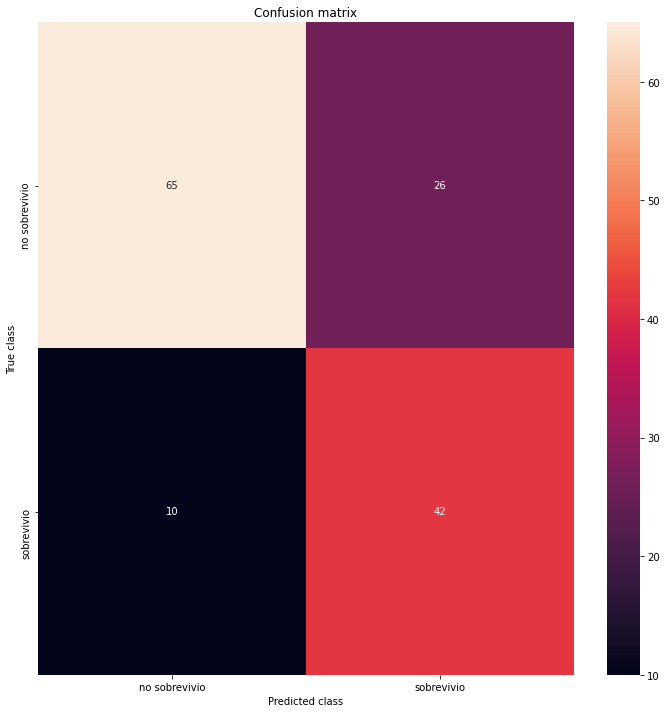

verdaderos positivos: 42
falsos positivos: 26
verdaderos negativos: 65
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.87      0.71      0.78        91
           1       0.62      0.81      0.70        52

    accuracy                           0.75       143
   macro avg       0.74      0.76      0.74       143
weighted avg       0.78      0.75      0.75       143

           metrics_train  metrics_test
Accuracy        0.736380      0.748252
Precision       0.637066      0.617647
Recall:         0.746606      0.807692
F1_Score:       0.687500      0.700000


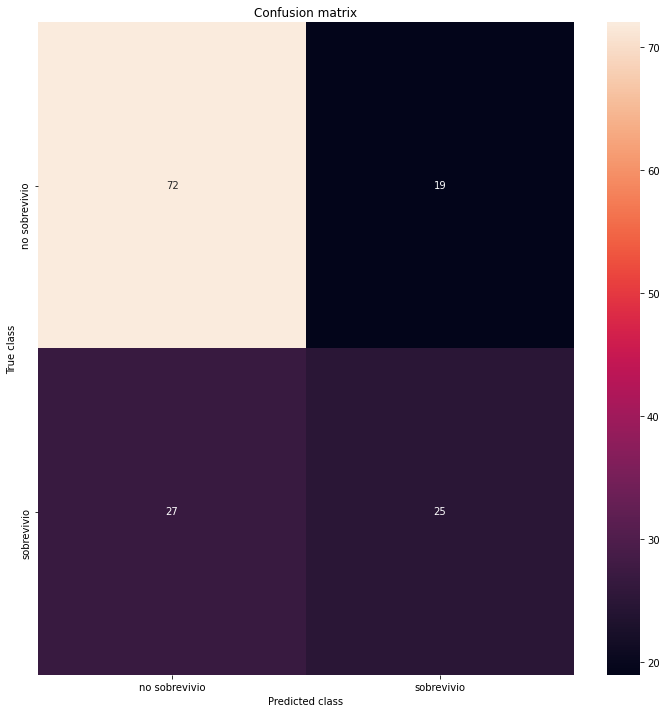

verdaderos positivos: 25
falsos positivos: 19
verdaderos negativos: 72
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        91
           1       0.57      0.48      0.52        52

    accuracy                           0.68       143
   macro avg       0.65      0.64      0.64       143
weighted avg       0.67      0.68      0.67       143

           metrics_train  metrics_test
Accuracy        0.718805      0.678322
Precision       0.682635      0.568182
Recall:         0.515837      0.480769
F1_Score:       0.587629      0.520833


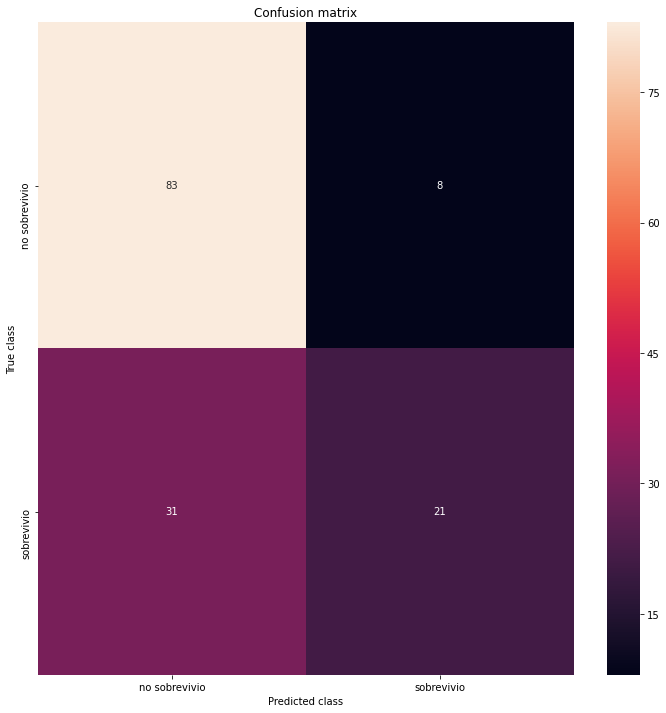

verdaderos positivos: 21
falsos positivos: 8
verdaderos negativos: 83
falsos negativos: 31
              precision    recall  f1-score   support

           0       0.73      0.91      0.81        91
           1       0.72      0.40      0.52        52

    accuracy                           0.73       143
   macro avg       0.73      0.66      0.66       143
weighted avg       0.73      0.73      0.70       143

           metrics_train  metrics_test
Accuracy        0.743409      0.727273
Precision       0.804878      0.724138
Recall:         0.447964      0.403846
F1_Score:       0.575581      0.518519


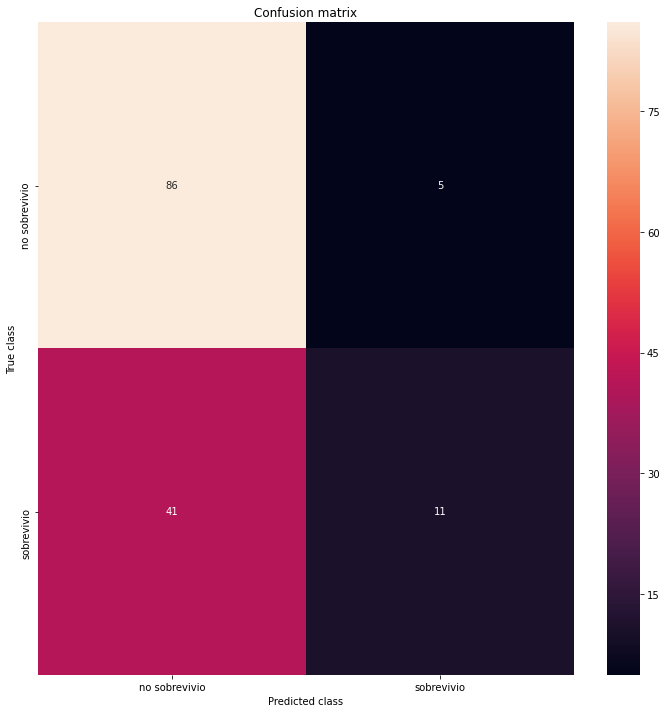

verdaderos positivos: 11
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 41
              precision    recall  f1-score   support

           0       0.68      0.95      0.79        91
           1       0.69      0.21      0.32        52

    accuracy                           0.68       143
   macro avg       0.68      0.58      0.56       143
weighted avg       0.68      0.68      0.62       143

           metrics_train  metrics_test
Accuracy        0.652021      0.678322
Precision       0.716981      0.687500
Recall:         0.171946      0.211538
F1_Score:       0.277372      0.323529


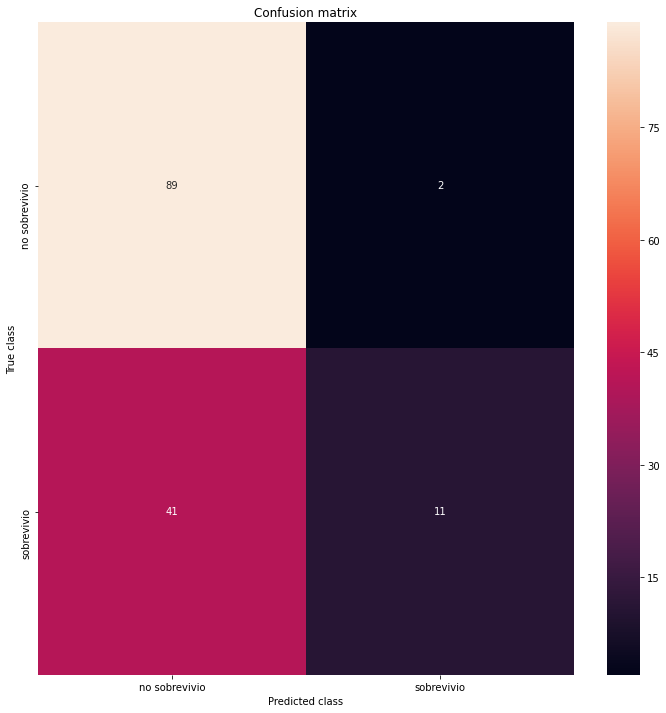

verdaderos positivos: 11
falsos positivos: 2
verdaderos negativos: 89
falsos negativos: 41
              precision    recall  f1-score   support

           0       0.68      0.98      0.81        91
           1       0.85      0.21      0.34        52

    accuracy                           0.70       143
   macro avg       0.77      0.59      0.57       143
weighted avg       0.74      0.70      0.64       143

           metrics_train  metrics_test
Accuracy        0.650264      0.699301
Precision       0.843750      0.846154
Recall:         0.122172      0.211538
F1_Score:       0.213439      0.338462


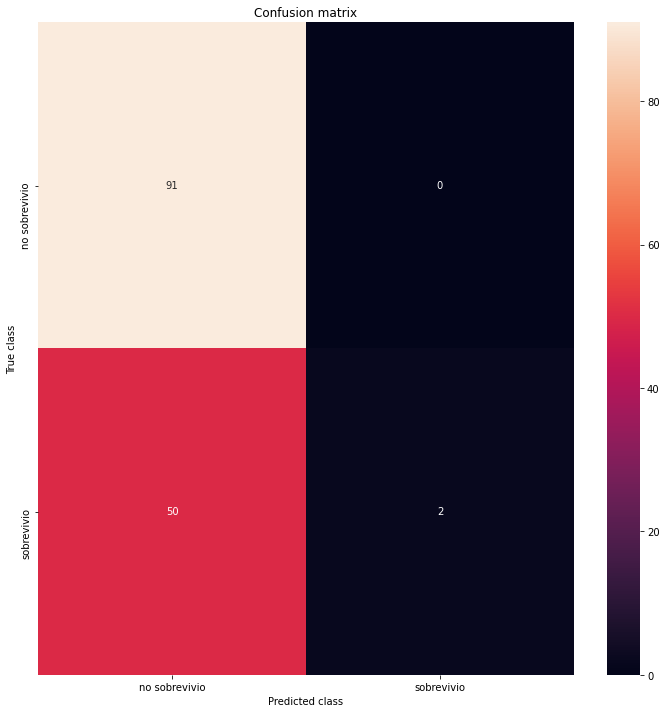

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


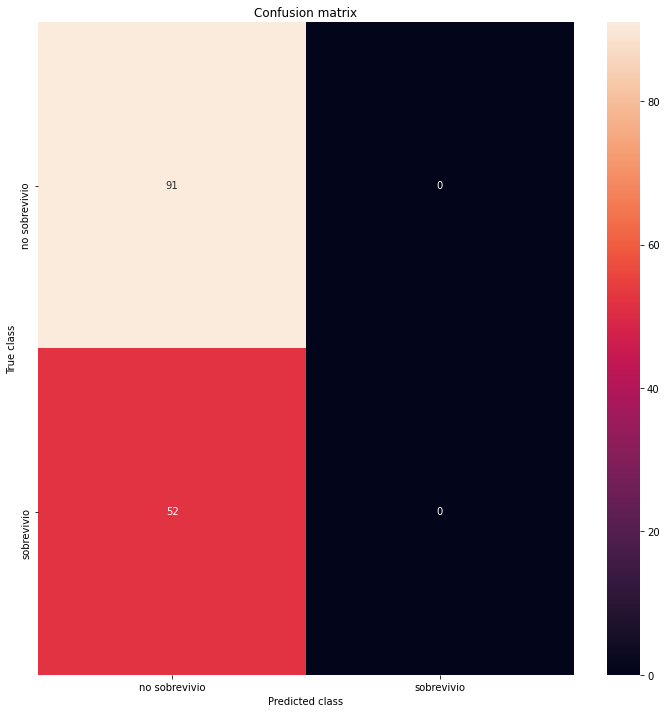

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.796667
Training accuracy: 0.485%
loss at step 1000: 0.579871
Training accuracy: 0.631%
Test accuracy: 0.818%


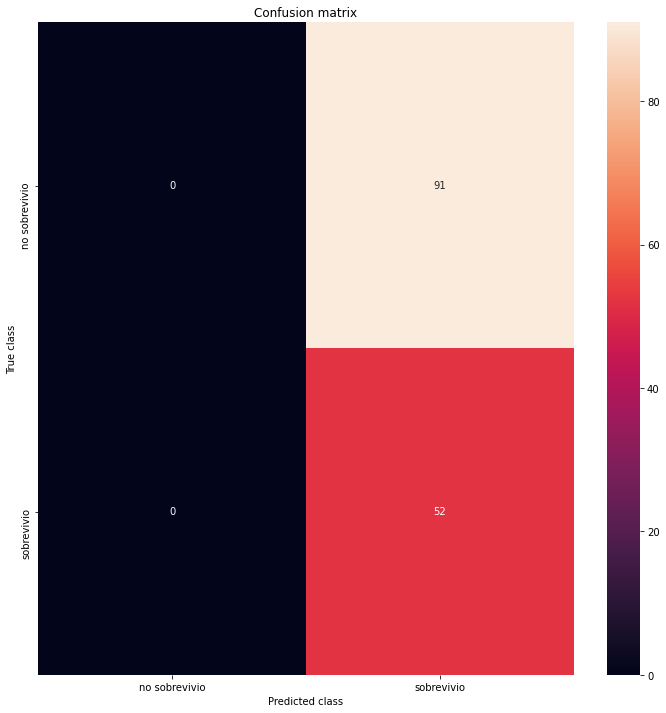

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


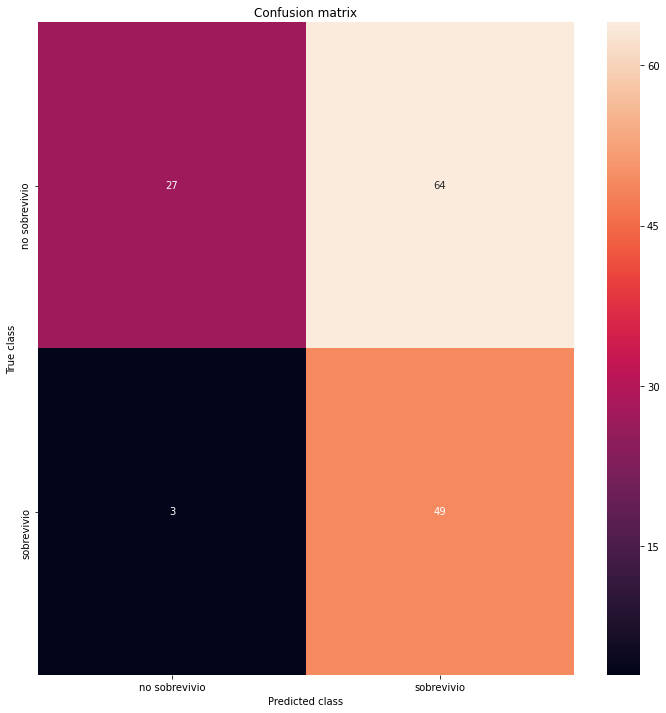

verdaderos positivos: 49
falsos positivos: 64
verdaderos negativos: 27
falsos negativos: 3
              precision    recall  f1-score   support

           0       0.90      0.30      0.45        91
           1       0.43      0.94      0.59        52

    accuracy                           0.53       143
   macro avg       0.67      0.62      0.52       143
weighted avg       0.73      0.53      0.50       143

           metrics_train  metrics_test
Accuracy        0.546573      0.531469
Precision       0.458050      0.433628
Recall:         0.914027      0.942308
F1_Score:       0.610272      0.593939


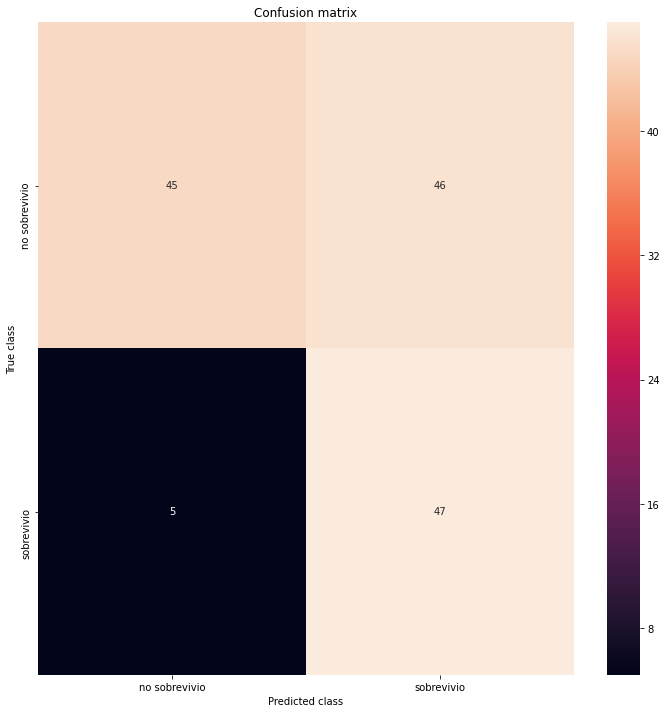

verdaderos positivos: 47
falsos positivos: 46
verdaderos negativos: 45
falsos negativos: 5
              precision    recall  f1-score   support

           0       0.90      0.49      0.64        91
           1       0.51      0.90      0.65        52

    accuracy                           0.64       143
   macro avg       0.70      0.70      0.64       143
weighted avg       0.76      0.64      0.64       143

           metrics_train  metrics_test
Accuracy        0.646749      0.643357
Precision       0.526882      0.505376
Recall:         0.886878      0.903846
F1_Score:       0.661046      0.648276


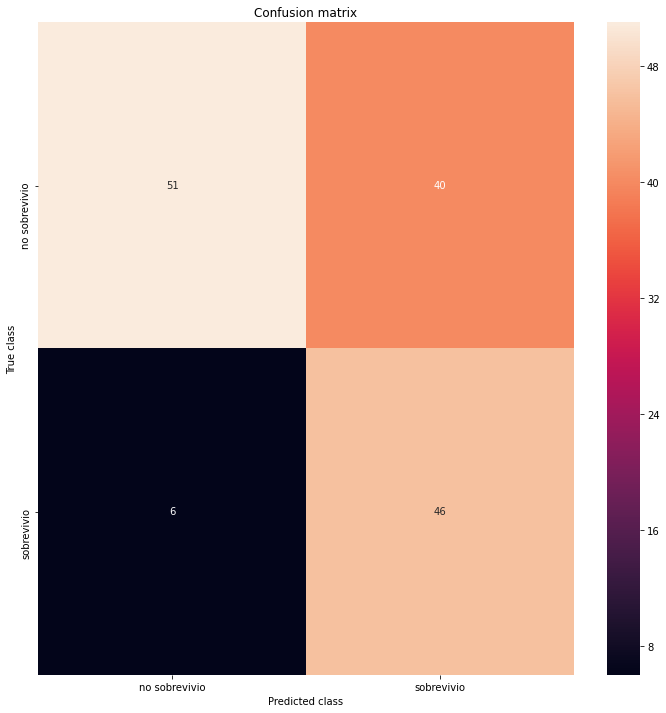

verdaderos positivos: 46
falsos positivos: 40
verdaderos negativos: 51
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.89      0.56      0.69        91
           1       0.53      0.88      0.67        52

    accuracy                           0.68       143
   macro avg       0.71      0.72      0.68       143
weighted avg       0.76      0.68      0.68       143

           metrics_train  metrics_test
Accuracy        0.659051      0.678322
Precision       0.538682      0.534884
Recall:         0.850679      0.884615
F1_Score:       0.659649      0.666667


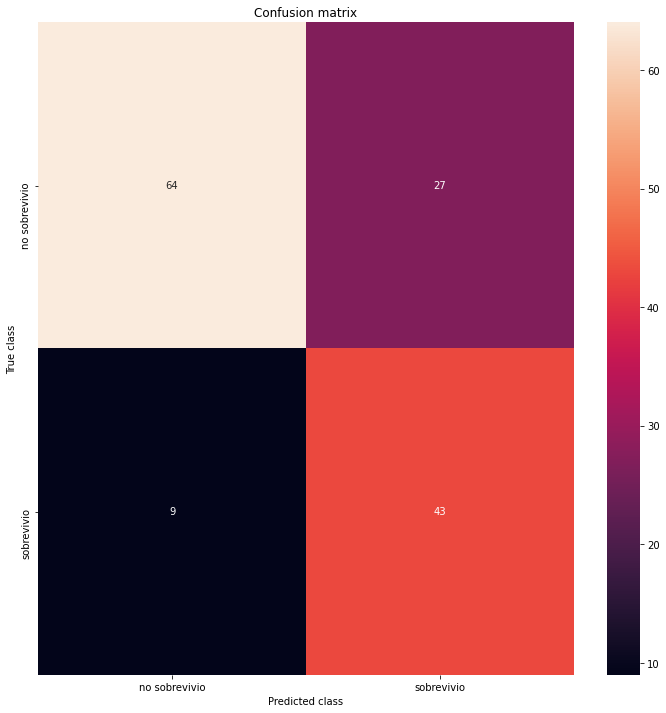

verdaderos positivos: 43
falsos positivos: 27
verdaderos negativos: 64
falsos negativos: 9
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        91
           1       0.61      0.83      0.70        52

    accuracy                           0.75       143
   macro avg       0.75      0.77      0.74       143
weighted avg       0.78      0.75      0.75       143

           metrics_train  metrics_test
Accuracy        0.743409      0.748252
Precision       0.640449      0.614286
Recall:         0.773756      0.826923
F1_Score:       0.700820      0.704918


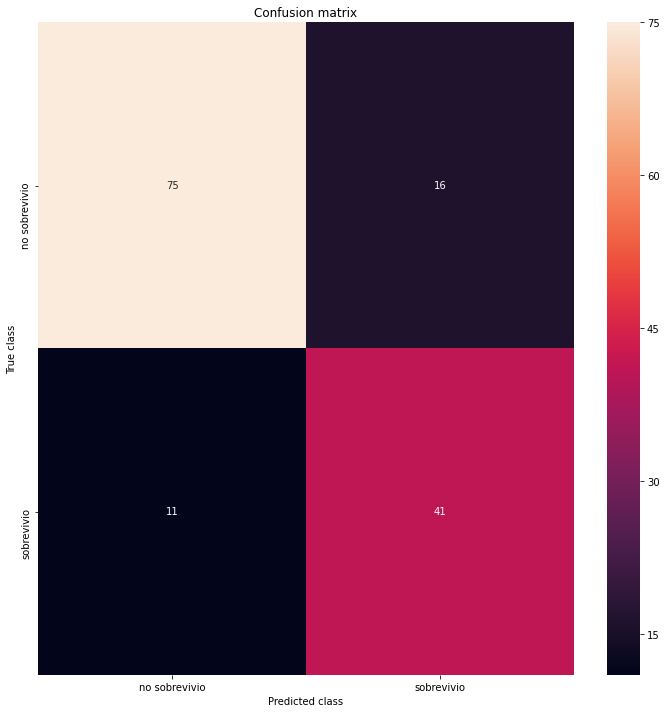

verdaderos positivos: 41
falsos positivos: 16
verdaderos negativos: 75
falsos negativos: 11
              precision    recall  f1-score   support

           0       0.87      0.82      0.85        91
           1       0.72      0.79      0.75        52

    accuracy                           0.81       143
   macro avg       0.80      0.81      0.80       143
weighted avg       0.82      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.782074      0.811189
Precision       0.713656      0.719298
Recall:         0.733032      0.788462
F1_Score:       0.723214      0.752294


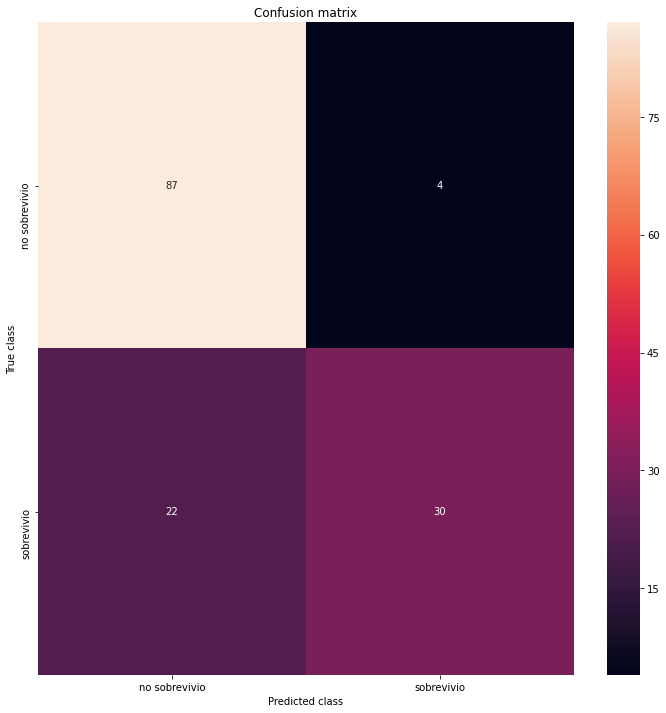

verdaderos positivos: 30
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 22
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        91
           1       0.88      0.58      0.70        52

    accuracy                           0.82       143
   macro avg       0.84      0.77      0.78       143
weighted avg       0.83      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.776801      0.818182
Precision       0.840580      0.882353
Recall:         0.524887      0.576923
F1_Score:       0.646240      0.697674


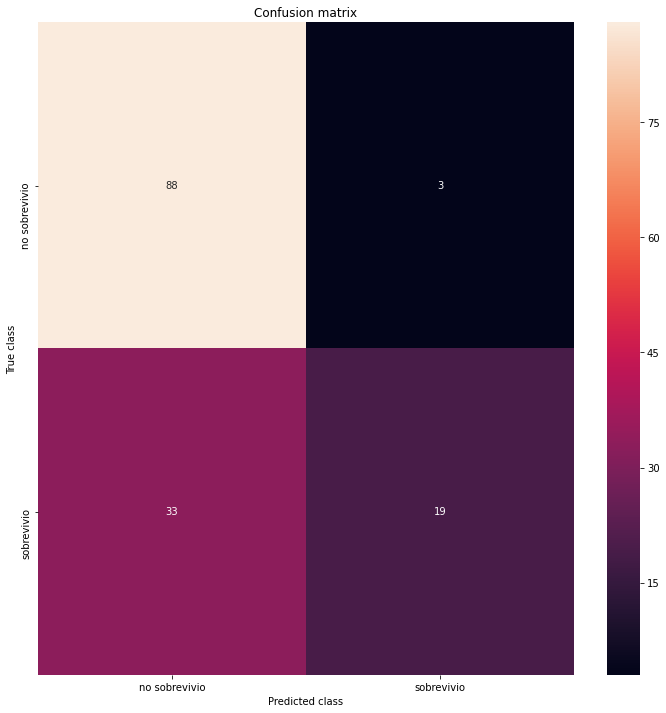

verdaderos positivos: 19
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 33
              precision    recall  f1-score   support

           0       0.73      0.97      0.83        91
           1       0.86      0.37      0.51        52

    accuracy                           0.75       143
   macro avg       0.80      0.67      0.67       143
weighted avg       0.78      0.75      0.72       143

           metrics_train  metrics_test
Accuracy        0.745167      0.748252
Precision       0.975000      0.863636
Recall:         0.352941      0.365385
F1_Score:       0.518272      0.513514
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.829532
Training accuracy: 0.353%
loss at step 1000: 0.709684
Training accuracy: 0.484%
Test accuracy: 0.650%


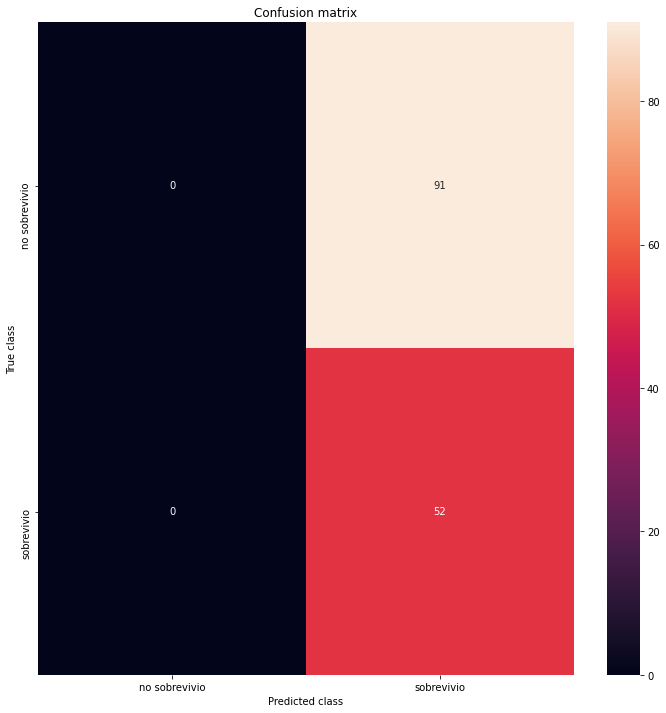

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


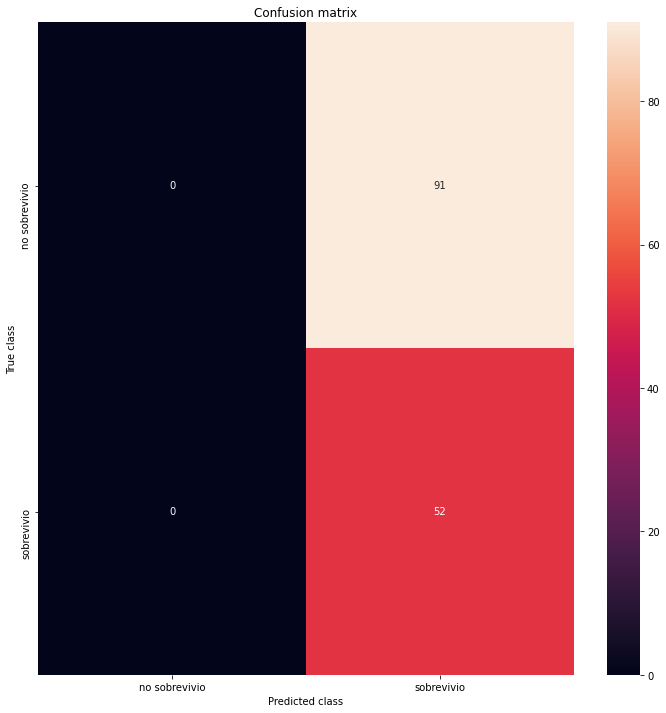

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


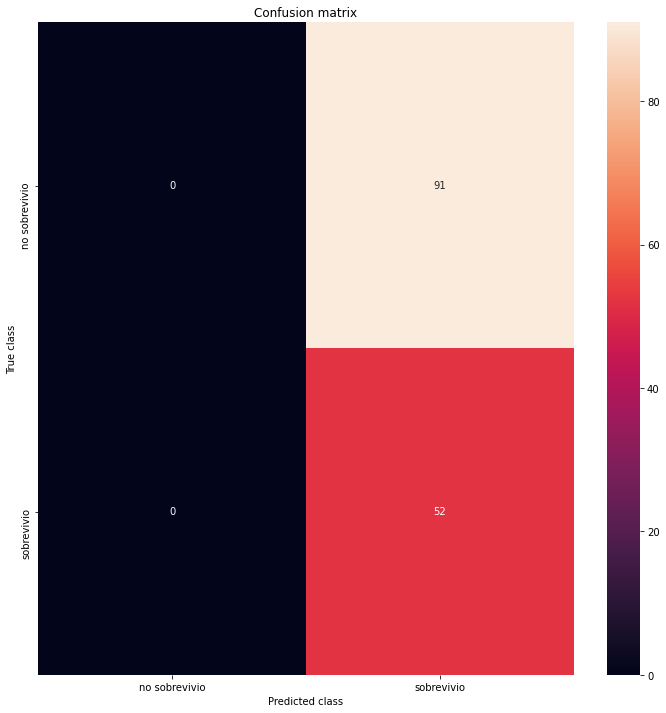

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


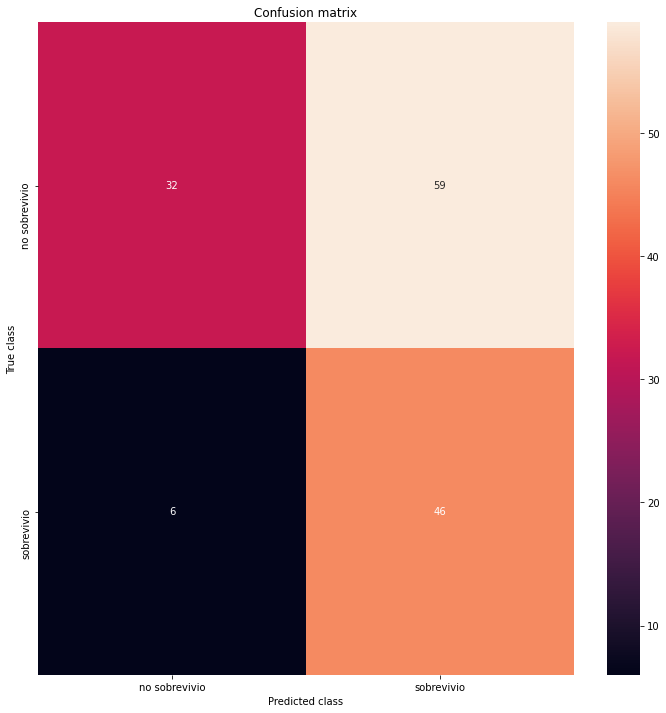

verdaderos positivos: 46
falsos positivos: 59
verdaderos negativos: 32
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.84      0.35      0.50        91
           1       0.44      0.88      0.59        52

    accuracy                           0.55       143
   macro avg       0.64      0.62      0.54       143
weighted avg       0.70      0.55      0.53       143

           metrics_train  metrics_test
Accuracy        0.546573      0.545455
Precision       0.456265      0.438095
Recall:         0.873303      0.884615
F1_Score:       0.599379      0.585987


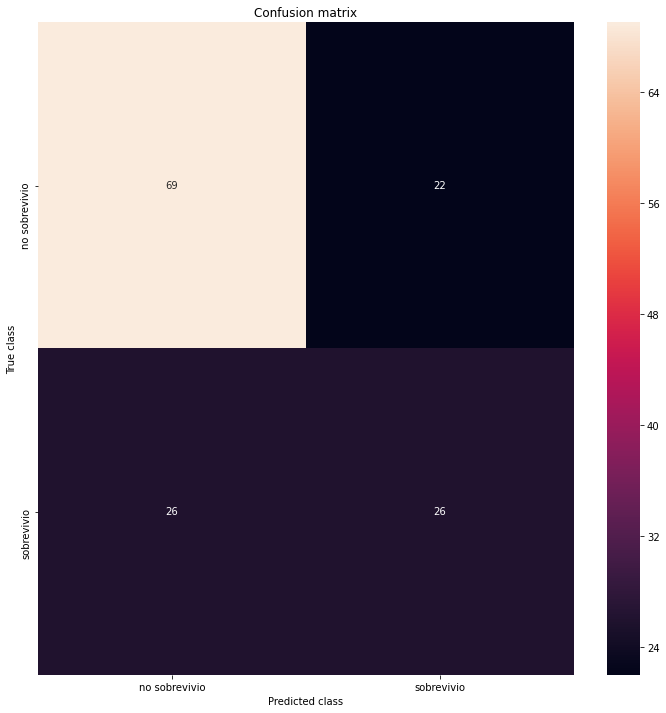

verdaderos positivos: 26
falsos positivos: 22
verdaderos negativos: 69
falsos negativos: 26
              precision    recall  f1-score   support

           0       0.73      0.76      0.74        91
           1       0.54      0.50      0.52        52

    accuracy                           0.66       143
   macro avg       0.63      0.63      0.63       143
weighted avg       0.66      0.66      0.66       143

           metrics_train  metrics_test
Accuracy        0.711775      0.664336
Precision       0.661017      0.541667
Recall:         0.529412      0.500000
F1_Score:       0.587940      0.520000


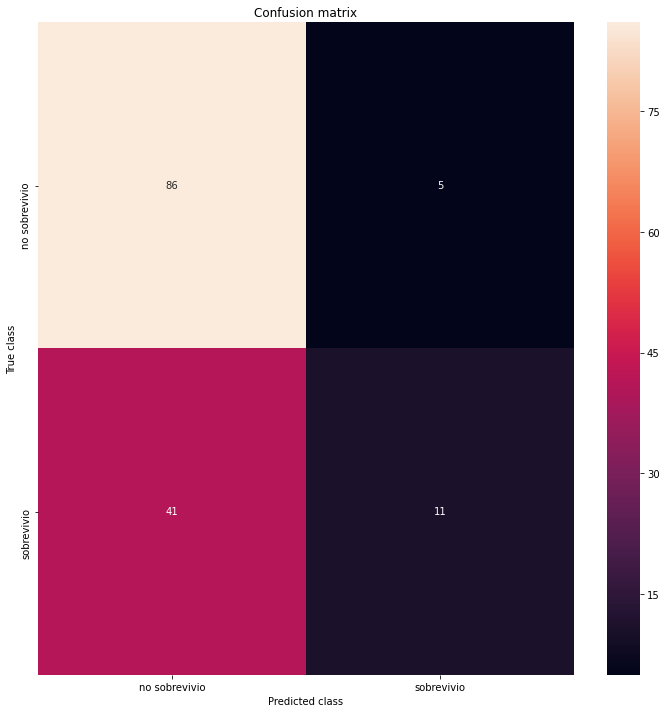

verdaderos positivos: 11
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 41
              precision    recall  f1-score   support

           0       0.68      0.95      0.79        91
           1       0.69      0.21      0.32        52

    accuracy                           0.68       143
   macro avg       0.68      0.58      0.56       143
weighted avg       0.68      0.68      0.62       143

           metrics_train  metrics_test
Accuracy        0.652021      0.678322
Precision       0.716981      0.687500
Recall:         0.171946      0.211538
F1_Score:       0.277372      0.323529


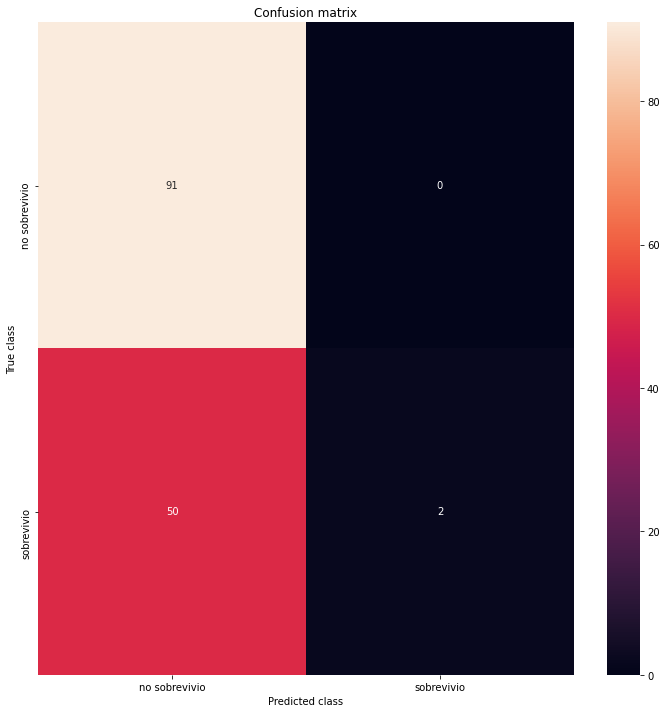

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


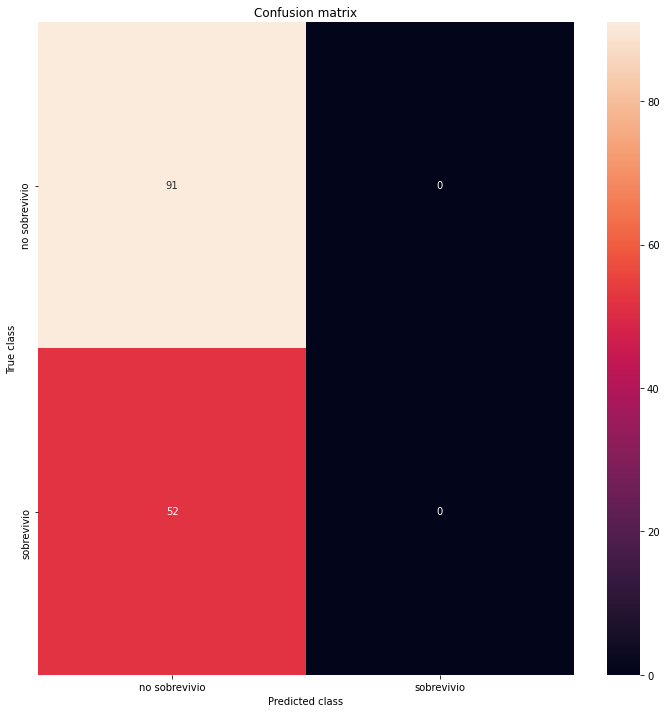

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.738344
Training accuracy: 0.552%
loss at step 1000: 0.632326
Training accuracy: 0.648%
Test accuracy: 0.748%


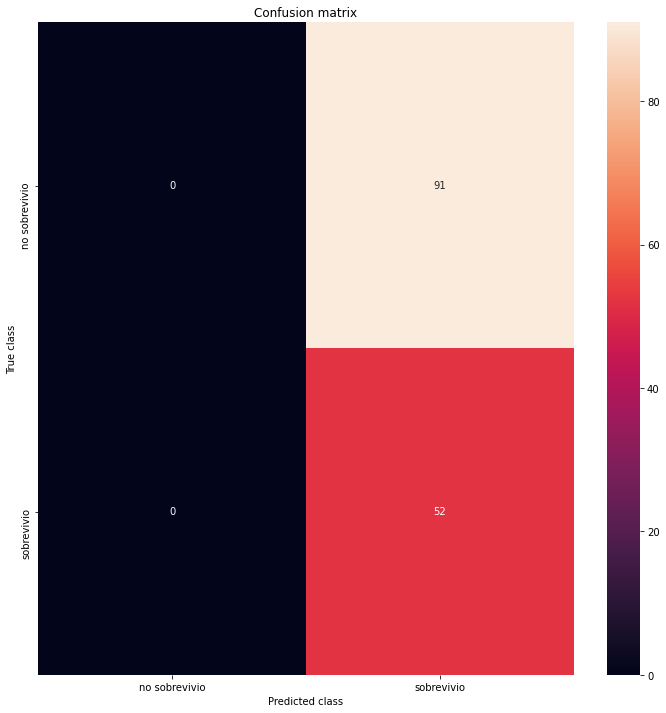

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


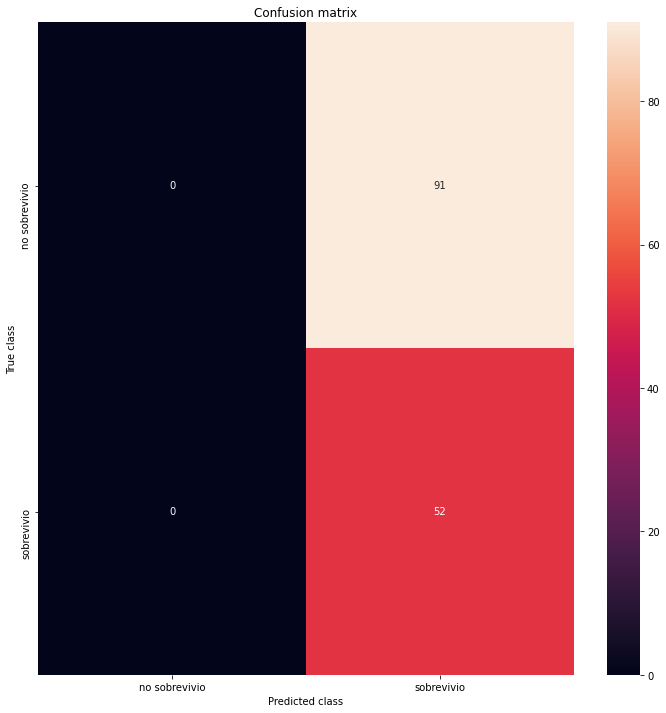

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


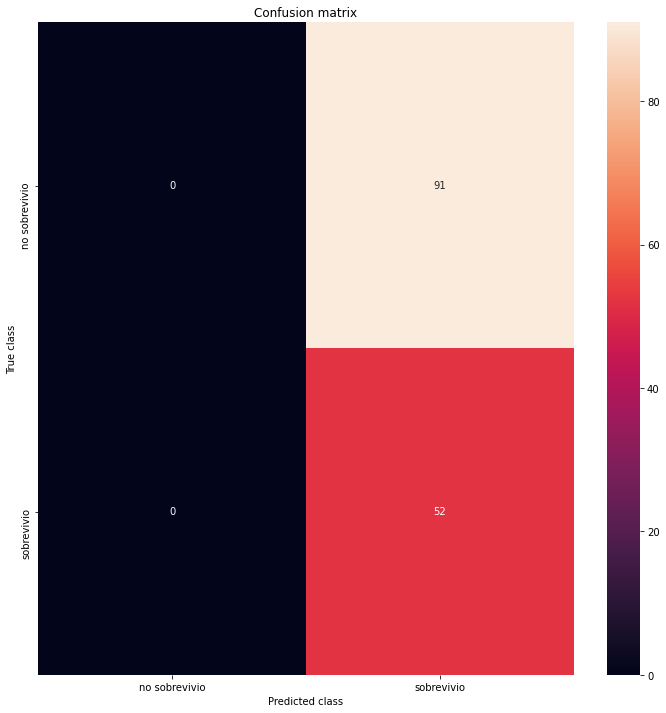

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


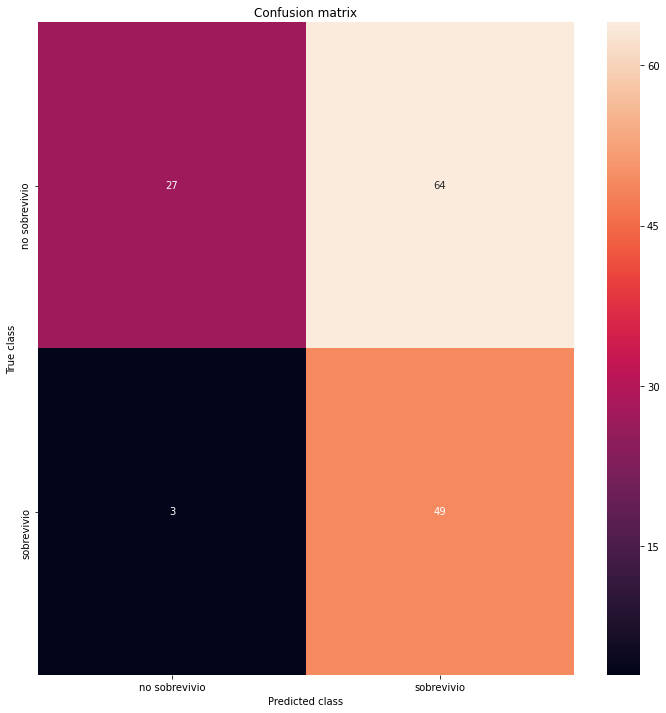

verdaderos positivos: 49
falsos positivos: 64
verdaderos negativos: 27
falsos negativos: 3
              precision    recall  f1-score   support

           0       0.90      0.30      0.45        91
           1       0.43      0.94      0.59        52

    accuracy                           0.53       143
   macro avg       0.67      0.62      0.52       143
weighted avg       0.73      0.53      0.50       143

           metrics_train  metrics_test
Accuracy        0.546573      0.531469
Precision       0.458050      0.433628
Recall:         0.914027      0.942308
F1_Score:       0.610272      0.593939


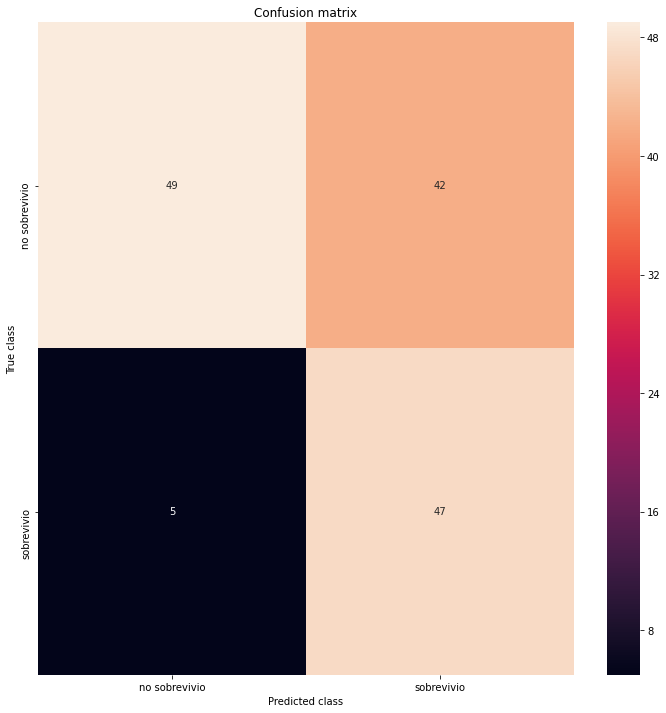

verdaderos positivos: 47
falsos positivos: 42
verdaderos negativos: 49
falsos negativos: 5
              precision    recall  f1-score   support

           0       0.91      0.54      0.68        91
           1       0.53      0.90      0.67        52

    accuracy                           0.67       143
   macro avg       0.72      0.72      0.67       143
weighted avg       0.77      0.67      0.67       143

           metrics_train  metrics_test
Accuracy        0.653779      0.671329
Precision       0.533708      0.528090
Recall:         0.859729      0.903846
F1_Score:       0.658579      0.666667


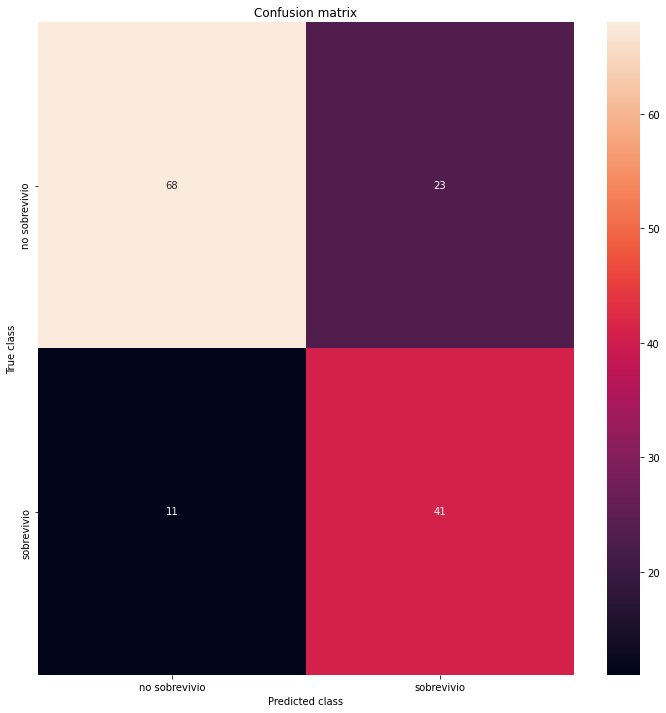

verdaderos positivos: 41
falsos positivos: 23
verdaderos negativos: 68
falsos negativos: 11
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        91
           1       0.64      0.79      0.71        52

    accuracy                           0.76       143
   macro avg       0.75      0.77      0.75       143
weighted avg       0.78      0.76      0.77       143

           metrics_train  metrics_test
Accuracy        0.743409      0.762238
Precision       0.650602      0.640625
Recall:         0.733032      0.788462
F1_Score:       0.689362      0.706897


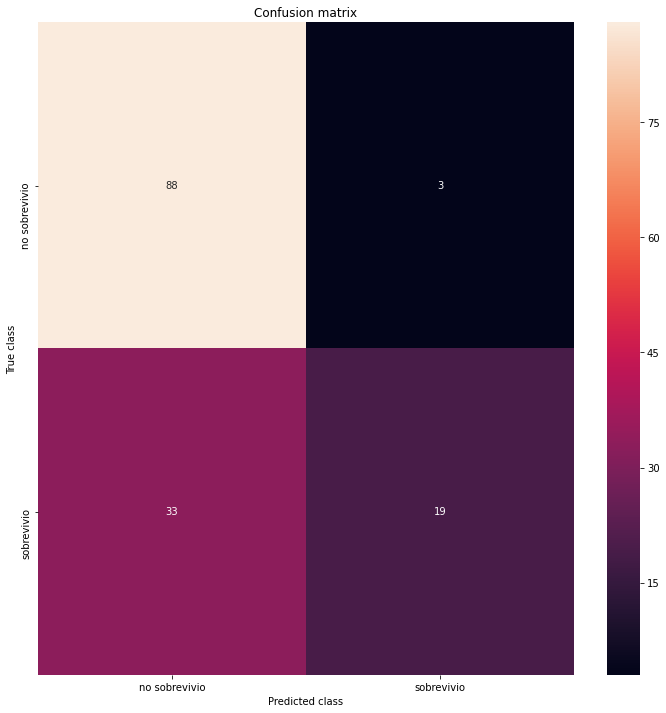

verdaderos positivos: 19
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 33
              precision    recall  f1-score   support

           0       0.73      0.97      0.83        91
           1       0.86      0.37      0.51        52

    accuracy                           0.75       143
   macro avg       0.80      0.67      0.67       143
weighted avg       0.78      0.75      0.72       143

           metrics_train  metrics_test
Accuracy        0.743409      0.748252
Precision       0.974684      0.863636
Recall:         0.348416      0.365385
F1_Score:       0.513333      0.513514


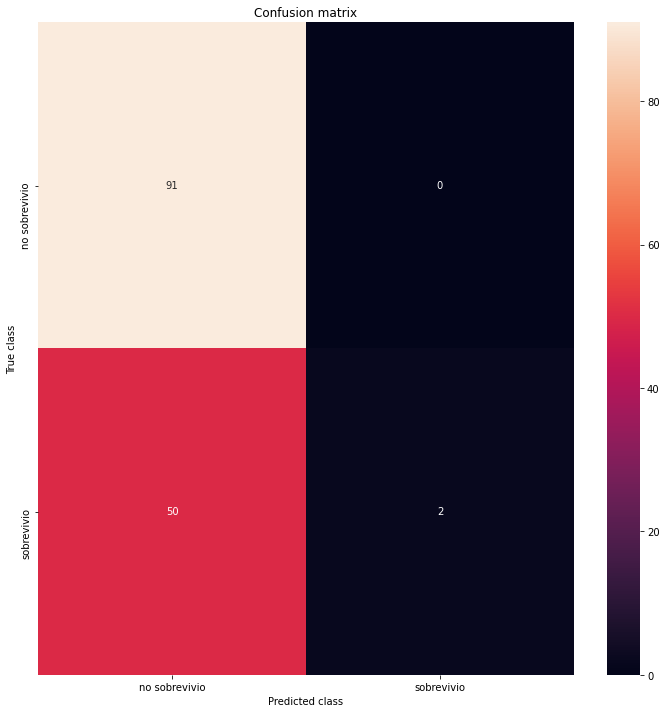

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.776710
Training accuracy: 0.367%
loss at step 1000: 0.634555
Training accuracy: 0.582%
Test accuracy: 0.846%


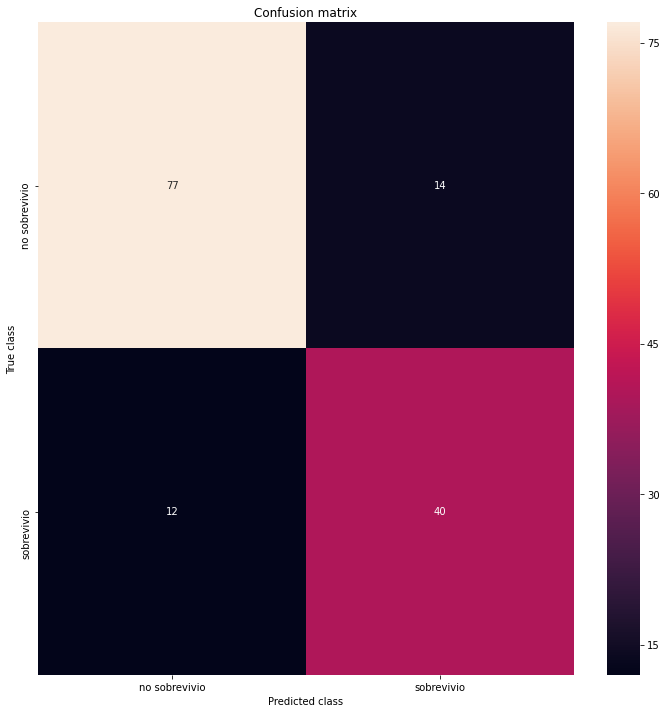

verdaderos positivos: 40
falsos positivos: 14
verdaderos negativos: 77
falsos negativos: 12
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        91
           1       0.74      0.77      0.75        52

    accuracy                           0.82       143
   macro avg       0.80      0.81      0.81       143
weighted avg       0.82      0.82      0.82       143

           metrics_train  metrics_test
Accuracy        0.766257      0.818182
Precision       0.692982      0.740741
Recall:         0.714932      0.769231
F1_Score:       0.703786      0.754717


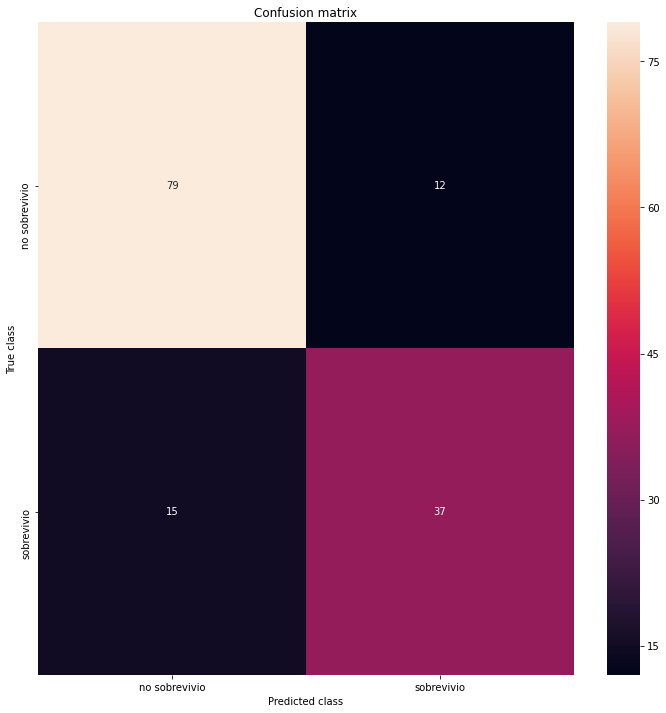

verdaderos positivos: 37
falsos positivos: 12
verdaderos negativos: 79
falsos negativos: 15
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        91
           1       0.76      0.71      0.73        52

    accuracy                           0.81       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.81      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.768014      0.811189
Precision       0.717073      0.755102
Recall:         0.665158      0.711538
F1_Score:       0.690141      0.732673


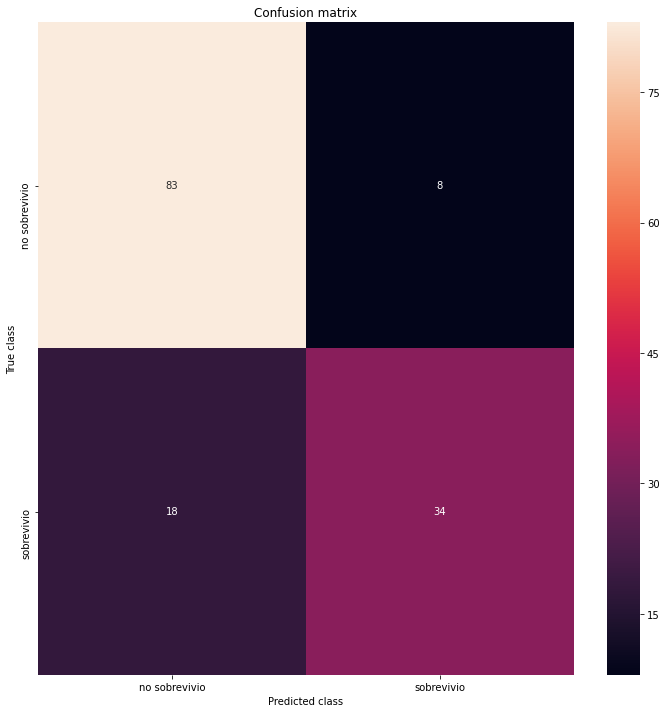

verdaderos positivos: 34
falsos positivos: 8
verdaderos negativos: 83
falsos negativos: 18
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        91
           1       0.81      0.65      0.72        52

    accuracy                           0.82       143
   macro avg       0.82      0.78      0.79       143
weighted avg       0.82      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.787346      0.818182
Precision       0.777778      0.809524
Recall:         0.633484      0.653846
F1_Score:       0.698254      0.723404


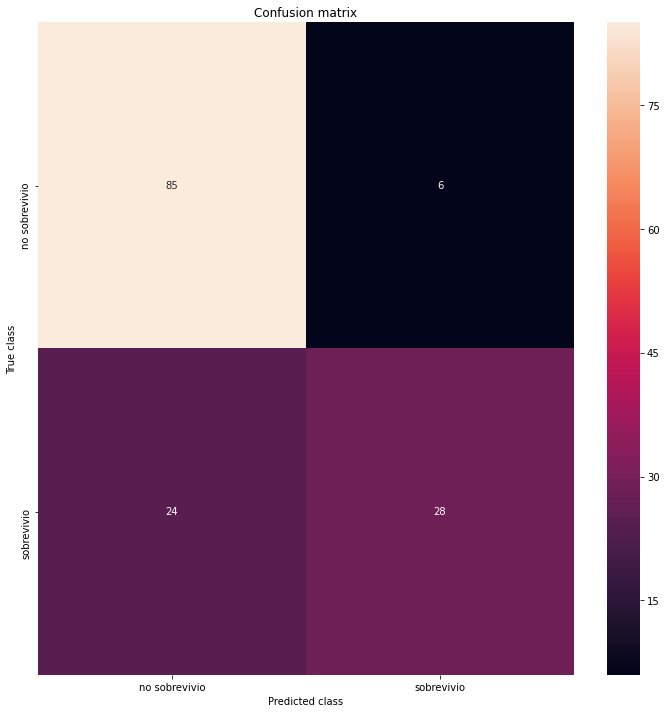

verdaderos positivos: 28
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 24
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        91
           1       0.82      0.54      0.65        52

    accuracy                           0.79       143
   macro avg       0.80      0.74      0.75       143
weighted avg       0.80      0.79      0.78       143

           metrics_train  metrics_test
Accuracy        0.789104      0.790210
Precision       0.868613      0.823529
Recall:         0.538462      0.538462
F1_Score:       0.664804      0.651163


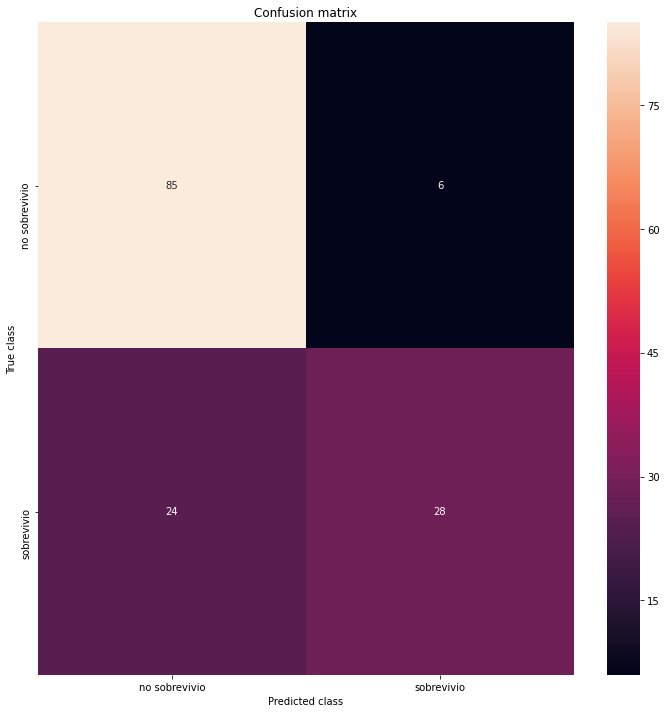

verdaderos positivos: 28
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 24
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        91
           1       0.82      0.54      0.65        52

    accuracy                           0.79       143
   macro avg       0.80      0.74      0.75       143
weighted avg       0.80      0.79      0.78       143

           metrics_train  metrics_test
Accuracy        0.783831      0.790210
Precision       0.865672      0.823529
Recall:         0.524887      0.538462
F1_Score:       0.653521      0.651163


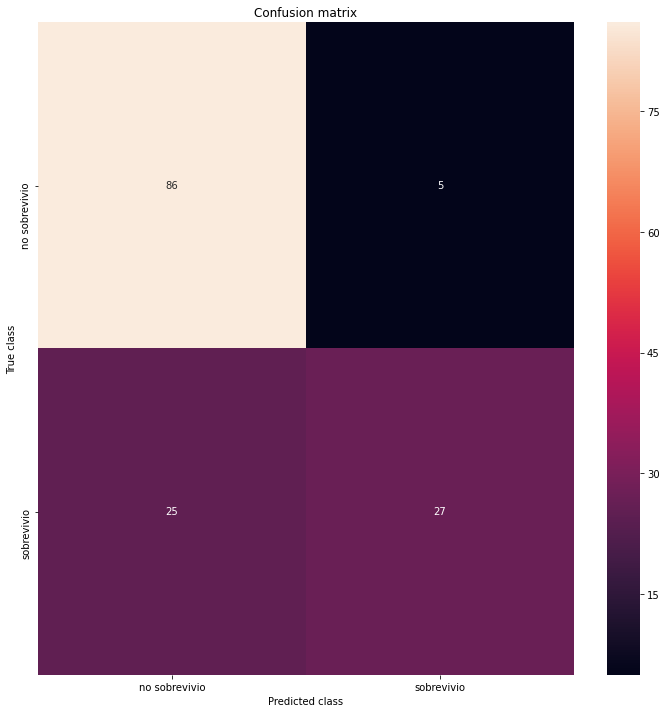

verdaderos positivos: 27
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.77      0.95      0.85        91
           1       0.84      0.52      0.64        52

    accuracy                           0.79       143
   macro avg       0.81      0.73      0.75       143
weighted avg       0.80      0.79      0.78       143

           metrics_train  metrics_test
Accuracy        0.778559      0.790210
Precision       0.868217      0.843750
Recall:         0.506787      0.519231
F1_Score:       0.640000      0.642857


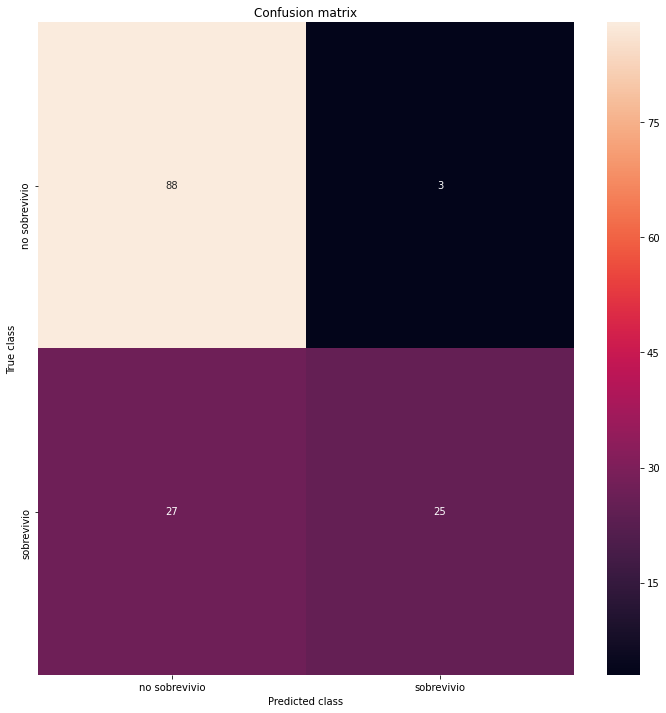

verdaderos positivos: 25
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.77      0.97      0.85        91
           1       0.89      0.48      0.62        52

    accuracy                           0.79       143
   macro avg       0.83      0.72      0.74       143
weighted avg       0.81      0.79      0.77       143

           metrics_train  metrics_test
Accuracy        0.776801      0.790210
Precision       0.951923      0.892857
Recall:         0.447964      0.480769
F1_Score:       0.609231      0.625000


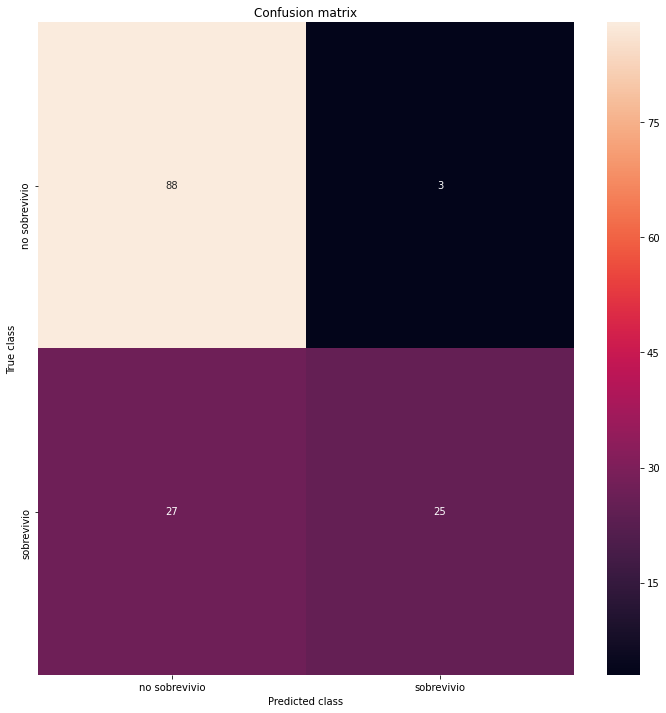

verdaderos positivos: 25
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 27
              precision    recall  f1-score   support

           0       0.77      0.97      0.85        91
           1       0.89      0.48      0.62        52

    accuracy                           0.79       143
   macro avg       0.83      0.72      0.74       143
weighted avg       0.81      0.79      0.77       143

           metrics_train  metrics_test
Accuracy        0.776801      0.790210
Precision       0.951923      0.892857
Recall:         0.447964      0.480769
F1_Score:       0.609231      0.625000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.793458
Training accuracy: 0.438%
loss at step 1000: 0.523442
Training accuracy: 0.617%
Test accuracy: 0.839%


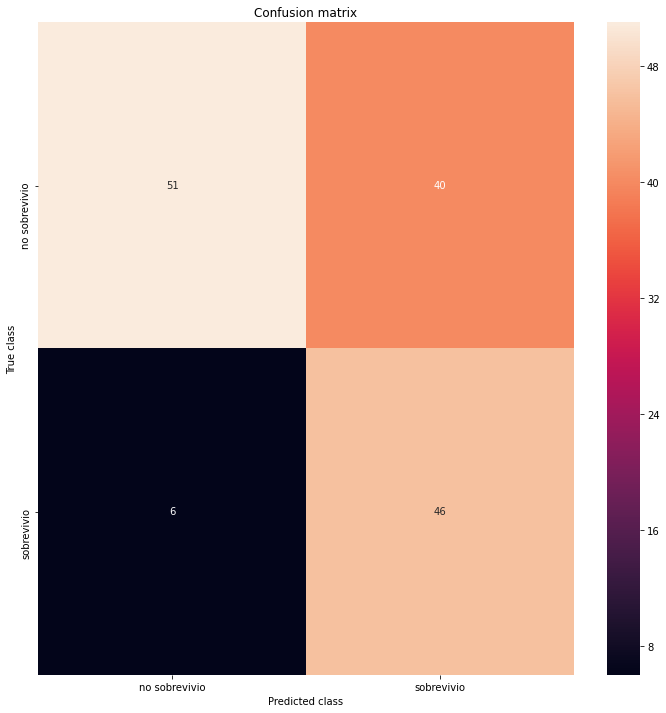

verdaderos positivos: 46
falsos positivos: 40
verdaderos negativos: 51
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.89      0.56      0.69        91
           1       0.53      0.88      0.67        52

    accuracy                           0.68       143
   macro avg       0.71      0.72      0.68       143
weighted avg       0.76      0.68      0.68       143

           metrics_train  metrics_test
Accuracy        0.657293      0.678322
Precision       0.537143      0.534884
Recall:         0.850679      0.884615
F1_Score:       0.658494      0.666667


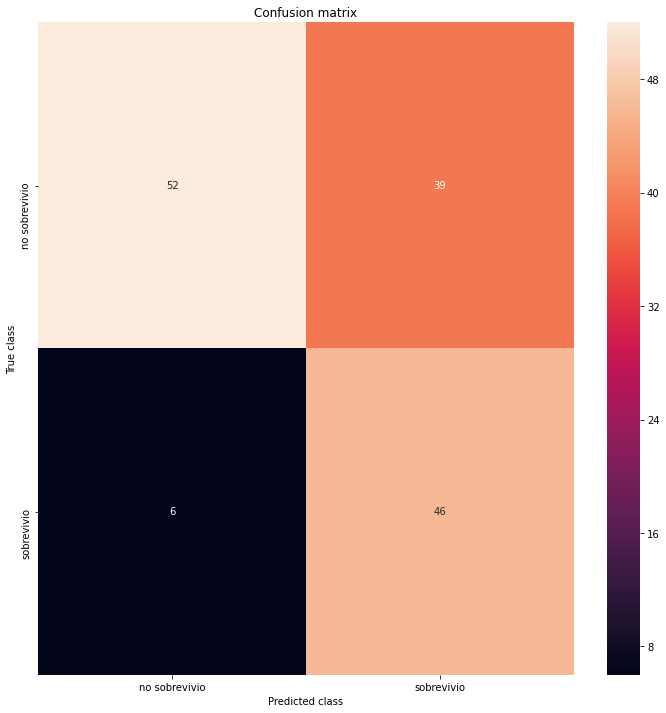

verdaderos positivos: 46
falsos positivos: 39
verdaderos negativos: 52
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.90      0.57      0.70        91
           1       0.54      0.88      0.67        52

    accuracy                           0.69       143
   macro avg       0.72      0.73      0.68       143
weighted avg       0.77      0.69      0.69       143

           metrics_train  metrics_test
Accuracy        0.660808      0.685315
Precision       0.540462      0.541176
Recall:         0.846154      0.884615
F1_Score:       0.659612      0.671533


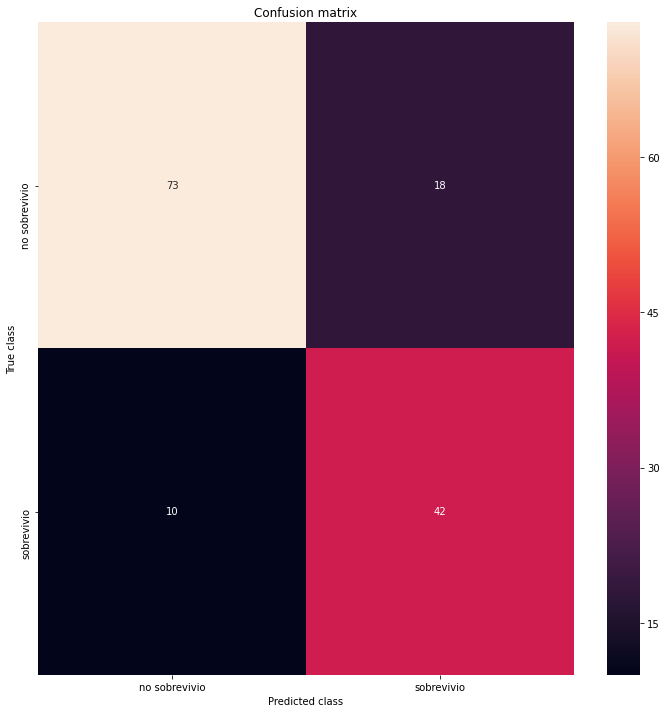

verdaderos positivos: 42
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        91
           1       0.70      0.81      0.75        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.764499      0.804196
Precision       0.677551      0.700000
Recall:         0.751131      0.807692
F1_Score:       0.712446      0.750000


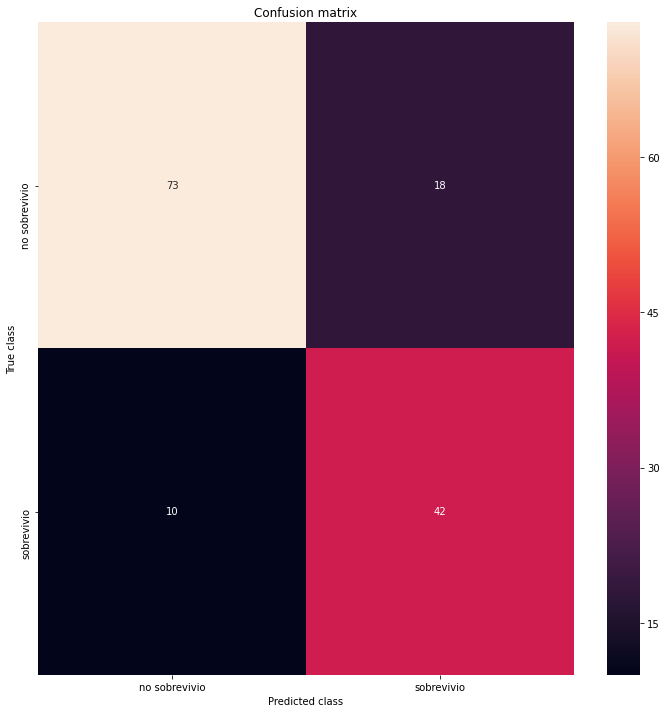

verdaderos positivos: 42
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        91
           1       0.70      0.81      0.75        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.764499      0.804196
Precision       0.677551      0.700000
Recall:         0.751131      0.807692
F1_Score:       0.712446      0.750000


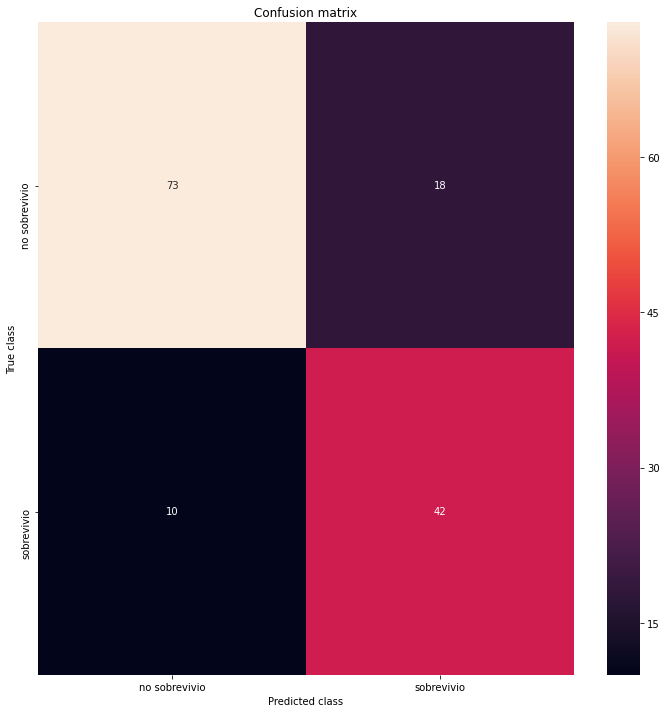

verdaderos positivos: 42
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        91
           1       0.70      0.81      0.75        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.768014      0.804196
Precision       0.684647      0.700000
Recall:         0.746606      0.807692
F1_Score:       0.714286      0.750000


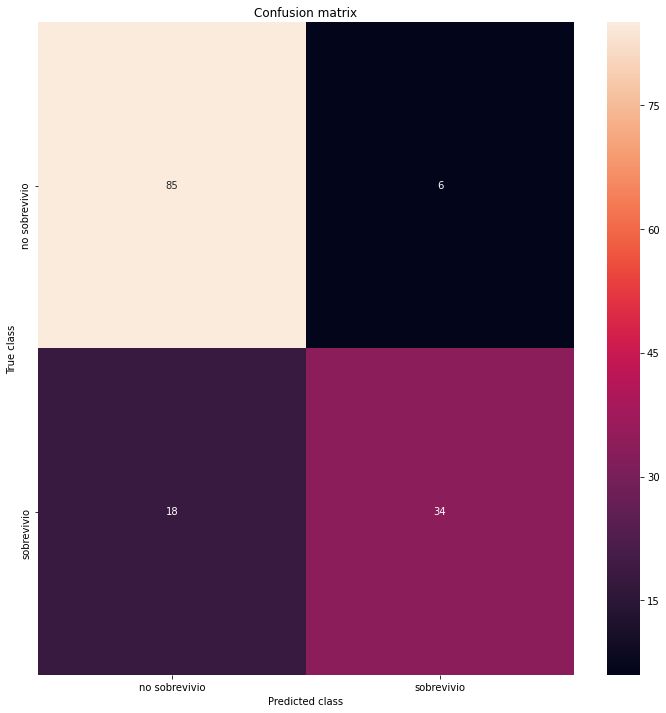

verdaderos positivos: 34
falsos positivos: 6
verdaderos negativos: 85
falsos negativos: 18
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        91
           1       0.85      0.65      0.74        52

    accuracy                           0.83       143
   macro avg       0.84      0.79      0.81       143
weighted avg       0.83      0.83      0.83       143

           metrics_train  metrics_test
Accuracy        0.796134      0.832168
Precision       0.814371      0.850000
Recall:         0.615385      0.653846
F1_Score:       0.701031      0.739130


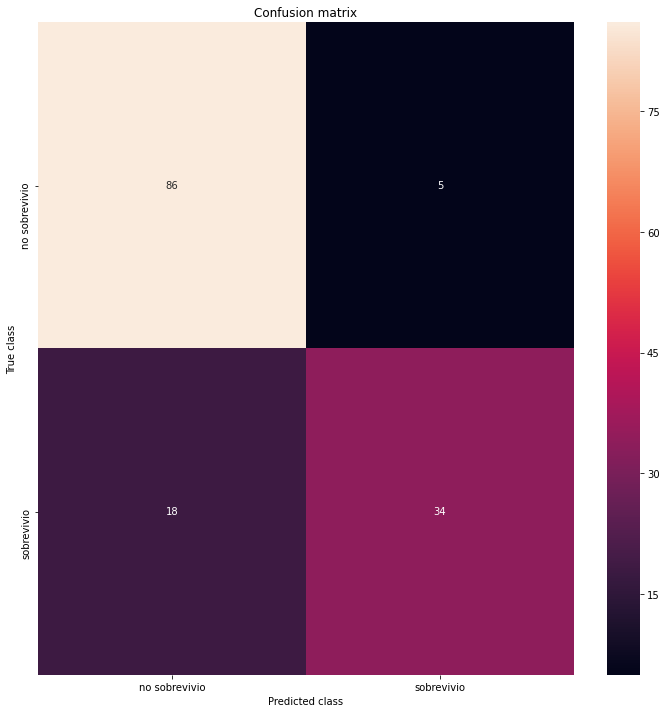

verdaderos positivos: 34
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 18
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        91
           1       0.87      0.65      0.75        52

    accuracy                           0.84       143
   macro avg       0.85      0.80      0.81       143
weighted avg       0.84      0.84      0.83       143

           metrics_train  metrics_test
Accuracy        0.796134      0.839161
Precision       0.830189      0.871795
Recall:         0.597285      0.653846
F1_Score:       0.694737      0.747253


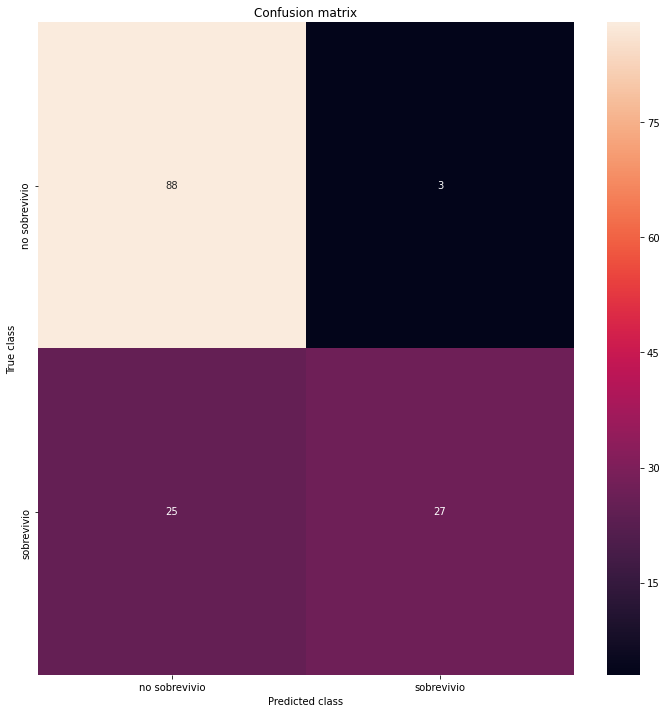

verdaderos positivos: 27
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.78      0.97      0.86        91
           1       0.90      0.52      0.66        52

    accuracy                           0.80       143
   macro avg       0.84      0.74      0.76       143
weighted avg       0.82      0.80      0.79       143

           metrics_train  metrics_test
Accuracy        0.787346      0.804196
Precision       0.938596      0.900000
Recall:         0.484163      0.519231
F1_Score:       0.638806      0.658537
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.792186
Training accuracy: 0.351%
loss at step 1000: 0.664063
Training accuracy: 0.567%
Test accuracy: 0.797%


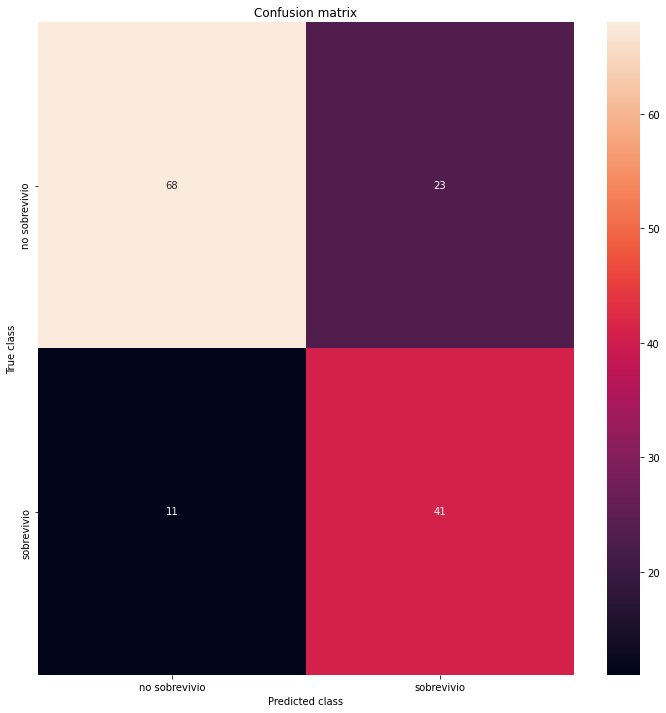

verdaderos positivos: 41
falsos positivos: 23
verdaderos negativos: 68
falsos negativos: 11
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        91
           1       0.64      0.79      0.71        52

    accuracy                           0.76       143
   macro avg       0.75      0.77      0.75       143
weighted avg       0.78      0.76      0.77       143

           metrics_train  metrics_test
Accuracy        0.745167      0.762238
Precision       0.652000      0.640625
Recall:         0.737557      0.788462
F1_Score:       0.692144      0.706897


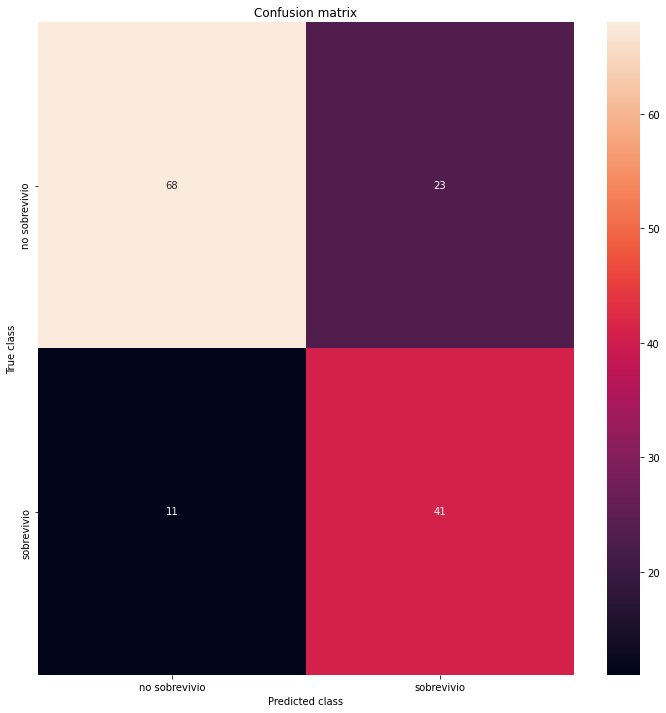

verdaderos positivos: 41
falsos positivos: 23
verdaderos negativos: 68
falsos negativos: 11
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        91
           1       0.64      0.79      0.71        52

    accuracy                           0.76       143
   macro avg       0.75      0.77      0.75       143
weighted avg       0.78      0.76      0.77       143

           metrics_train  metrics_test
Accuracy        0.743409      0.762238
Precision       0.650602      0.640625
Recall:         0.733032      0.788462
F1_Score:       0.689362      0.706897


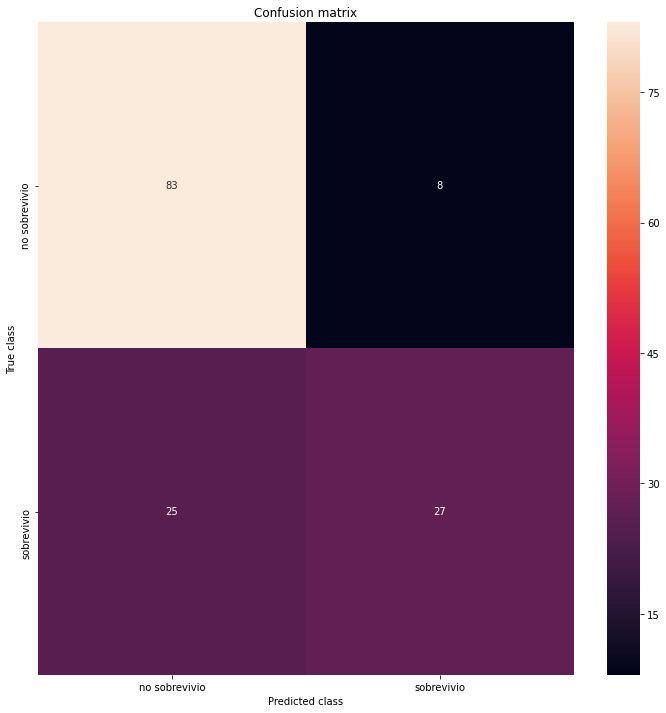

verdaderos positivos: 27
falsos positivos: 8
verdaderos negativos: 83
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        91
           1       0.77      0.52      0.62        52

    accuracy                           0.77       143
   macro avg       0.77      0.72      0.73       143
weighted avg       0.77      0.77      0.76       143

           metrics_train  metrics_test
Accuracy        0.776801      0.769231
Precision       0.817568      0.771429
Recall:         0.547511      0.519231
F1_Score:       0.655827      0.620690


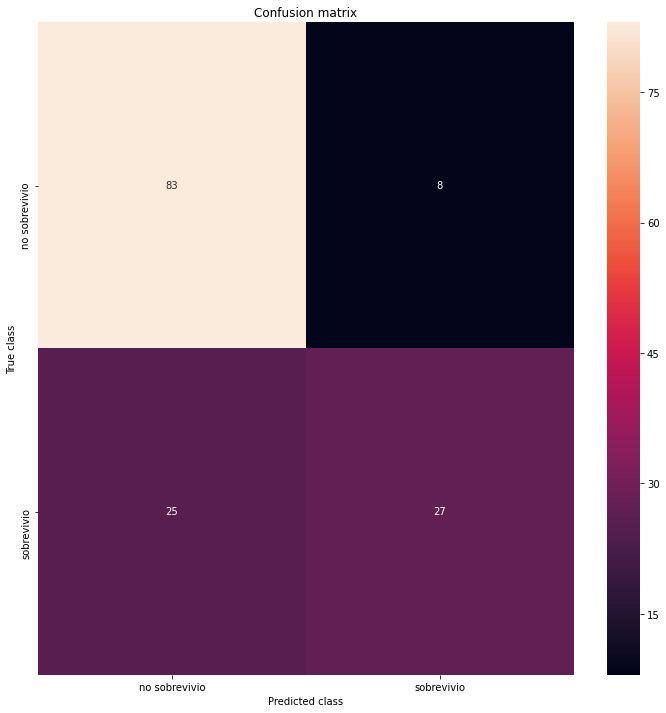

verdaderos positivos: 27
falsos positivos: 8
verdaderos negativos: 83
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        91
           1       0.77      0.52      0.62        52

    accuracy                           0.77       143
   macro avg       0.77      0.72      0.73       143
weighted avg       0.77      0.77      0.76       143

           metrics_train  metrics_test
Accuracy        0.776801      0.769231
Precision       0.817568      0.771429
Recall:         0.547511      0.519231
F1_Score:       0.655827      0.620690


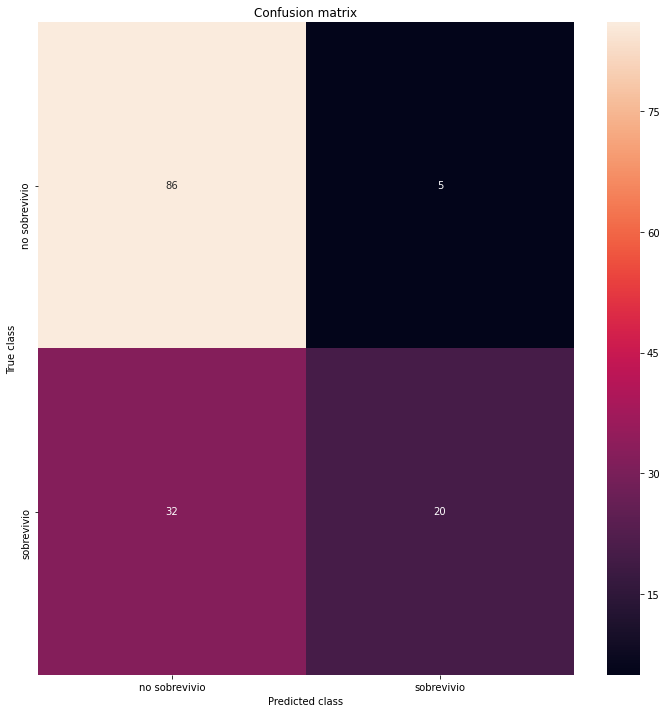

verdaderos positivos: 20
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 32
              precision    recall  f1-score   support

           0       0.73      0.95      0.82        91
           1       0.80      0.38      0.52        52

    accuracy                           0.74       143
   macro avg       0.76      0.66      0.67       143
weighted avg       0.75      0.74      0.71       143

           metrics_train  metrics_test
Accuracy        0.746924      0.741259
Precision       0.888889      0.800000
Recall:         0.398190      0.384615
F1_Score:       0.550000      0.519481


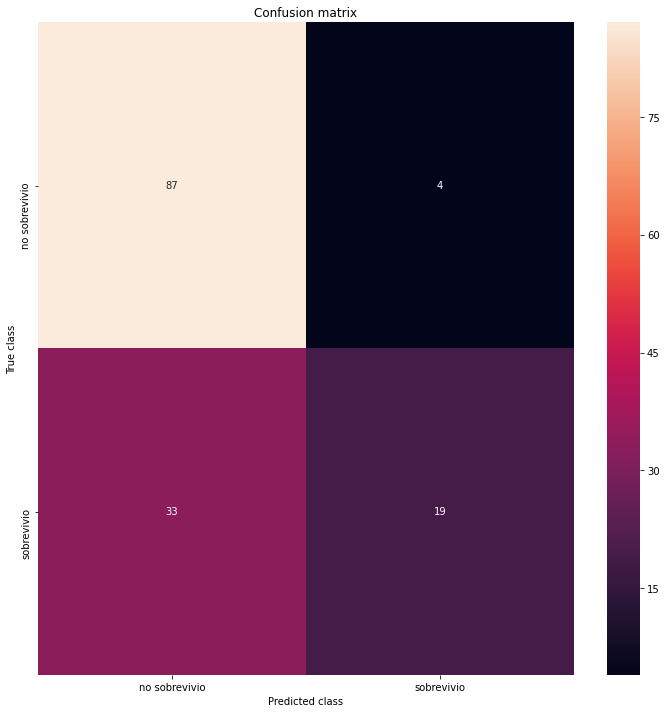

verdaderos positivos: 19
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 33
              precision    recall  f1-score   support

           0       0.72      0.96      0.82        91
           1       0.83      0.37      0.51        52

    accuracy                           0.74       143
   macro avg       0.78      0.66      0.67       143
weighted avg       0.76      0.74      0.71       143

           metrics_train  metrics_test
Accuracy        0.739895      0.741259
Precision       0.929412      0.826087
Recall:         0.357466      0.365385
F1_Score:       0.516340      0.506667


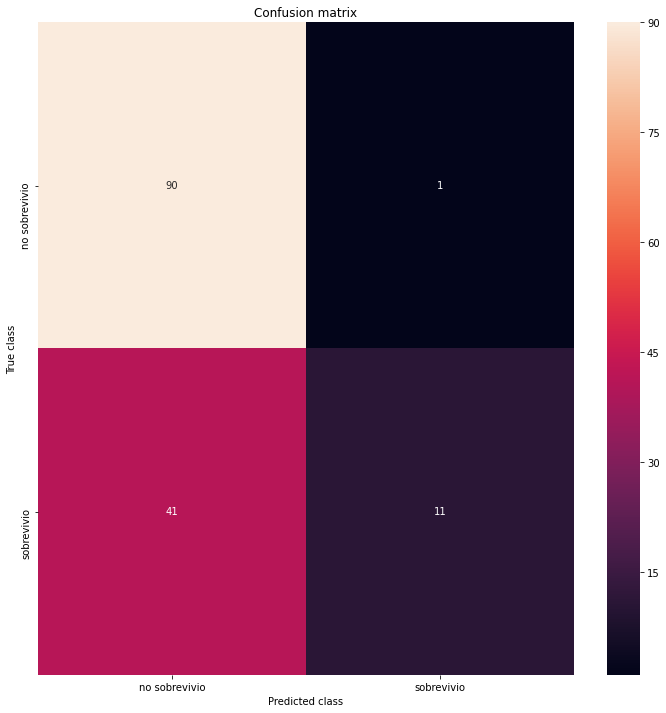

verdaderos positivos: 11
falsos positivos: 1
verdaderos negativos: 90
falsos negativos: 41
              precision    recall  f1-score   support

           0       0.69      0.99      0.81        91
           1       0.92      0.21      0.34        52

    accuracy                           0.71       143
   macro avg       0.80      0.60      0.58       143
weighted avg       0.77      0.71      0.64       143

           metrics_train  metrics_test
Accuracy        0.657293      0.706294
Precision       0.964286      0.916667
Recall:         0.122172      0.211538
F1_Score:       0.216867      0.343750


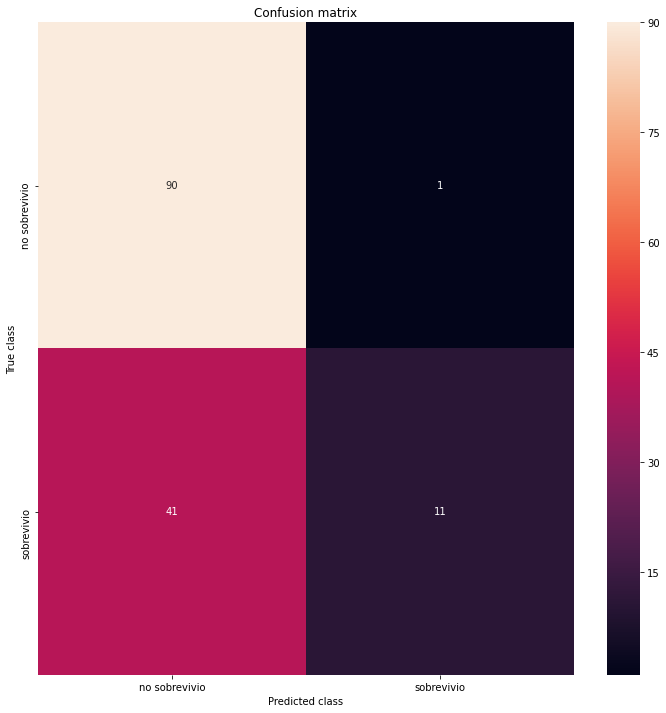

verdaderos positivos: 11
falsos positivos: 1
verdaderos negativos: 90
falsos negativos: 41
              precision    recall  f1-score   support

           0       0.69      0.99      0.81        91
           1       0.92      0.21      0.34        52

    accuracy                           0.71       143
   macro avg       0.80      0.60      0.58       143
weighted avg       0.77      0.71      0.64       143

           metrics_train  metrics_test
Accuracy        0.653779      0.706294
Precision       0.961538      0.916667
Recall:         0.113122      0.211538
F1_Score:       0.202429      0.343750
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.797248
Training accuracy: 0.438%
loss at step 1000: 0.548674
Training accuracy: 0.616%
Test accuracy: 0.846%


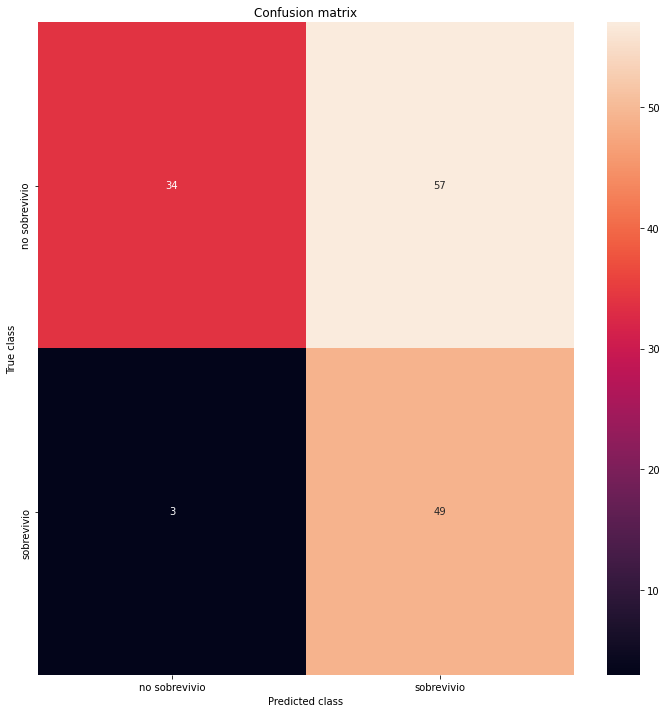

verdaderos positivos: 49
falsos positivos: 57
verdaderos negativos: 34
falsos negativos: 3
              precision    recall  f1-score   support

           0       0.92      0.37      0.53        91
           1       0.46      0.94      0.62        52

    accuracy                           0.58       143
   macro avg       0.69      0.66      0.58       143
weighted avg       0.75      0.58      0.56       143

           metrics_train  metrics_test
Accuracy        0.592267      0.580420
Precision       0.486683      0.462264
Recall:         0.909502      0.942308
F1_Score:       0.634069      0.620253


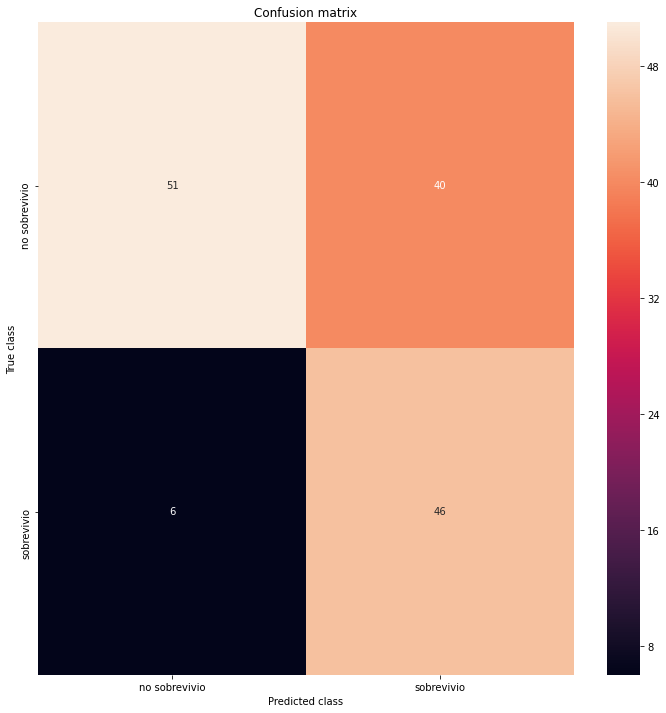

verdaderos positivos: 46
falsos positivos: 40
verdaderos negativos: 51
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.89      0.56      0.69        91
           1       0.53      0.88      0.67        52

    accuracy                           0.68       143
   macro avg       0.71      0.72      0.68       143
weighted avg       0.76      0.68      0.68       143

           metrics_train  metrics_test
Accuracy        0.657293      0.678322
Precision       0.537143      0.534884
Recall:         0.850679      0.884615
F1_Score:       0.658494      0.666667


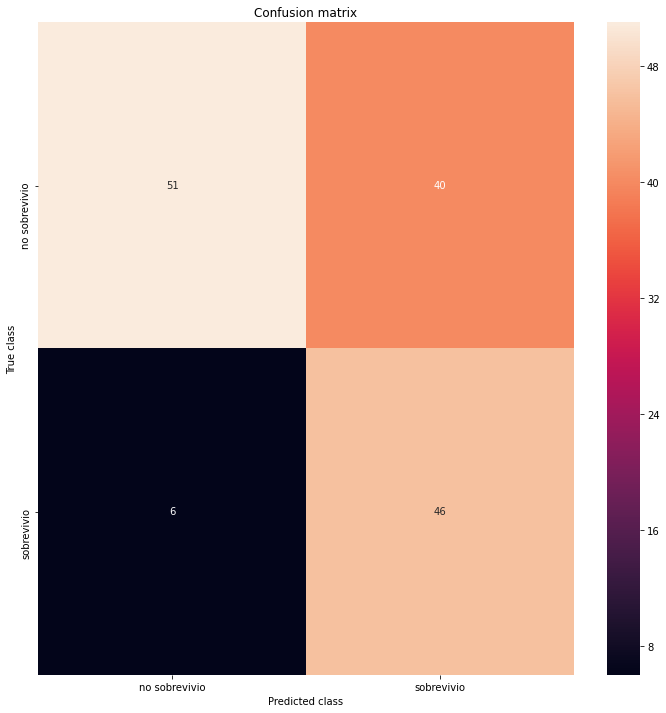

verdaderos positivos: 46
falsos positivos: 40
verdaderos negativos: 51
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.89      0.56      0.69        91
           1       0.53      0.88      0.67        52

    accuracy                           0.68       143
   macro avg       0.71      0.72      0.68       143
weighted avg       0.76      0.68      0.68       143

           metrics_train  metrics_test
Accuracy        0.659051      0.678322
Precision       0.538682      0.534884
Recall:         0.850679      0.884615
F1_Score:       0.659649      0.666667


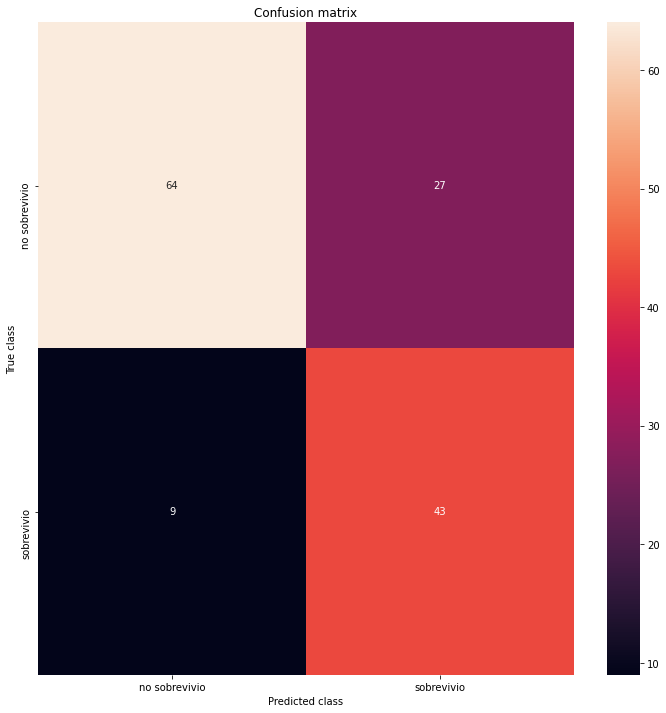

verdaderos positivos: 43
falsos positivos: 27
verdaderos negativos: 64
falsos negativos: 9
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        91
           1       0.61      0.83      0.70        52

    accuracy                           0.75       143
   macro avg       0.75      0.77      0.74       143
weighted avg       0.78      0.75      0.75       143

           metrics_train  metrics_test
Accuracy        0.743409      0.748252
Precision       0.640449      0.614286
Recall:         0.773756      0.826923
F1_Score:       0.700820      0.704918


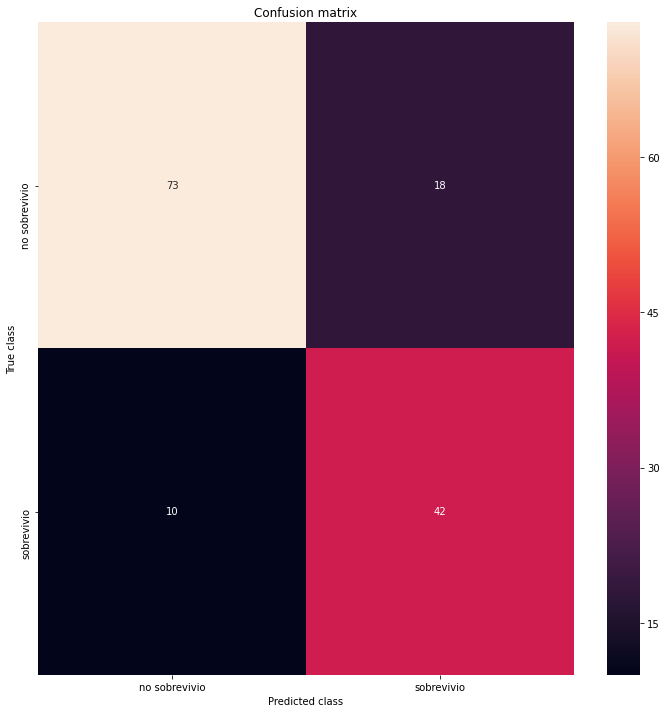

verdaderos positivos: 42
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        91
           1       0.70      0.81      0.75        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.764499      0.804196
Precision       0.677551      0.700000
Recall:         0.751131      0.807692
F1_Score:       0.712446      0.750000


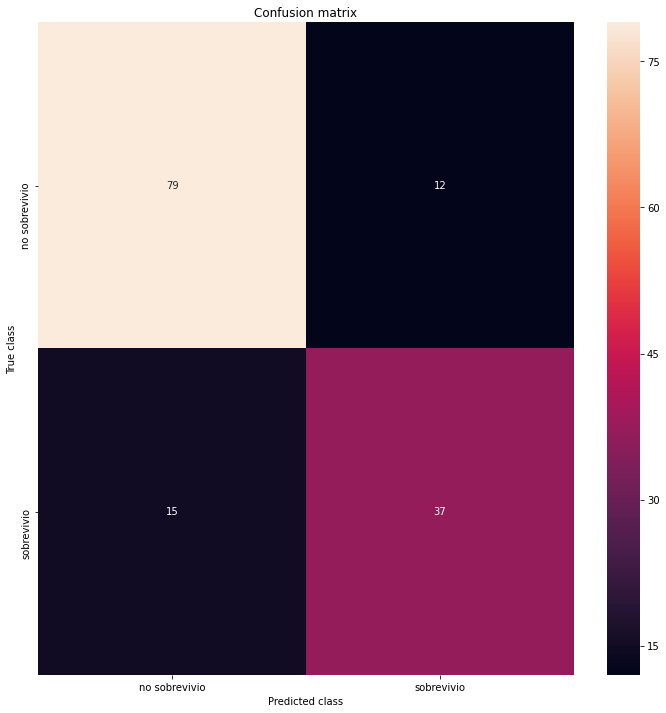

verdaderos positivos: 37
falsos positivos: 12
verdaderos negativos: 79
falsos negativos: 15
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        91
           1       0.76      0.71      0.73        52

    accuracy                           0.81       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.81      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.771529      0.811189
Precision       0.724138      0.755102
Recall:         0.665158      0.711538
F1_Score:       0.693396      0.732673


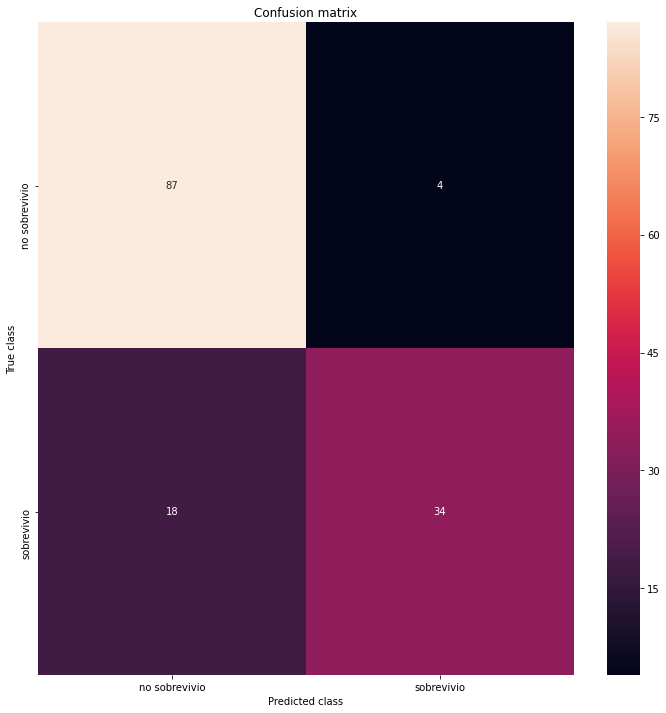

verdaderos positivos: 34
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 18
              precision    recall  f1-score   support

           0       0.83      0.96      0.89        91
           1       0.89      0.65      0.76        52

    accuracy                           0.85       143
   macro avg       0.86      0.80      0.82       143
weighted avg       0.85      0.85      0.84       143

           metrics_train  metrics_test
Accuracy        0.794376      0.846154
Precision       0.833333      0.894737
Recall:         0.588235      0.653846
F1_Score:       0.689655      0.755556


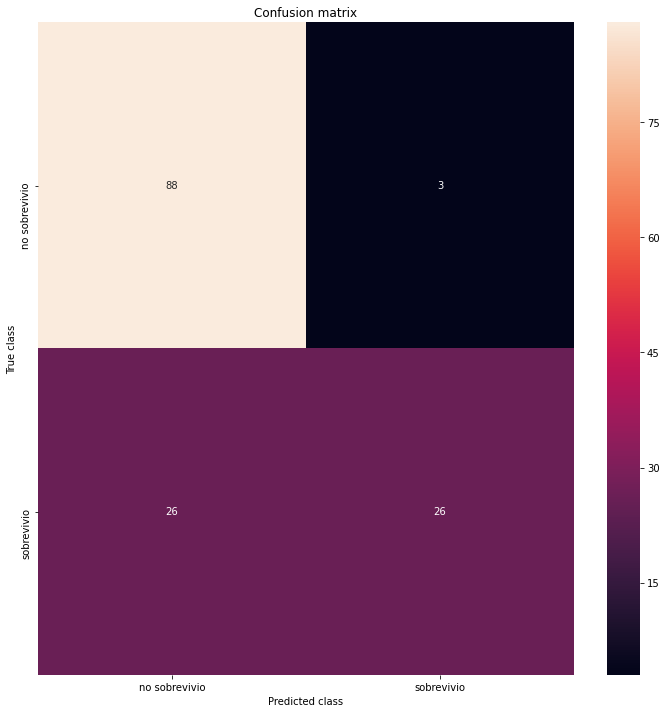

verdaderos positivos: 26
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 26
              precision    recall  f1-score   support

           0       0.77      0.97      0.86        91
           1       0.90      0.50      0.64        52

    accuracy                           0.80       143
   macro avg       0.83      0.73      0.75       143
weighted avg       0.82      0.80      0.78       143

           metrics_train  metrics_test
Accuracy        0.782074      0.797203
Precision       0.936937      0.896552
Recall:         0.470588      0.500000
F1_Score:       0.626506      0.641975
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.805340
Training accuracy: 0.351%
loss at step 1000: 0.675389
Training accuracy: 0.550%
Test accuracy: 0.755%


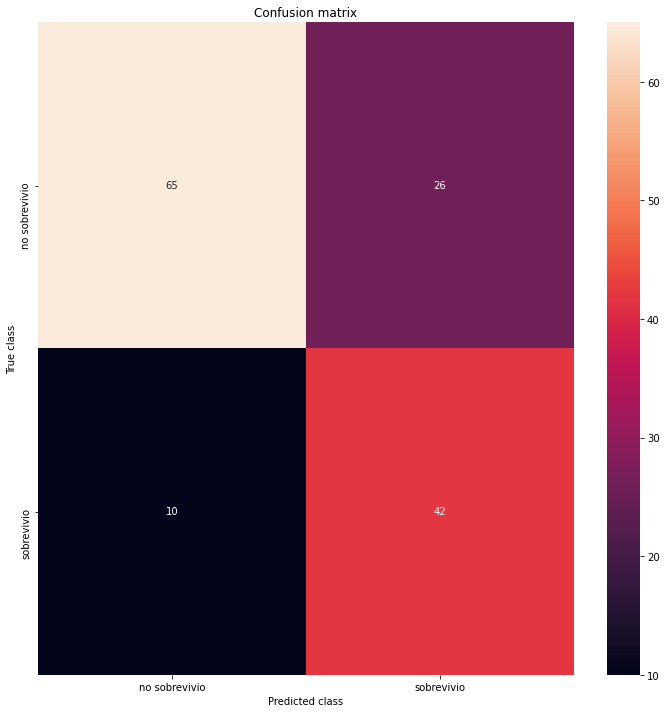

verdaderos positivos: 42
falsos positivos: 26
verdaderos negativos: 65
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.87      0.71      0.78        91
           1       0.62      0.81      0.70        52

    accuracy                           0.75       143
   macro avg       0.74      0.76      0.74       143
weighted avg       0.78      0.75      0.75       143

           metrics_train  metrics_test
Accuracy        0.732865      0.748252
Precision       0.632184      0.617647
Recall:         0.746606      0.807692
F1_Score:       0.684647      0.700000


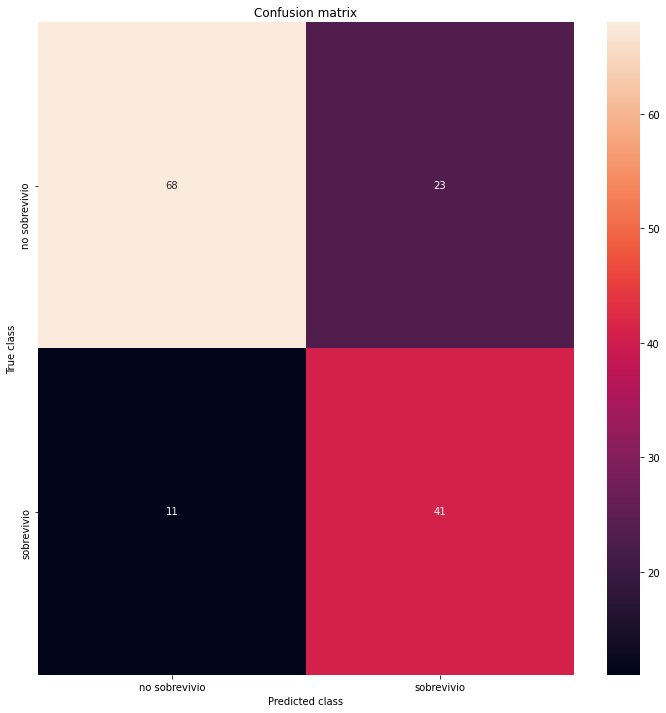

verdaderos positivos: 41
falsos positivos: 23
verdaderos negativos: 68
falsos negativos: 11
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        91
           1       0.64      0.79      0.71        52

    accuracy                           0.76       143
   macro avg       0.75      0.77      0.75       143
weighted avg       0.78      0.76      0.77       143

           metrics_train  metrics_test
Accuracy        0.743409      0.762238
Precision       0.650602      0.640625
Recall:         0.733032      0.788462
F1_Score:       0.689362      0.706897


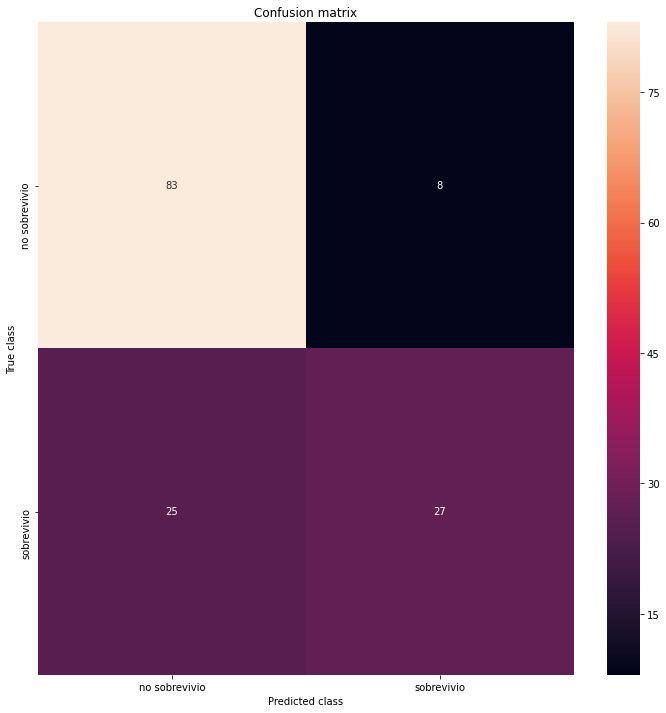

verdaderos positivos: 27
falsos positivos: 8
verdaderos negativos: 83
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        91
           1       0.77      0.52      0.62        52

    accuracy                           0.77       143
   macro avg       0.77      0.72      0.73       143
weighted avg       0.77      0.77      0.76       143

           metrics_train  metrics_test
Accuracy        0.775044      0.769231
Precision       0.812081      0.771429
Recall:         0.547511      0.519231
F1_Score:       0.654054      0.620690


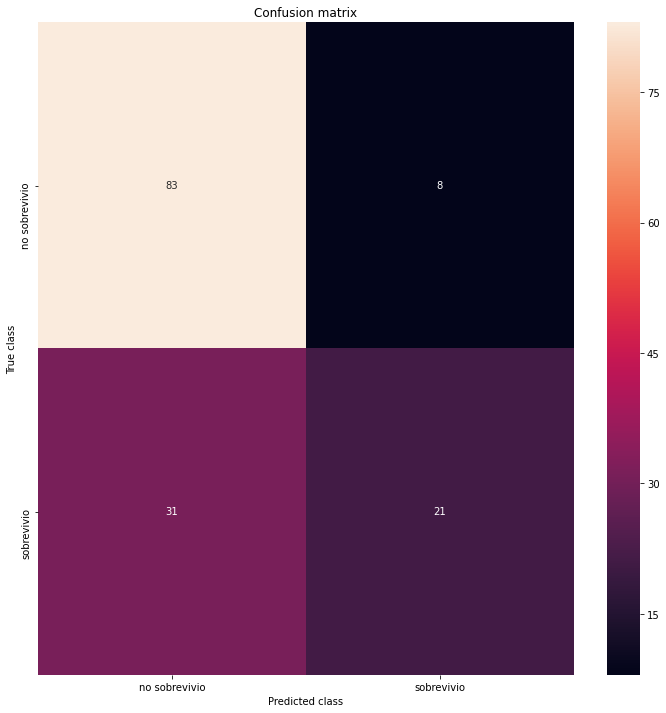

verdaderos positivos: 21
falsos positivos: 8
verdaderos negativos: 83
falsos negativos: 31
              precision    recall  f1-score   support

           0       0.73      0.91      0.81        91
           1       0.72      0.40      0.52        52

    accuracy                           0.73       143
   macro avg       0.73      0.66      0.66       143
weighted avg       0.73      0.73      0.70       143

           metrics_train  metrics_test
Accuracy        0.743409      0.727273
Precision       0.804878      0.724138
Recall:         0.447964      0.403846
F1_Score:       0.575581      0.518519


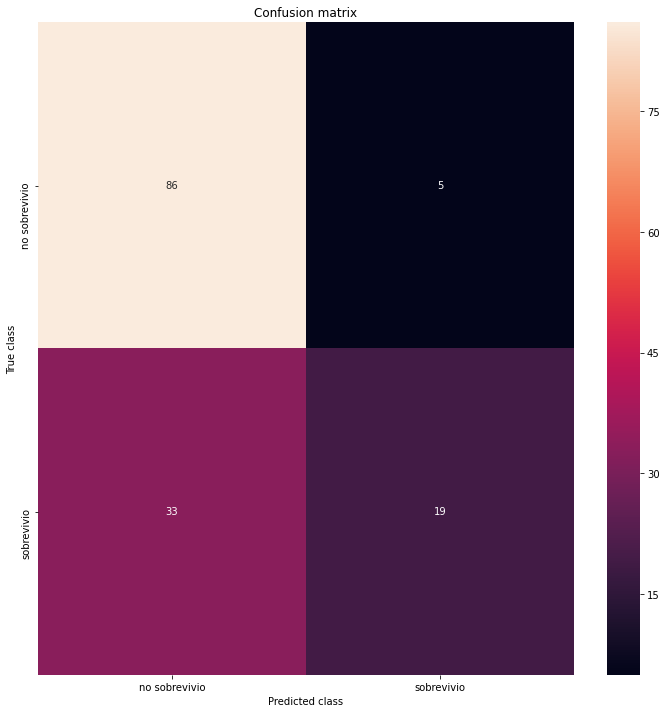

verdaderos positivos: 19
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 33
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        91
           1       0.79      0.37      0.50        52

    accuracy                           0.73       143
   macro avg       0.76      0.66      0.66       143
weighted avg       0.75      0.73      0.70       143

           metrics_train  metrics_test
Accuracy        0.743409      0.734266
Precision       0.903226      0.791667
Recall:         0.380090      0.365385
F1_Score:       0.535032      0.500000


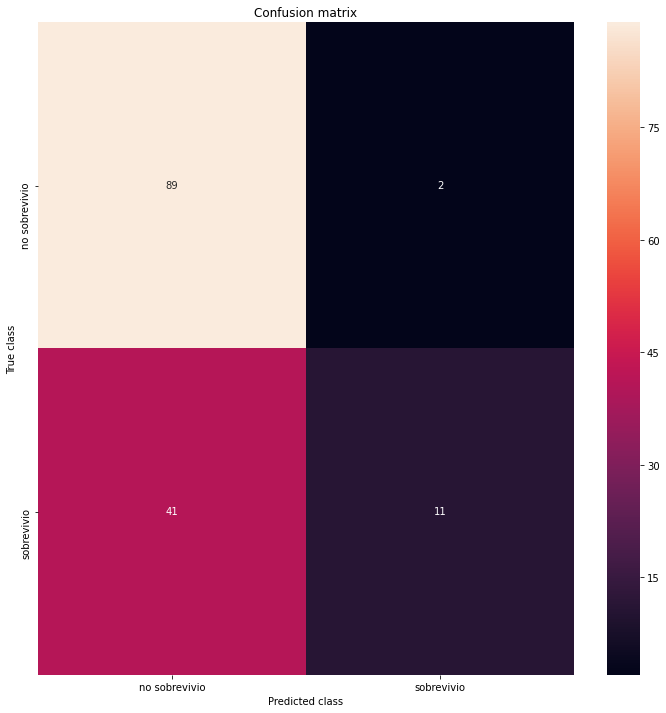

verdaderos positivos: 11
falsos positivos: 2
verdaderos negativos: 89
falsos negativos: 41
              precision    recall  f1-score   support

           0       0.68      0.98      0.81        91
           1       0.85      0.21      0.34        52

    accuracy                           0.70       143
   macro avg       0.77      0.59      0.57       143
weighted avg       0.74      0.70      0.64       143

           metrics_train  metrics_test
Accuracy        0.653779      0.699301
Precision       0.852941      0.846154
Recall:         0.131222      0.211538
F1_Score:       0.227451      0.338462


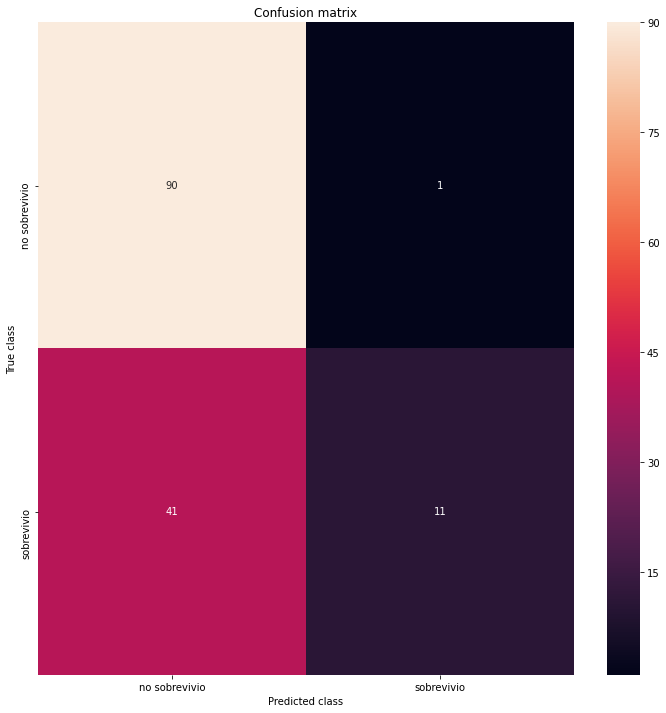

verdaderos positivos: 11
falsos positivos: 1
verdaderos negativos: 90
falsos negativos: 41
              precision    recall  f1-score   support

           0       0.69      0.99      0.81        91
           1       0.92      0.21      0.34        52

    accuracy                           0.71       143
   macro avg       0.80      0.60      0.58       143
weighted avg       0.77      0.71      0.64       143

           metrics_train  metrics_test
Accuracy        0.653779      0.706294
Precision       0.961538      0.916667
Recall:         0.113122      0.211538
F1_Score:       0.202429      0.343750


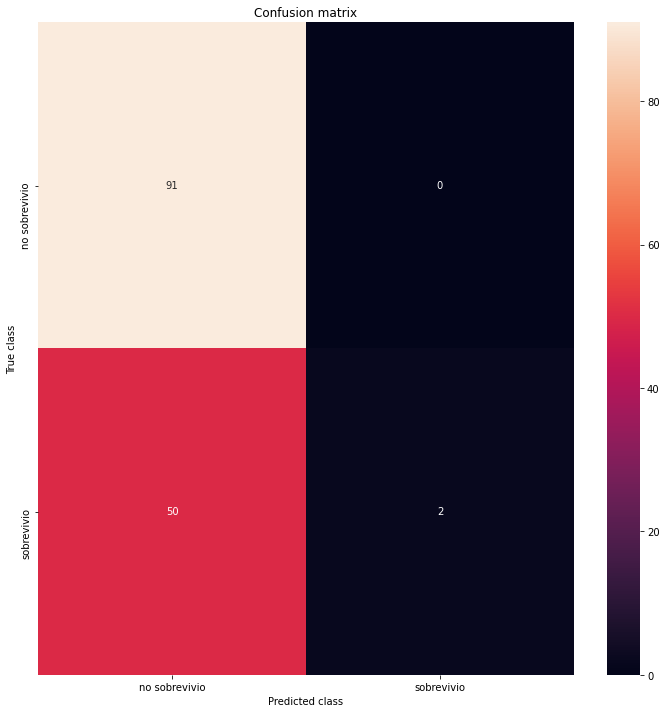

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.798681
Training accuracy: 0.482%
loss at step 1000: 0.562510
Training accuracy: 0.629%
Test accuracy: 0.818%


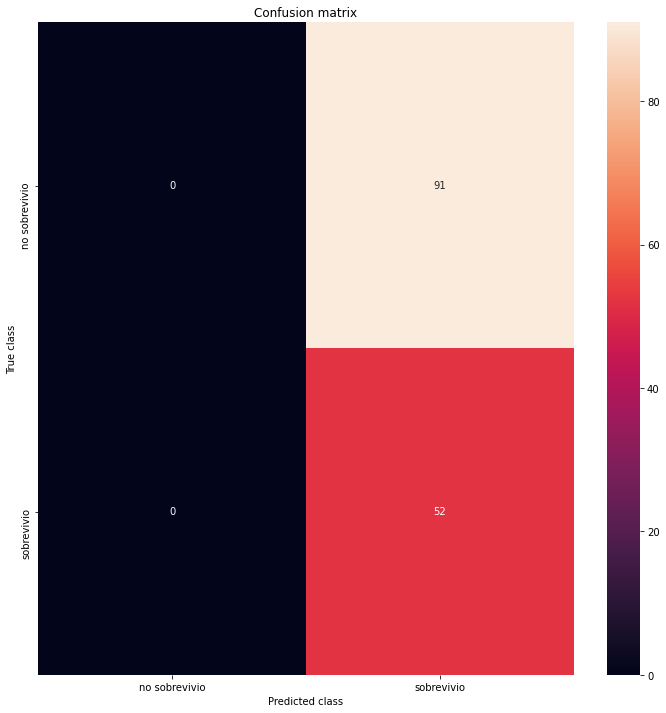

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


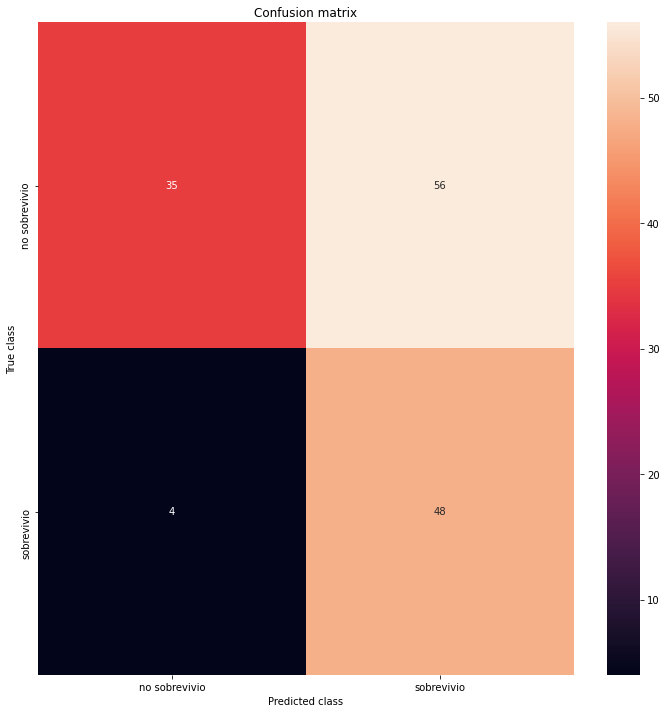

verdaderos positivos: 48
falsos positivos: 56
verdaderos negativos: 35
falsos negativos: 4
              precision    recall  f1-score   support

           0       0.90      0.38      0.54        91
           1       0.46      0.92      0.62        52

    accuracy                           0.58       143
   macro avg       0.68      0.65      0.58       143
weighted avg       0.74      0.58      0.57       143

           metrics_train  metrics_test
Accuracy        0.595782      0.580420
Precision       0.489051      0.461538
Recall:         0.909502      0.923077
F1_Score:       0.636076      0.615385


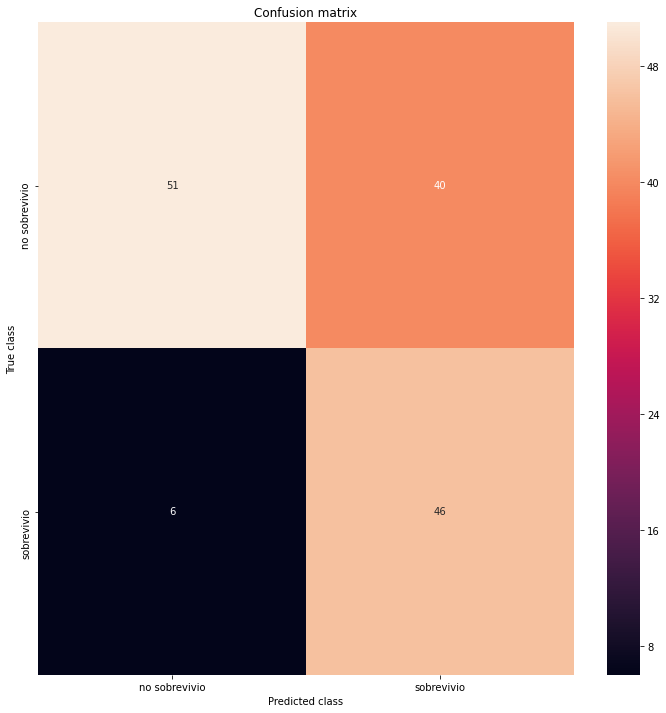

verdaderos positivos: 46
falsos positivos: 40
verdaderos negativos: 51
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.89      0.56      0.69        91
           1       0.53      0.88      0.67        52

    accuracy                           0.68       143
   macro avg       0.71      0.72      0.68       143
weighted avg       0.76      0.68      0.68       143

           metrics_train  metrics_test
Accuracy        0.657293      0.678322
Precision       0.537143      0.534884
Recall:         0.850679      0.884615
F1_Score:       0.658494      0.666667


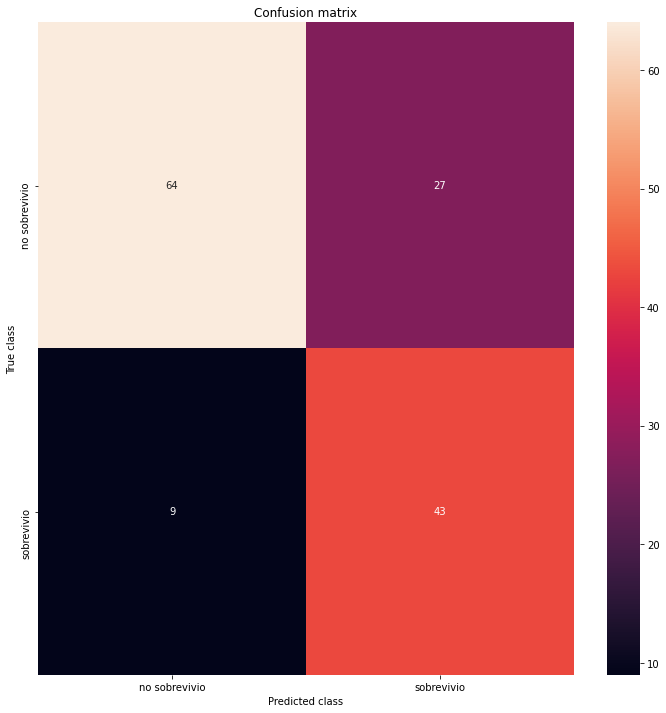

verdaderos positivos: 43
falsos positivos: 27
verdaderos negativos: 64
falsos negativos: 9
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        91
           1       0.61      0.83      0.70        52

    accuracy                           0.75       143
   macro avg       0.75      0.77      0.74       143
weighted avg       0.78      0.75      0.75       143

           metrics_train  metrics_test
Accuracy        0.743409      0.748252
Precision       0.640449      0.614286
Recall:         0.773756      0.826923
F1_Score:       0.700820      0.704918


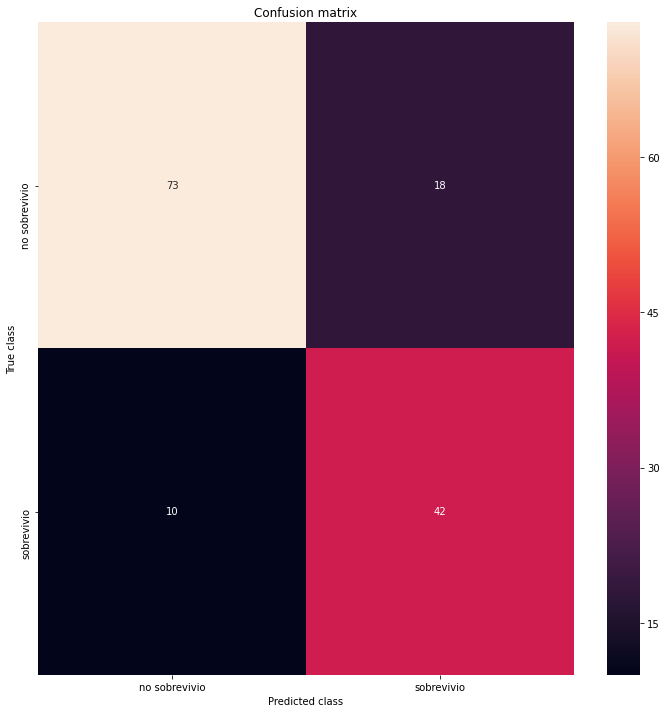

verdaderos positivos: 42
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        91
           1       0.70      0.81      0.75        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.764499      0.804196
Precision       0.677551      0.700000
Recall:         0.751131      0.807692
F1_Score:       0.712446      0.750000


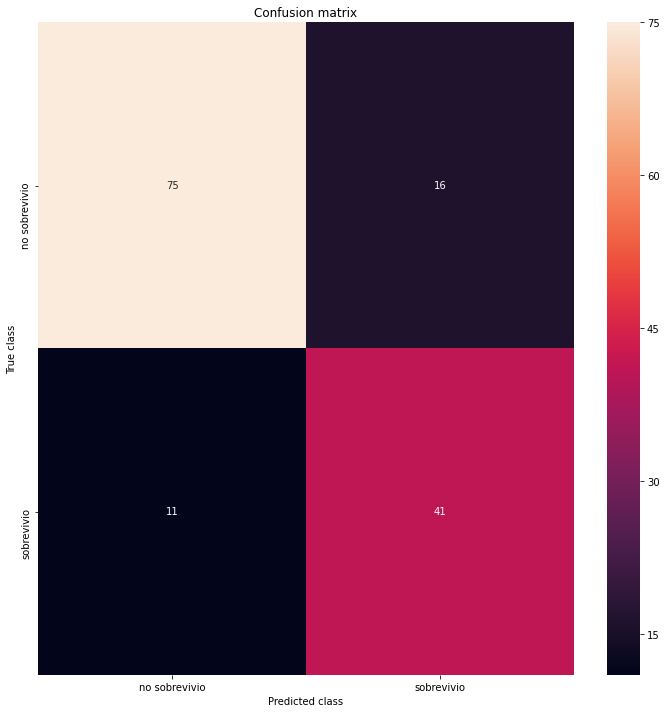

verdaderos positivos: 41
falsos positivos: 16
verdaderos negativos: 75
falsos negativos: 11
              precision    recall  f1-score   support

           0       0.87      0.82      0.85        91
           1       0.72      0.79      0.75        52

    accuracy                           0.81       143
   macro avg       0.80      0.81      0.80       143
weighted avg       0.82      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.782074      0.811189
Precision       0.713656      0.719298
Recall:         0.733032      0.788462
F1_Score:       0.723214      0.752294


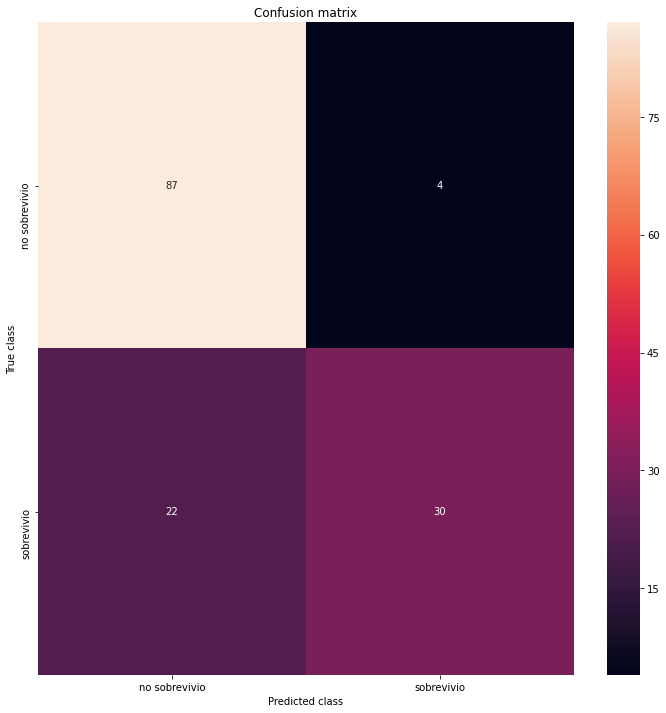

verdaderos positivos: 30
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 22
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        91
           1       0.88      0.58      0.70        52

    accuracy                           0.82       143
   macro avg       0.84      0.77      0.78       143
weighted avg       0.83      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.776801      0.818182
Precision       0.840580      0.882353
Recall:         0.524887      0.576923
F1_Score:       0.646240      0.697674


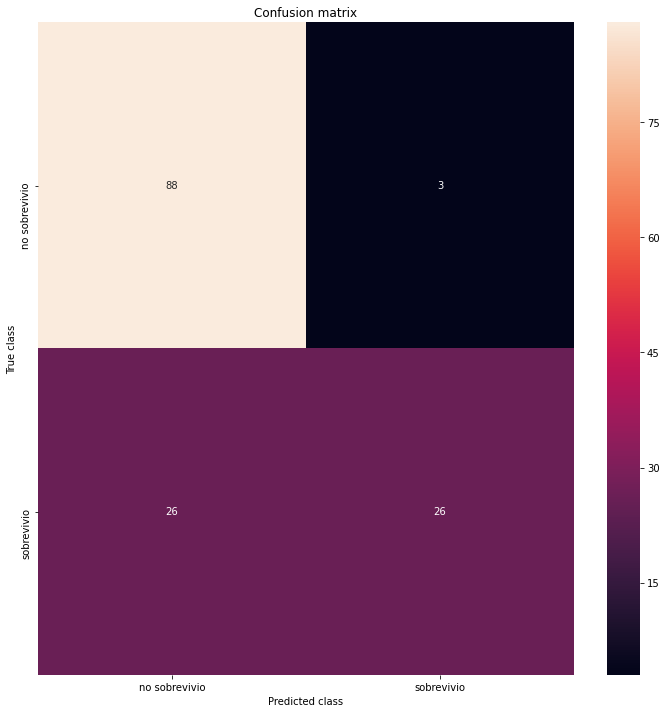

verdaderos positivos: 26
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 26
              precision    recall  f1-score   support

           0       0.77      0.97      0.86        91
           1       0.90      0.50      0.64        52

    accuracy                           0.80       143
   macro avg       0.83      0.73      0.75       143
weighted avg       0.82      0.80      0.78       143

           metrics_train  metrics_test
Accuracy        0.782074      0.797203
Precision       0.936937      0.896552
Recall:         0.470588      0.500000
F1_Score:       0.626506      0.641975
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.808291
Training accuracy: 0.351%
loss at step 1000: 0.677352
Training accuracy: 0.547%
Test accuracy: 0.748%


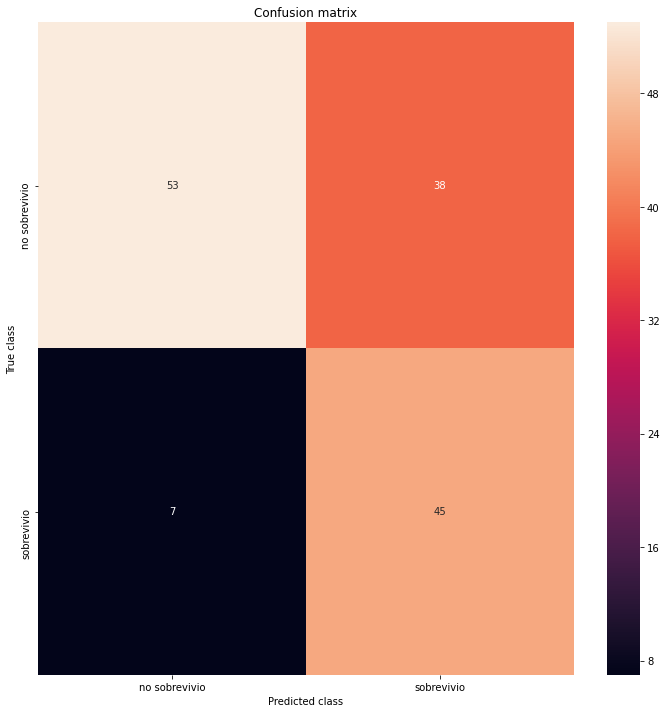

verdaderos positivos: 45
falsos positivos: 38
verdaderos negativos: 53
falsos negativos: 7
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        91
           1       0.54      0.87      0.67        52

    accuracy                           0.69       143
   macro avg       0.71      0.72      0.68       143
weighted avg       0.76      0.69      0.69       143

           metrics_train  metrics_test
Accuracy        0.650264      0.685315
Precision       0.532353      0.542169
Recall:         0.819005      0.865385
F1_Score:       0.645276      0.666667


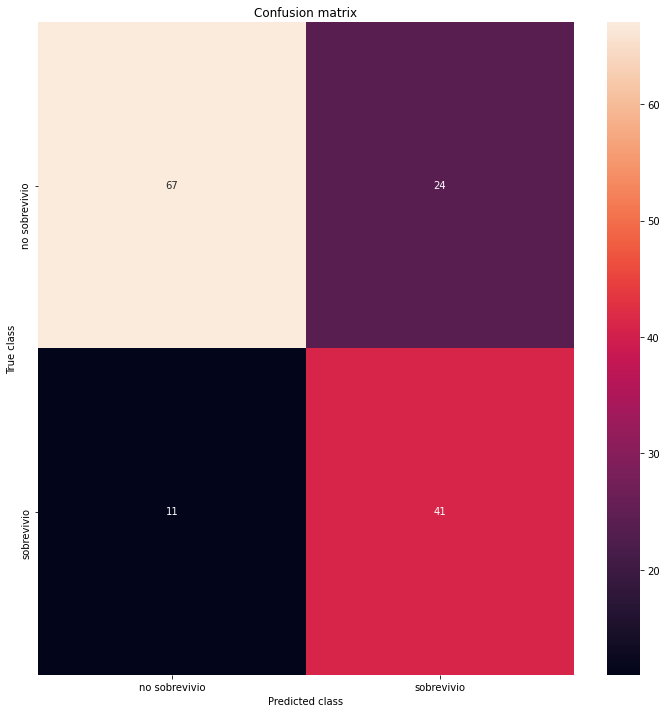

verdaderos positivos: 41
falsos positivos: 24
verdaderos negativos: 67
falsos negativos: 11
              precision    recall  f1-score   support

           0       0.86      0.74      0.79        91
           1       0.63      0.79      0.70        52

    accuracy                           0.76       143
   macro avg       0.74      0.76      0.75       143
weighted avg       0.78      0.76      0.76       143

           metrics_train  metrics_test
Accuracy        0.741652      0.755245
Precision       0.646825      0.630769
Recall:         0.737557      0.788462
F1_Score:       0.689218      0.700855


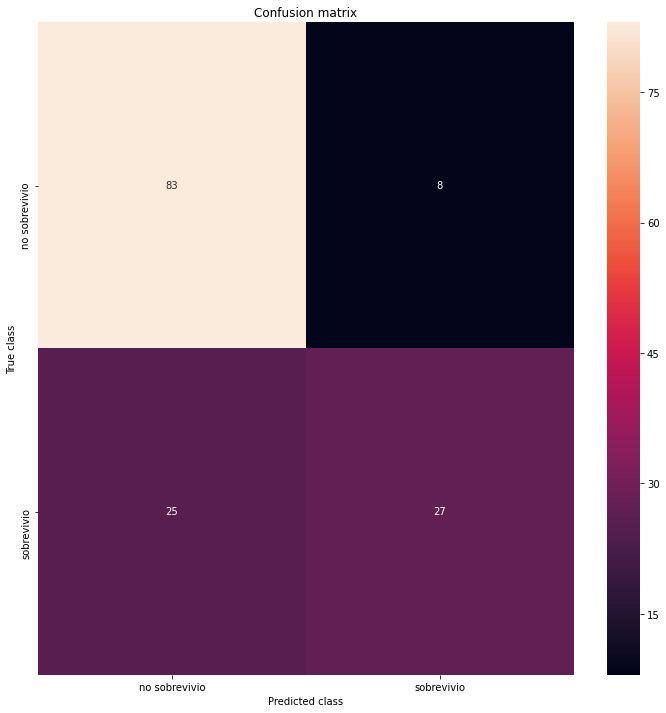

verdaderos positivos: 27
falsos positivos: 8
verdaderos negativos: 83
falsos negativos: 25
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        91
           1       0.77      0.52      0.62        52

    accuracy                           0.77       143
   macro avg       0.77      0.72      0.73       143
weighted avg       0.77      0.77      0.76       143

           metrics_train  metrics_test
Accuracy        0.775044      0.769231
Precision       0.812081      0.771429
Recall:         0.547511      0.519231
F1_Score:       0.654054      0.620690


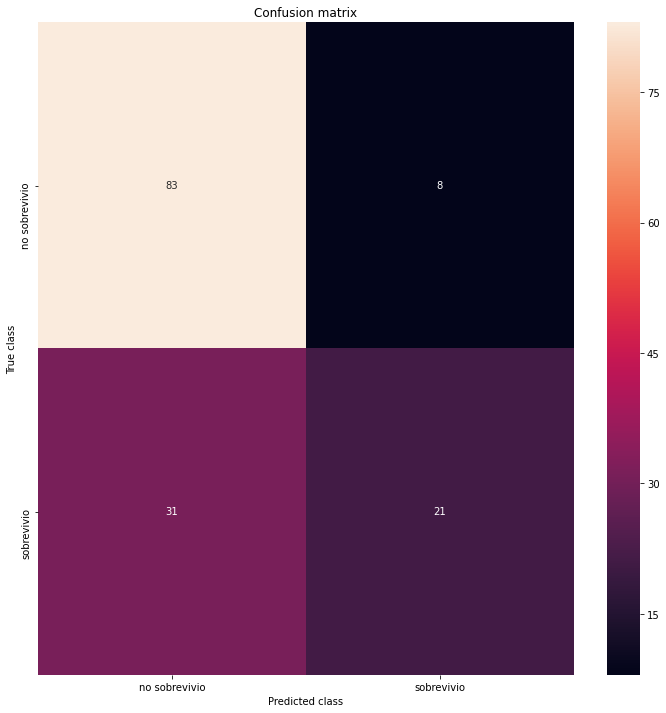

verdaderos positivos: 21
falsos positivos: 8
verdaderos negativos: 83
falsos negativos: 31
              precision    recall  f1-score   support

           0       0.73      0.91      0.81        91
           1       0.72      0.40      0.52        52

    accuracy                           0.73       143
   macro avg       0.73      0.66      0.66       143
weighted avg       0.73      0.73      0.70       143

           metrics_train  metrics_test
Accuracy        0.743409      0.727273
Precision       0.804878      0.724138
Recall:         0.447964      0.403846
F1_Score:       0.575581      0.518519


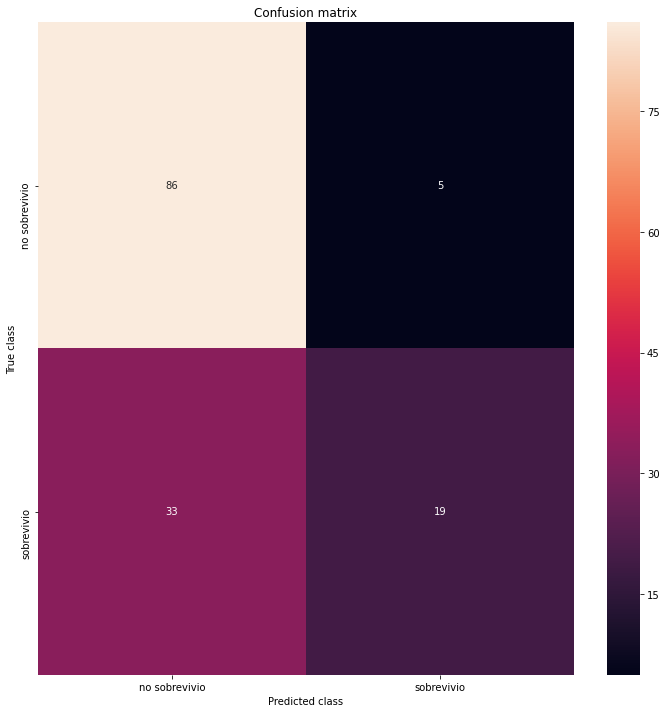

verdaderos positivos: 19
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 33
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        91
           1       0.79      0.37      0.50        52

    accuracy                           0.73       143
   macro avg       0.76      0.66      0.66       143
weighted avg       0.75      0.73      0.70       143

           metrics_train  metrics_test
Accuracy        0.743409      0.734266
Precision       0.903226      0.791667
Recall:         0.380090      0.365385
F1_Score:       0.535032      0.500000


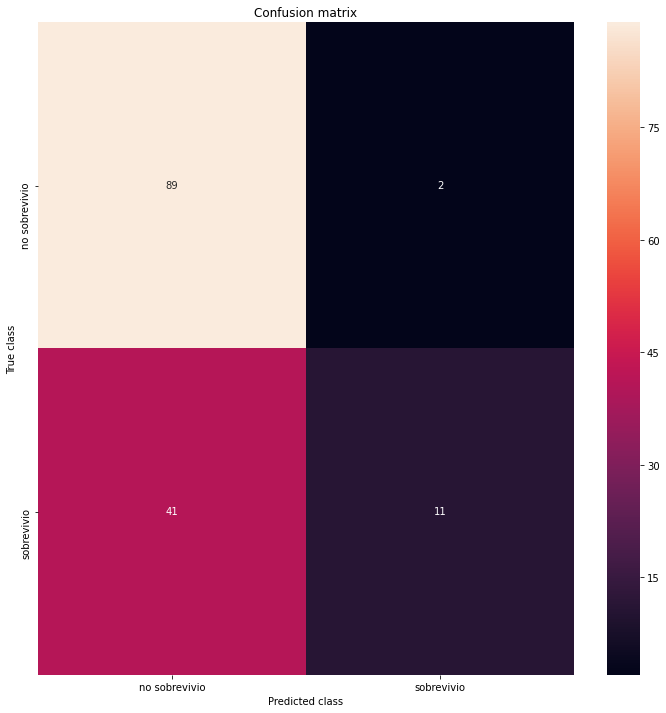

verdaderos positivos: 11
falsos positivos: 2
verdaderos negativos: 89
falsos negativos: 41
              precision    recall  f1-score   support

           0       0.68      0.98      0.81        91
           1       0.85      0.21      0.34        52

    accuracy                           0.70       143
   macro avg       0.77      0.59      0.57       143
weighted avg       0.74      0.70      0.64       143

           metrics_train  metrics_test
Accuracy        0.650264      0.699301
Precision       0.843750      0.846154
Recall:         0.122172      0.211538
F1_Score:       0.213439      0.338462


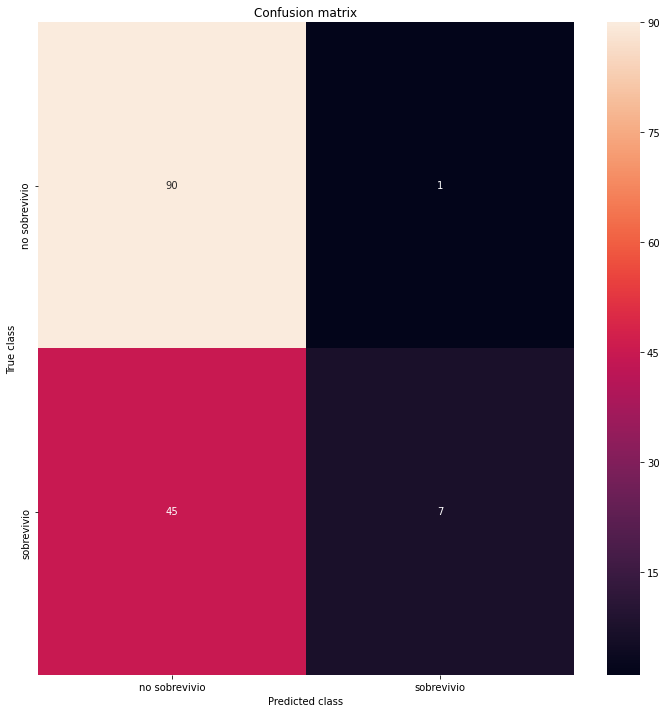

verdaderos positivos: 7
falsos positivos: 1
verdaderos negativos: 90
falsos negativos: 45
              precision    recall  f1-score   support

           0       0.67      0.99      0.80        91
           1       0.88      0.13      0.23        52

    accuracy                           0.68       143
   macro avg       0.77      0.56      0.51       143
weighted avg       0.74      0.68      0.59       143

           metrics_train  metrics_test
Accuracy        0.637961      0.678322
Precision       0.941176      0.875000
Recall:         0.072398      0.134615
F1_Score:       0.134454      0.233333


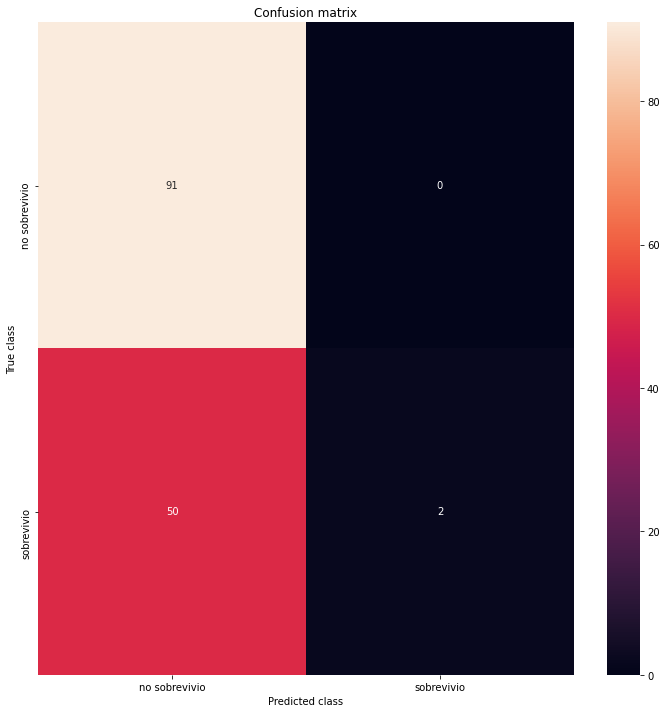

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.798730
Training accuracy: 0.482%
loss at step 1000: 0.565277
Training accuracy: 0.629%
Test accuracy: 0.818%


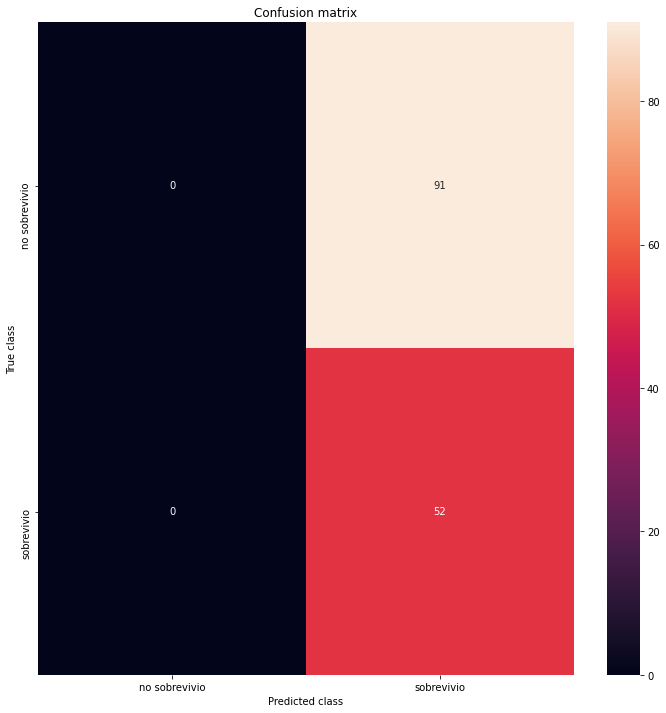

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


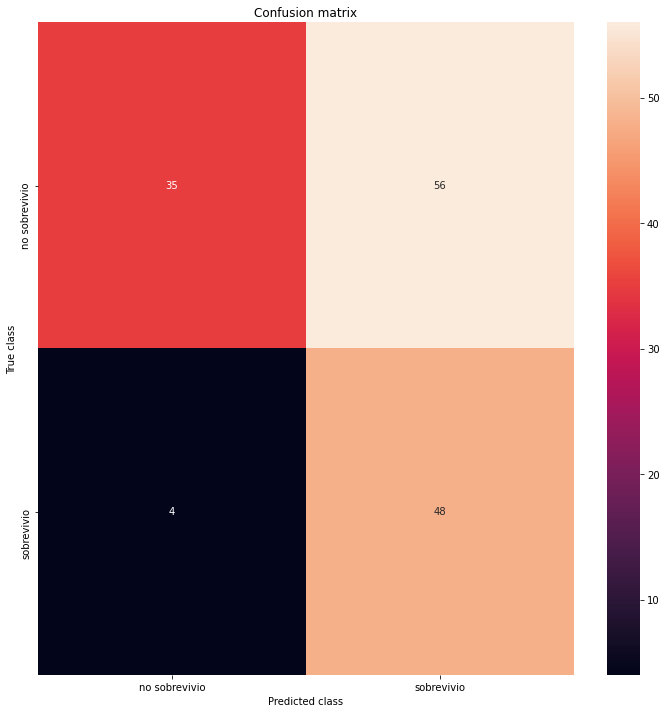

verdaderos positivos: 48
falsos positivos: 56
verdaderos negativos: 35
falsos negativos: 4
              precision    recall  f1-score   support

           0       0.90      0.38      0.54        91
           1       0.46      0.92      0.62        52

    accuracy                           0.58       143
   macro avg       0.68      0.65      0.58       143
weighted avg       0.74      0.58      0.57       143

           metrics_train  metrics_test
Accuracy        0.595782      0.580420
Precision       0.489051      0.461538
Recall:         0.909502      0.923077
F1_Score:       0.636076      0.615385


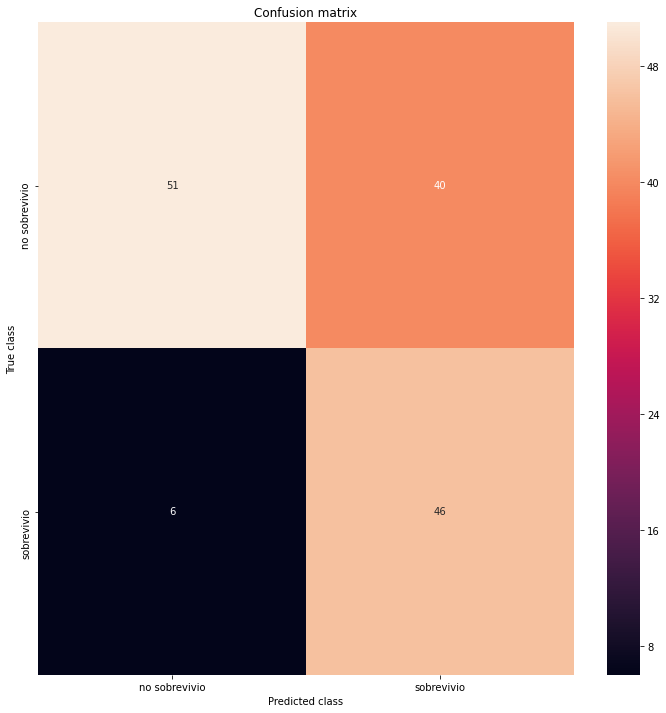

verdaderos positivos: 46
falsos positivos: 40
verdaderos negativos: 51
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.89      0.56      0.69        91
           1       0.53      0.88      0.67        52

    accuracy                           0.68       143
   macro avg       0.71      0.72      0.68       143
weighted avg       0.76      0.68      0.68       143

           metrics_train  metrics_test
Accuracy        0.657293      0.678322
Precision       0.537143      0.534884
Recall:         0.850679      0.884615
F1_Score:       0.658494      0.666667


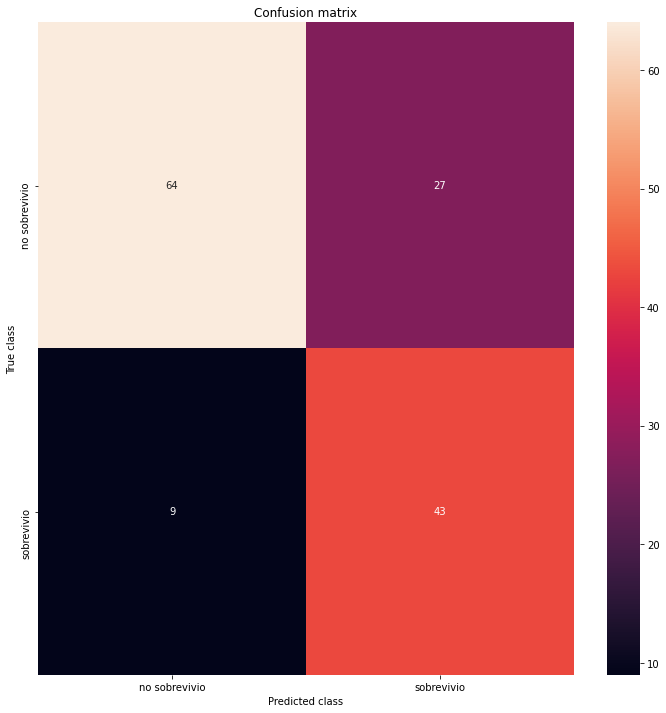

verdaderos positivos: 43
falsos positivos: 27
verdaderos negativos: 64
falsos negativos: 9
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        91
           1       0.61      0.83      0.70        52

    accuracy                           0.75       143
   macro avg       0.75      0.77      0.74       143
weighted avg       0.78      0.75      0.75       143

           metrics_train  metrics_test
Accuracy        0.743409      0.748252
Precision       0.640449      0.614286
Recall:         0.773756      0.826923
F1_Score:       0.700820      0.704918


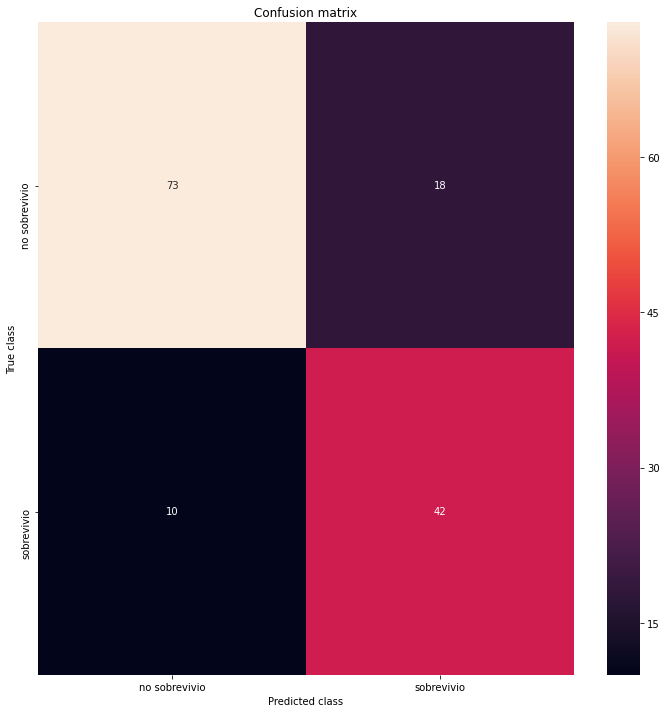

verdaderos positivos: 42
falsos positivos: 18
verdaderos negativos: 73
falsos negativos: 10
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        91
           1       0.70      0.81      0.75        52

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.81      0.80      0.81       143

           metrics_train  metrics_test
Accuracy        0.764499      0.804196
Precision       0.677551      0.700000
Recall:         0.751131      0.807692
F1_Score:       0.712446      0.750000


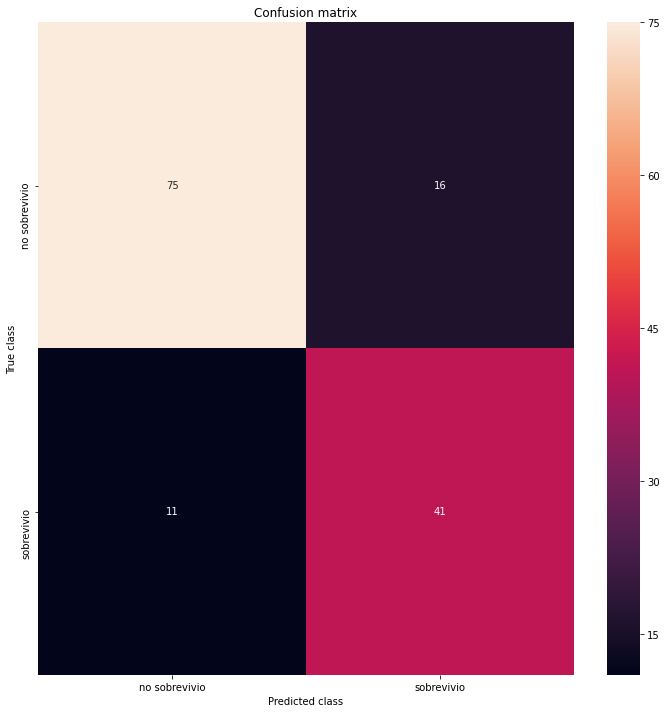

verdaderos positivos: 41
falsos positivos: 16
verdaderos negativos: 75
falsos negativos: 11
              precision    recall  f1-score   support

           0       0.87      0.82      0.85        91
           1       0.72      0.79      0.75        52

    accuracy                           0.81       143
   macro avg       0.80      0.81      0.80       143
weighted avg       0.82      0.81      0.81       143

           metrics_train  metrics_test
Accuracy        0.782074      0.811189
Precision       0.713656      0.719298
Recall:         0.733032      0.788462
F1_Score:       0.723214      0.752294


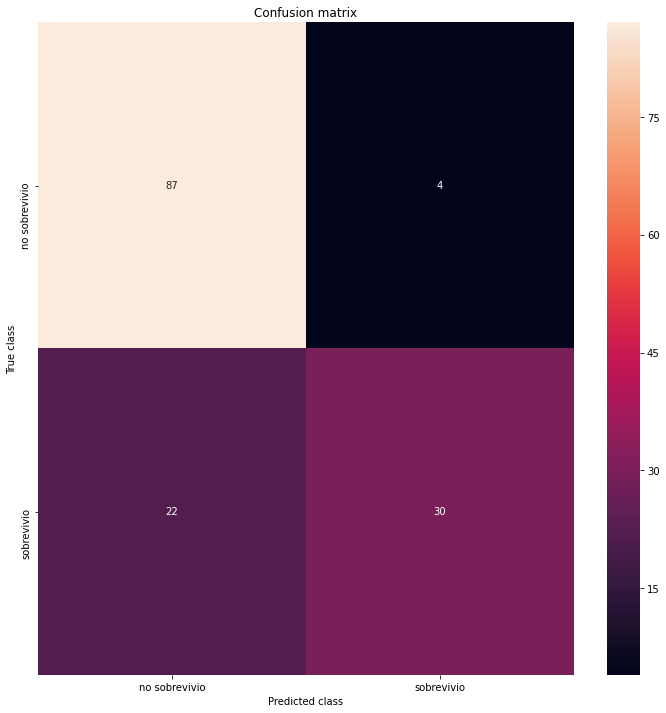

verdaderos positivos: 30
falsos positivos: 4
verdaderos negativos: 87
falsos negativos: 22
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        91
           1       0.88      0.58      0.70        52

    accuracy                           0.82       143
   macro avg       0.84      0.77      0.78       143
weighted avg       0.83      0.82      0.81       143

           metrics_train  metrics_test
Accuracy        0.776801      0.818182
Precision       0.840580      0.882353
Recall:         0.524887      0.576923
F1_Score:       0.646240      0.697674


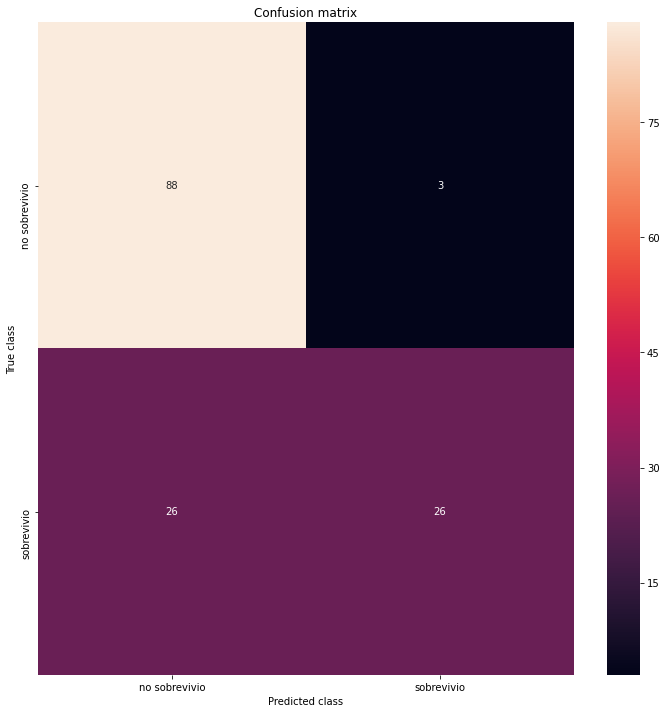

verdaderos positivos: 26
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 26
              precision    recall  f1-score   support

           0       0.77      0.97      0.86        91
           1       0.90      0.50      0.64        52

    accuracy                           0.80       143
   macro avg       0.83      0.73      0.75       143
weighted avg       0.82      0.80      0.78       143

           metrics_train  metrics_test
Accuracy        0.782074      0.797203
Precision       0.936937      0.896552
Recall:         0.470588      0.500000
F1_Score:       0.626506      0.641975
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.850469
Training accuracy: 0.351%
loss at step 1000: 0.703439
Training accuracy: 0.490%
Test accuracy: 0.664%


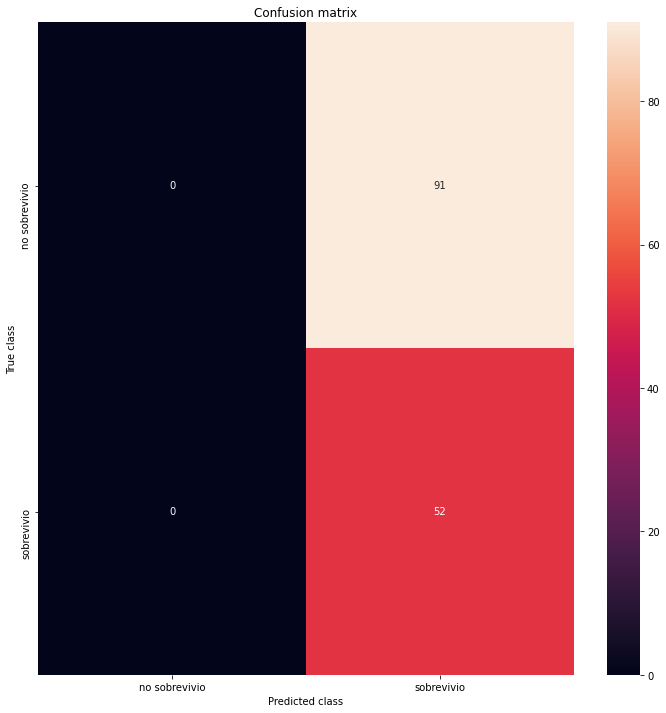

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


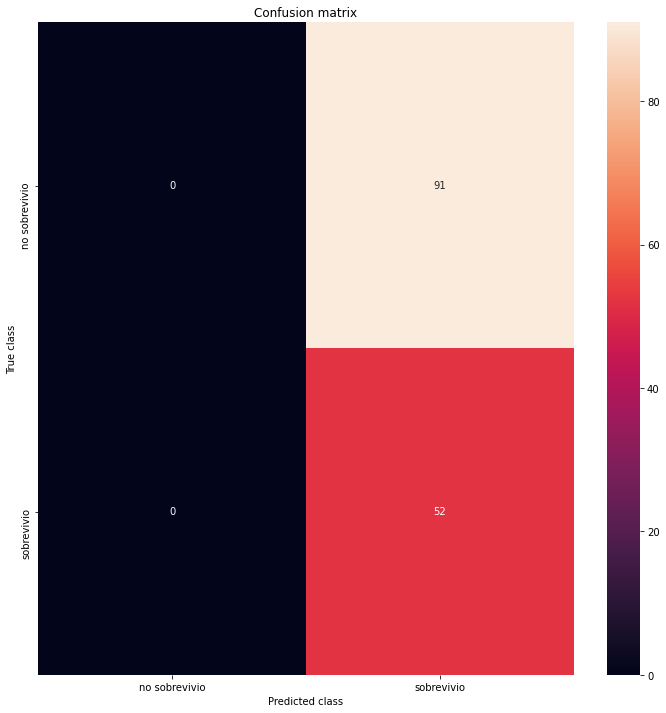

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


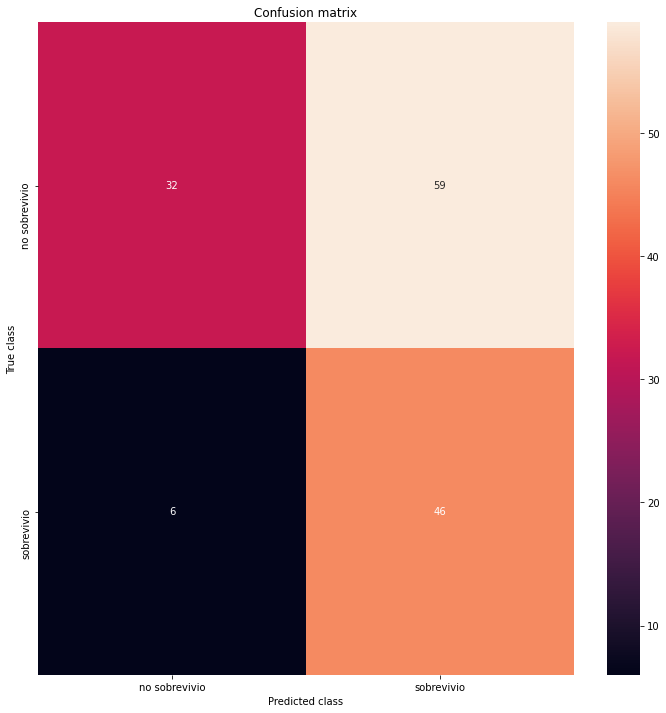

verdaderos positivos: 46
falsos positivos: 59
verdaderos negativos: 32
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.84      0.35      0.50        91
           1       0.44      0.88      0.59        52

    accuracy                           0.55       143
   macro avg       0.64      0.62      0.54       143
weighted avg       0.70      0.55      0.53       143

           metrics_train  metrics_test
Accuracy        0.546573      0.545455
Precision       0.456265      0.438095
Recall:         0.873303      0.884615
F1_Score:       0.599379      0.585987


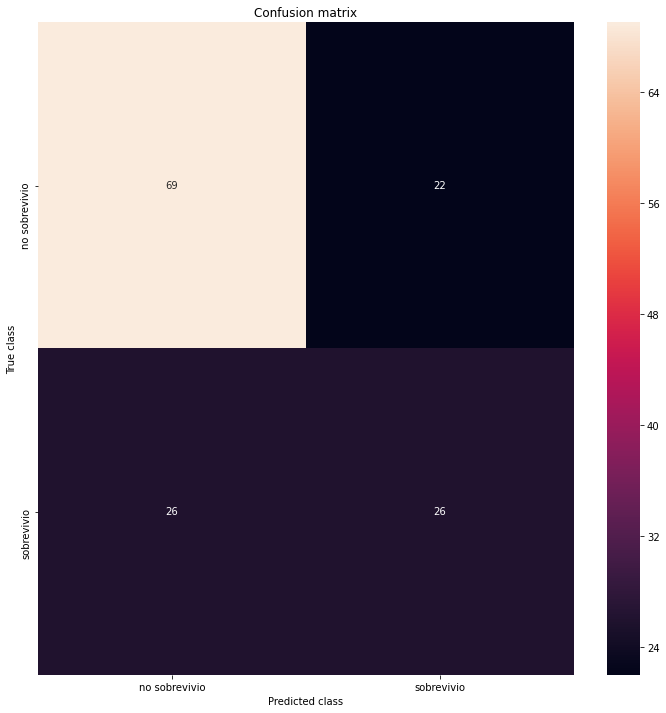

verdaderos positivos: 26
falsos positivos: 22
verdaderos negativos: 69
falsos negativos: 26
              precision    recall  f1-score   support

           0       0.73      0.76      0.74        91
           1       0.54      0.50      0.52        52

    accuracy                           0.66       143
   macro avg       0.63      0.63      0.63       143
weighted avg       0.66      0.66      0.66       143

           metrics_train  metrics_test
Accuracy        0.711775      0.664336
Precision       0.661017      0.541667
Recall:         0.529412      0.500000
F1_Score:       0.587940      0.520000


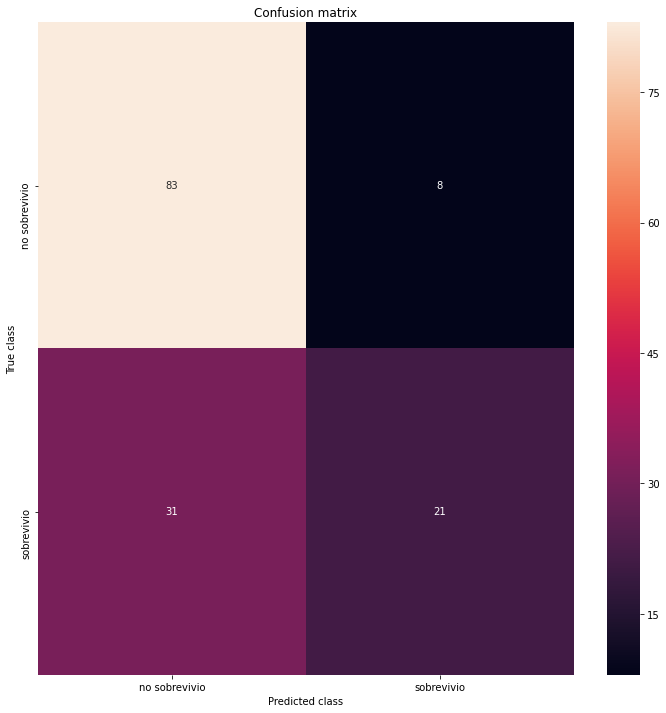

verdaderos positivos: 21
falsos positivos: 8
verdaderos negativos: 83
falsos negativos: 31
              precision    recall  f1-score   support

           0       0.73      0.91      0.81        91
           1       0.72      0.40      0.52        52

    accuracy                           0.73       143
   macro avg       0.73      0.66      0.66       143
weighted avg       0.73      0.73      0.70       143

           metrics_train  metrics_test
Accuracy        0.741652      0.727273
Precision       0.798387      0.724138
Recall:         0.447964      0.403846
F1_Score:       0.573913      0.518519


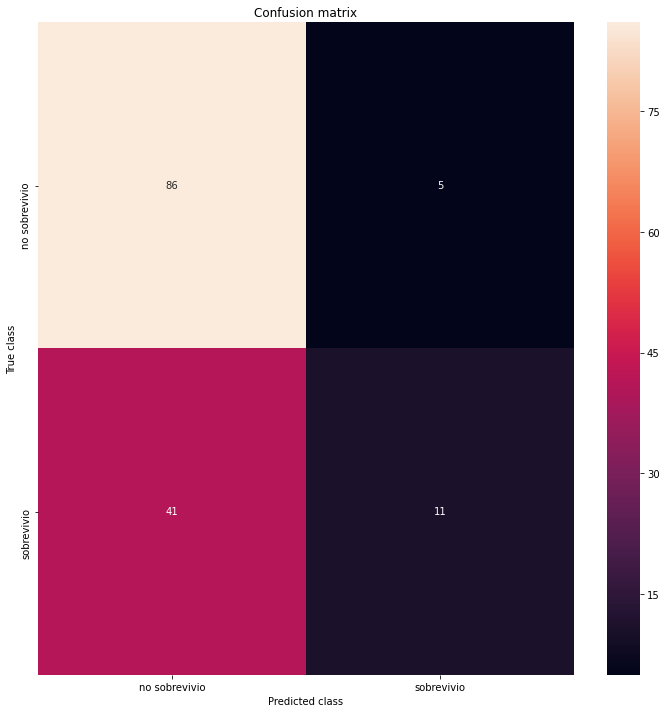

verdaderos positivos: 11
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 41
              precision    recall  f1-score   support

           0       0.68      0.95      0.79        91
           1       0.69      0.21      0.32        52

    accuracy                           0.68       143
   macro avg       0.68      0.58      0.56       143
weighted avg       0.68      0.68      0.62       143

           metrics_train  metrics_test
Accuracy        0.648506      0.678322
Precision       0.705882      0.687500
Recall:         0.162896      0.211538
F1_Score:       0.264706      0.323529


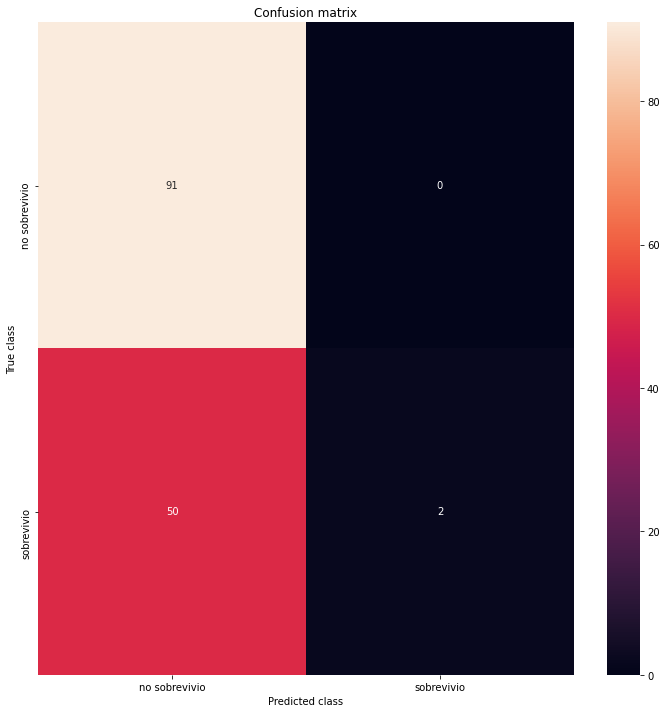

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


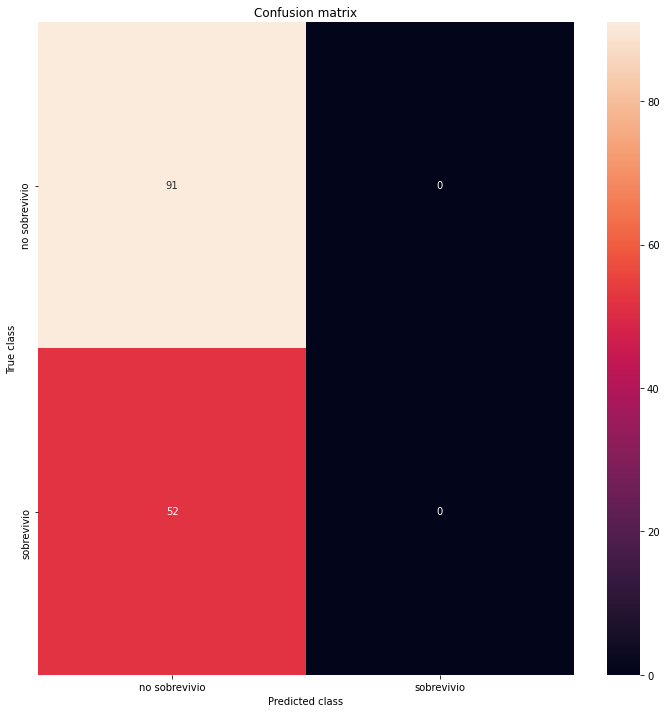

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.767046
Training accuracy: 0.624%
loss at step 1000: 0.615743
Training accuracy: 0.687%
Test accuracy: 0.755%


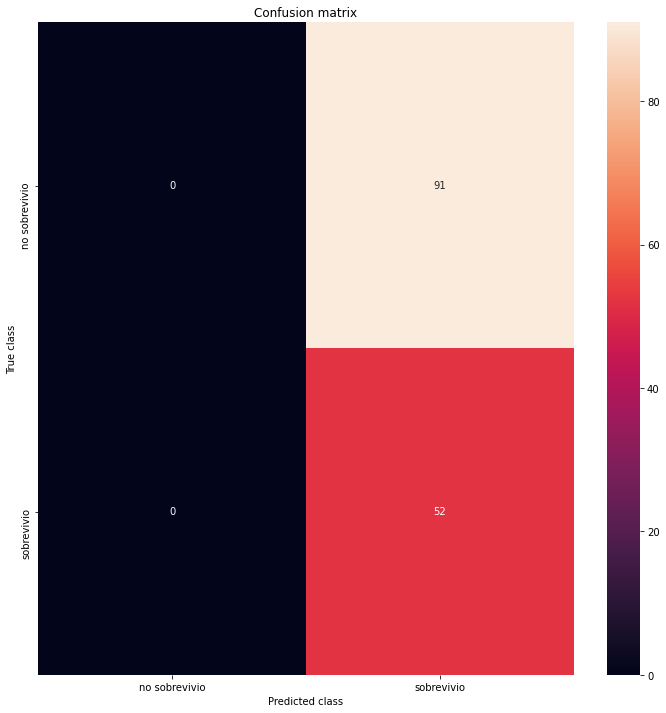

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


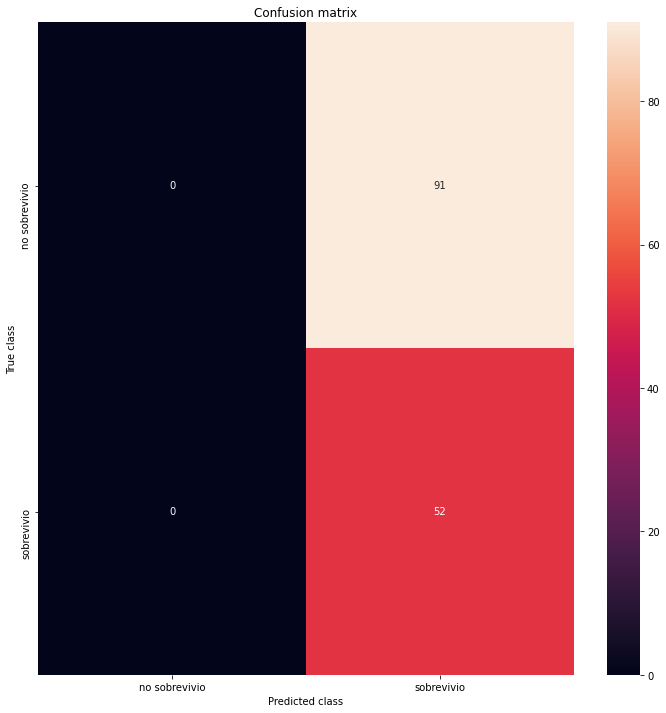

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


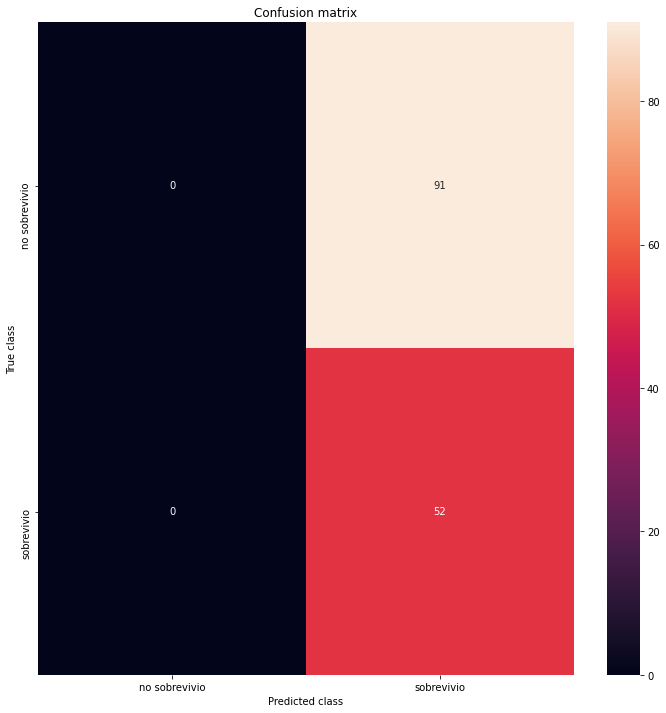

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


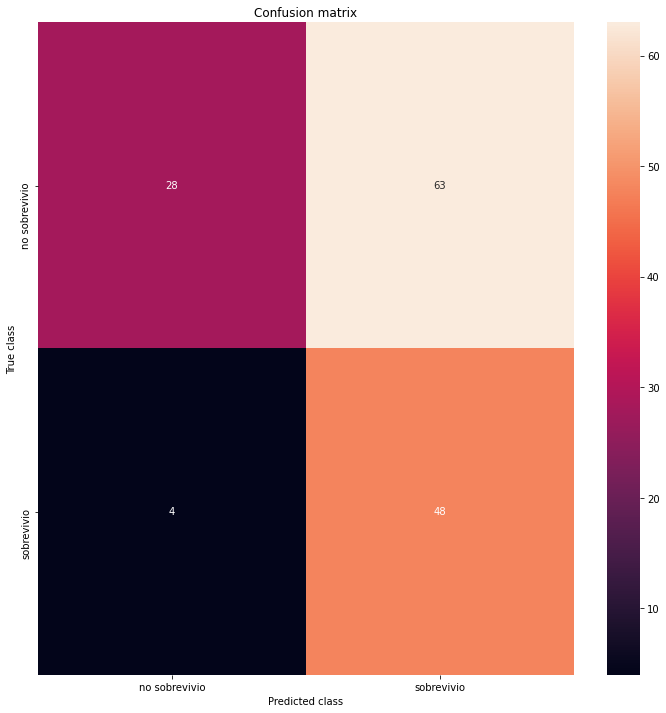

verdaderos positivos: 48
falsos positivos: 63
verdaderos negativos: 28
falsos negativos: 4
              precision    recall  f1-score   support

           0       0.88      0.31      0.46        91
           1       0.43      0.92      0.59        52

    accuracy                           0.53       143
   macro avg       0.65      0.62      0.52       143
weighted avg       0.71      0.53      0.50       143

           metrics_train  metrics_test
Accuracy        0.550088      0.531469
Precision       0.460137      0.432432
Recall:         0.914027      0.923077
F1_Score:       0.612121      0.588957


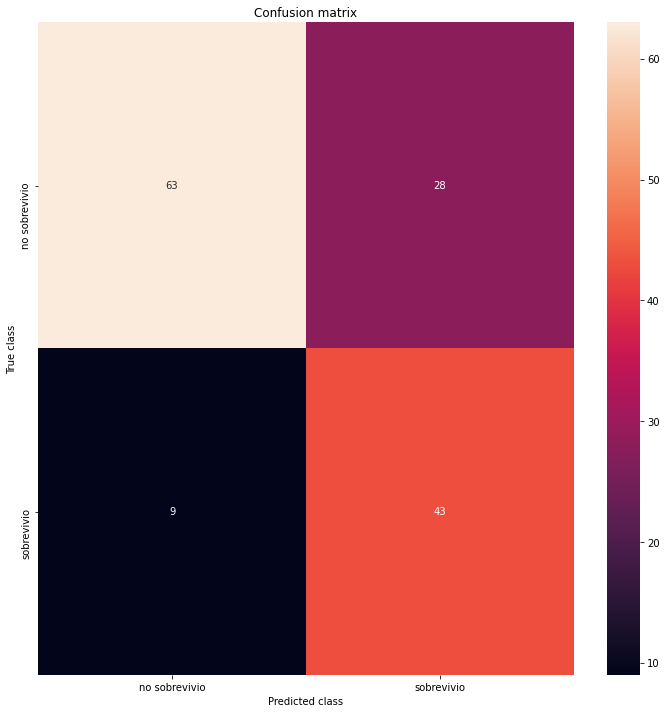

verdaderos positivos: 43
falsos positivos: 28
verdaderos negativos: 63
falsos negativos: 9
              precision    recall  f1-score   support

           0       0.88      0.69      0.77        91
           1       0.61      0.83      0.70        52

    accuracy                           0.74       143
   macro avg       0.74      0.76      0.74       143
weighted avg       0.78      0.74      0.75       143

           metrics_train  metrics_test
Accuracy        0.741652      0.741259
Precision       0.637037      0.605634
Recall:         0.778281      0.826923
F1_Score:       0.700611      0.699187


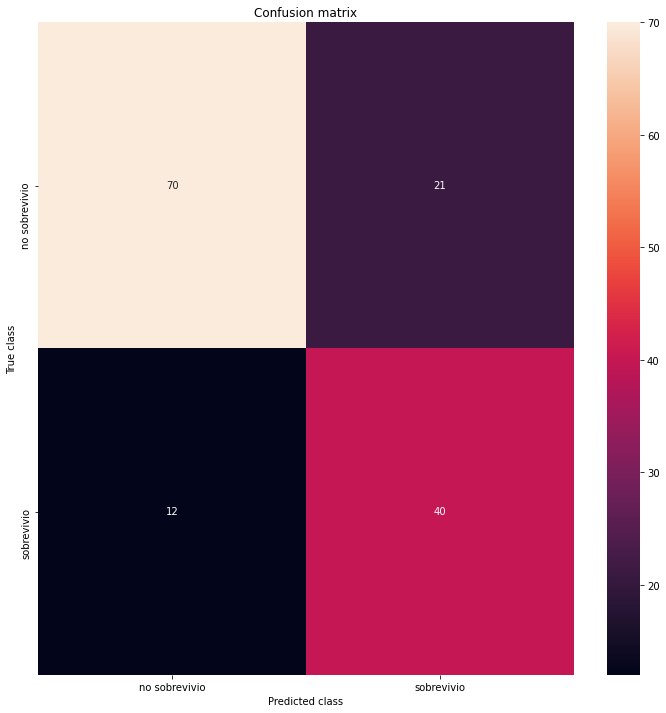

verdaderos positivos: 40
falsos positivos: 21
verdaderos negativos: 70
falsos negativos: 12
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        91
           1       0.66      0.77      0.71        52

    accuracy                           0.77       143
   macro avg       0.75      0.77      0.76       143
weighted avg       0.78      0.77      0.77       143

           metrics_train  metrics_test
Accuracy        0.759227      0.769231
Precision       0.679487      0.655738
Recall:         0.719457      0.769231
F1_Score:       0.698901      0.707965


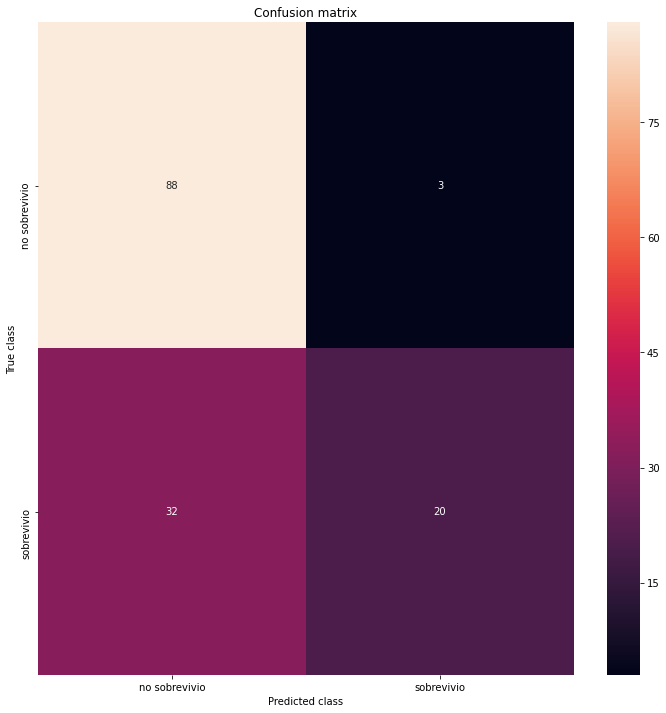

verdaderos positivos: 20
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 32
              precision    recall  f1-score   support

           0       0.73      0.97      0.83        91
           1       0.87      0.38      0.53        52

    accuracy                           0.76       143
   macro avg       0.80      0.68      0.68       143
weighted avg       0.78      0.76      0.72       143

           metrics_train  metrics_test
Accuracy        0.750439      0.755245
Precision       0.954023      0.869565
Recall:         0.375566      0.384615
F1_Score:       0.538961      0.533333


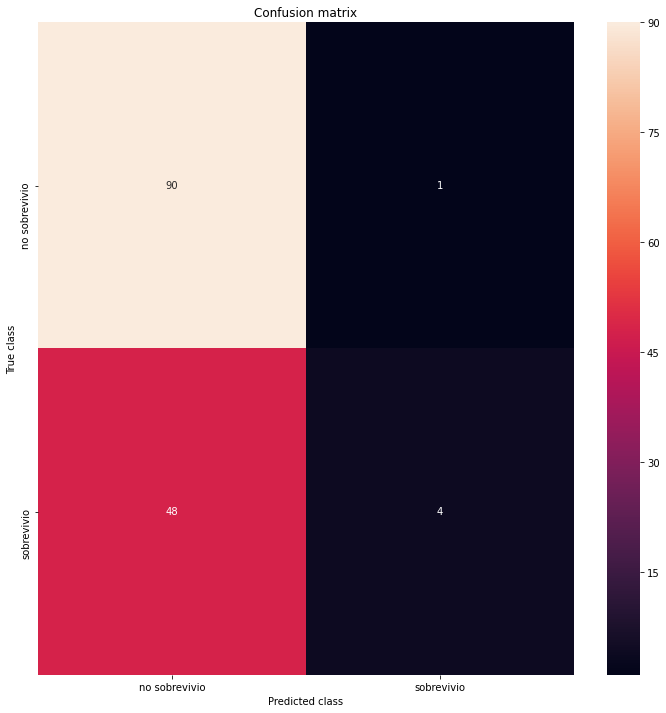

verdaderos positivos: 4
falsos positivos: 1
verdaderos negativos: 90
falsos negativos: 48
              precision    recall  f1-score   support

           0       0.65      0.99      0.79        91
           1       0.80      0.08      0.14        52

    accuracy                           0.66       143
   macro avg       0.73      0.53      0.46       143
weighted avg       0.71      0.66      0.55       143

           metrics_train  metrics_test
Accuracy        0.620387      0.657343
Precision       1.000000      0.800000
Recall:         0.022624      0.076923
F1_Score:       0.044248      0.140351
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.823455
Training accuracy: 0.362%
loss at step 1000: 0.710514
Training accuracy: 0.489%
Test accuracy: 0.650%


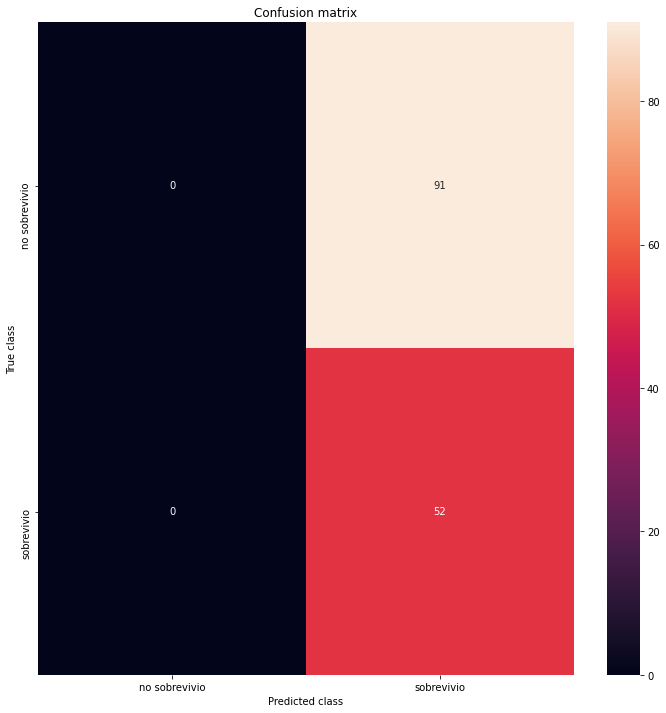

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


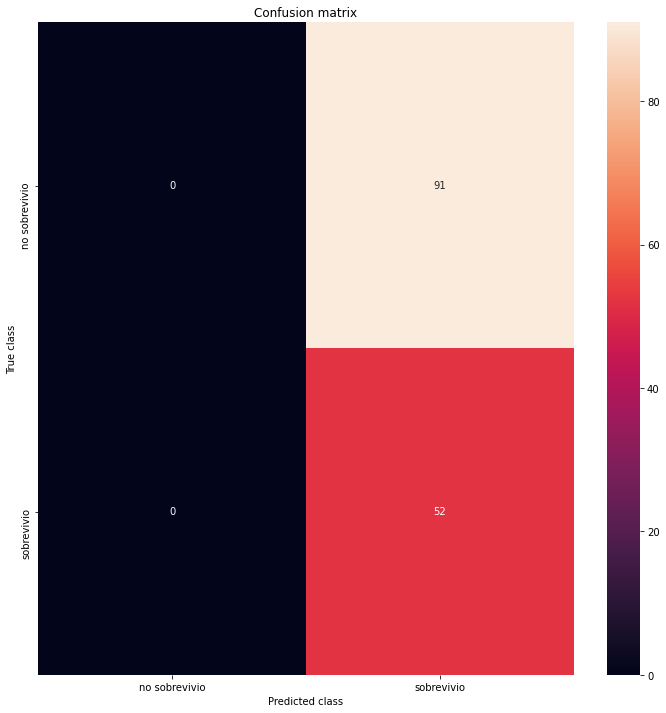

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


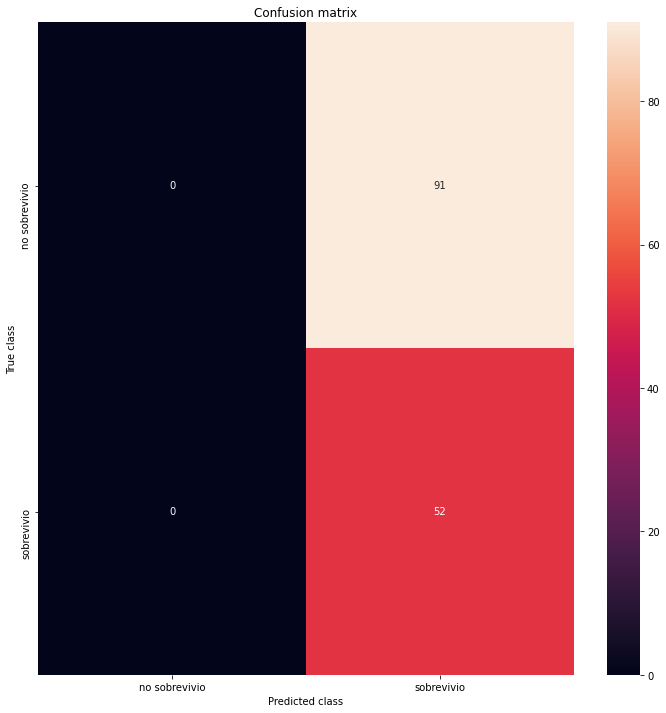

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


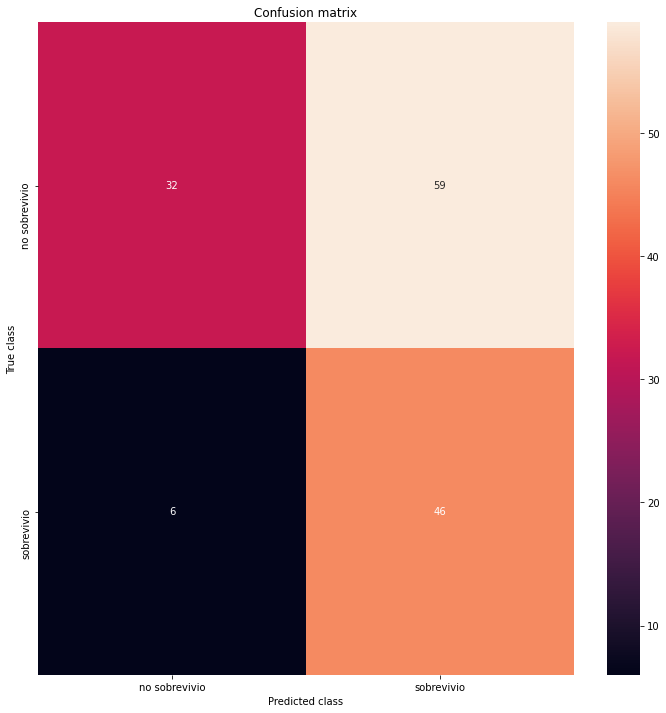

verdaderos positivos: 46
falsos positivos: 59
verdaderos negativos: 32
falsos negativos: 6
              precision    recall  f1-score   support

           0       0.84      0.35      0.50        91
           1       0.44      0.88      0.59        52

    accuracy                           0.55       143
   macro avg       0.64      0.62      0.54       143
weighted avg       0.70      0.55      0.53       143

           metrics_train  metrics_test
Accuracy        0.546573      0.545455
Precision       0.456265      0.438095
Recall:         0.873303      0.884615
F1_Score:       0.599379      0.585987


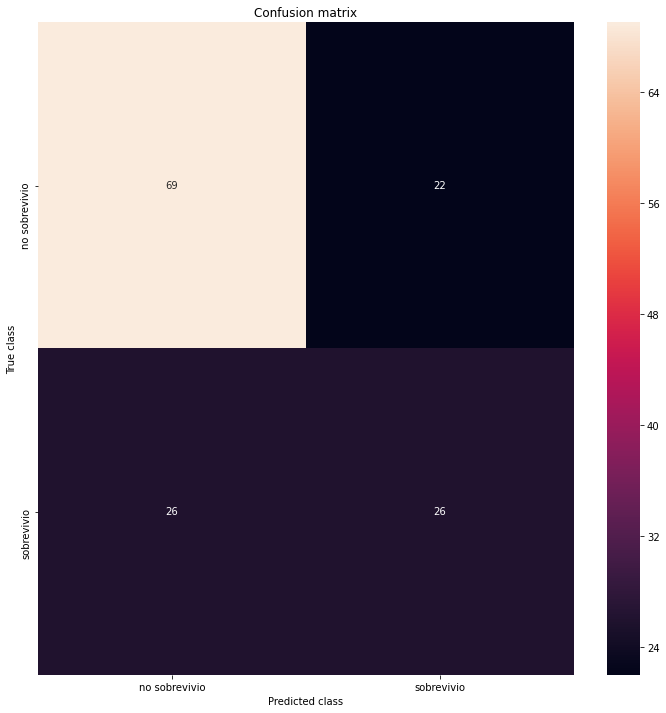

verdaderos positivos: 26
falsos positivos: 22
verdaderos negativos: 69
falsos negativos: 26
              precision    recall  f1-score   support

           0       0.73      0.76      0.74        91
           1       0.54      0.50      0.52        52

    accuracy                           0.66       143
   macro avg       0.63      0.63      0.63       143
weighted avg       0.66      0.66      0.66       143

           metrics_train  metrics_test
Accuracy        0.711775      0.664336
Precision       0.661017      0.541667
Recall:         0.529412      0.500000
F1_Score:       0.587940      0.520000


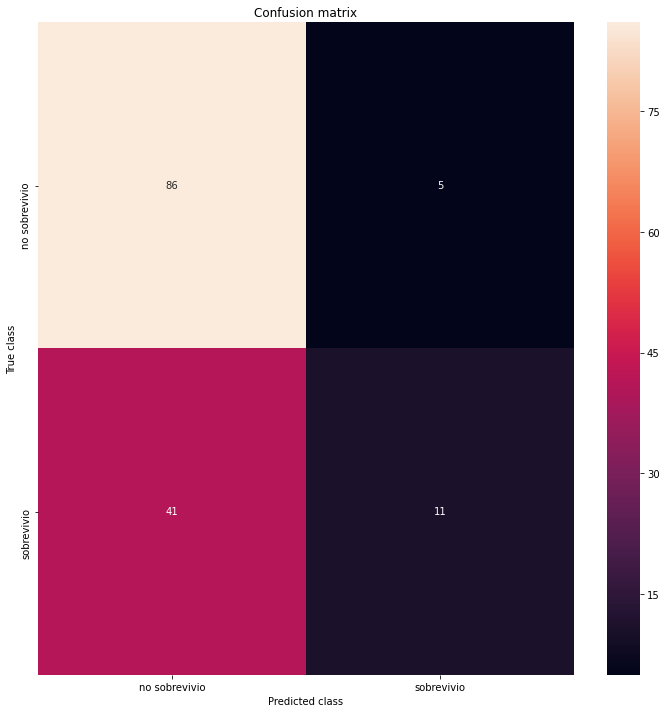

verdaderos positivos: 11
falsos positivos: 5
verdaderos negativos: 86
falsos negativos: 41
              precision    recall  f1-score   support

           0       0.68      0.95      0.79        91
           1       0.69      0.21      0.32        52

    accuracy                           0.68       143
   macro avg       0.68      0.58      0.56       143
weighted avg       0.68      0.68      0.62       143

           metrics_train  metrics_test
Accuracy        0.652021      0.678322
Precision       0.716981      0.687500
Recall:         0.171946      0.211538
F1_Score:       0.277372      0.323529


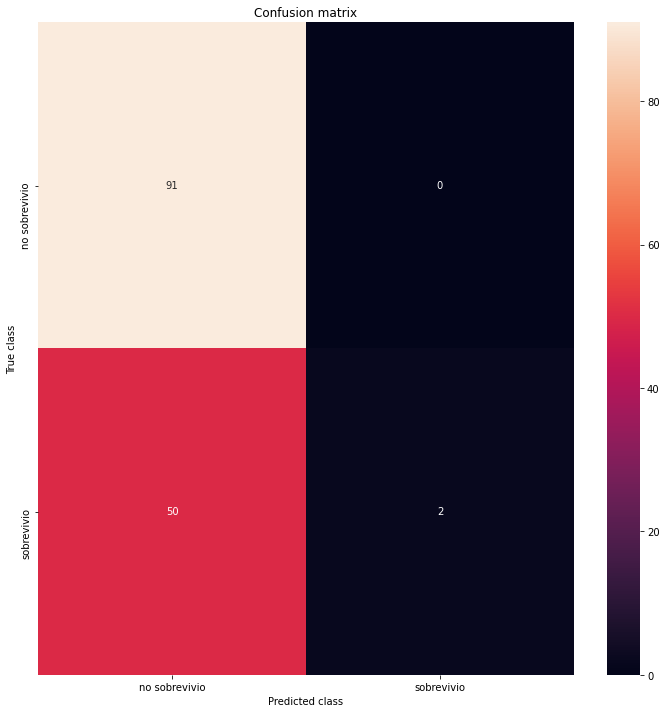

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


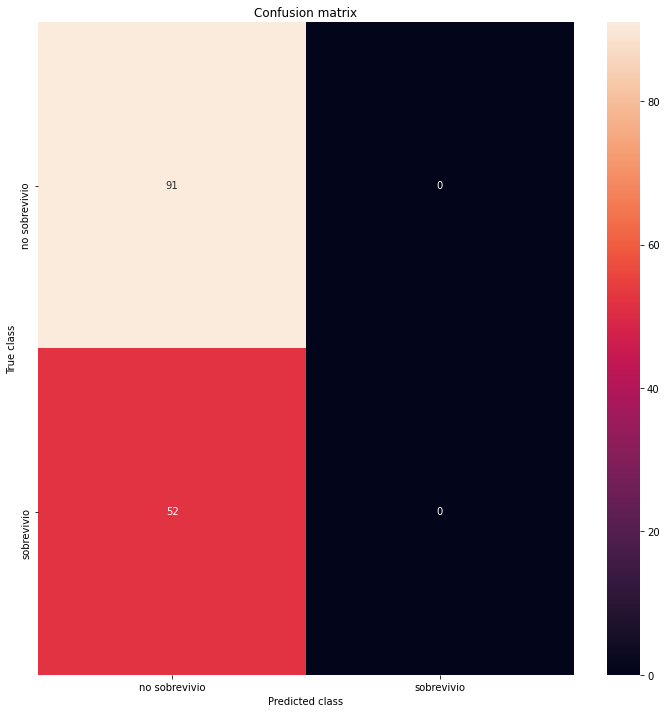

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.733083
Training accuracy: 0.524%
loss at step 1000: 0.634708
Training accuracy: 0.634%
Test accuracy: 0.748%


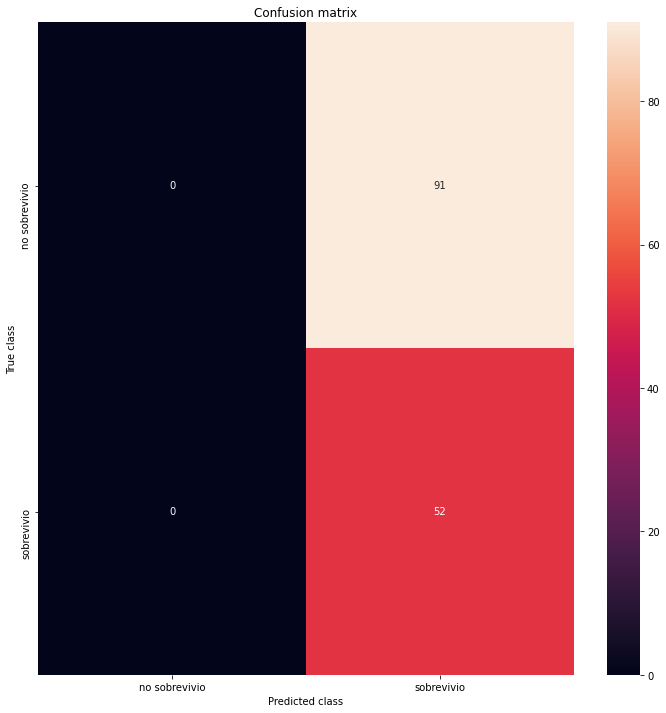

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


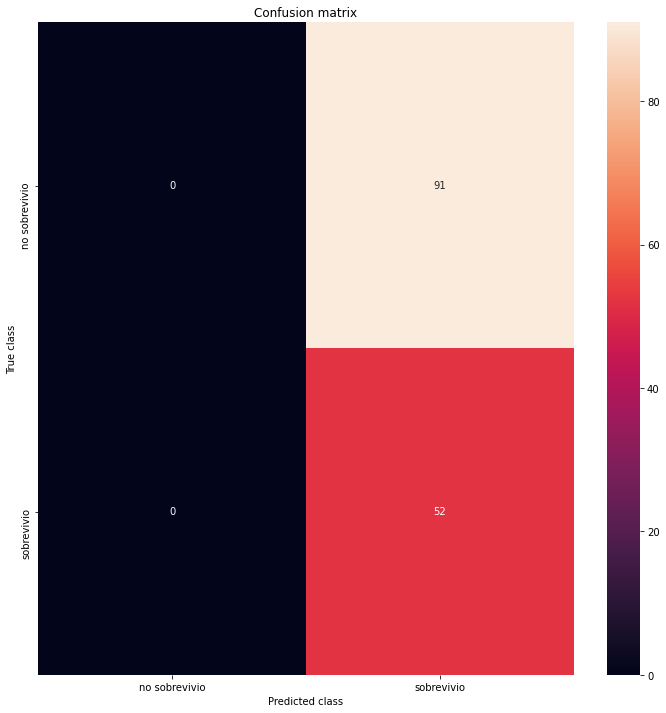

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


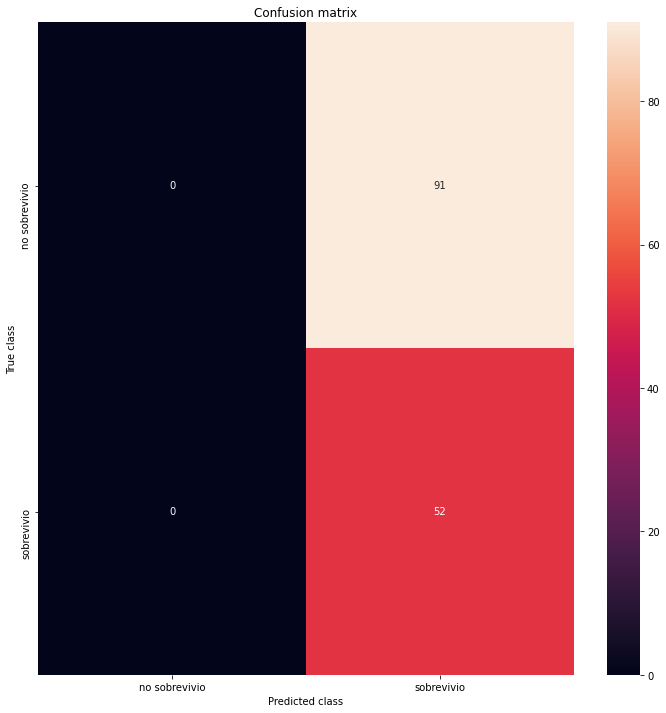

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


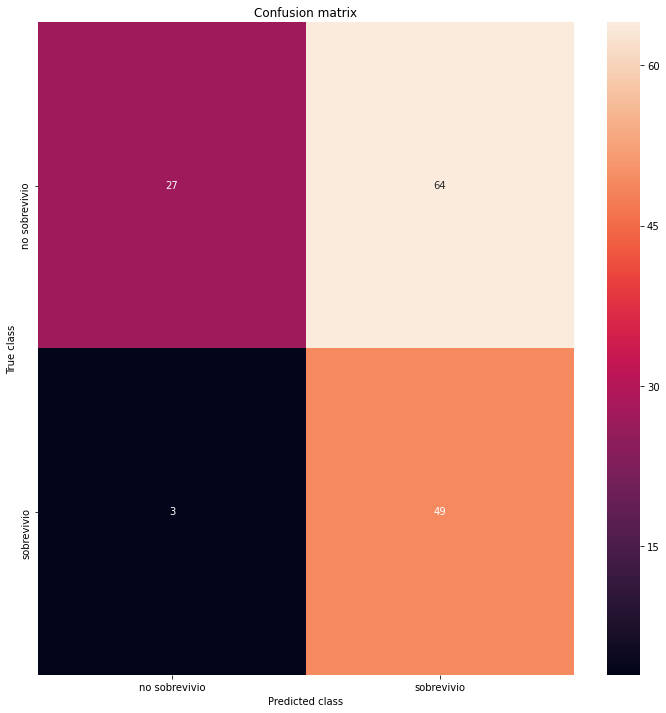

verdaderos positivos: 49
falsos positivos: 64
verdaderos negativos: 27
falsos negativos: 3
              precision    recall  f1-score   support

           0       0.90      0.30      0.45        91
           1       0.43      0.94      0.59        52

    accuracy                           0.53       143
   macro avg       0.67      0.62      0.52       143
weighted avg       0.73      0.53      0.50       143

           metrics_train  metrics_test
Accuracy        0.546573      0.531469
Precision       0.458050      0.433628
Recall:         0.914027      0.942308
F1_Score:       0.610272      0.593939


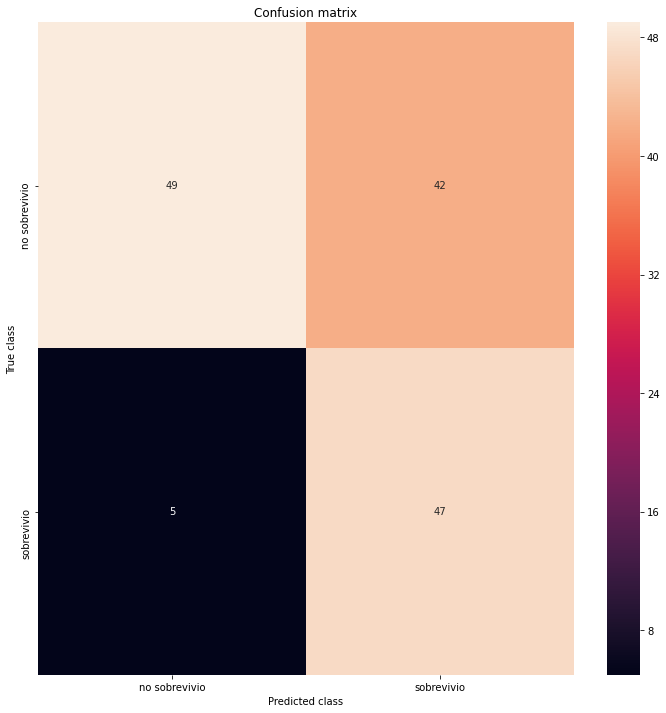

verdaderos positivos: 47
falsos positivos: 42
verdaderos negativos: 49
falsos negativos: 5
              precision    recall  f1-score   support

           0       0.91      0.54      0.68        91
           1       0.53      0.90      0.67        52

    accuracy                           0.67       143
   macro avg       0.72      0.72      0.67       143
weighted avg       0.77      0.67      0.67       143

           metrics_train  metrics_test
Accuracy        0.653779      0.671329
Precision       0.533708      0.528090
Recall:         0.859729      0.903846
F1_Score:       0.658579      0.666667


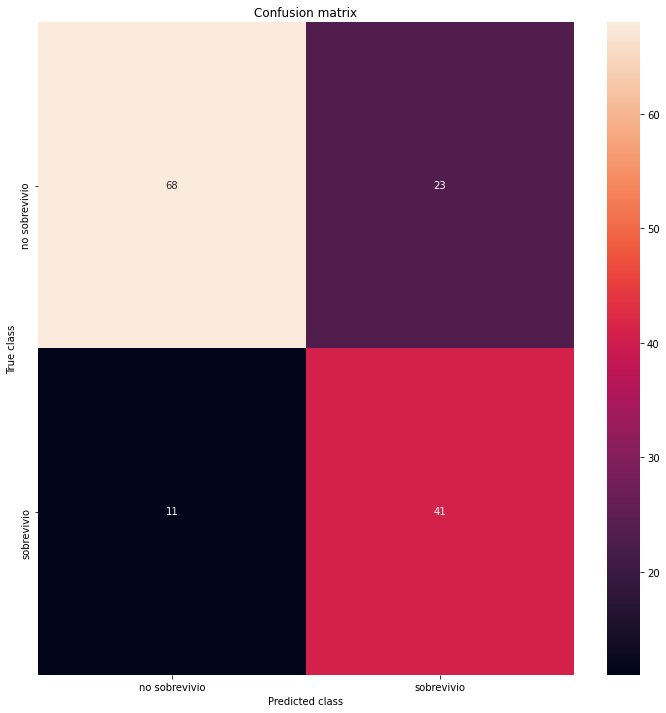

verdaderos positivos: 41
falsos positivos: 23
verdaderos negativos: 68
falsos negativos: 11
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        91
           1       0.64      0.79      0.71        52

    accuracy                           0.76       143
   macro avg       0.75      0.77      0.75       143
weighted avg       0.78      0.76      0.77       143

           metrics_train  metrics_test
Accuracy        0.743409      0.762238
Precision       0.650602      0.640625
Recall:         0.733032      0.788462
F1_Score:       0.689362      0.706897


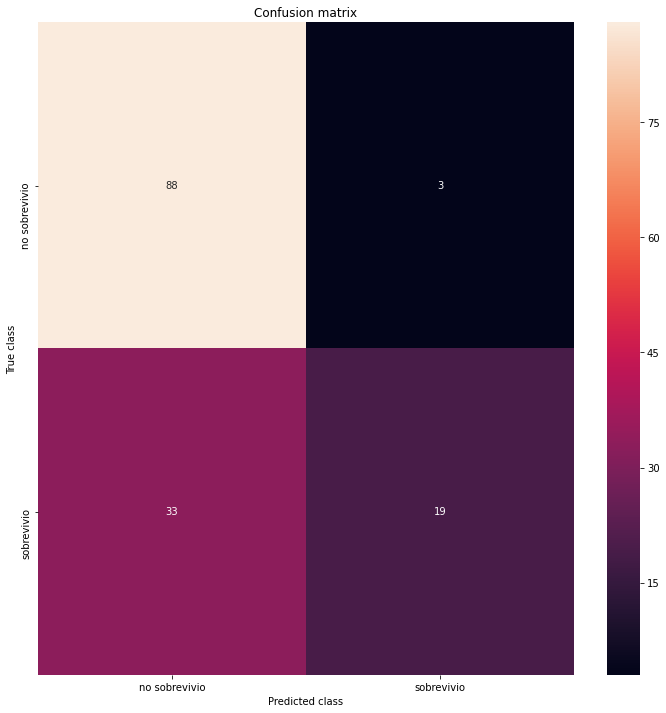

verdaderos positivos: 19
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 33
              precision    recall  f1-score   support

           0       0.73      0.97      0.83        91
           1       0.86      0.37      0.51        52

    accuracy                           0.75       143
   macro avg       0.80      0.67      0.67       143
weighted avg       0.78      0.75      0.72       143

           metrics_train  metrics_test
Accuracy        0.743409      0.748252
Precision       0.974684      0.863636
Recall:         0.348416      0.365385
F1_Score:       0.513333      0.513514


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


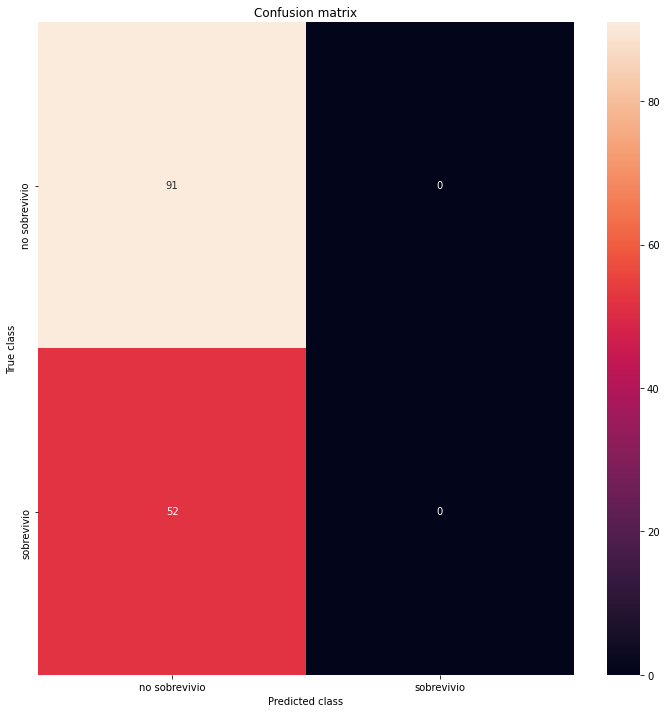

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.814045
Training accuracy: 0.362%
loss at step 1000: 0.711600
Training accuracy: 0.489%
Test accuracy: 0.650%


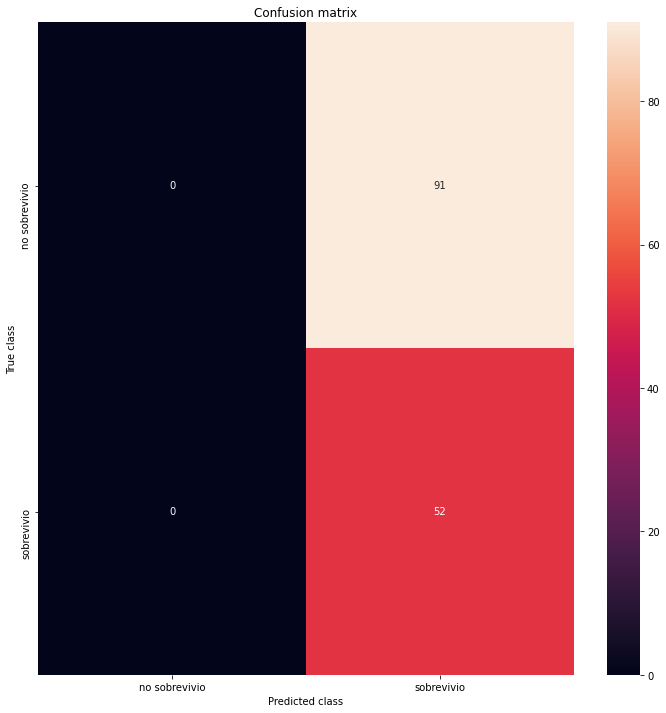

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


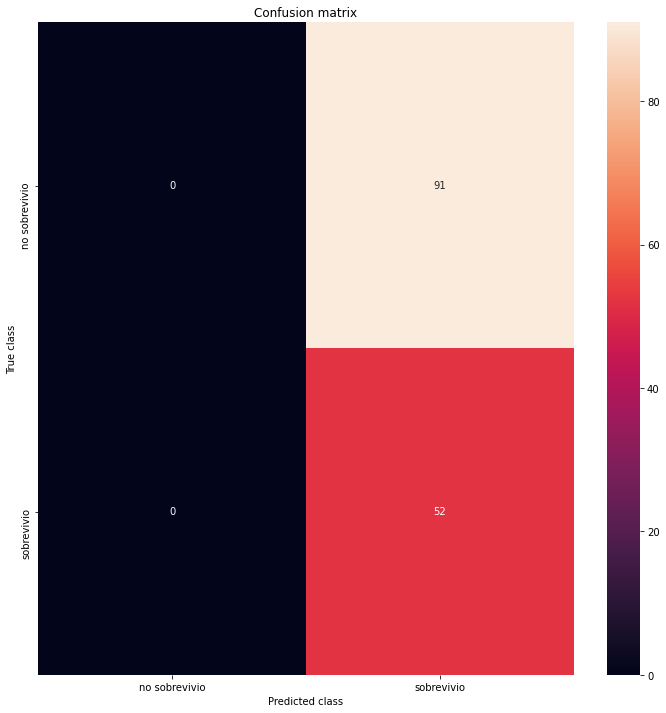

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


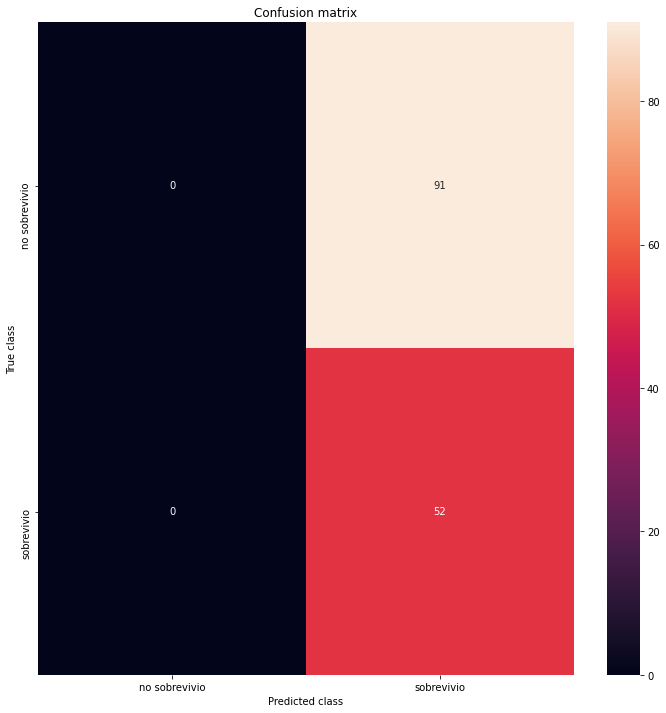

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


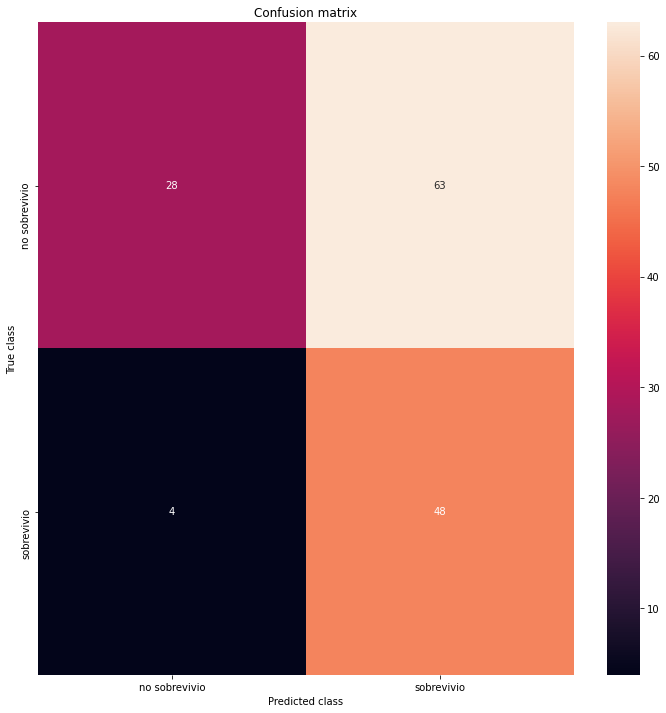

verdaderos positivos: 48
falsos positivos: 63
verdaderos negativos: 28
falsos negativos: 4
              precision    recall  f1-score   support

           0       0.88      0.31      0.46        91
           1       0.43      0.92      0.59        52

    accuracy                           0.53       143
   macro avg       0.65      0.62      0.52       143
weighted avg       0.71      0.53      0.50       143

           metrics_train  metrics_test
Accuracy        0.550088      0.531469
Precision       0.460137      0.432432
Recall:         0.914027      0.923077
F1_Score:       0.612121      0.588957


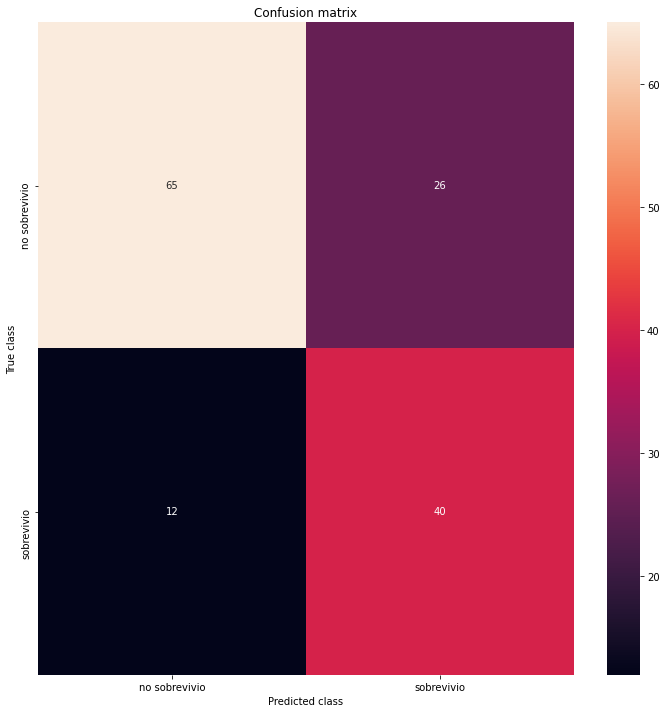

verdaderos positivos: 40
falsos positivos: 26
verdaderos negativos: 65
falsos negativos: 12
              precision    recall  f1-score   support

           0       0.84      0.71      0.77        91
           1       0.61      0.77      0.68        52

    accuracy                           0.73       143
   macro avg       0.73      0.74      0.73       143
weighted avg       0.76      0.73      0.74       143

           metrics_train  metrics_test
Accuracy        0.746924      0.734266
Precision       0.655870      0.606061
Recall:         0.733032      0.769231
F1_Score:       0.692308      0.677966


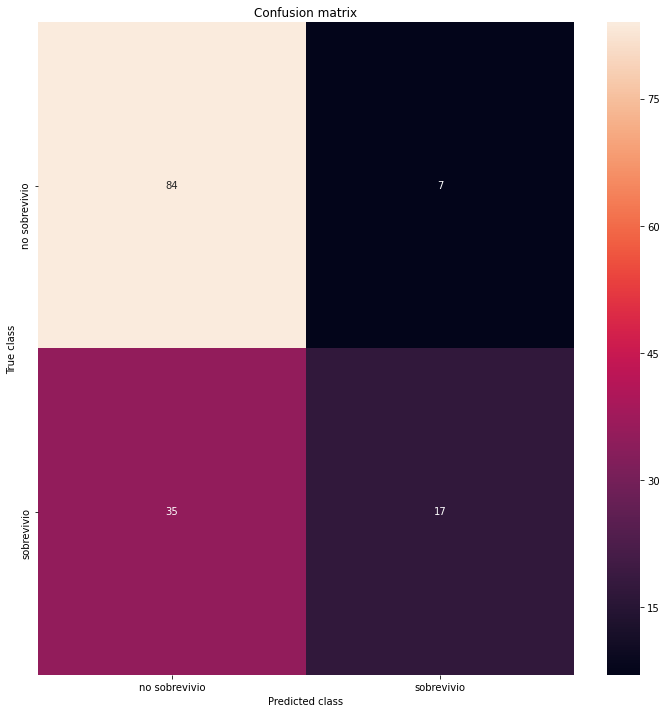

verdaderos positivos: 17
falsos positivos: 7
verdaderos negativos: 84
falsos negativos: 35
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        91
           1       0.71      0.33      0.45        52

    accuracy                           0.71       143
   macro avg       0.71      0.62      0.62       143
weighted avg       0.71      0.71      0.67       143

           metrics_train  metrics_test
Accuracy        0.729350      0.706294
Precision       0.831683      0.708333
Recall:         0.380090      0.326923
F1_Score:       0.521739      0.447368


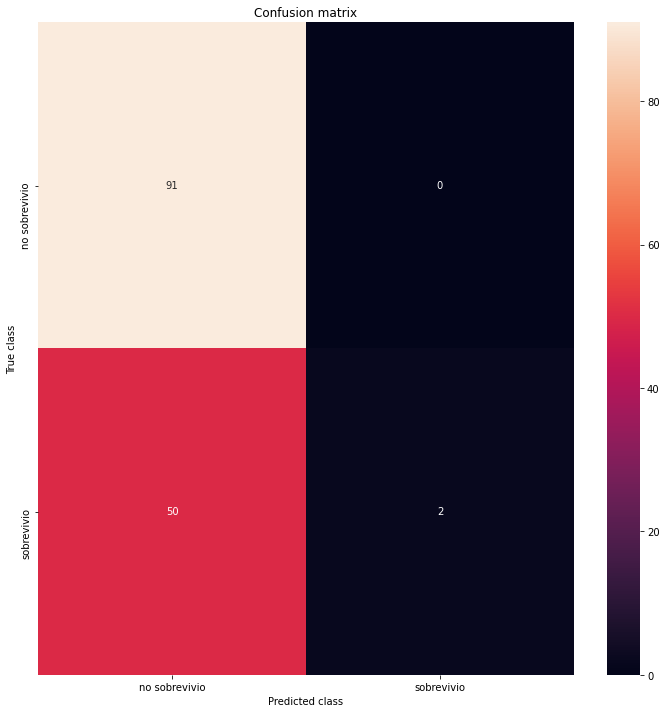

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


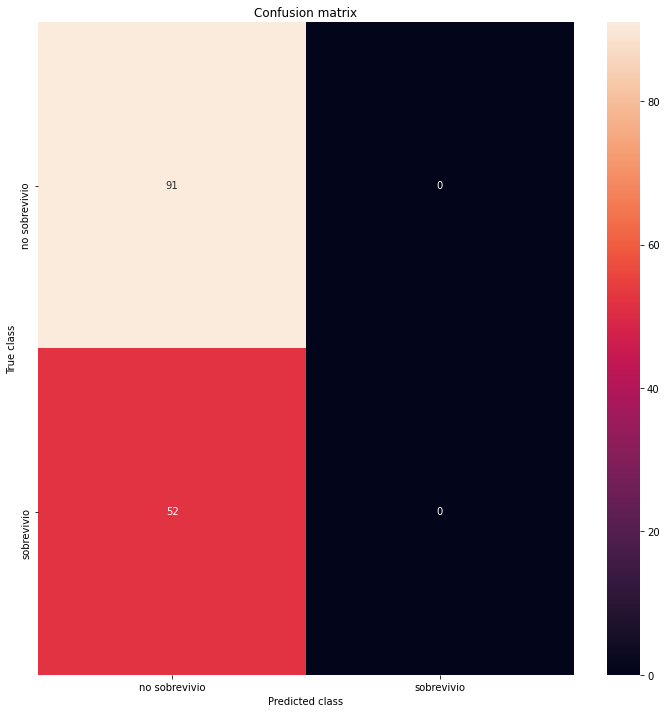

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.725563
Training accuracy: 0.545%
loss at step 1000: 0.637904
Training accuracy: 0.634%
Test accuracy: 0.741%


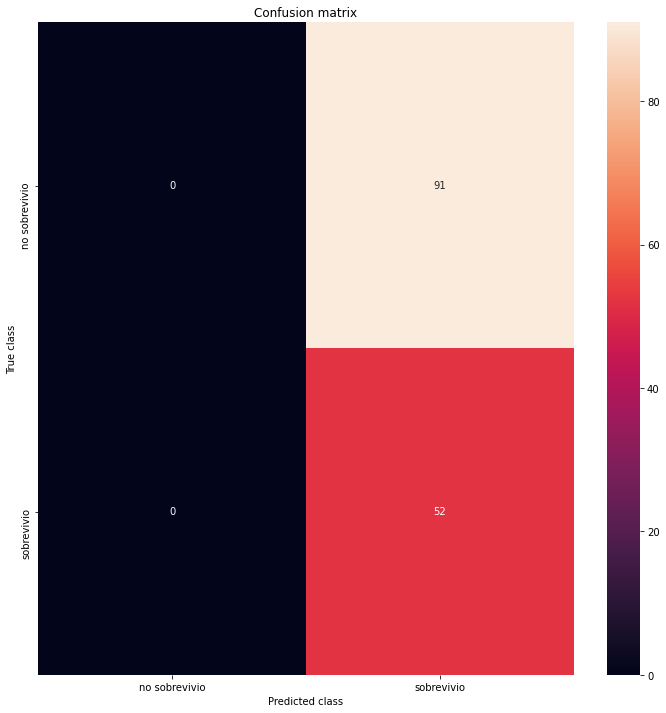

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


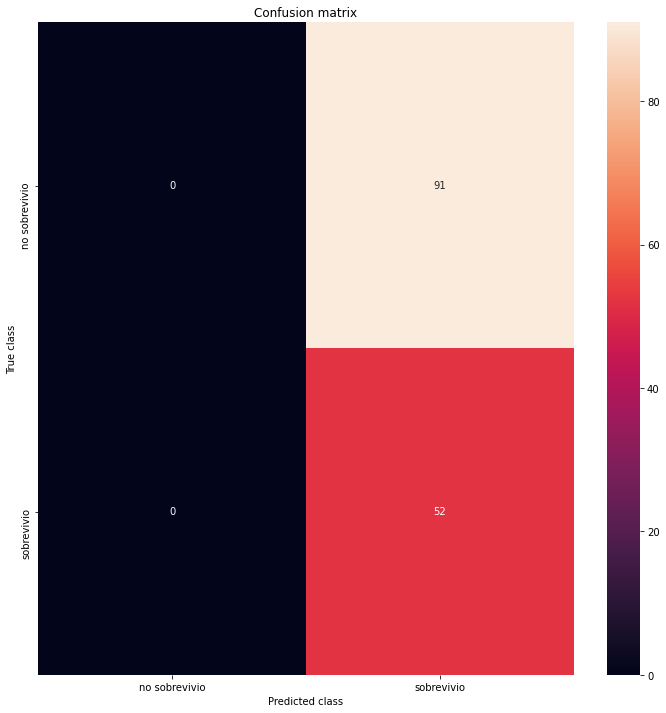

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


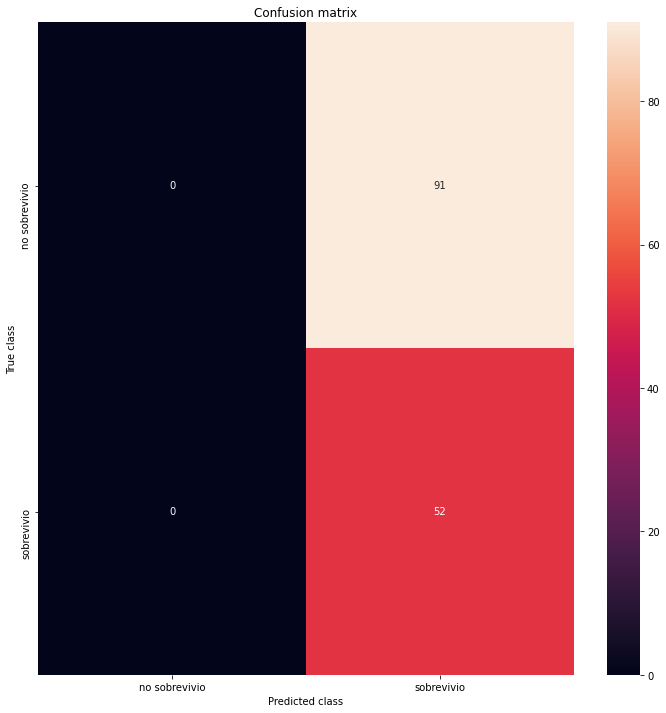

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


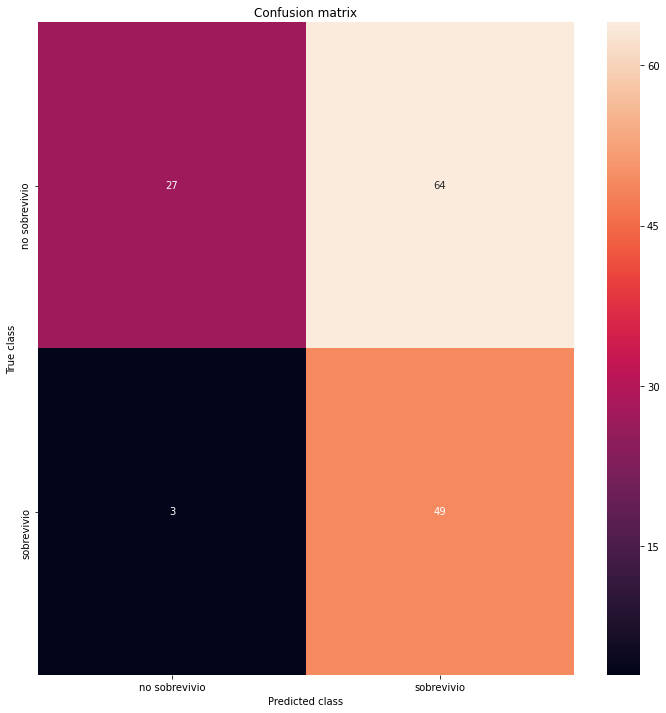

verdaderos positivos: 49
falsos positivos: 64
verdaderos negativos: 27
falsos negativos: 3
              precision    recall  f1-score   support

           0       0.90      0.30      0.45        91
           1       0.43      0.94      0.59        52

    accuracy                           0.53       143
   macro avg       0.67      0.62      0.52       143
weighted avg       0.73      0.53      0.50       143

           metrics_train  metrics_test
Accuracy        0.546573      0.531469
Precision       0.458050      0.433628
Recall:         0.914027      0.942308
F1_Score:       0.610272      0.593939


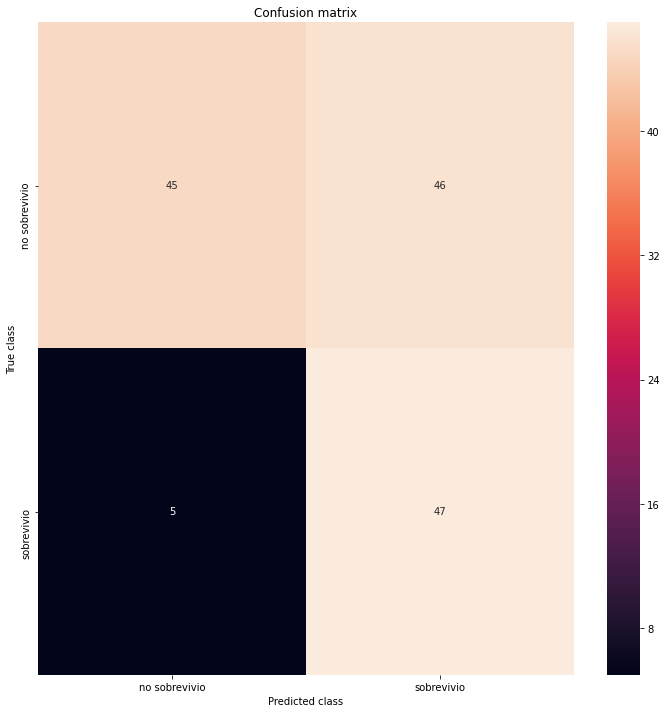

verdaderos positivos: 47
falsos positivos: 46
verdaderos negativos: 45
falsos negativos: 5
              precision    recall  f1-score   support

           0       0.90      0.49      0.64        91
           1       0.51      0.90      0.65        52

    accuracy                           0.64       143
   macro avg       0.70      0.70      0.64       143
weighted avg       0.76      0.64      0.64       143

           metrics_train  metrics_test
Accuracy        0.648506      0.643357
Precision       0.528302      0.505376
Recall:         0.886878      0.903846
F1_Score:       0.662162      0.648276


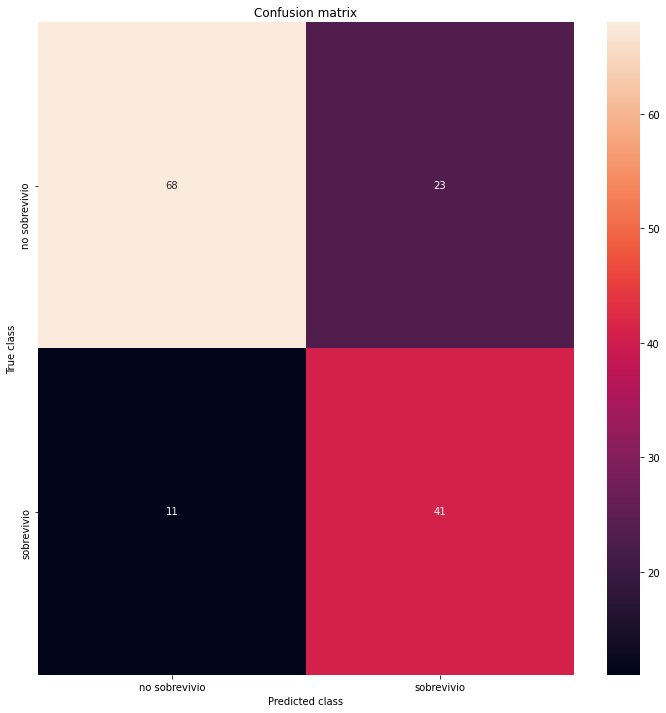

verdaderos positivos: 41
falsos positivos: 23
verdaderos negativos: 68
falsos negativos: 11
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        91
           1       0.64      0.79      0.71        52

    accuracy                           0.76       143
   macro avg       0.75      0.77      0.75       143
weighted avg       0.78      0.76      0.77       143

           metrics_train  metrics_test
Accuracy        0.743409      0.762238
Precision       0.650602      0.640625
Recall:         0.733032      0.788462
F1_Score:       0.689362      0.706897


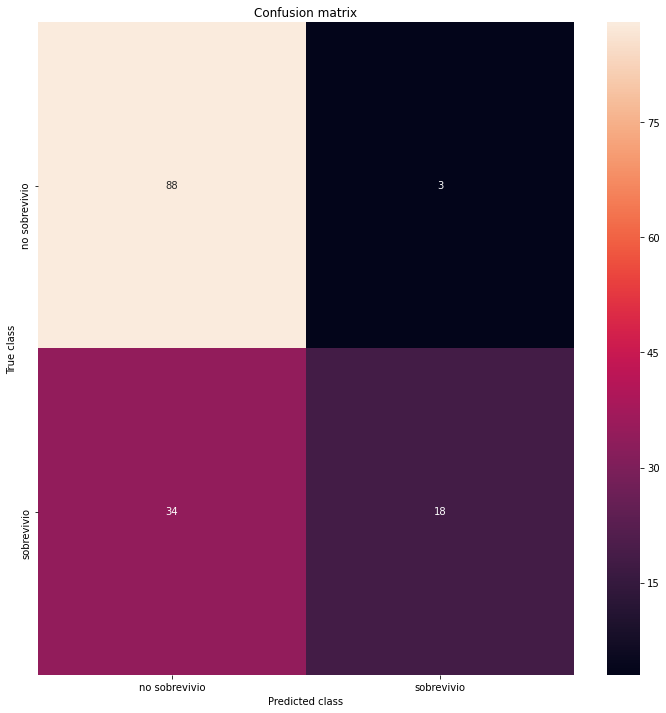

verdaderos positivos: 18
falsos positivos: 3
verdaderos negativos: 88
falsos negativos: 34
              precision    recall  f1-score   support

           0       0.72      0.97      0.83        91
           1       0.86      0.35      0.49        52

    accuracy                           0.74       143
   macro avg       0.79      0.66      0.66       143
weighted avg       0.77      0.74      0.71       143

           metrics_train  metrics_test
Accuracy        0.724077      0.741259
Precision       0.984848      0.857143
Recall:         0.294118      0.346154
F1_Score:       0.452962      0.493151


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


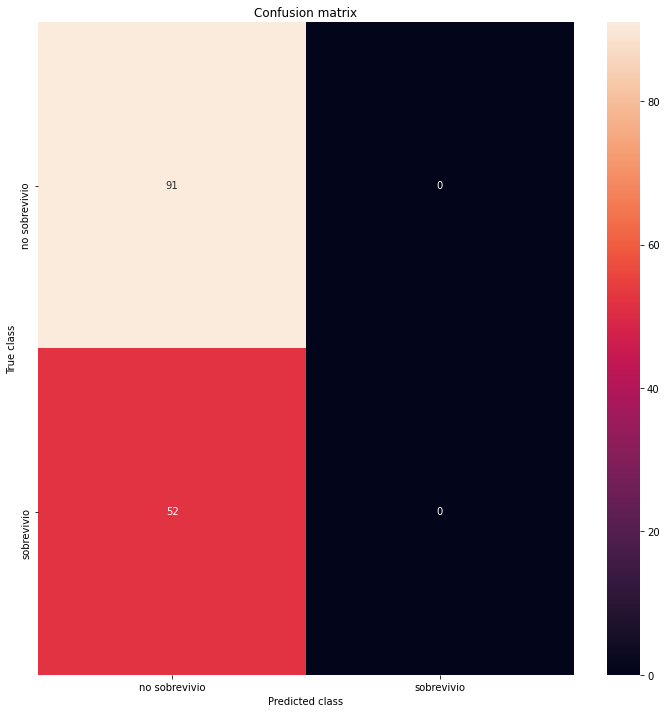

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.721451
Training accuracy: 0.615%
loss at step 1000: 0.721500
Training accuracy: 0.615%
Test accuracy: 0.650%


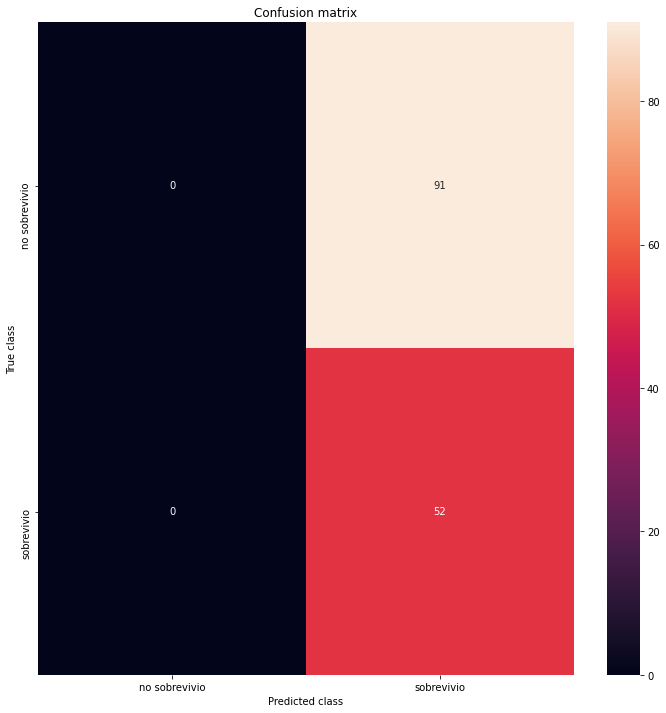

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


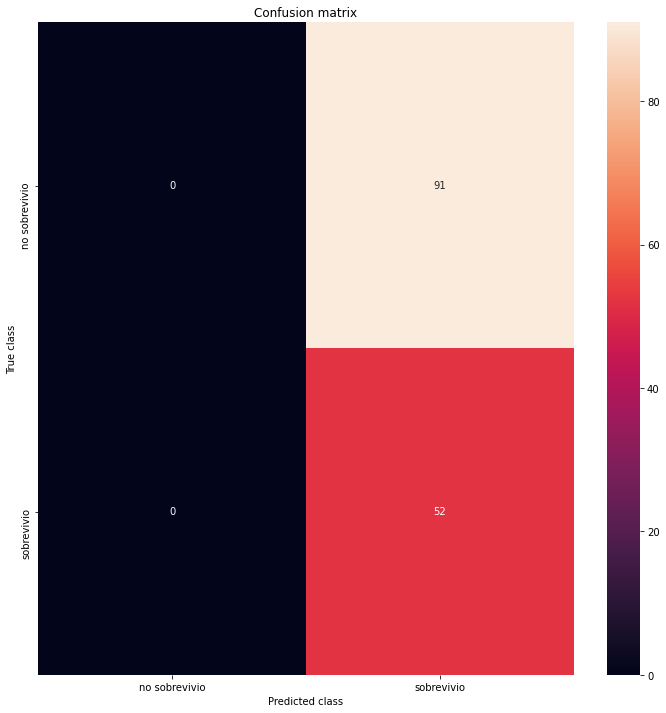

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


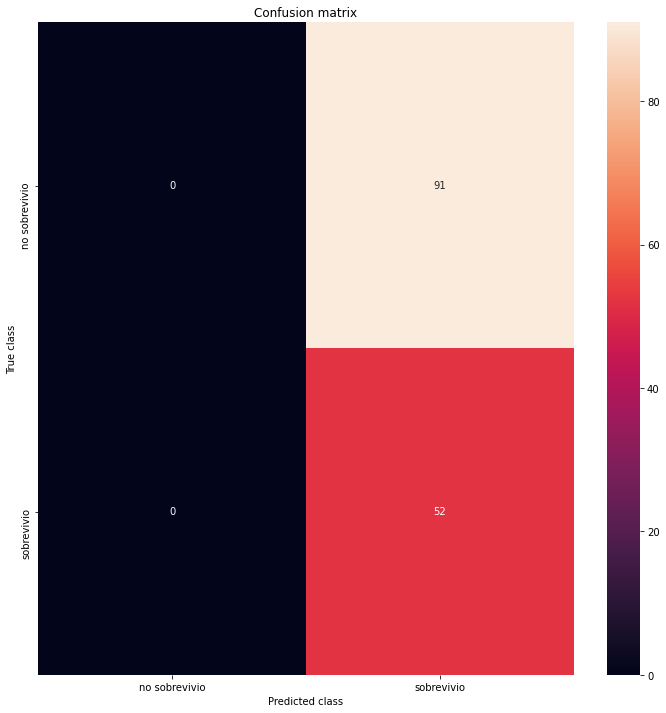

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


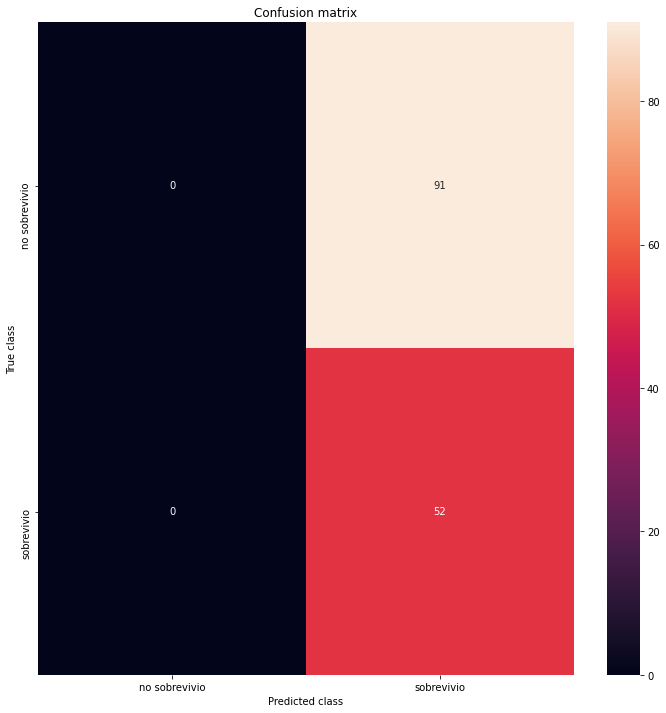

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


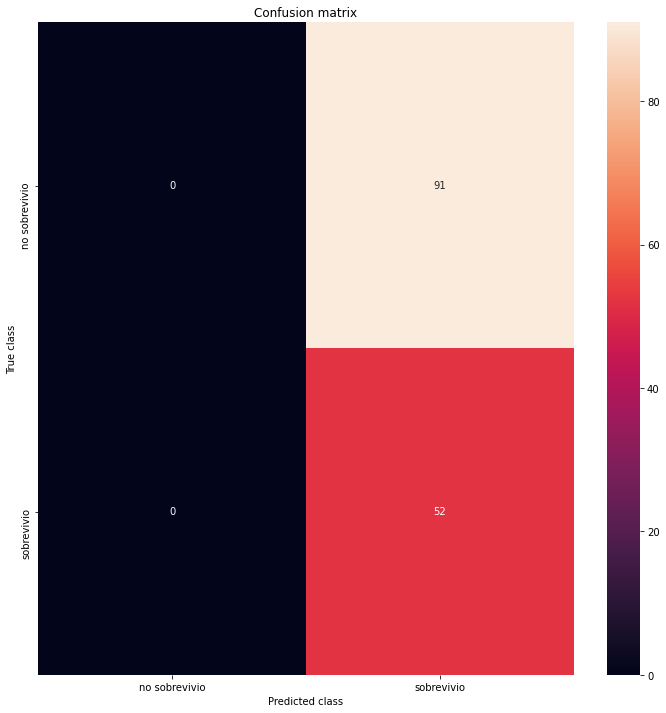

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


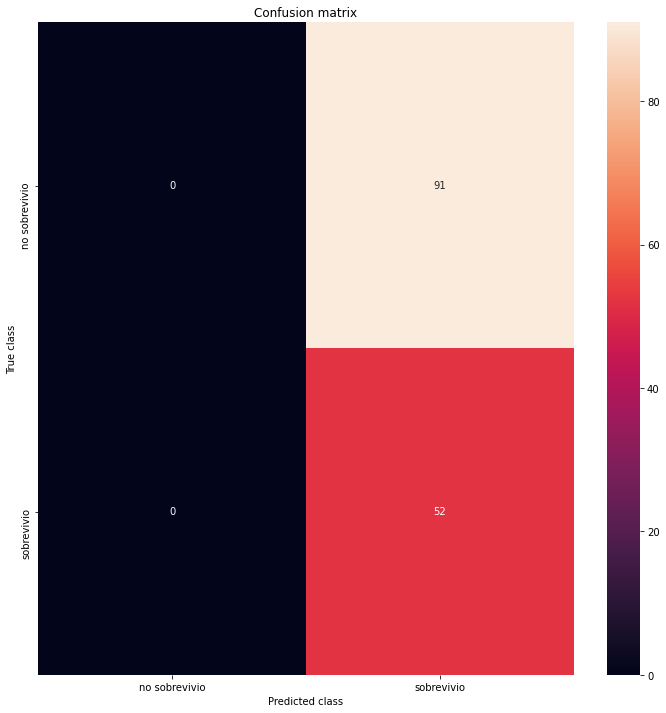

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


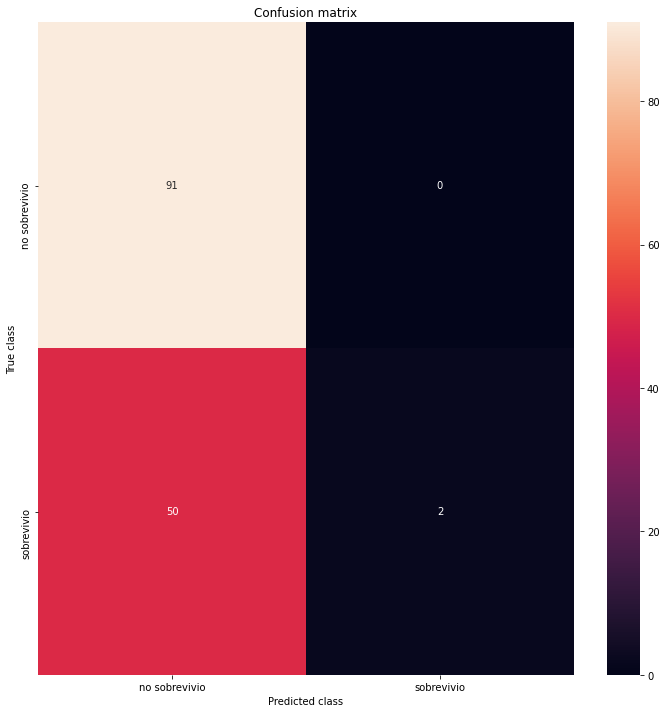

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


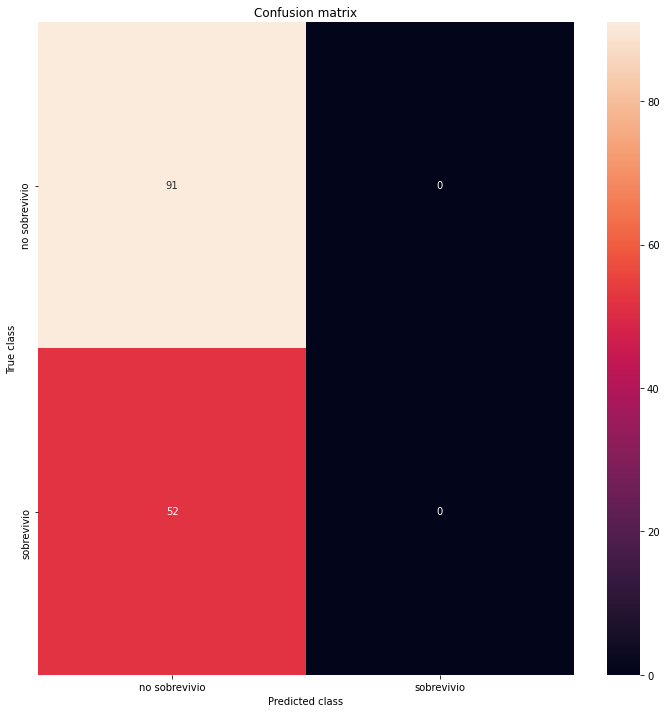

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.675083
Training accuracy: 0.615%
loss at step 1000: 0.674939
Training accuracy: 0.615%
Test accuracy: 0.650%


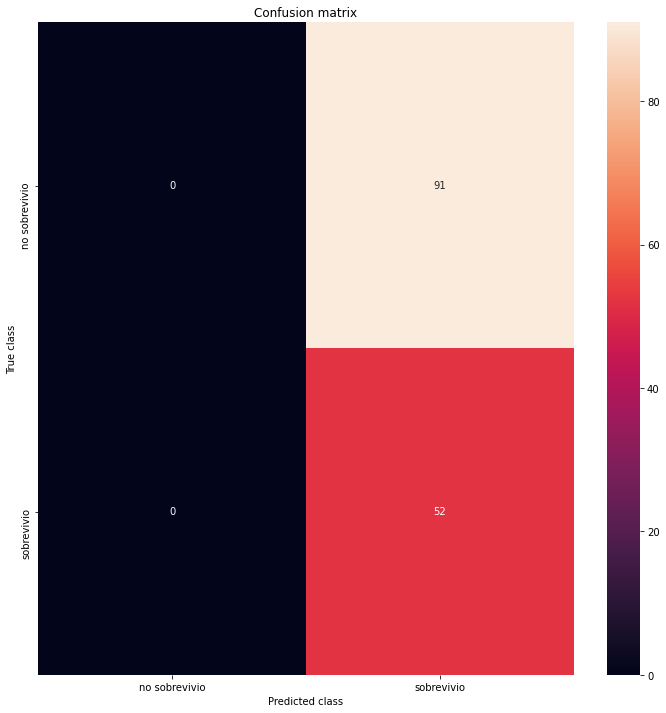

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


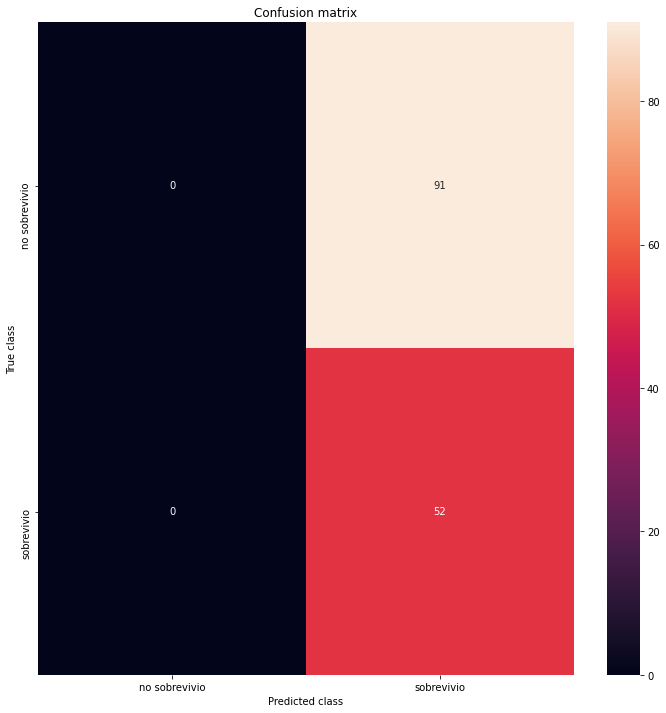

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


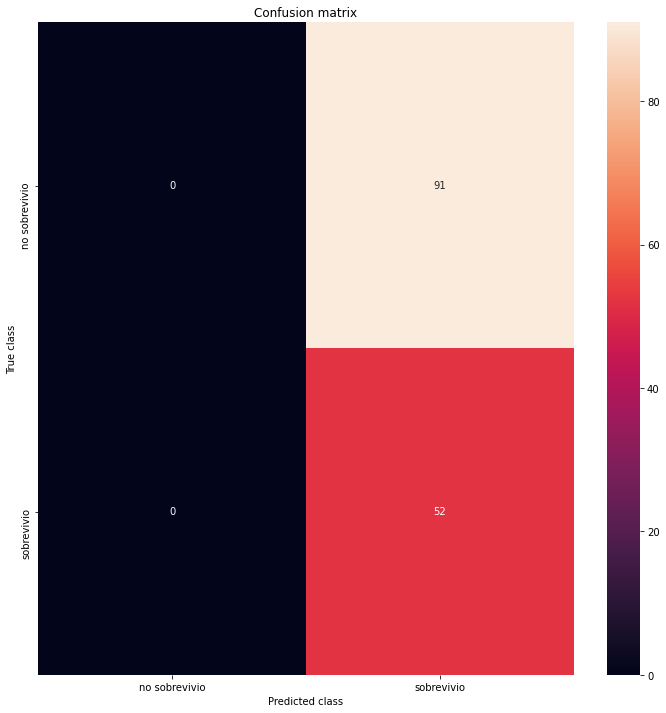

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


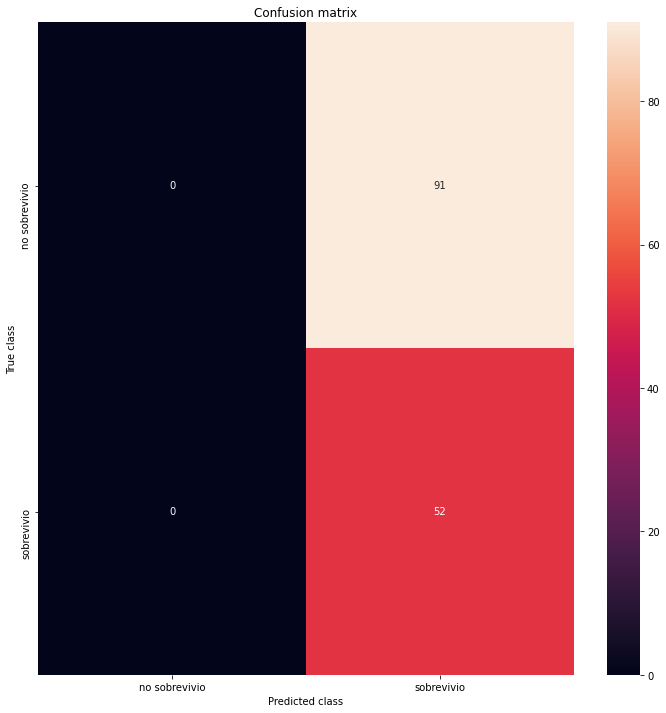

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


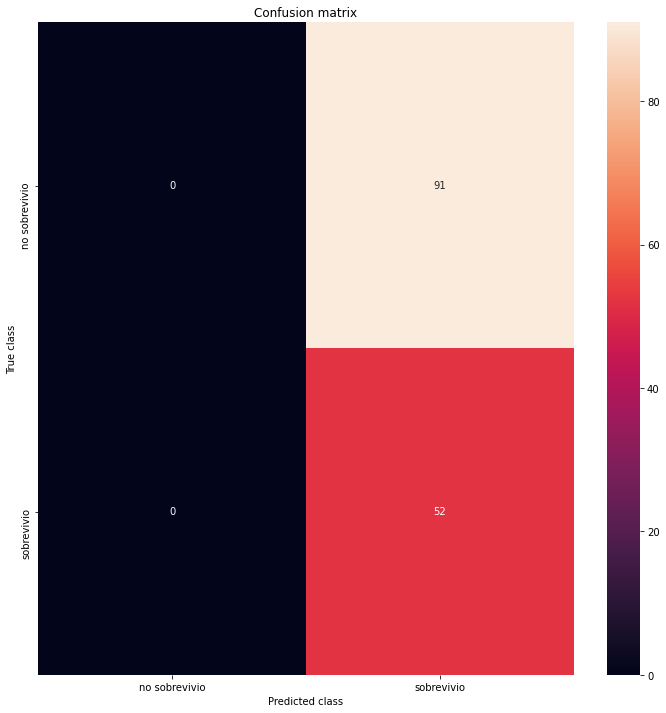

verdaderos positivos: 52
falsos positivos: 91
verdaderos negativos: 0
falsos negativos: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.36      1.00      0.53        52

    accuracy                           0.36       143
   macro avg       0.18      0.50      0.27       143
weighted avg       0.13      0.36      0.19       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.388401      0.363636
Precision       0.388401      0.363636
Recall:         1.000000      1.000000
F1_Score:       0.559494      0.533333


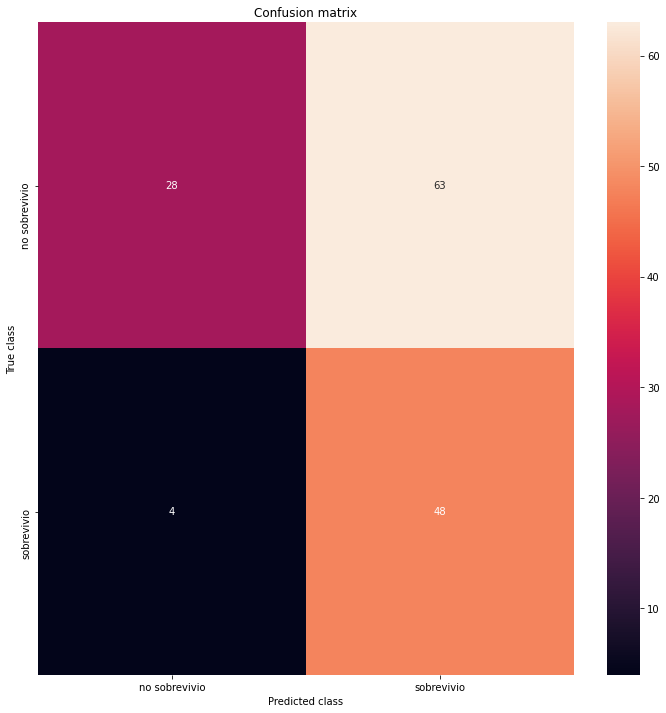

verdaderos positivos: 48
falsos positivos: 63
verdaderos negativos: 28
falsos negativos: 4
              precision    recall  f1-score   support

           0       0.88      0.31      0.46        91
           1       0.43      0.92      0.59        52

    accuracy                           0.53       143
   macro avg       0.65      0.62      0.52       143
weighted avg       0.71      0.53      0.50       143

           metrics_train  metrics_test
Accuracy        0.550088      0.531469
Precision       0.460137      0.432432
Recall:         0.914027      0.923077
F1_Score:       0.612121      0.588957


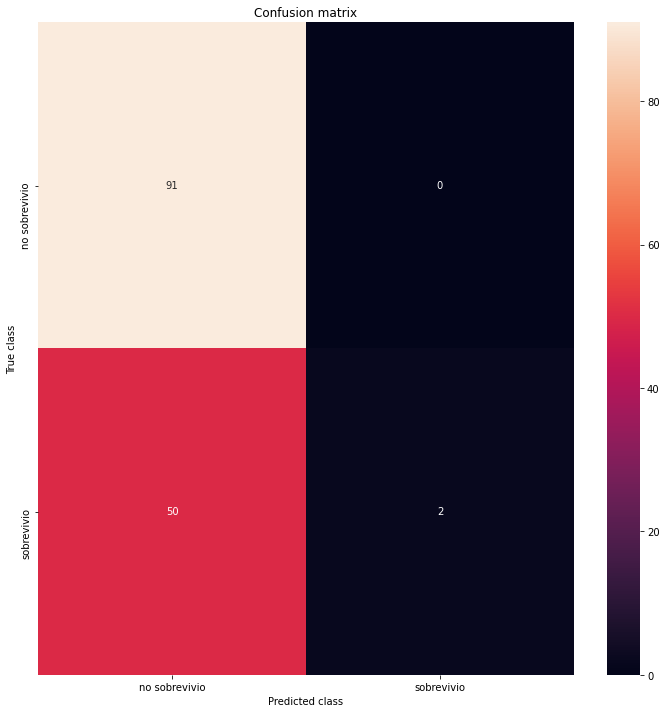

verdaderos positivos: 2
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 50
              precision    recall  f1-score   support

           0       0.65      1.00      0.78        91
           1       1.00      0.04      0.07        52

    accuracy                           0.65       143
   macro avg       0.82      0.52      0.43       143
weighted avg       0.77      0.65      0.53       143

           metrics_train  metrics_test
Accuracy        0.615114      0.650350
Precision       1.000000      1.000000
Recall:         0.009050      0.038462
F1_Score:       0.017937      0.074074


C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


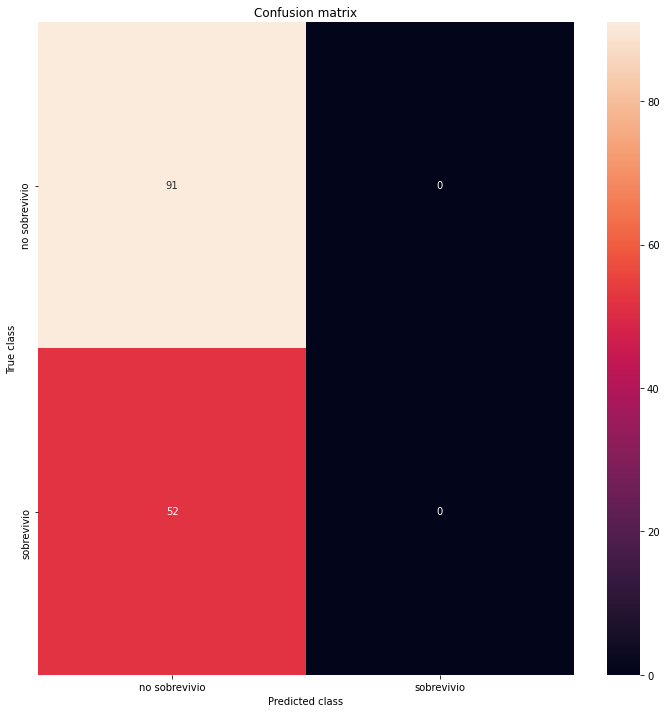

verdaderos positivos: 0
falsos positivos: 0
verdaderos negativos: 91
falsos negativos: 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        52

    accuracy                           0.64       143
   macro avg       0.32      0.50      0.39       143
weighted avg       0.40      0.64      0.49       143



C:\Users\senpai\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           metrics_train  metrics_test
Accuracy        0.611599      0.636364
Precision       0.000000      0.000000
Recall:         0.000000      0.000000
F1_Score:       0.000000      0.000000


In [135]:
regs = [L1,L2,L2t]
facts = [0.001, 0.005, 0.009, 0.01, 0.05, 0.09, 0.1, 0.5]
umbrals = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6]
losses = [True,False]#con sigmoide, softmax

modelos = []
for r in regs:
    for f in facts:
        for l in losses:
            mod = training(X_train,Y_train,X_valid,Y_valid,1001,0.5,32,r,f,l)
            for u in umbrals:
                modelo = reporte(mod,Train,Test,u)
                print(modelo)
                modelos.append({
                            "accuracy": modelo.iloc[0]["metrics_test"],
                            "presicion":modelo.iloc[1]["metrics_test"],
                            "recall": modelo.iloc[2]["metrics_test"],
                            "f1_score": modelo.iloc[3]["metrics_test"],
                            "reg":r,
                            "facts":f,
                            "umbral":u,
                            "sigmoid":l})

In [136]:
#resumiendo el total de modelos y métricas
resumen = pd.DataFrame(modelos)
resumen

accuracy  presicion    recall  f1_score  \
0    0.811189   0.735849  0.750000  0.742857   
1    0.818182   0.842105  0.615385  0.711111   
2    0.818182   0.842105  0.615385  0.711111   
3    0.818182   0.842105  0.615385  0.711111   
4    0.818182   0.842105  0.615385  0.711111   
..        ...        ...       ...       ...   
379  0.363636   0.363636  1.000000  0.533333   
380  0.363636   0.363636  1.000000  0.533333   
381  0.531469   0.432432  0.923077  0.588957   
382  0.650350   1.000000  0.038462  0.074074   
383  0.636364   0.000000  0.000000  0.000000   

                                                   reg  facts  umbral  sigmoid  
0    Tensor("regularization/l1:0", shape=(), dtype=...  0.001    0.15     True  
1    Tensor("regularization/l1:0", shape=(), dtype=...  0.001    0.20     True  
2    Tensor("regularization/l1:0", shape=(), dtype=...  0.001    0.25     True  
3    Tensor("regularization/l1:0", shape=(), dtype=...  0.001    0.30     True  
4    Tensor("regularization/l1:0", shape=(), dtype=...  0.001    0.35     True  
..                                                 ...    ...     ...      ...  
379  Tensor("regularization/l2t:0", shape=(), dtype...  0.500    0.30    False  
380  Tensor("regularization/l2t:0", shape=(), dtype...  0.500    0.35    False  
381  Tensor("regularization/l2t:0", shape=(), dtype...  0.500    0.40    False  
382  Tensor("regularization/l2t:0", shape=(), dtype...  0.500    0.50    False  
383  Tensor("regularization/l2t:0", shape=(), dtype...  0.500    0.60    False  

[384 rows x 8 columns]

### Seleccionando los mejores modelos

In [138]:
#modelo con mejor accuracy
max(modelos, key=lambda x:x['accuracy'])

{'accuracy': 0.8461538461538461,
 'presicion': 0.8947368421052632,
 'recall': 0.6538461538461539,
 'f1_score': 0.7555555555555555,
 'reg': <tf.Tensor 'regularization/l2:0' shape=() dtype=float32>,
 'facts': 0.009,
 'umbral': 0.5,
 'sigmoid': False}

In [139]:
#modelo con mejor recall
max(modelos, key=lambda x:x['recall']) #descartado

{'accuracy': 0.36363636363636365,
 'presicion': 0.36363636363636365,
 'recall': 1.0,
 'f1_score': 0.5333333333333333,
 'reg': <tf.Tensor 'regularization/l1:0' shape=() dtype=float32>,
 'facts': 0.005,
 'umbral': 0.15,
 'sigmoid': False}

In [140]:
#modelo con mejor f1_score
max(modelos, key=lambda x:x['f1_score'])

{'accuracy': 0.8251748251748252,
 'presicion': 0.7647058823529411,
 'recall': 0.75,
 'f1_score': 0.7572815533980582,
 'reg': <tf.Tensor 'regularization/l2:0' shape=() dtype=float32>,
 'facts': 0.05,
 'umbral': 0.4,
 'sigmoid': False}

In [143]:
#obteniendo mejor promedio accurracy + recall
max(modelos, key=lambda x:(x['accuracy']+x['recall'])/2)

{'accuracy': 0.8041958041958042,
 'presicion': 0.7,
 'recall': 0.8076923076923077,
 'f1_score': 0.75,
 'reg': <tf.Tensor 'regularization/l2:0' shape=() dtype=float32>,
 'facts': 0.005,
 'umbral': 0.25,
 'sigmoid': False}

### Mejores modelos

Los mejores modelos se obtuvieron según nuestra metrica de interes, que es exactitud y sensibilidad, se necesita encontrar el máximo de sobrevivientes posibles con la máxima exactitud.

Primer modelo, modelo con mejor exactitud: 
* exactitud: 0.83
* Sensibilidad: 0.75
* Regularización: L2
* Factor de regularización 0.05
* Umbral para predicciones de sobrevivientes: 0.4
* Función sigmoide: No (la función softmax proporciona las probabilidad dado que le estamos dando un umbral para predicciones)

Dado que el data set estaba desbalanceado a 38% de sobrevivientes, y se busca el mayor numero de sobrevivientes aumentado la probabilidad de estar vivo. Tiene sentido que el umbral sea de 0.4

Segundo modelo, mejor promedio exactitud + recall: 
* exactitud: 0.8
* Sensibilidad: 0.7
* Regularización: l2 con tensorflow
* Factor de regularización 0.005
* Umbral para predicciones de sobrevivientes: 0.2
* Función sigmoide: No (utiliza softmax)

Ambos modelos nos dan metricas aceptadas segun los requerimientos.

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.798584
Training accuracy: 0.436%
loss at step 1000: 0.560544
Training accuracy: 0.606%
Test accuracy: 0.818%


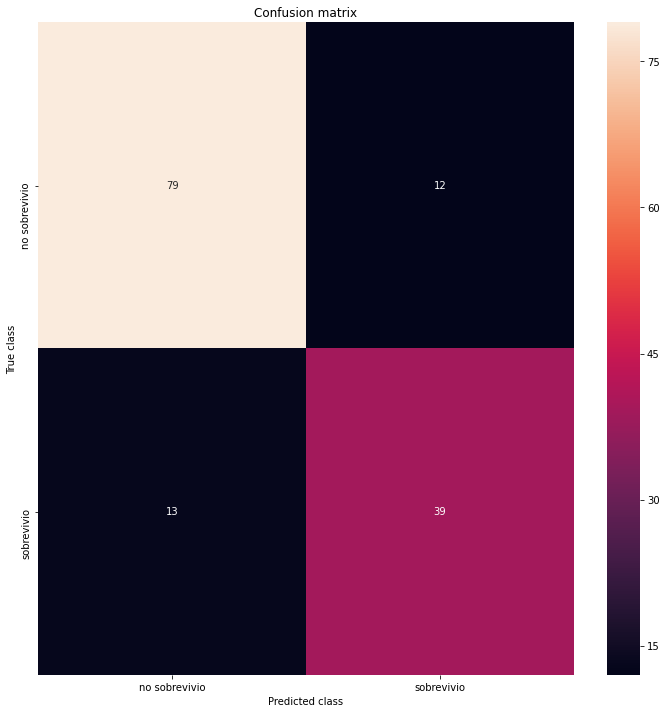

verdaderos positivos: 39
falsos positivos: 12
verdaderos negativos: 79
falsos negativos: 13
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        91
           1       0.76      0.75      0.76        52

    accuracy                           0.83       143
   macro avg       0.81      0.81      0.81       143
weighted avg       0.82      0.83      0.82       143



metrics_train  metrics_test
Accuracy        0.780316      0.825175
Precision       0.726415      0.764706
Recall:         0.696833      0.750000
F1_Score:       0.711316      0.757282

In [154]:
#obtener matriz de confusión de primer modelo
final_model = training(X_train,Y_train,X_valid,Y_valid,1001,0.5,32,L2,0.05,False)
reporte(final_model,Train,Test,0.4)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
loss at step 0: 0.776011
Training accuracy: 0.367%
loss at step 1000: 0.631774
Training accuracy: 0.572%
Test accuracy: 0.839%


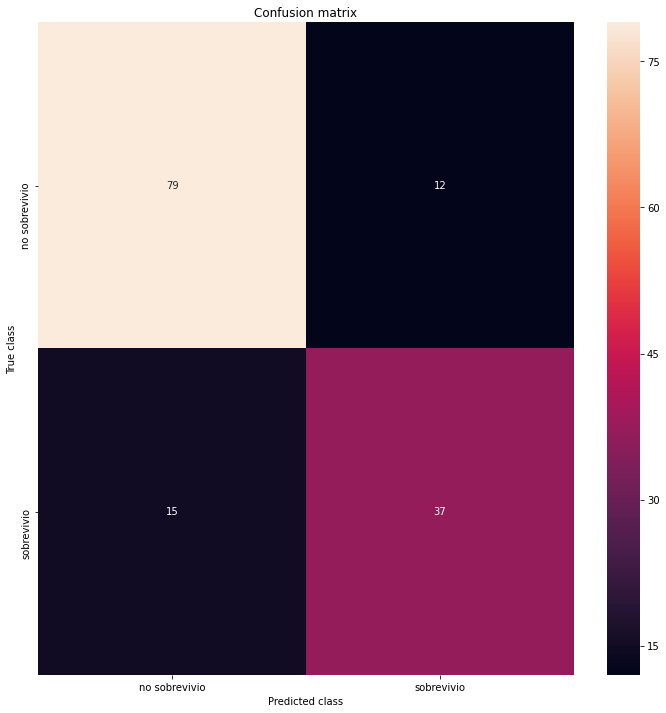

verdaderos positivos: 37
falsos positivos: 12
verdaderos negativos: 79
falsos negativos: 15
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        91
           1       0.76      0.71      0.73        52

    accuracy                           0.81       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.81      0.81      0.81       143



metrics_train  metrics_test
Accuracy        0.768014      0.811189
Precision       0.717073      0.755102
Recall:         0.665158      0.711538
F1_Score:       0.690141      0.732673

In [149]:
#obtener matriz de confusión de segundo modelo
final_model_2 = training(X_train,Y_train,X_valid,Y_valid,1001,0.5,32,L2,0.005)
reporte(final_model_2,Train,Test,0.2)

### Conclusiones

El modelo elegido es el primer modelo, la mejor conbinación exactitud y sensibilidad, logra identificar buen porcentaje de sobrevivientes asi como una exactitud buena.